# 21_7 Descriptive Analysis - Visualizations

Let us now take a closer look on the characterisitcs of our aggregrated data.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import sklearn
from datetime import datetime
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import shapely
import hashlib
import holidays
from shapely import Point, wkt
import scipy.stats
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

## Load and prepare data

In [2]:
data_month_double = '07'

In [3]:
# read final data
data = pd.read_csv("../Data/20_Final_Data.csv")

/tmp/ipykernel_3072574/974816303.py:2: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../../../20_Final_Data_NEW_TEST.csv")


In [4]:
tier = pd.read_parquet("../Data/12_tier_part2.parquet")
next = pd.read_parquet("../Data/15_nextbike_part2.parquet")

In [5]:
tier['trip_duration_seconds'] = tier['trip_duration'].dt.total_seconds()
next['trip_duration_seconds'] = next['trip_duration'].dt.total_seconds()

In [6]:
# transform geometry
data['station_point'] = data['station_point'].apply(wkt.loads)

In [7]:
data['buffer_zone'] = shapely.wkt.loads(data['buffer_zone'])

In [8]:
data = gpd.GeoDataFrame(data, geometry='station_point')

In [9]:
data = data.loc[:, ~data.columns.str.contains('Unnamed')]

In [10]:
#data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.2'], inplace=True)

In [11]:
data['actual_arrival_time'] = pd.to_datetime(data['actual_arrival_time'])
data['actual_departure_time'] = pd.to_datetime(data['actual_departure_time'])
data['scheduled_arrival_time'] = pd.to_datetime(data['scheduled_arrival_time'])
data['scheduled_departure_time'] = pd.to_datetime(data['scheduled_departure_time'])

In [12]:
data = gpd.GeoDataFrame(data, geometry='buffer_zone')

In [13]:
data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2564861 entries, 0 to 2564860
Data columns (total 56 columns):
 #   Column                               Dtype         
---  ------                               -----         
 0   route_id                             int64         
 1   agency_id                            int64         
 2   route_short_name                     object        
 3   route_type                           int64         
 4   route_type_name                      object        
 5   agency_name                          object        
 6   service_id                           int64         
 7   trip_id                              object        
 8   trip_headsign                        object        
 9   direction_id                         int64         
 10  shape_id                             int64         
 11  stop_id                              int64         
 12  actual_arrival_time                  datetime64[ns]
 13  actual_departure_ti

In [14]:
data['date'] = pd.to_datetime(data['date'])

In [15]:
data['arrival_delay'] = pd.to_timedelta(data['arrival_delay'])
data['departure_delay'] = pd.to_timedelta(data['departure_delay'])

In [16]:
#NEW FEATURES
data['delay_category'] = data['departure_delay'].apply(lambda x: 1 if x > pd.Timedelta(0) else 0 if x == pd.Timedelta(0) else -1)
data['cancelled_trip'] = np.where((data['scheduled_arrival_time'].notna() & data['actual_arrival_time'].isna() & data['scheduled_departure_time'].notna() & data['actual_departure_time'].isna()), 1, 0)

In [17]:
data['arrival_delay_float'] = data['arrival_delay'].astype(str)
data['arrival_delay_float'] = data['arrival_delay_float'].str.split(' ', n=2).str[-1]
data['arrival_delay_float'] = data['arrival_delay_float'].astype(str)
data['arrival_delay_float'] = pd.to_timedelta(data['arrival_delay_float'])
data['arrival_delay_float'] = pd.to_timedelta(data['arrival_delay_float']).dt.total_seconds() / 60

In [18]:
data['departure_delay_float'] = data['departure_delay'].astype(str)
data['departure_delay_float'] = data['departure_delay_float'].str.split(' ', n=2).str[-1]
data['departure_delay_float'] = data['departure_delay_float'].astype(str)
data['departure_delay_float'] = pd.to_timedelta(data['departure_delay_float'])
data['departure_delay_float'] = pd.to_timedelta(data['departure_delay_float']).dt.total_seconds() / 60

In [19]:
delay = data[data['departure_delay'] > pd.Timedelta(0)]


In [20]:
# Assuming 'arrival_delay' is a Timedelta column
no_delay = data[
    (data['departure_delay'] == pd.Timedelta(0)) | 
    (data['scheduled_arrival_time'].notna() & 
     data['actual_arrival_time'].isna() & 
     data['scheduled_departure_time'].notna() & 
     data['actual_departure_time'].notna())
]

In [21]:
nan_delay = data[data['scheduled_arrival_time'].notna() & data['actual_arrival_time'].isna() & data['scheduled_departure_time'].notna() & data['actual_departure_time'].isna()]
#nan_delay = data[data['arrival_delay'].isna()]
nan_delay

route_id  agency_id route_short_name  route_type route_type_name  \
41            551          8              551           3             Bus   
42            551          8              551           3             Bus   
43            551          8              551           3             Bus   
44            551          8              551           3             Bus   
45            551          8              551           3             Bus   
...           ...        ...              ...         ...             ...   
2564854       689          6               N9           3             Bus   
2564856       689          6               N9           3             Bus   
2564857       689          6               N9           3             Bus   
2564858       689          6               N9           3             Bus   
2564860       689          6               N9           3             Bus   

                                      agency_name  service_id  \
41       RSVG Rhein-Sieg-Verkehrsgesellschaft mbH         125   
42       RSVG Rhein-Sieg-Verkehrsgesellschaft mbH         125   
43       RSVG Rhein-Sieg-Verkehrsgesellschaft mbH         125   
44       RSVG Rhein-Sieg-Verkehrsgesellschaft mbH         125   
45       RSVG Rhein-Sieg-Verkehrsgesellschaft mbH         125   
...                                           ...         ...   
2564854         SWB Stadtwerke Bonn Verkehrs GmbH          43   
2564856         SWB Stadtwerke Bonn Verkehrs GmbH          43   
2564857         SWB Stadtwerke Bonn Verkehrs GmbH          43   
2564858         SWB Stadtwerke Bonn Verkehrs GmbH          43   
2564860         SWB Stadtwerke Bonn Verkehrs GmbH          43   

                                                   trip_id trip_headsign  \
41       255-551-008-2071.2.22:033200-34-157_C0741D60-B...      Bonn Hbf   
42       159-551-008-687.2.36:044000-33-157_FAA787CB-18...  Troisdorf Bf   
43       159-551-008-687.2.36:044000-33-157_FAA787CB-18...  Troisdorf Bf   
44       159-551-008-687.2.36:044000-33-157_FAA787CB-18...  Troisdorf Bf   
45       159-551-008-687.2.36:044000-33-157_FAA787CB-18...  Troisdorf Bf   
...                                                    ...           ...   
2564854  6890005-689-006-687.2.34:263500-53-1_2AFE8F0F-...      Bonn Hbf   
2564856  6890005-689-006-687.2.34:263500-53-1_2AFE8F0F-...      Bonn Hbf   
2564857  6890005-689-006-687.2.34:263500-53-1_2AFE8F0F-...      Bonn Hbf   
2564858  6890005-689-006-687.2.34:263500-53-1_2AFE8F0F-...      Bonn Hbf   
2564860  6890005-689-006-687.2.34:263500-53-1_2AFE8F0F-...      Bonn Hbf   

         direction_id  ...  delay_span  arrival_delay_span weather_int  \
41                  1  ...           0                   0           0   
42                  0  ...           0                   0           0   
43                  0  ...           0                   0           0   
44                  0  ...           0                   0           0   
45                  0  ...           0                   0           0   
...               ...  ...         ...                 ...         ...   
2564854             0  ...           0                   0           1   
2564856             0  ...           0                   0           1   
2564857             0  ...           0                   0           1   
2564858             0  ...           0                   0           1   
2564860             0  ...           0                   0           1   

        time_span_arrival  time_span_int_arrival  weekend time_span  \
41                      0                      0        1         0   
42                      0                      0        1         0   
43                      0                      0        1         0   
44                      0                      0        1         0   
45                      0                      0        1         0   
...                   ...                    ...      ...       ...   
2564

### Definition of functions

In [22]:
def calc_stats(data, column_name):

    #generated by Copilot

    sum = data[column_name].sum()

#Central Tendency

    rows = len(data.index)
    # Calculate mean (average)
    mean = data[column_name].mean()
    # Calculate median (middle value)
    median = data[column_name].median()
    # Calculate mode (most frequent value)
    mode = data[column_name].mode()
    #calc maximum
    max = data[column_name].max()
    #calc minimum
    min = data[column_name].min()

    # Calculate range
    data_range = data[column_name].max() - data[column_name].min()
    # Calculate coefficient of variation of range
    cvr = data_range / mean
    # Calculate coefficient of variation of mean
    cvm = mean / mean
    # Calculate coefficient of variation of median
    cvmed = median / mean
    # Calculate coefficient of variation of mode
    cvmode = mode / mean
    # Calculate coefficient of variation of standard deviation
   

# Variability
# Measure of how spread out the values in a data set are
    
    # Calculate standard deviation (average amount of variability in a dataset; tells how far each score lies from the mean; the larger the standard deviation, the more variable the data)
    std_dev = data[column_name].std()
    # Calculate variance (average squared deviation from the mean; square of standard deviation; units of varriance are much larger than those of a typical value in the dataset)
    variance = data[column_name].var()
    # Calculate coefficient of variation
    cv = std_dev / mean # standard deviation divided by the mean; measures the relative variability of a dataset; allows comparison of variability of datasets with different units of measurement
    # Calculate 25th percentile
    percentile_25 = data[column_name].quantile(0.25)
    # Calculate 75th percentile
    percentile_75 = data[column_name].quantile(0.75)
    # Calculate interquartile range
    iqr = percentile_75 - percentile_25 # difference between the 75th and 25th percentiles; measures the spread of the middle 50% of values in a dataset
    # Calculate coefficient of quartile deviation
    qd = iqr / (percentile_75 + percentile_25)
    # Calculate coefficient of variation of coefficient of variation
    cvcv = std_dev / mean
    # Calculate coefficient of variation of coefficient of quartile deviation
    cvqd = iqr / (percentile_75 + percentile_25)
    # Calculate coefficient of variation of range

#Measure of Shape

    # Calculate skewness - measure of how much the probability distribution of a random variable deviates from the normal distribution
    skewness = data[column_name].skew()
    
    # Calculate kurtosis
    kurtosis = data[column_name].kurtosis()

    # Calculate coefficient of skewness
    cs = skewness / std_dev
    # Calculate coefficient of kurtosis
    ck = kurtosis / std_dev
    # Calculate coefficient of variation of skewness
    cvs = skewness / std_dev
    # Calculate coefficient of variation of kurtosis
    cvk = kurtosis / std_dev
    # Calculate coefficient of variation of coefficient of skewness
    cvcs = skewness / std_dev
    # Calculate coefficient of variation of coefficient of kurtosis
    cvck = kurtosis / std_dev
    
    
    
    #return "column: " + str(column_name), "mean: " + str(mean), "median: " + str(median), "mode: " + str(mode), "std_dev: " + str(std_dev), "variance: " + str(variance), "skewness: "+ str(skewness), "kurtosis: " + str(kurtosis), "percentile_25: "+ str(percentile_25), "percentile_75: "+ str(percentile_75), "iqr: " + str(iqr), "range: "+ str(data_range), "cv"+ str(cv), "qd: "+str(qd), "cs: "+ str(cs), "ck: " + str(ck), "csv: "+ str(cvs), "cvk: "+ str(cvk), "cvcs: "+ str(cvcs), "cvck: " +str(cvck), "cvcv: "+ str(cvcv), "cvqd: "+ str (cvqd), "cvr: "+ str(cvr), "cvm: " + str(cvm), "cvmed: " + str(cvmed), "cvmode: "+ str(cvmode)

    return pd.DataFrame({'column': [column_name],
                         'number of rows': [rows],                       
                         'sum': [sum],
                         'mean': [mean],
                         'median': [median],
                         'mode': [mode],
                         'max': [max],
                         'min': [min],
                         'std_dev': [std_dev],
                         'variance': [variance],
                         'skewness': [skewness],
                         'kurtosis': [kurtosis],
                         'percentile_25': [percentile_25],
                         'percentile_75': [percentile_75],
                         'iqr': [iqr],
                         'range': [data_range],
                         'cv': [cv],
                         'qd': [qd],
                         'cs': [cs],
                         'ck': [ck],
                         'cvs': [cvs],
                         'cvk': [cvk],
                         'cvcs': [cvcs],
                         'cvck': [cvck],
                         'cvcv': [cvcv],
                         'cvqd': [cvqd],
                         'cvr': [cvr],
                         'cvm': [cvm],
                         'cvmed': [cvmed],
                         'cvmode': [cvmode]}).T

In [23]:
# create a shorter dataframe with most interesting columns - for better overview
def show_short_df(dataframe):
    delay_short = dataframe[['route_id', 'trip_id', 'stop_id', 'stop_name', 'scheduled_arrival_time', 'actual_arrival_time', 'scheduled_departure_time', 'actual_departure_time', 'arrival_delay', 'departure_delay', 'tier_trips_count', 'tier_trips_end_at_station_count', 'nextbike_trips_count', 'nextbike_trips_end_at_station_count', 'buffer_zone', 'arrival_delay_float', 'departure_delay_float']]
    return delay_short

In [24]:
# transform geometry
point_start = gpd.GeoDataFrame(geometry=gpd.GeoSeries.from_wkb(tier["start_location"], crs=4326))
point_end = gpd.GeoDataFrame(geometry=gpd.GeoSeries.from_wkb(tier["end_location"], crs=4326))
# drop geometry columns in wrong format
tier = tier.drop(columns=["start_location", "end_location"])
# replace geometry columns with correct format
tier['start_location'] = point_start
tier['end_location'] = point_end

In [25]:
# get the data from the tier / nextbike dataset
def check_micromobility_datasets(type, data):
    
    if type == 'tier':

        return_data = tier.copy()
        return_data = return_data.iloc[0:0] # empty dataframe

        for item in data['tier_trips_id'].str.split(' ').explode().dropna():   # iterate over all tier ids in the dataframe
            
            id = tier[tier['tier_trips_id'] == int(float(item))]   # get the rows with the specific id
            return_data = pd.concat([return_data, id])  # add the rows to the return dataframe

            return_data.drop_duplicates(inplace=True)
            
    if type == 'next':

        return_data = next.copy()
        return_data = return_data.iloc[0:0] # empty dataframe

        for item in data['nextbike_trips_id'].str.split(' ').explode().dropna():   # iterate over all nextbike ids in the dataframe
            
            id = next[next['nextbike_trips_id'] == int(float(item))]  # get the rows with the specific id
            return_data = pd.concat([return_data, id]) # add the rows to the return dataframe

            return_data.drop_duplicates(inplace=True)

    return return_data

In [26]:
def get_station_to_station(data, mode):
    
    if mode == 'tier':

        data = data[data['tier_trips_start_at_station_id'].notna() & data['tier_trips_end_at_station_id'].notna()]
        data = data[data['tier_trips_start_at_station_id'] != data['tier_trips_end_at_station_id']]
        data = data[data['tier_trips_start_at_station_id'] != 0]
        data = data[data['tier_trips_end_at_station_id'] != 0]
    t = check_micromobility_datasets('tier', data)
    n = check_micromobility_datasets('next', data)

    t = t[t['end_stop_id'].notna() & t['start_stop_id'].notna()]
    n = n[n['end_stop_id'].notna() & n['start_stop_id'].notna()]
    
    return t, n

In [27]:
# map the start and end locations of the trips on a map and connect them with a line

def map_buffer_zones(dataset):
    
    micromobility_data = check_micromobility_datasets('tier', dataset)
    
    # Create a folium map object
    m = folium.Map(location=[50.73743, 7.09821], zoom_start=12)

    # Iterate over each row in the micromobility data
    for index, row in micromobility_data.iterrows():
        # Get the start and end locations
        start_location = row['start_location']
        end_location = row['end_location']
        
        # Get the start and end stop names
        start_stop_name = row['start_stop_name']
        end_stop_name = row['end_stop_name']
        # Add markers for the start and end locations
        folium.Marker(location=[start_location.y, start_location.x], popup=start_stop_name).add_to(m)
        folium.Marker(location=[end_location.y, end_location.x], popup=end_stop_name).add_to(m)
        # Create a line connecting the start and end locations
        folium.PolyLine(locations=[[start_location.y, start_location.x], [end_location.y, end_location.x]], color='blue').add_to(m)
        
    # Display the map
    return m

In [28]:
def get_stats(data, var):

    if var == 'all':
        var = data.columns

    df = pd.DataFrame()

    for i in var:
        df = pd.concat([df, calc_stats(data, i)], axis=1)

    df.columns = df.iloc[0]
    df = df[1:]
    
    return df

In [29]:
def get_micro_stats(data, operator):
    
    if operator == 'tier':
        dataframe = get_stats(check_micromobility_datasets(operator, data), ['trip_duration_seconds', 'trip_distance_kilometers'])
    elif operator == 'next':
        dataframe = get_stats(check_micromobility_datasets(operator, data), ['trip_duration_seconds', 'trip_distance_kilometers'])
    
    return dataframe

In [30]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')
                 #Bbox = dict(facecolor = 'red', alpha =.8))

route_id', 'agency_id',
       'route_short_name', 'route_type', 'route_type_name', 'agency_name',
       'service_id', 'trip_id', 'trip_headsign', 'direction_id', 'shape_id',
       'stop_id', 'actual_arrival_time', 'actual_departure_time',
       'vrs_timestamp', 'stop_sequence', 'stop_headsign', 'stop_name',
       'station_point', 'buffer_zone', 'scheduled_arrival_time',
       'scheduled_departure_time', 'arrival_delay', 'departure_delay',
       'service', 'date', 'weekday', 'transfer_stop', 'tier_trips_count',
       'tier_trips_id', 'nextbike_trips_count', 'nextbike_trips_id',
       'current_time', 'current_temp', 'current_feels_like',
       'current_cloudiness', 'current_visibility', 'current_wind_speed',
       'current_description', 'current_precipitation_volume', 'holiday',
       'holiday_NRW', 'holiday_name', 'holiday_name_NRW'

## Visualization

In [31]:
data.columns

Index(['route_id', 'agency_id', 'route_short_name', 'route_type',
       'route_type_name', 'agency_name', 'service_id', 'trip_id',
       'trip_headsign', 'direction_id', 'shape_id', 'stop_id',
       'actual_arrival_time', 'actual_departure_time', 'vrs_timestamp',
       'stop_sequence', 'stop_headsign', 'stop_name', 'scheduled_arrival_time',
       'scheduled_departure_time', 'arrival_delay', 'departure_delay',
       'service', 'date', 'weekday', 'transfer_stop', 'tier_trips_count',
       'tier_trips_id', 'tier_trips_end_at_station_count',
       'tier_trips_end_at_station_id', 'station_point', 'buffer_zone',
       'nextbike_trips_count', 'nextbike_trips_id',
       'nextbike_trips_end_at_station_count',
       'nextbike_trips_end_at_station_id', 'current_time', 'current_temp',
       'current_feels_like', 'current_cloudiness', 'current_visibility',
       'current_wind_speed', 'current_description',
       'current_precipitation_volume', 'arrival_delay_float',
       'departure_

### Delay Times

### Delay Span Tier

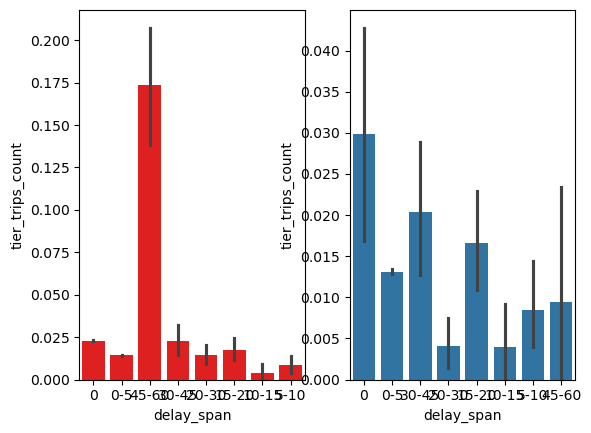

In [32]:
# Mean
f, axes = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = [20.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data, x="delay_span", y="tier_trips_count", ax=axes[0], color='Red')
sns.barplot(delay, x="delay_span", y="tier_trips_count", ax=axes[1])
plt.show()

In [33]:
grouped_data = data.groupby('delay_span').agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum', 'arrival_delay': 'mean', 'arrival_delay_float' : 'mean'})
grouped_delay = delay.groupby('delay_span').agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum', 'arrival_delay': 'mean', 'arrival_delay_float' : 'mean'})

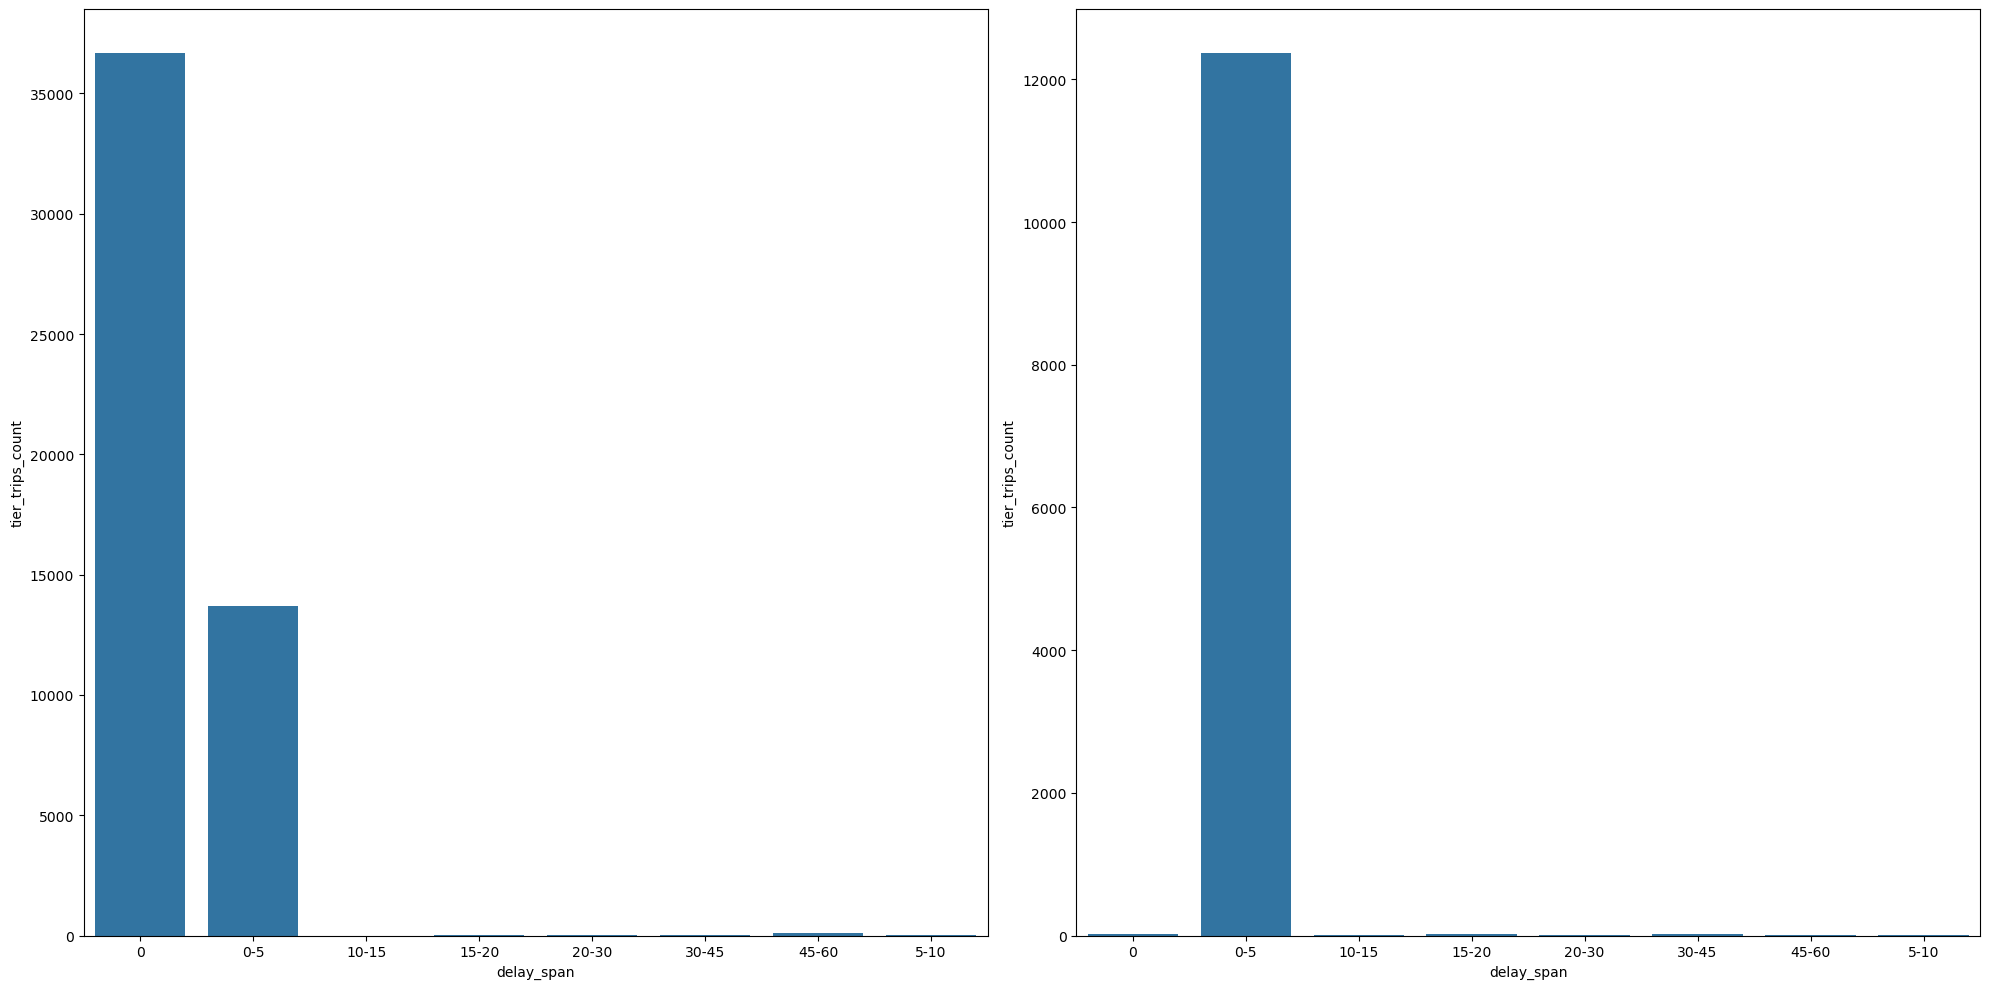

In [34]:
# Count
f, axes = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = [5.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(grouped_data, x="delay_span", y="tier_trips_count", ax=axes[0])
sns.barplot(grouped_delay, x="delay_span", y="tier_trips_count", ax = axes[1])
plt.show()

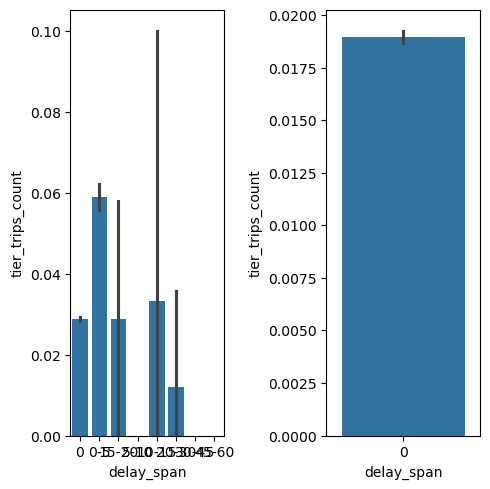

In [35]:
# Mean No/nan
f, axes = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = [5.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(no_delay, x="delay_span", y="tier_trips_count", ax=axes[0])
sns.barplot(nan_delay, x="delay_span", y="tier_trips_count", ax = axes[1])
plt.show()

In [36]:
no_group = no_delay.groupby('delay_span').agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum', 'arrival_delay': 'mean', 'arrival_delay_float' : 'mean'})
nan_group = no_delay.groupby('delay_span').agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum', 'arrival_delay': 'mean', 'arrival_delay_float' : 'mean'})

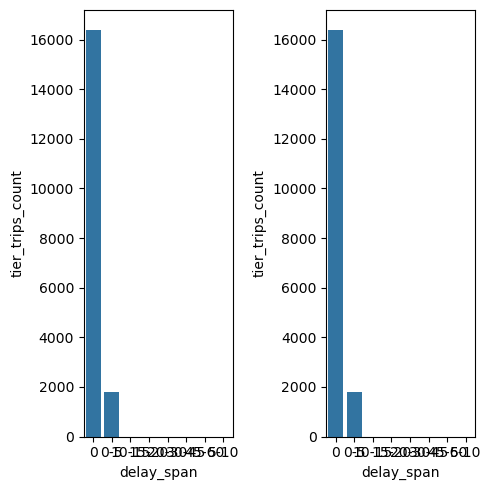

In [37]:
# Mean No/nan
f, axes = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = [5.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(no_group, x="delay_span", y="tier_trips_count", ax=axes[0])
sns.barplot(nan_group, x="delay_span", y="tier_trips_count", ax = axes[1])
plt.show()

#### Delay Span Nextbike

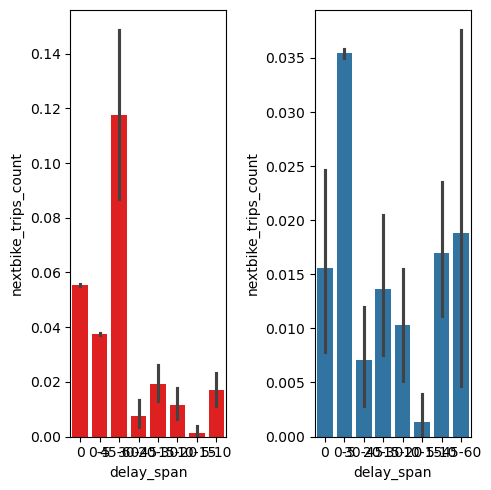

In [38]:
# Mean
f, axes = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data, x="delay_span", y="nextbike_trips_count", ax=axes[0], color='Red')
sns.barplot(delay, x="delay_span", y="nextbike_trips_count", ax=axes[1])
plt.show()

In [39]:
grouped_data = data.groupby('delay_span').agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum','arrival_delay': 'mean', 'arrival_delay_float' : 'mean'})
grouped_delay = delay.groupby('delay_span').agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum','arrival_delay': 'mean', 'arrival_delay_float' : 'mean'})

In [40]:
grouped_data

tier_trips_count  nextbike_trips_count             arrival_delay  \
delay_span                                                                     
0                      36674                 89023 0 days 00:00:10.535377649   
0-5                    13691                 35569 0 days 00:00:17.547242965   
10-15                      3                     1 0 days 00:12:28.695054945   
15-20                     30                    20 0 days 00:17:54.908869987   
20-30                     31                    42 0 days 00:24:14.611510791   
30-45                     33                    11 0 days 00:37:41.043878273   
45-60                    118                    80 0 days 00:49:38.858615611   
5-10                      13                    26 0 days 00:03:22.708185053   

            arrival_delay_float  
delay_span                       
0                      0.047805  
0-5                    0.292454  
10-15                 12.478251  
15-20                 17.915148  
20-30                 24.243525  
30-45                 37.684065  
45-60                 49.647644  
5-10                   3.378470

In [41]:
grouped_delay

tier_trips_count  nextbike_trips_count             arrival_delay  \
delay_span                                                                     
0                         23                    12 0 days 05:41:12.680412371   
0-5                    12367                 33393 0 days 00:00:17.051918706   
10-15                      3                     1 0 days 00:12:28.734525447   
15-20                     29                    18 0 days 00:17:54.896088019   
20-30                      6                    20 0 days 00:23:53.060188542   
30-45                     29                    10 0 days 00:37:37.140300644   
45-60                      2                     4 0 days 00:48:29.716981132   
5-10                      13                    26 0 days 00:03:21.904932094   

            arrival_delay_float  
delay_span                       
0                    222.448454  
0-5                    0.284199  
10-15                 12.478909  
15-20                 17.914935  
20-30                 23.884336  
30-45                 37.619005  
45-60                 48.495283  
5-10                   3.365082

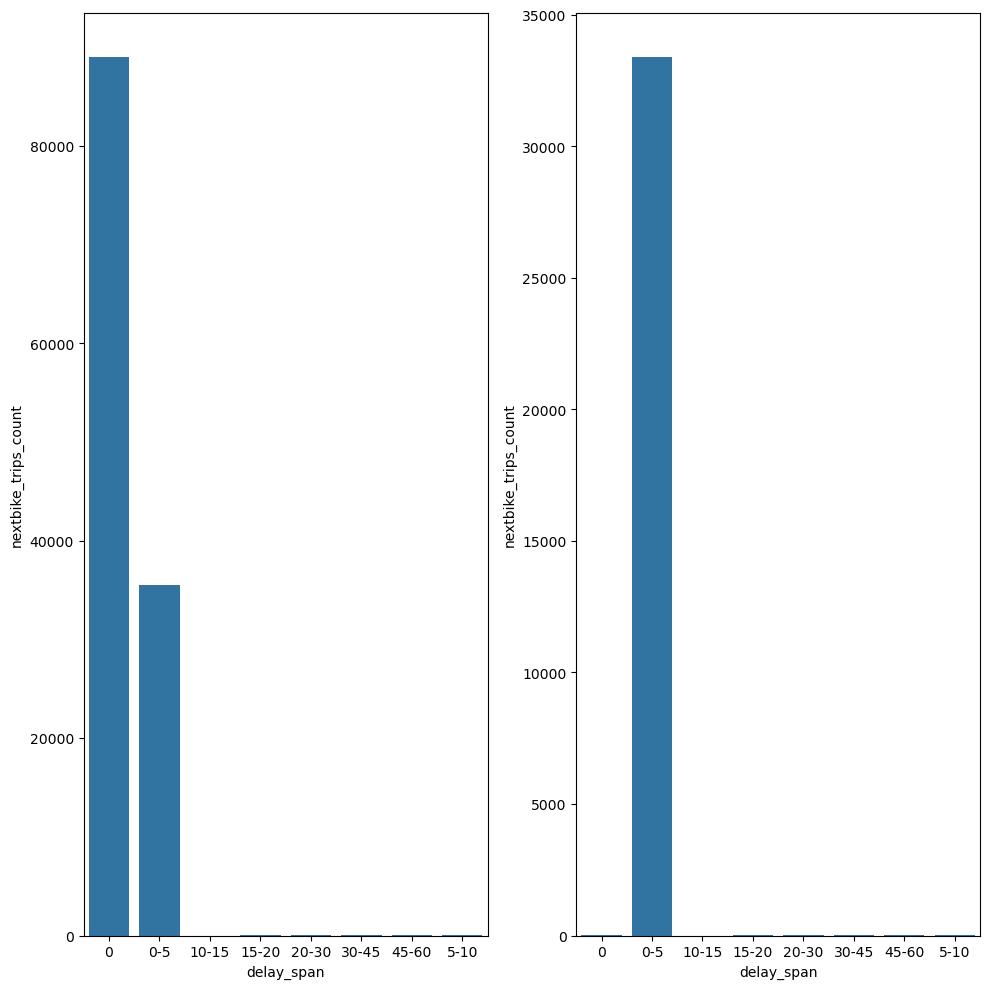

In [42]:
# Count
f, axes = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(grouped_data, x="delay_span", y="nextbike_trips_count", ax=axes[0])
sns.barplot(grouped_delay, x="delay_span", y="nextbike_trips_count", ax = axes[1])
plt.show()

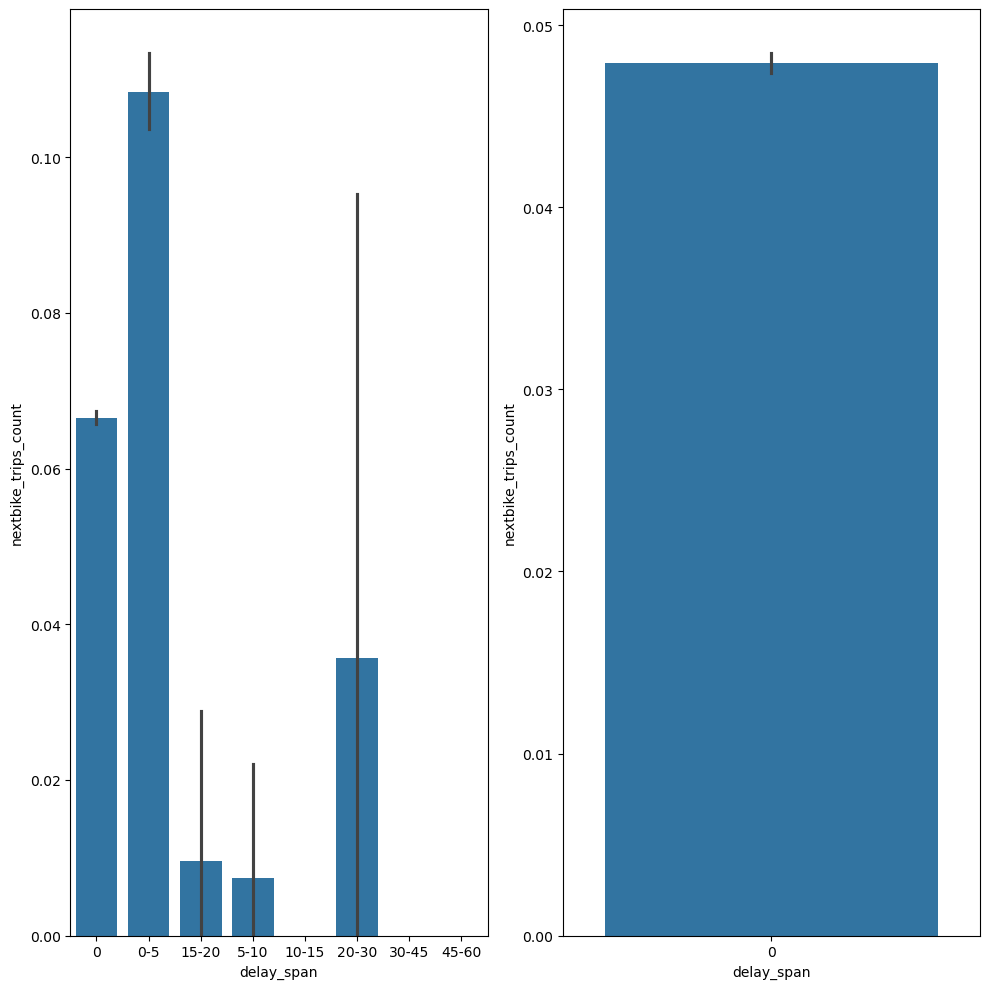

In [43]:
# Mean No/nan
f, axes = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = [5.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(no_delay, x="delay_span", y="nextbike_trips_count", ax=axes[0])
sns.barplot(nan_delay, x="delay_span", y="nextbike_trips_count", ax = axes[1])
plt.show()

In [44]:
no_group = no_delay.groupby('delay_span').agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum', 'arrival_delay': 'mean'})
nan_group = no_delay.groupby('delay_span').agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum', 'arrival_delay': 'mean'})

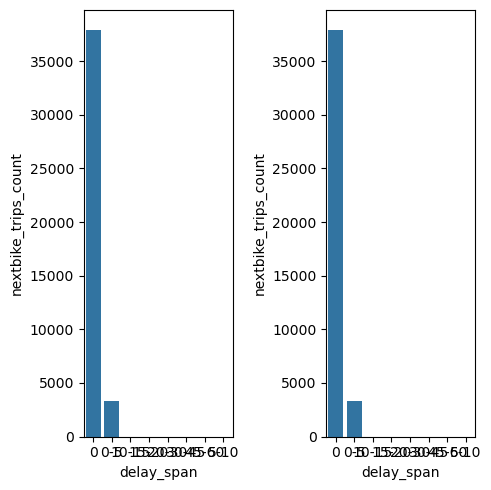

In [45]:
# Mean No/nan
f, axes = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = [5.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(no_group, x="delay_span", y="nextbike_trips_count", ax=axes[0])
sns.barplot(nan_group, x="delay_span", y="nextbike_trips_count", ax = axes[1])
plt.show()

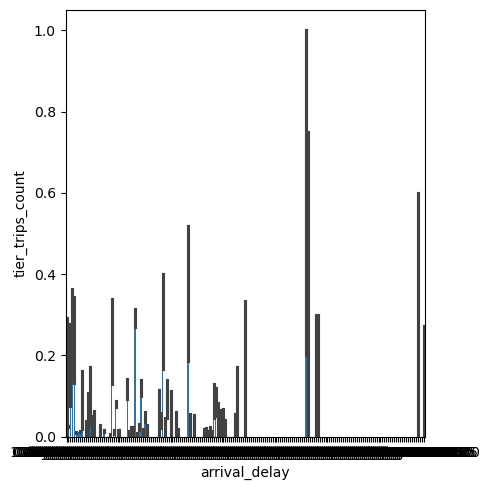

In [46]:
f, axes = plt.subplots(1)
plt.rcParams["figure.figsize"] = [10.00, 20.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data, x="arrival_delay", y="tier_trips_count")
plt.show()

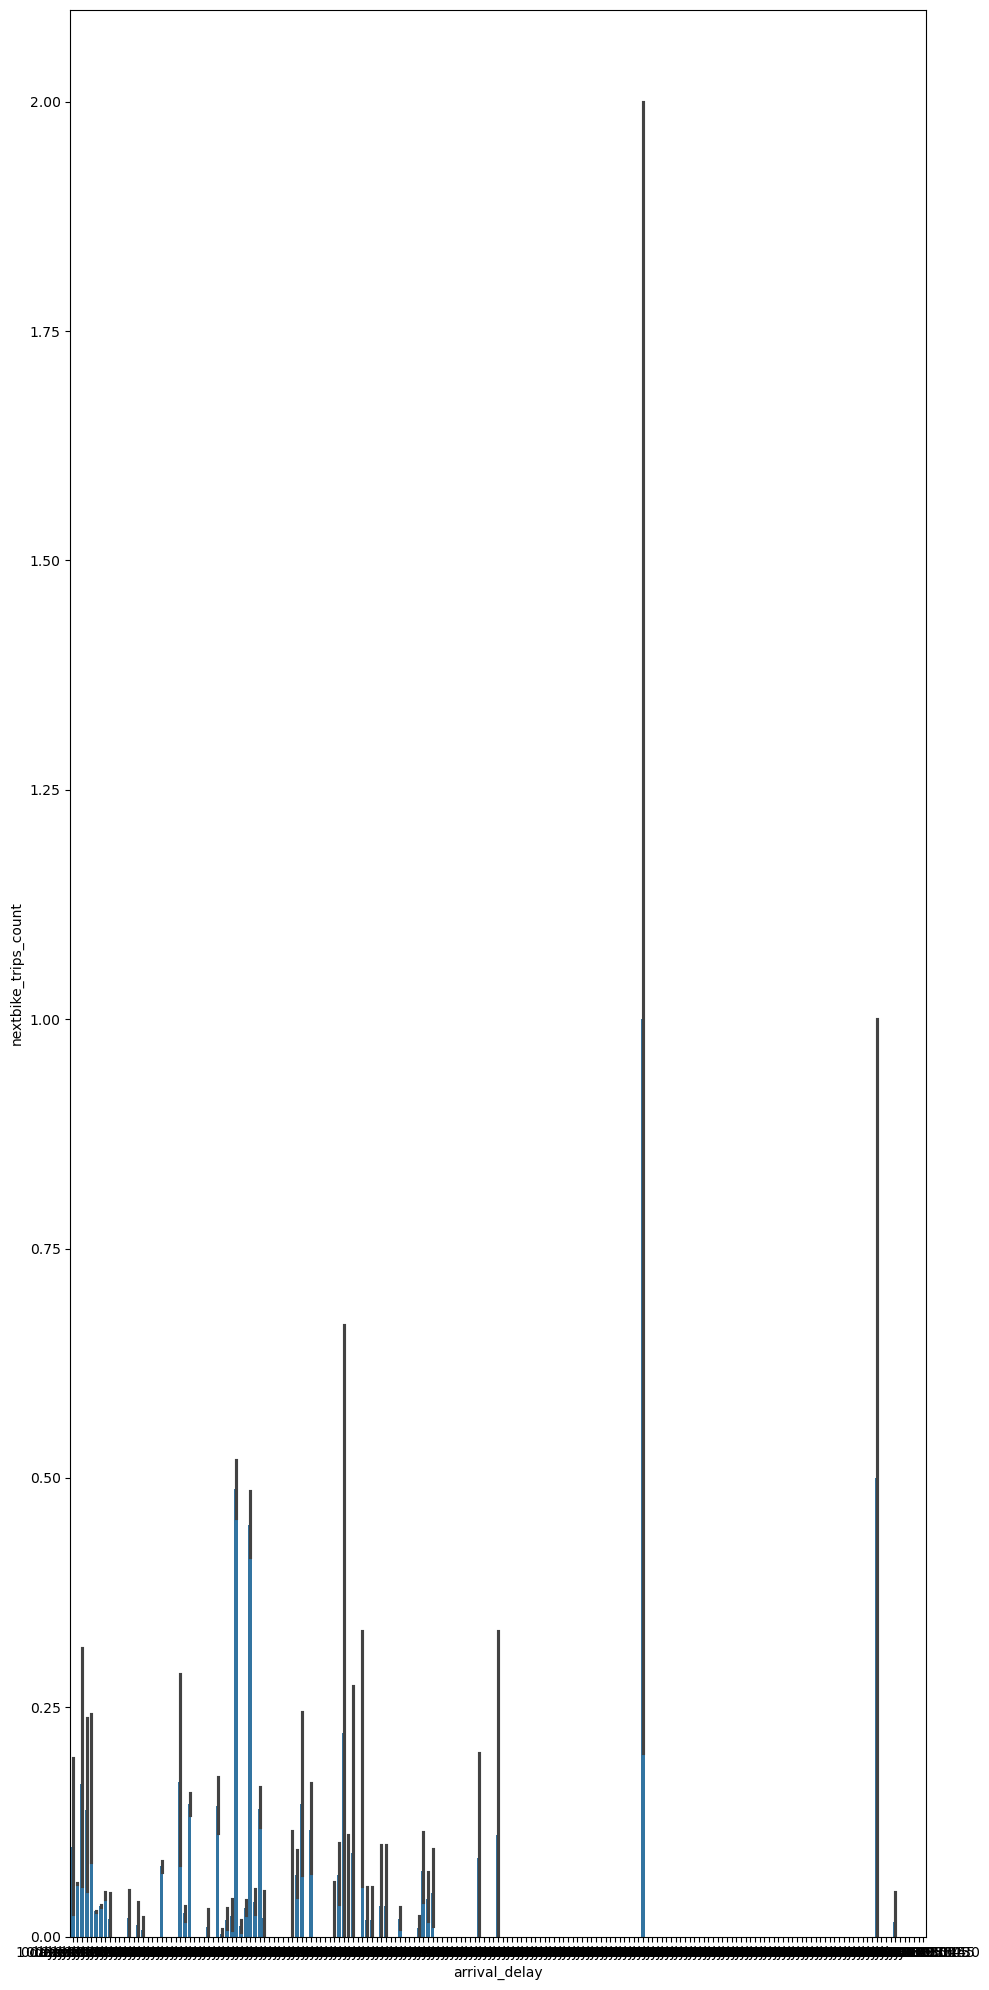

In [47]:
f, axes = plt.subplots(1)
plt.rcParams["figure.figsize"] = [20.00, 20.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data, x="arrival_delay", y="nextbike_trips_count")
plt.show()

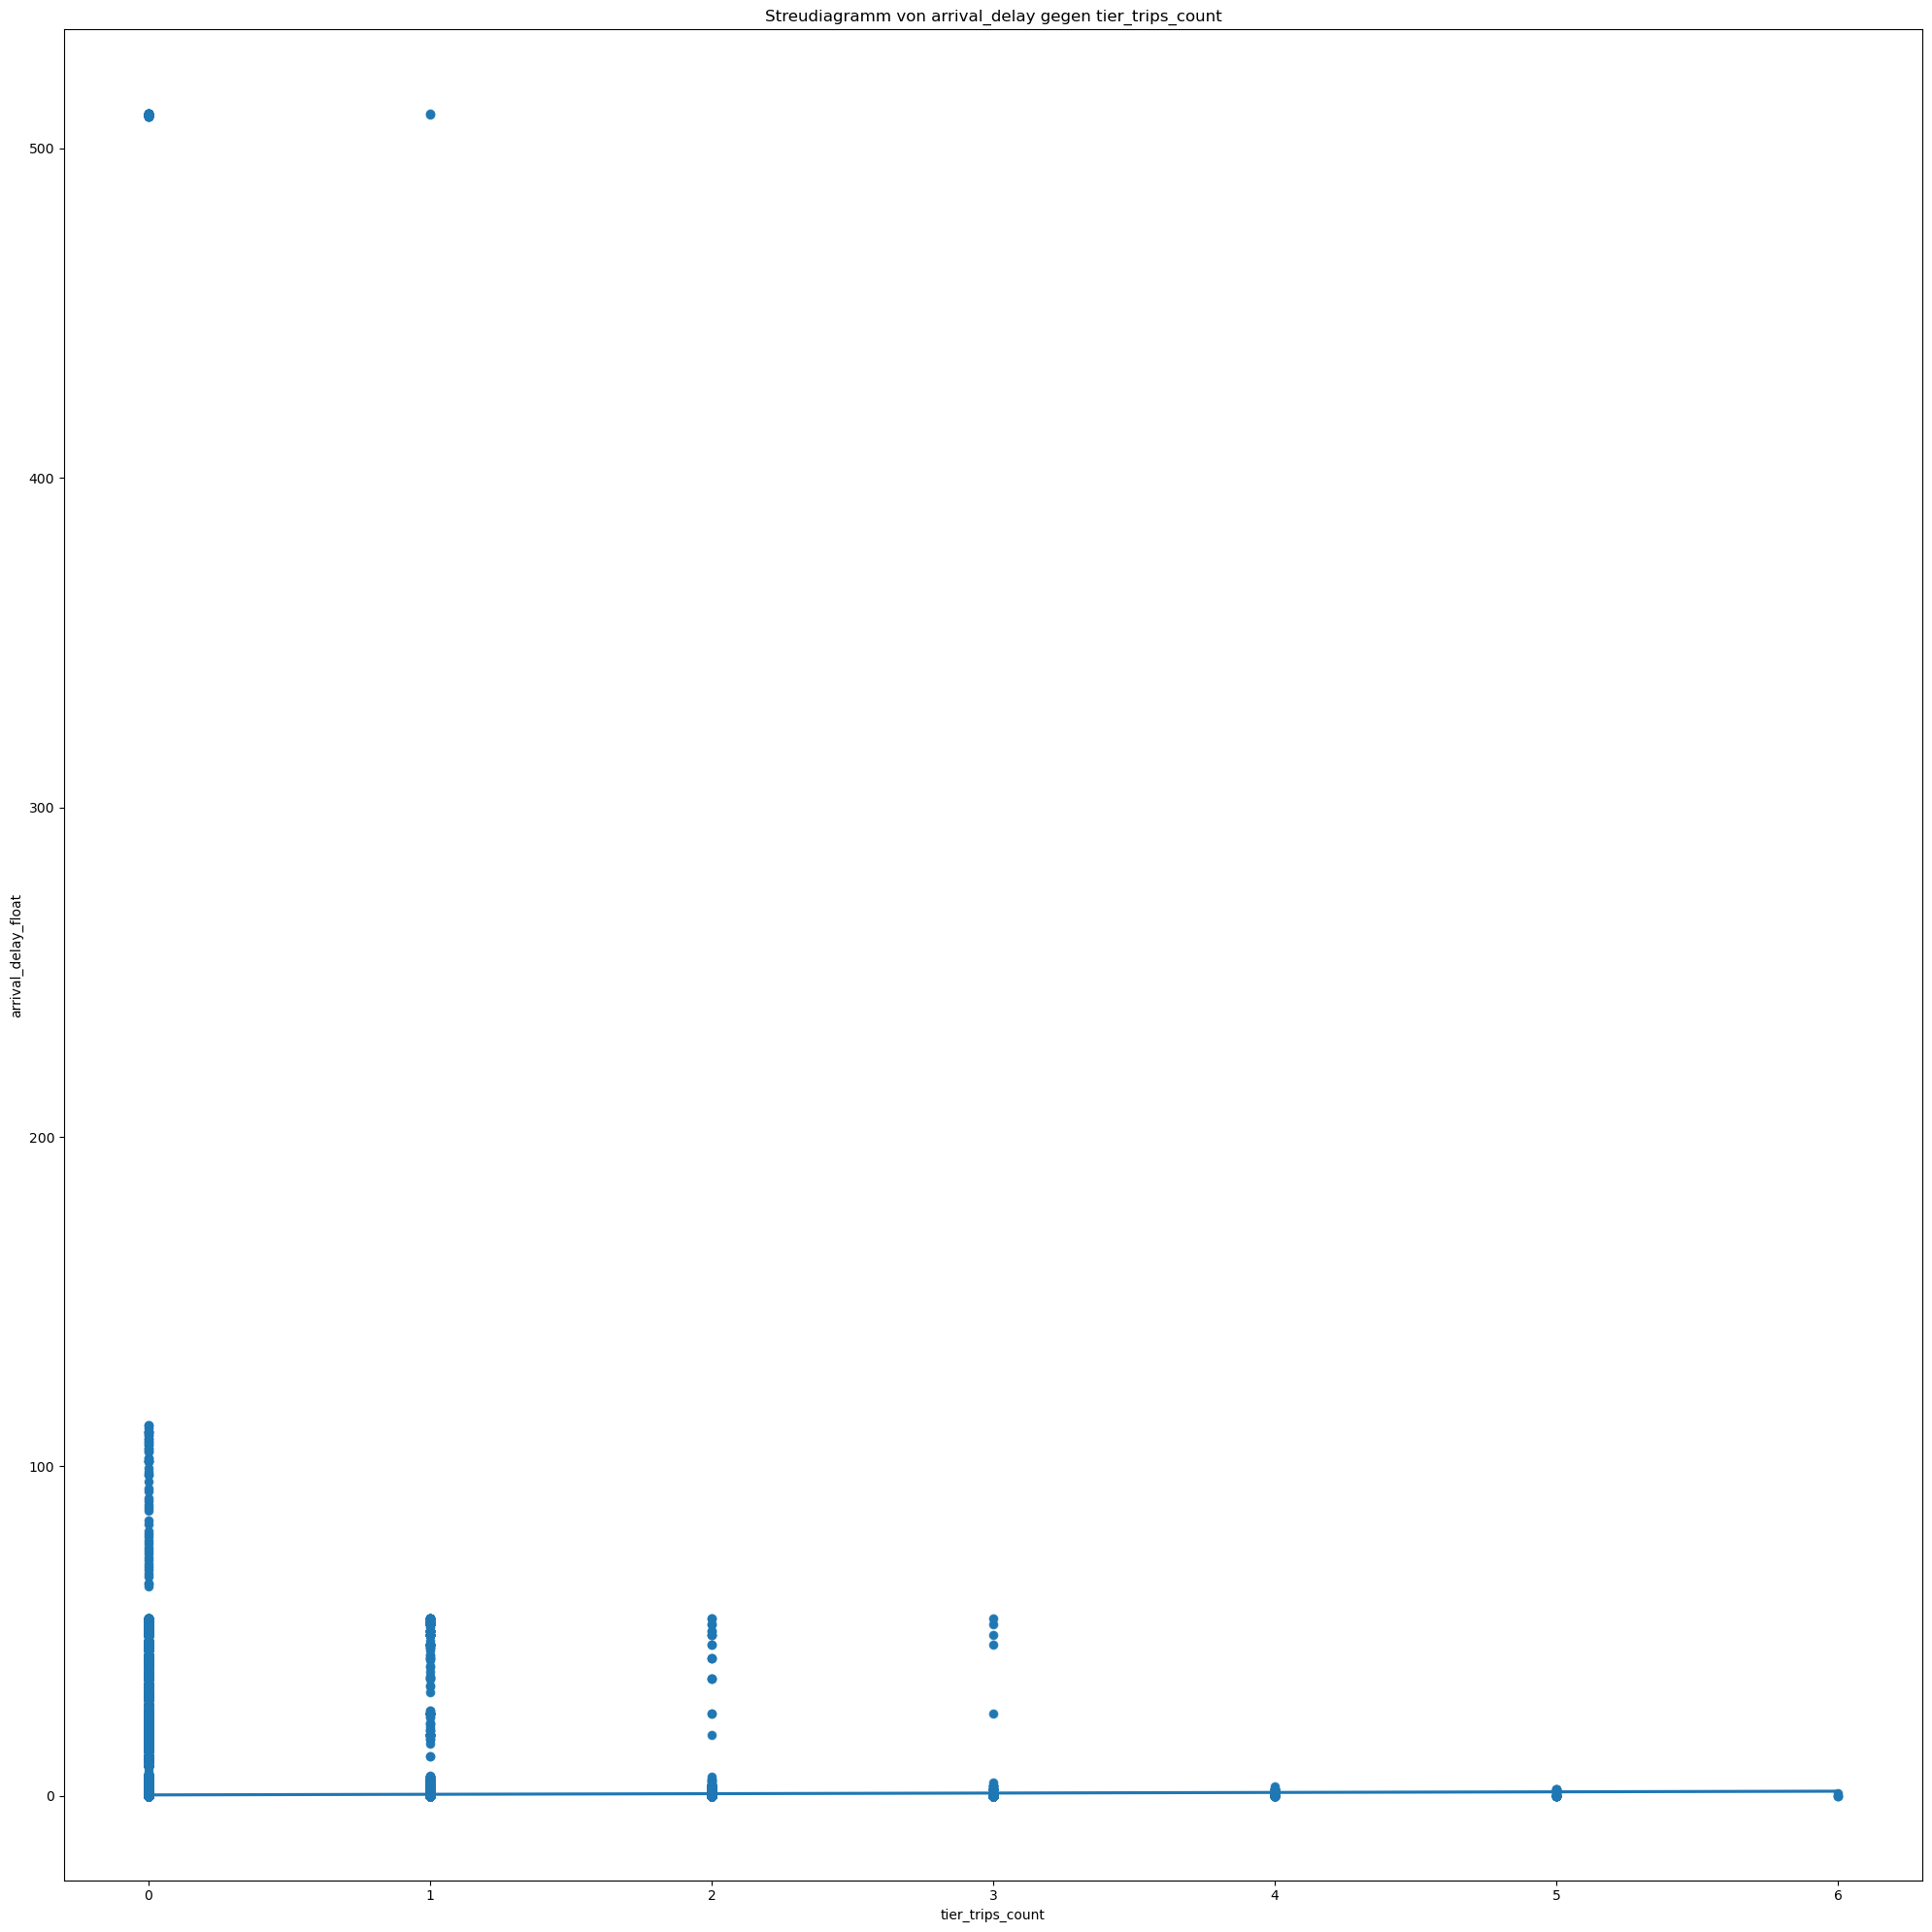

In [48]:
# Zeigt Beziehung zwischen zwei kontinuirlihen Variablen
sns.scatterplot(y='arrival_delay_float', x='tier_trips_count', data=data)
sns.regplot(y ='arrival_delay_float', x='tier_trips_count', data=data, scatter=True)

plt.title('Streudiagramm von arrival_delay gegen tier_trips_count')
plt.show()

In [49]:
g = data.groupby('arrival_delay_float').agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum', 'arrival_delay': 'mean', 'arrival_delay_float' : 'mean'})

In [50]:
g

tier_trips_count  nextbike_trips_count  \
arrival_delay_float                                           
0.000000                        18363                 43523   
0.166667                          142                   784   
0.250000                         2936                  7789   
0.333333                          193                   672   
0.500000                         3510                 10101   
...                               ...                   ...   
112.500000                          0                     0   
509.750000                          0                     0   
510.000000                          0                     0   
510.250000                          1                     0   
510.500000                          1                     0   

                                arrival_delay  arrival_delay_float  
arrival_delay_float                                                 
0.000000            0 days 00:00:04.714449980             0.000000  
0.166667                      0 days 00:00:10             0.166667  
0.250000                      0 days 00:00:15             0.250000  
0.333333                      0 days 00:00:20             0.333333  
0.500000                      0 days 00:00:30             0.500000  
...                                       ...                  ...  
112.500000                    0 days 01:52:30           112.500000  
509.750000                    0 days 08:29:45           509.750000  
510.000000                    0 days 08:30:00           510.000000  
510.250000                    0 days 08:30:15           510.250000  
510.500000                    0 days 08:30:30           510.500000  

[182 rows x 4 columns]

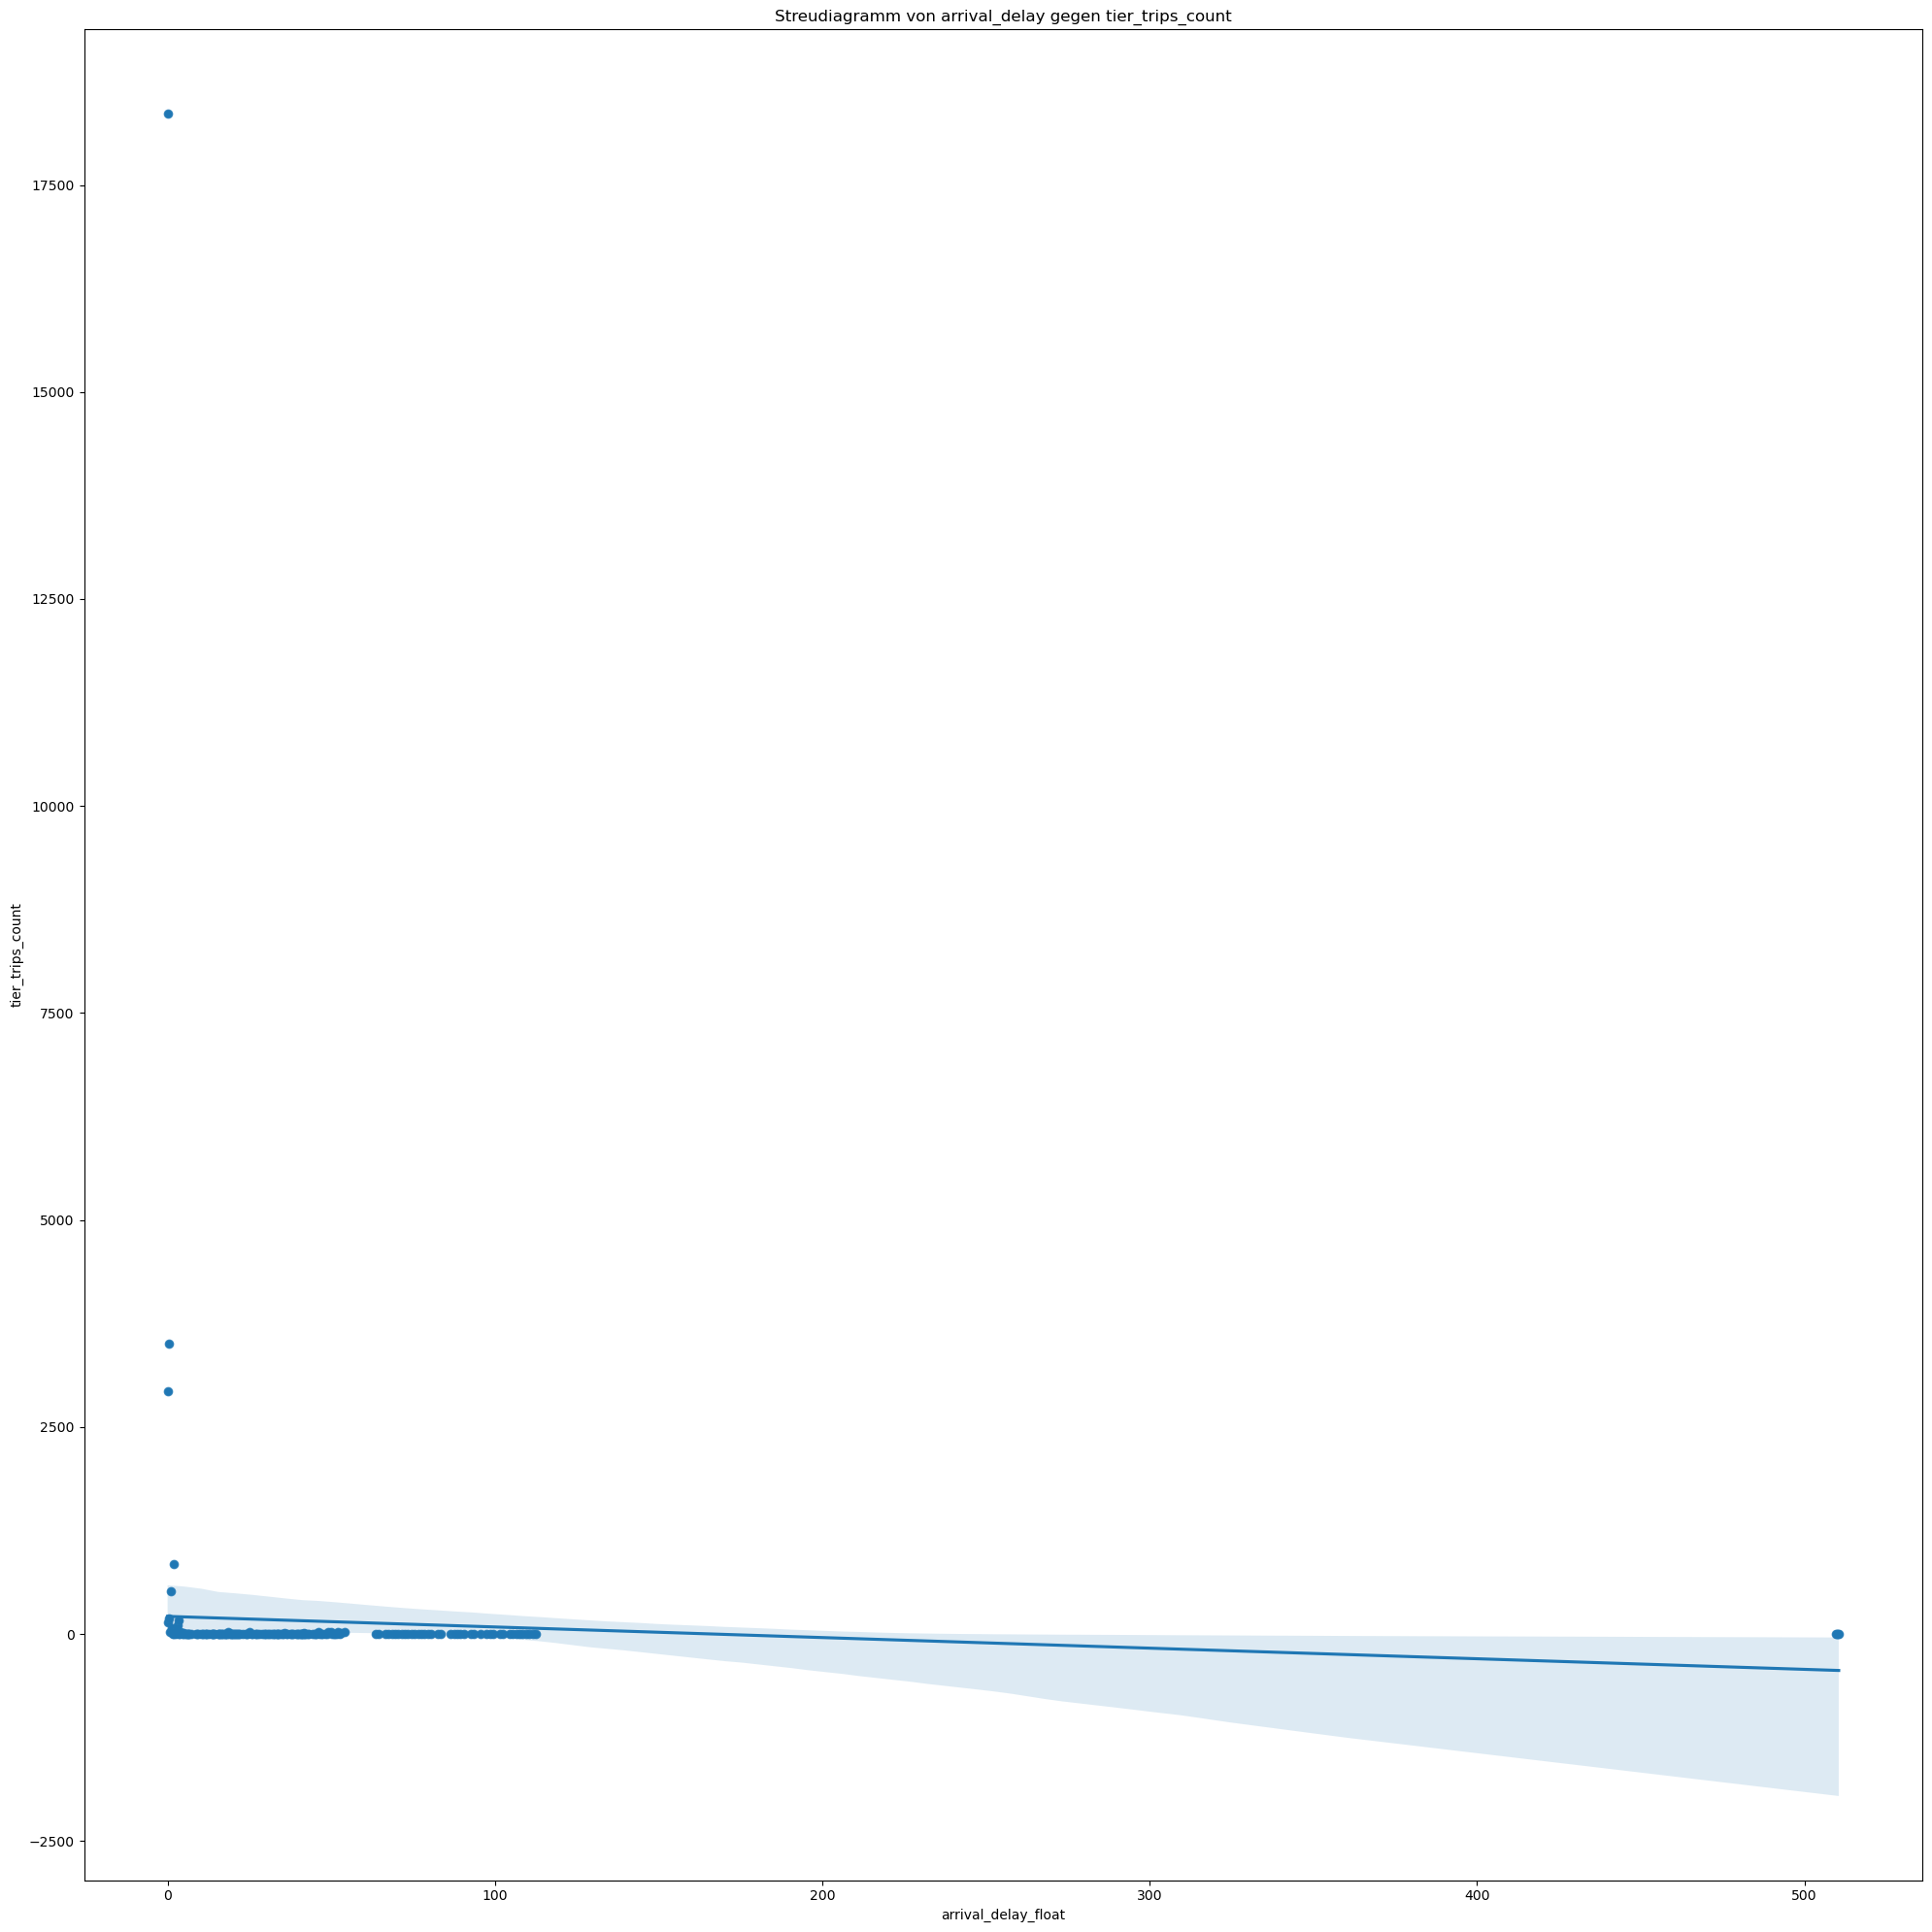

In [51]:
# Zeigt Beziehung zwischen zwei kontinuirlihen Variablen
sns.scatterplot(x='arrival_delay_float', y='tier_trips_count', data=g)
sns.regplot(x ='arrival_delay_float', y='tier_trips_count', data=g, scatter=True)

plt.title('Streudiagramm von arrival_delay gegen tier_trips_count')
plt.show()

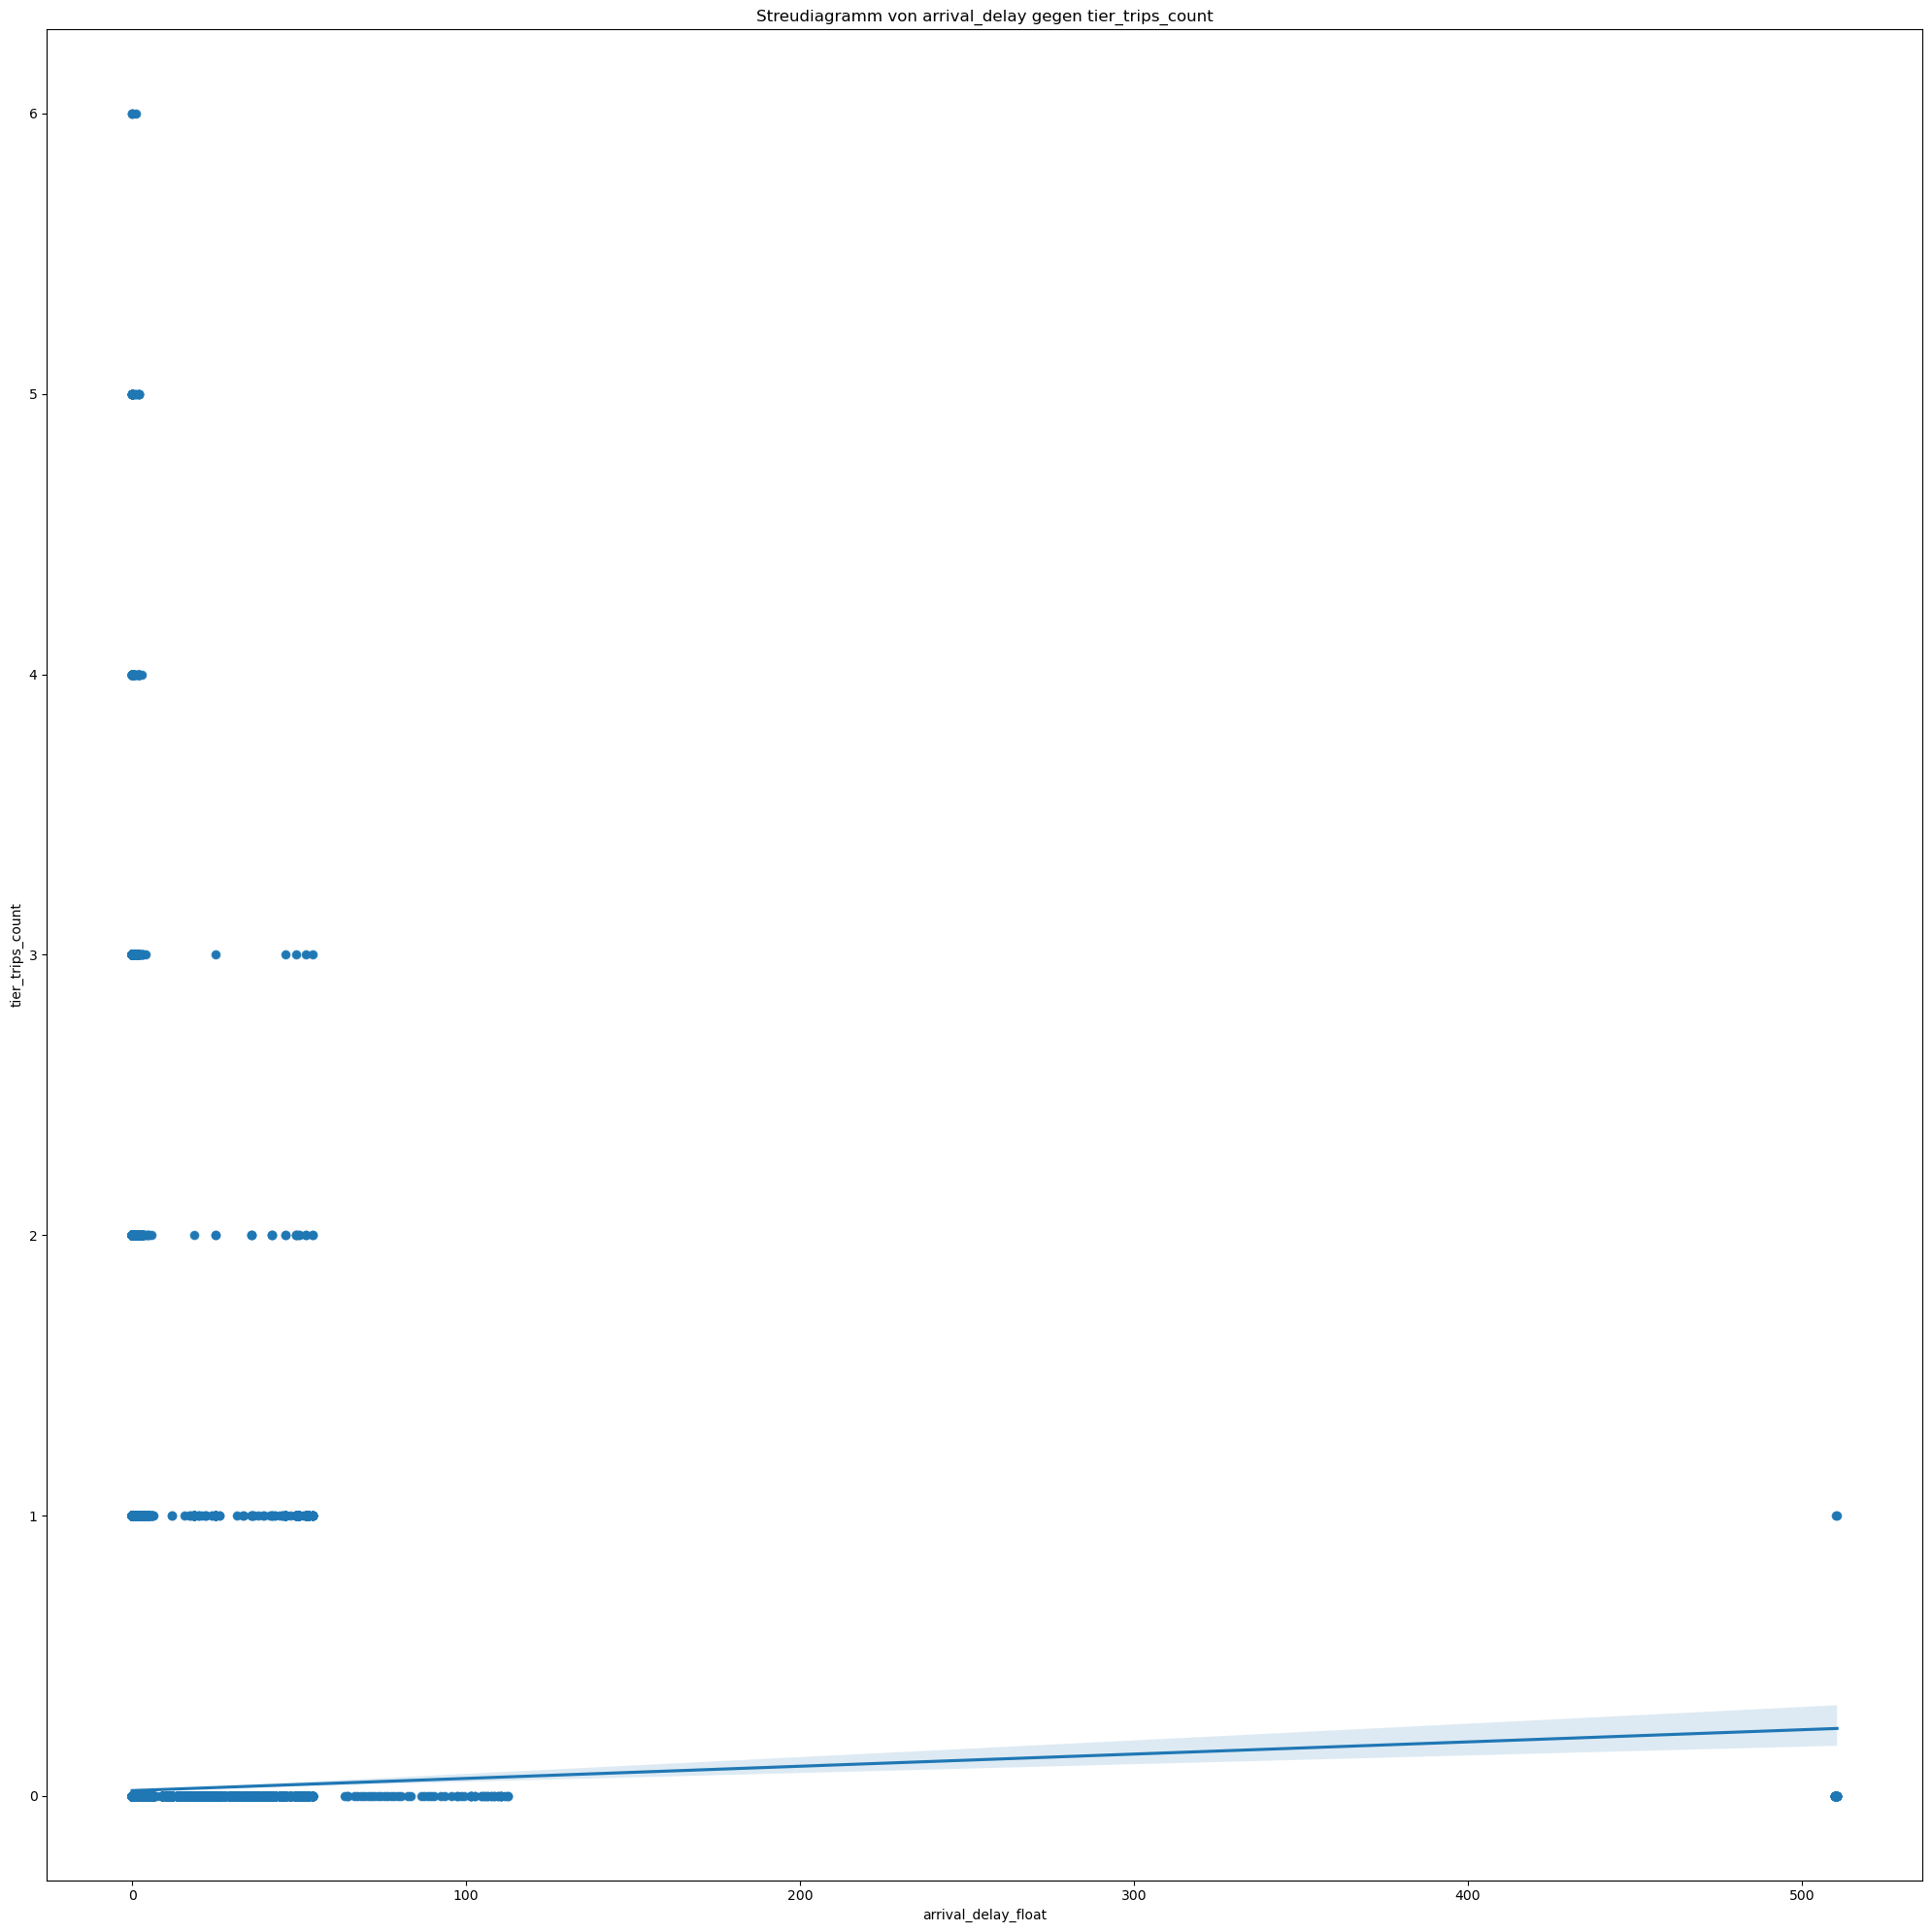

In [52]:
# Zeigt Beziehung zwischen zwei kontinuirlihen Variablen
sns.scatterplot(x='arrival_delay_float', y='tier_trips_count', data=data)
sns.regplot(x ='arrival_delay_float', y='tier_trips_count', data=data, scatter=True)

plt.title('Streudiagramm von arrival_delay gegen tier_trips_count')
plt.show()

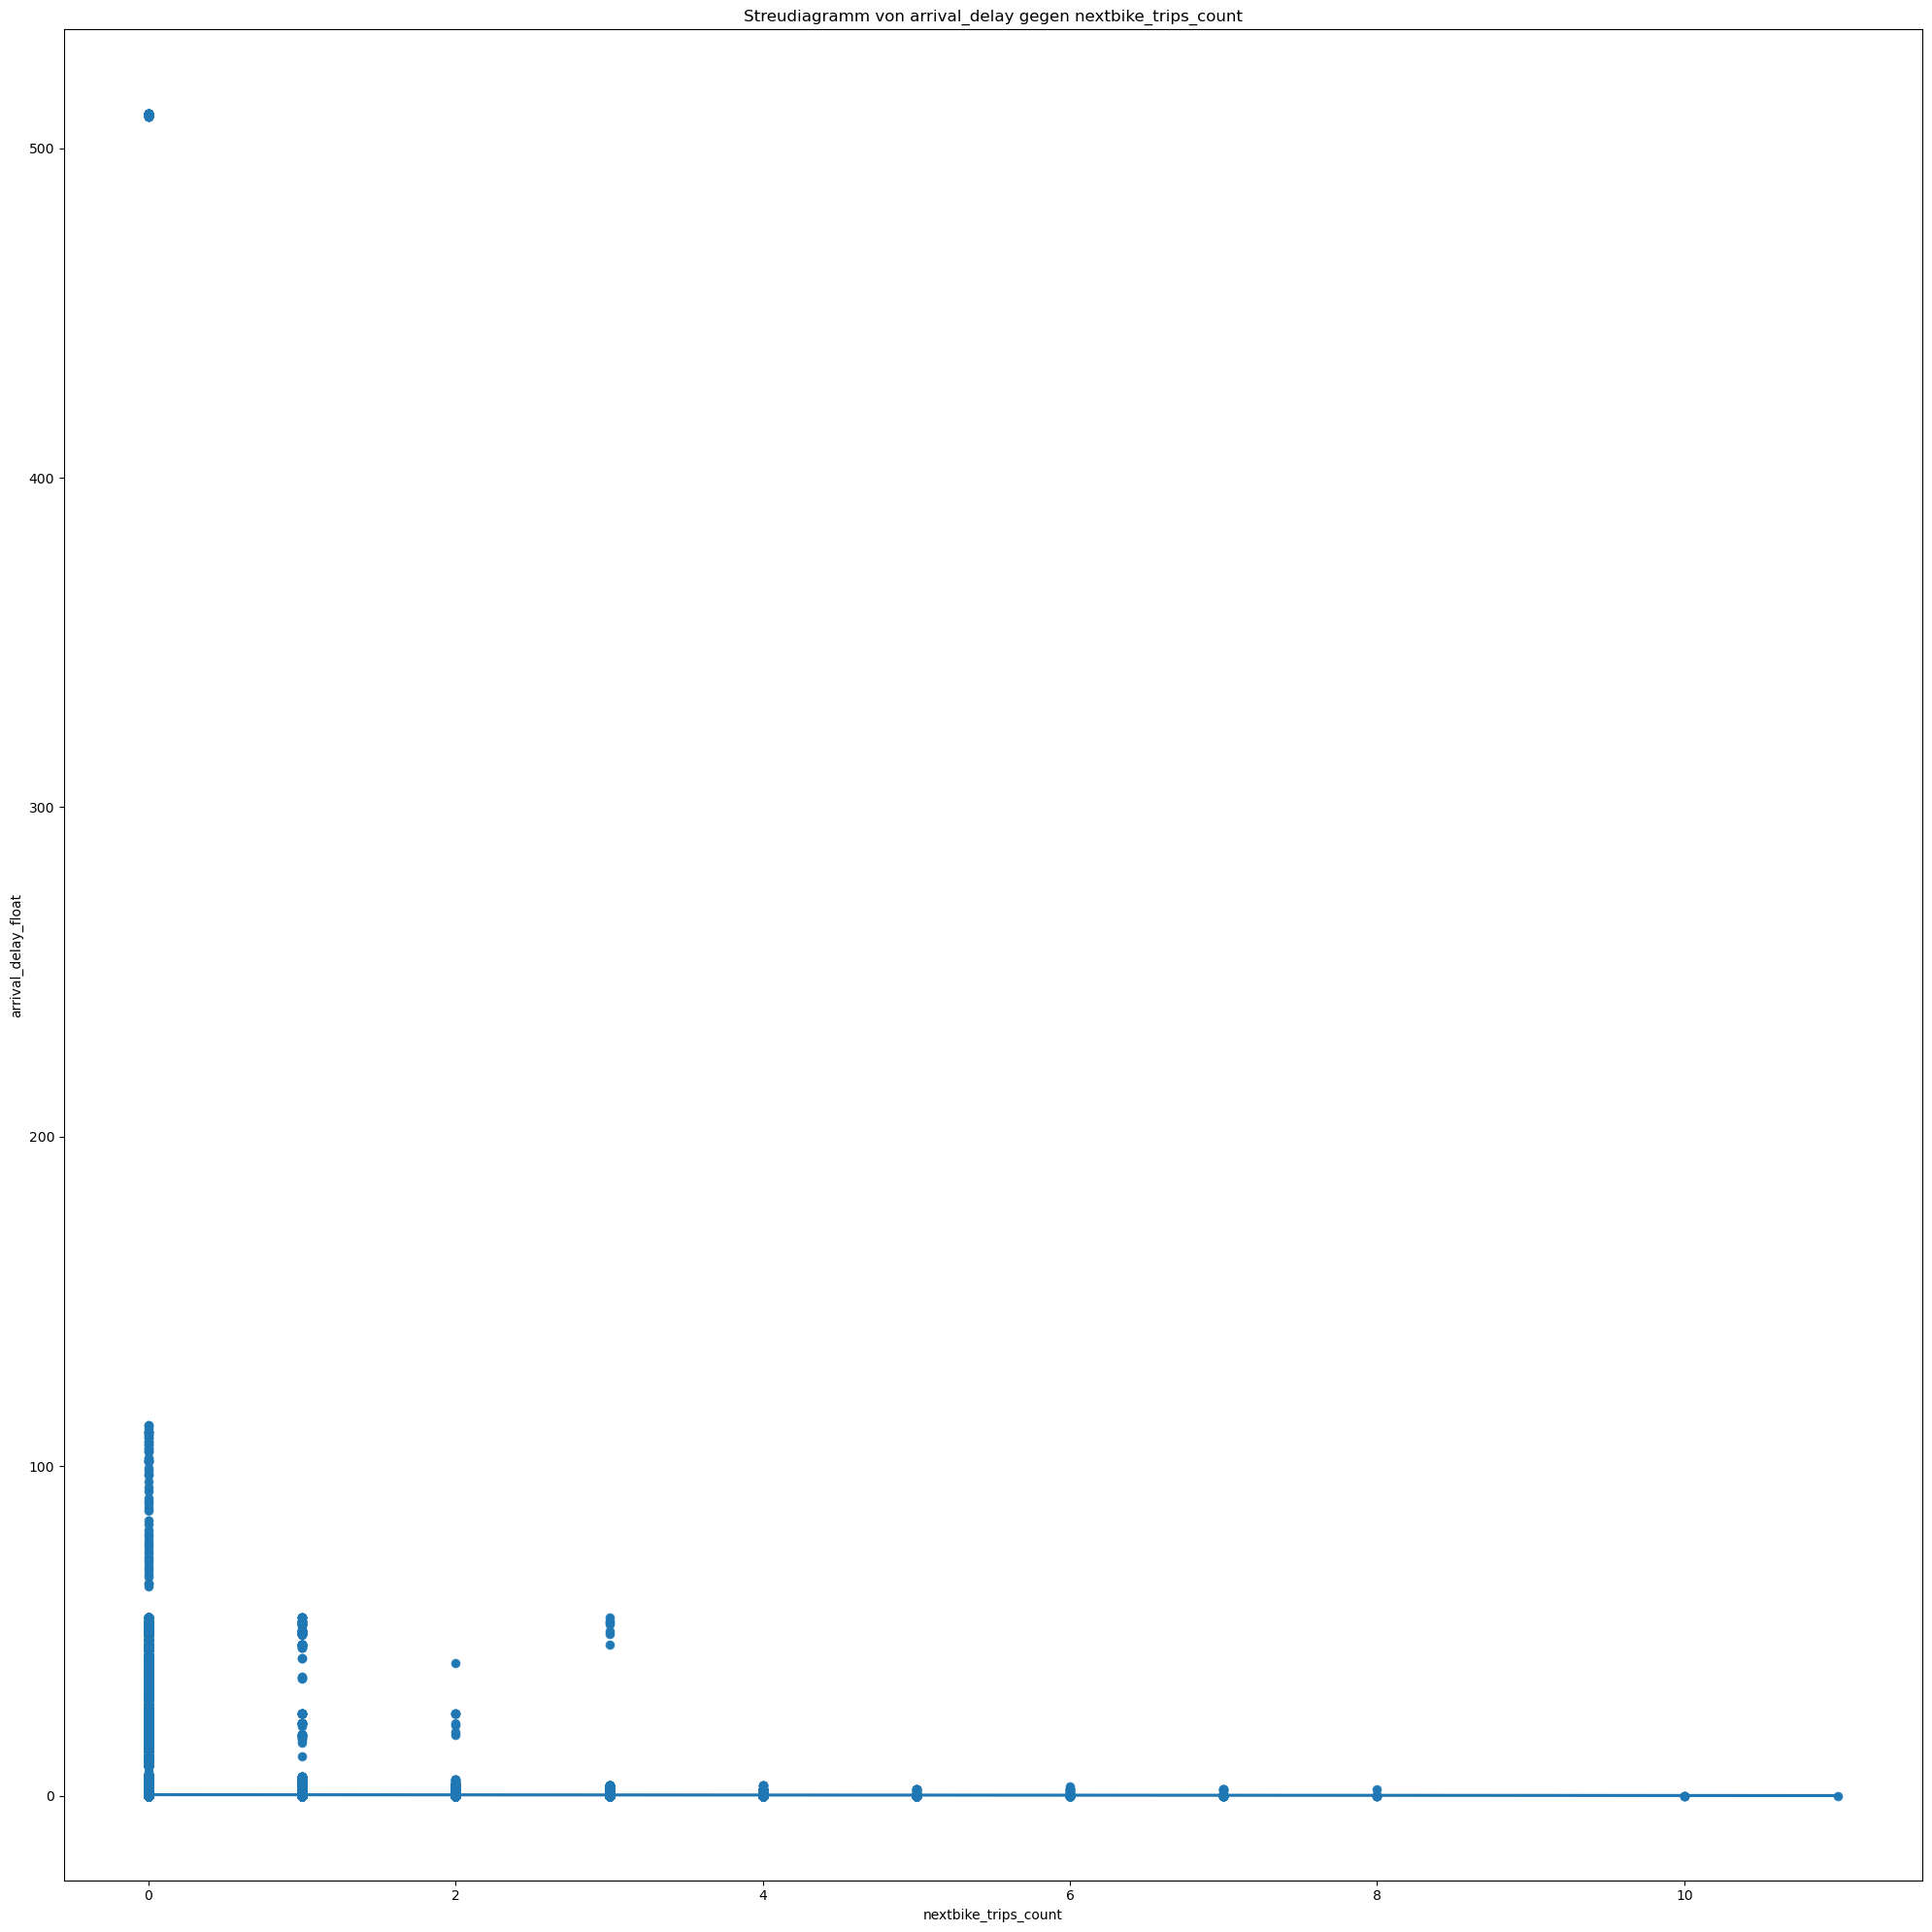

In [53]:
# Zeigt Beziehung zwischen zwei kontinuirlihen Variablen
sns.scatterplot(y='arrival_delay_float', x='nextbike_trips_count', data=data)
sns.regplot(y ='arrival_delay_float', x='nextbike_trips_count', data=data, scatter=True)

plt.title('Streudiagramm von arrival_delay gegen nextbike_trips_count')
plt.show()

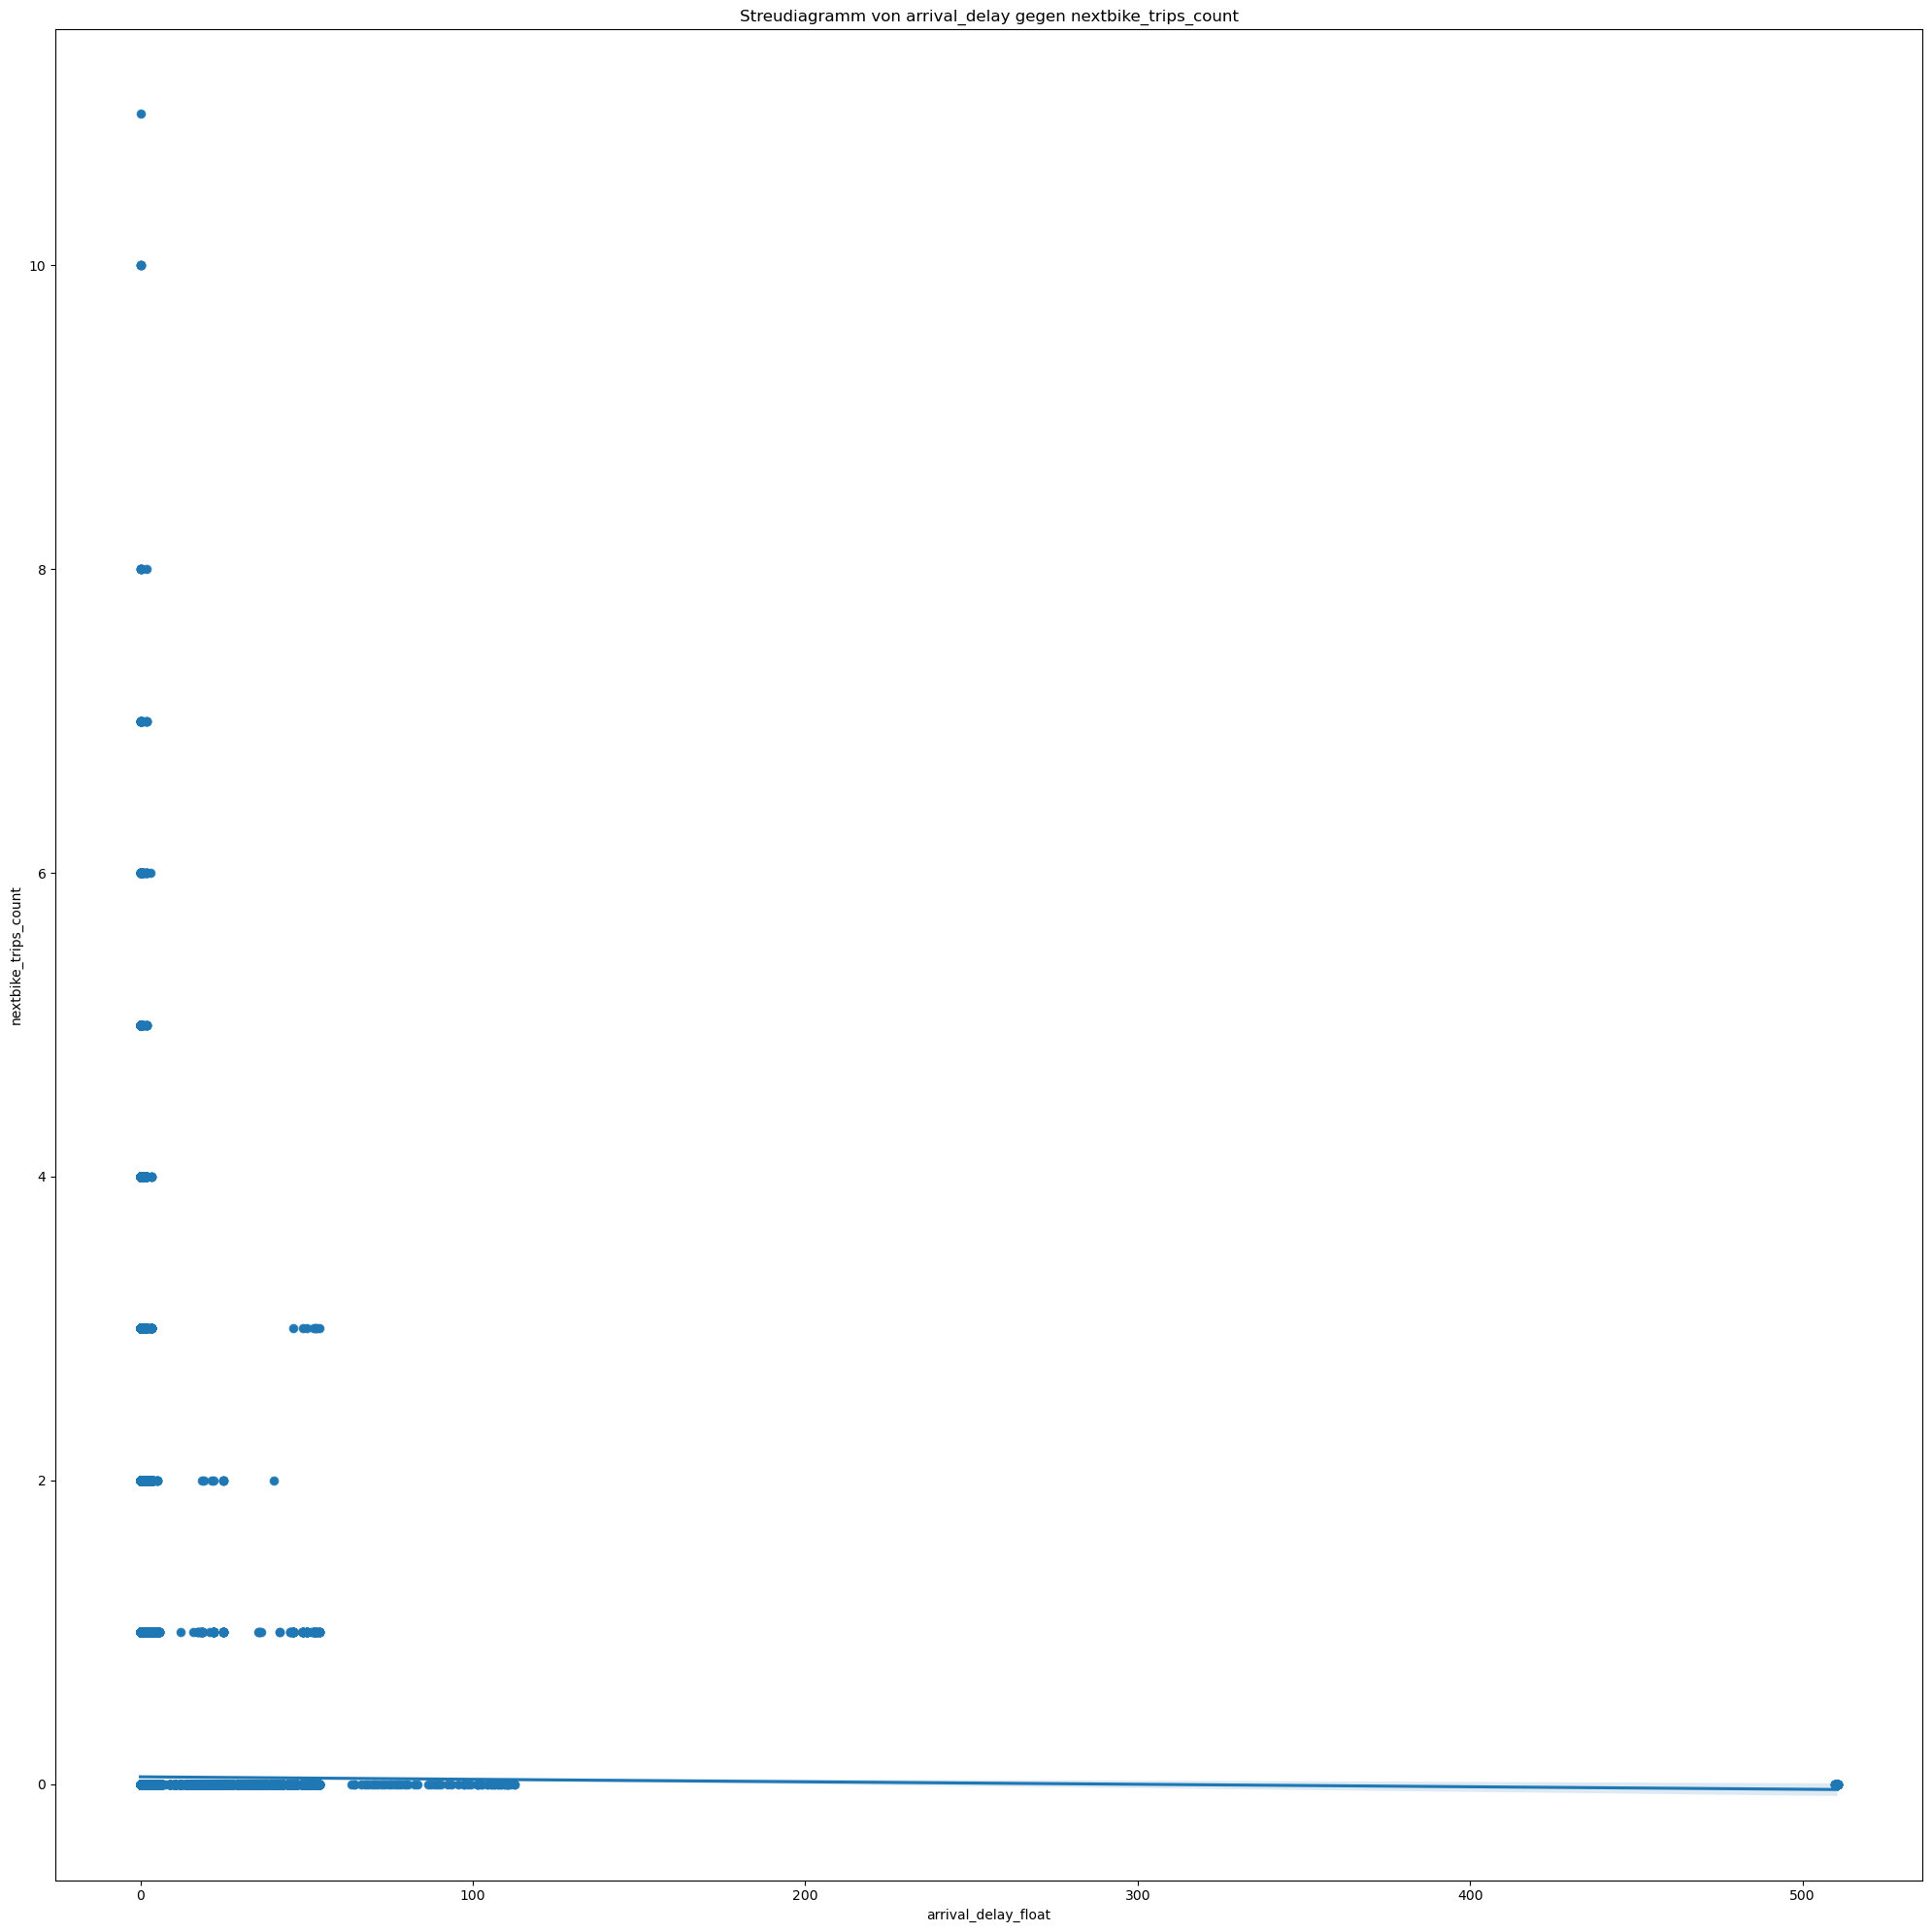

In [54]:
# Zeigt Beziehung zwischen zwei kontinuirlihen Variablen
sns.scatterplot(x='arrival_delay_float', y='nextbike_trips_count', data=data)
sns.regplot(x ='arrival_delay_float', y='nextbike_trips_count', data=data, scatter=True)

plt.title('Streudiagramm von arrival_delay gegen nextbike_trips_count')
plt.show()

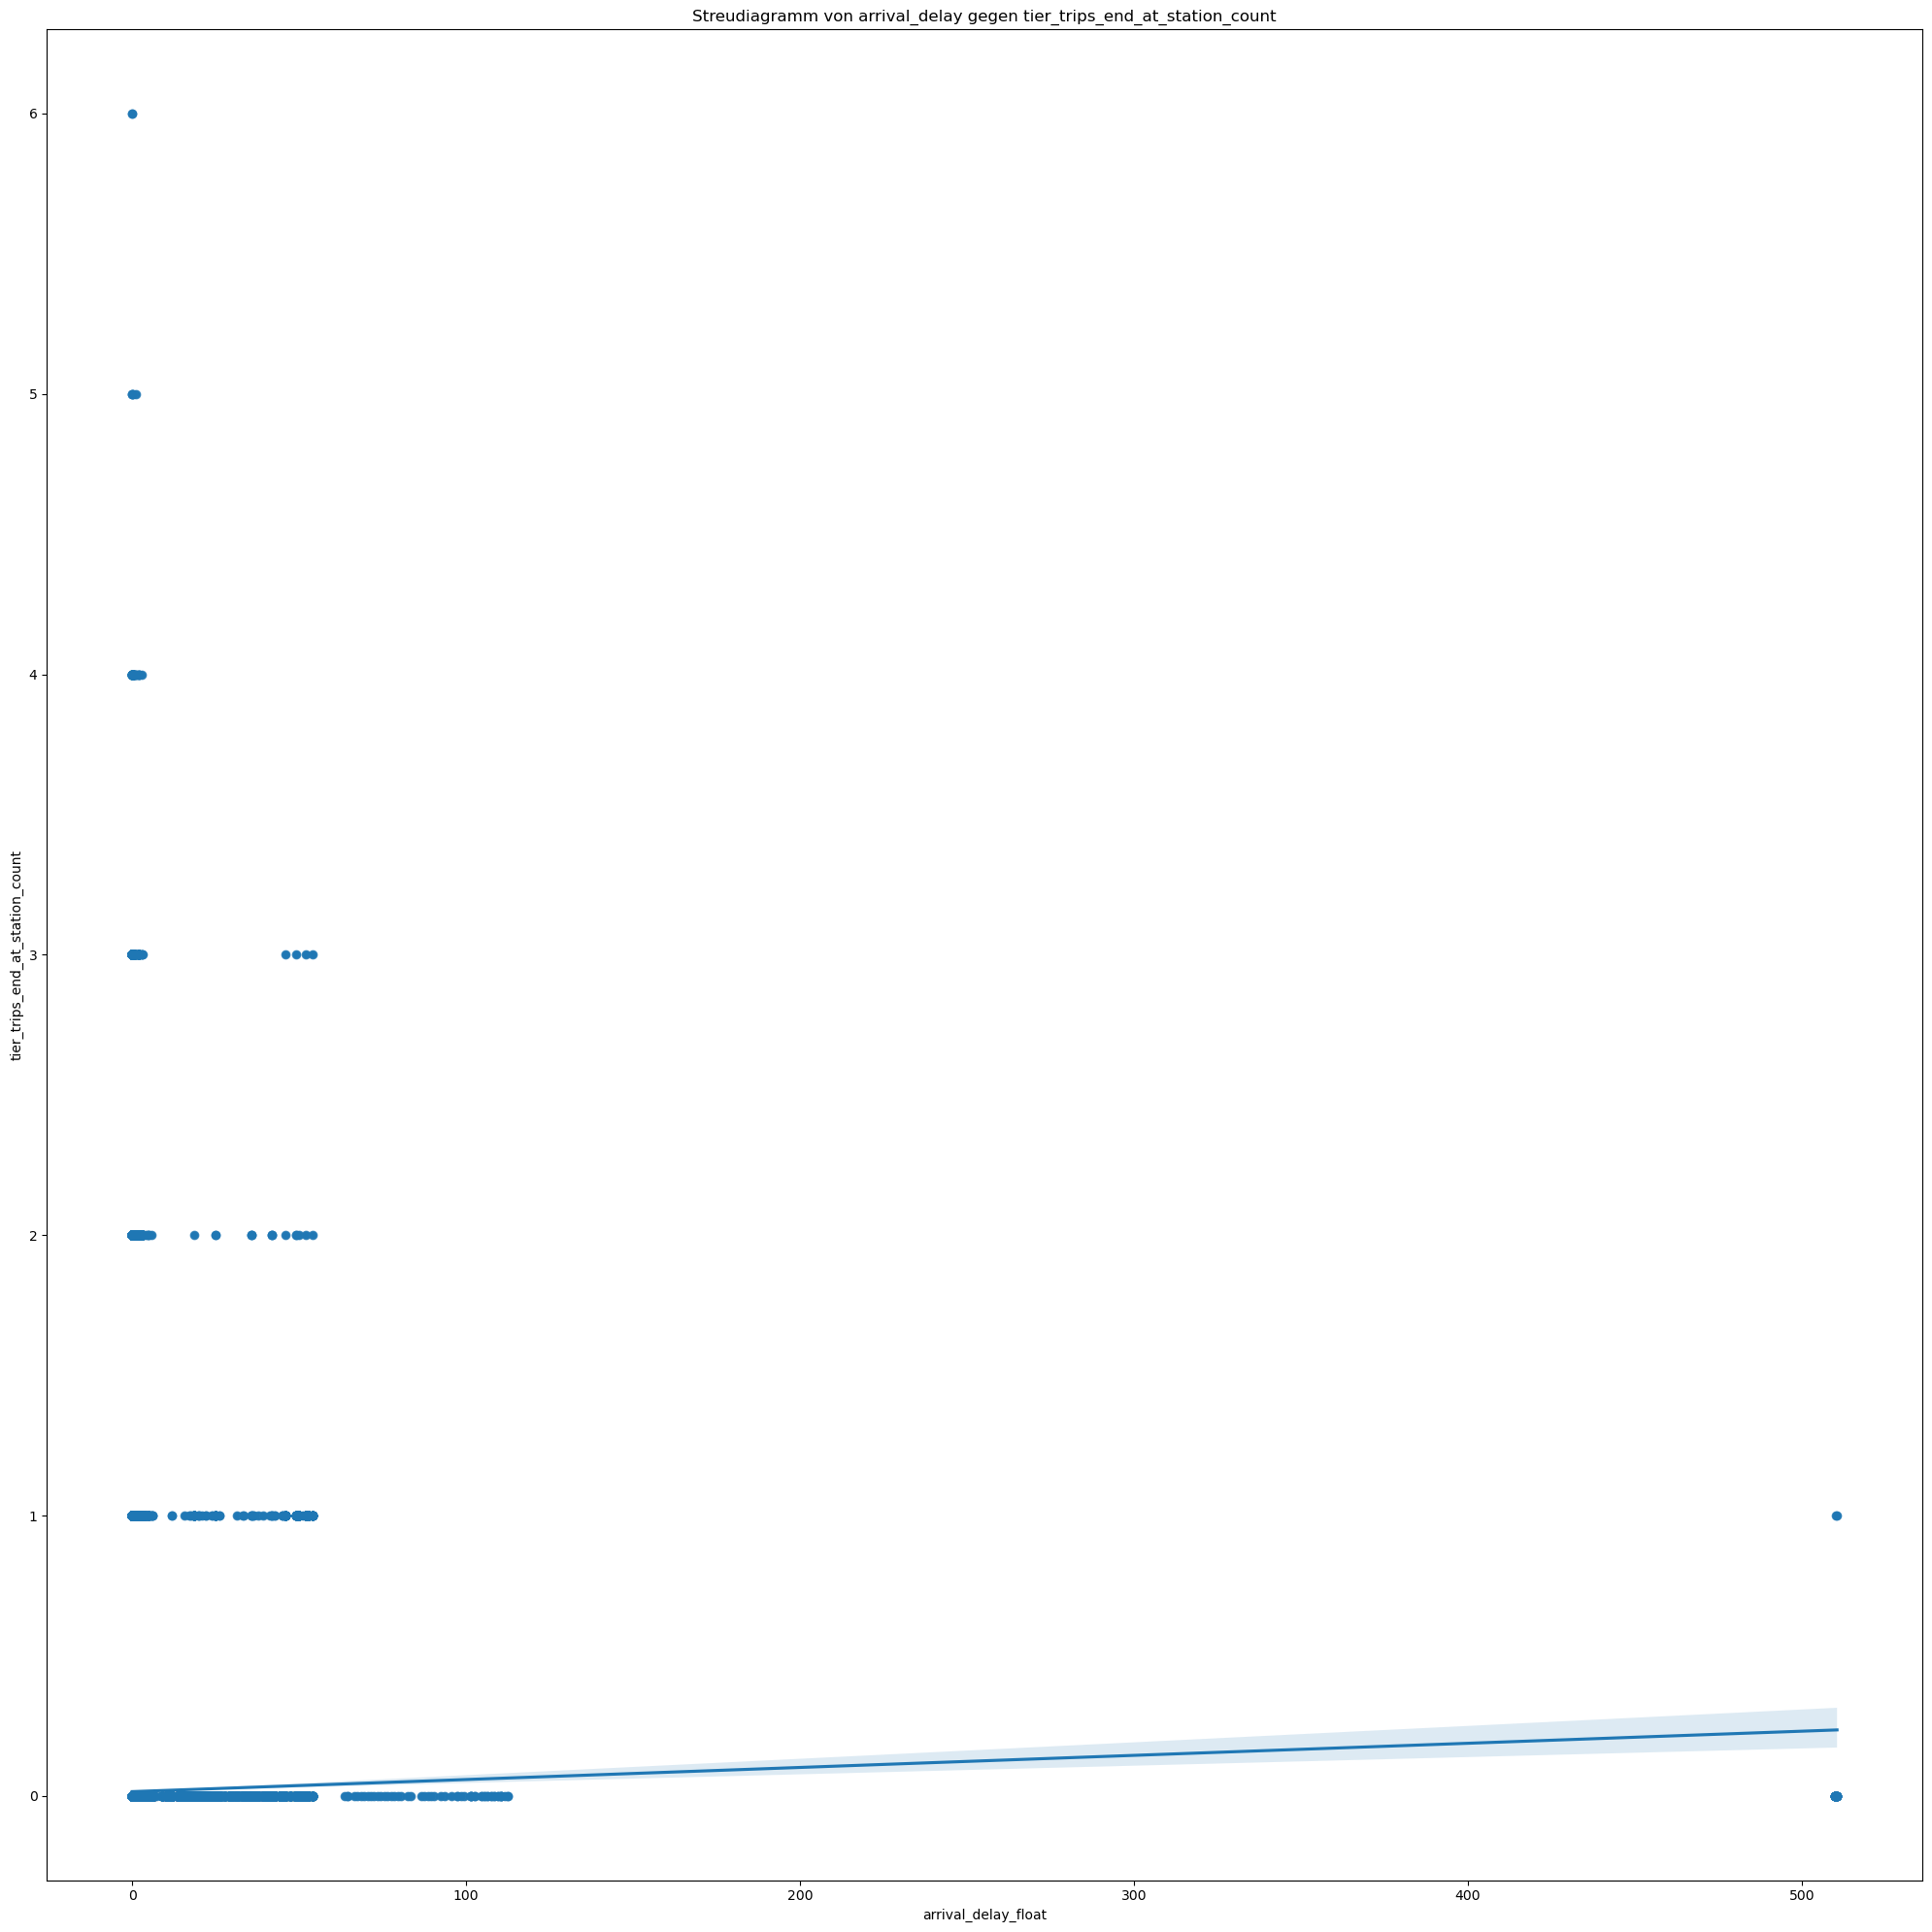

In [55]:
# Zeigt Beziehung zwischen zwei kontinuirlihen Variablen
sns.scatterplot(x='arrival_delay_float', y='tier_trips_end_at_station_count', data=data)
sns.regplot(x ='arrival_delay_float', y='tier_trips_end_at_station_count', data=data, scatter=True)

plt.title('Streudiagramm von arrival_delay gegen tier_trips_end_at_station_count')
plt.show()

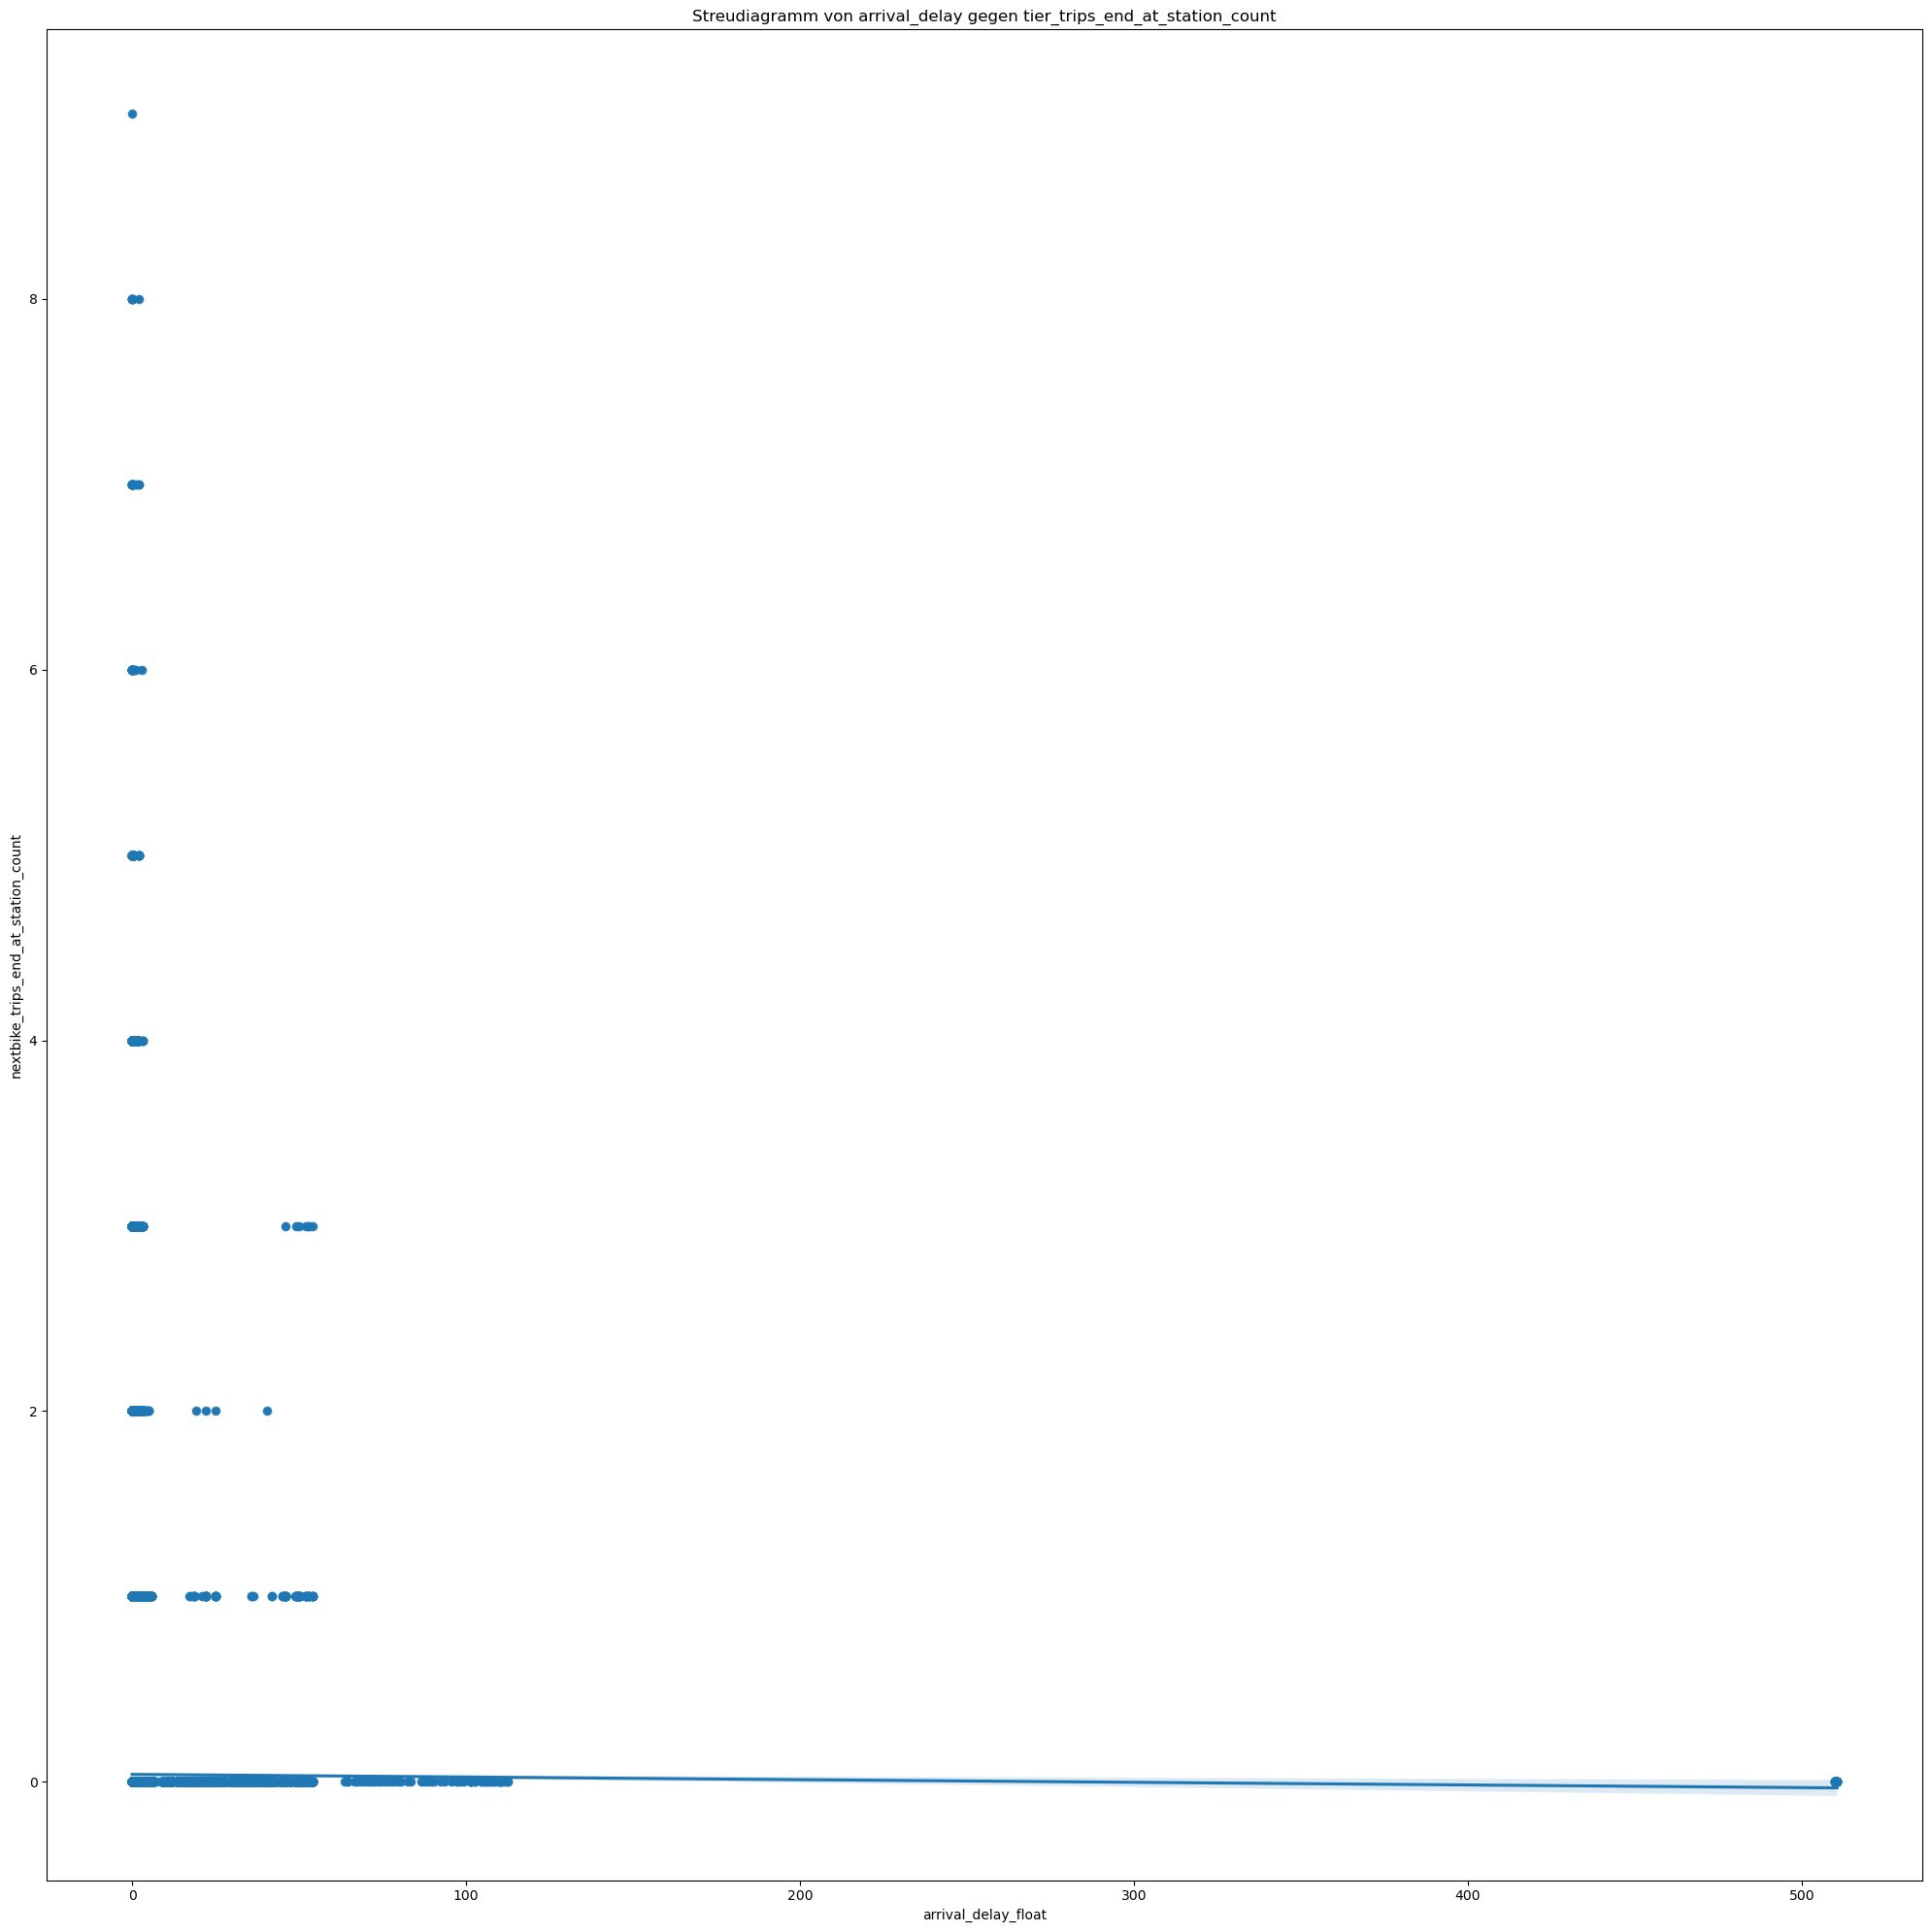

In [56]:
# Zeigt Beziehung zwischen zwei kontinuirlihen Variablen
sns.scatterplot(x='arrival_delay_float', y='nextbike_trips_end_at_station_count', data=data)
sns.regplot(x ='arrival_delay_float', y='nextbike_trips_end_at_station_count', data=data, scatter=True)

plt.title('Streudiagramm von arrival_delay gegen tier_trips_end_at_station_count')
plt.show()

### Timeframes & Changes during the day

#### Time_Span

##### Ohne Delay

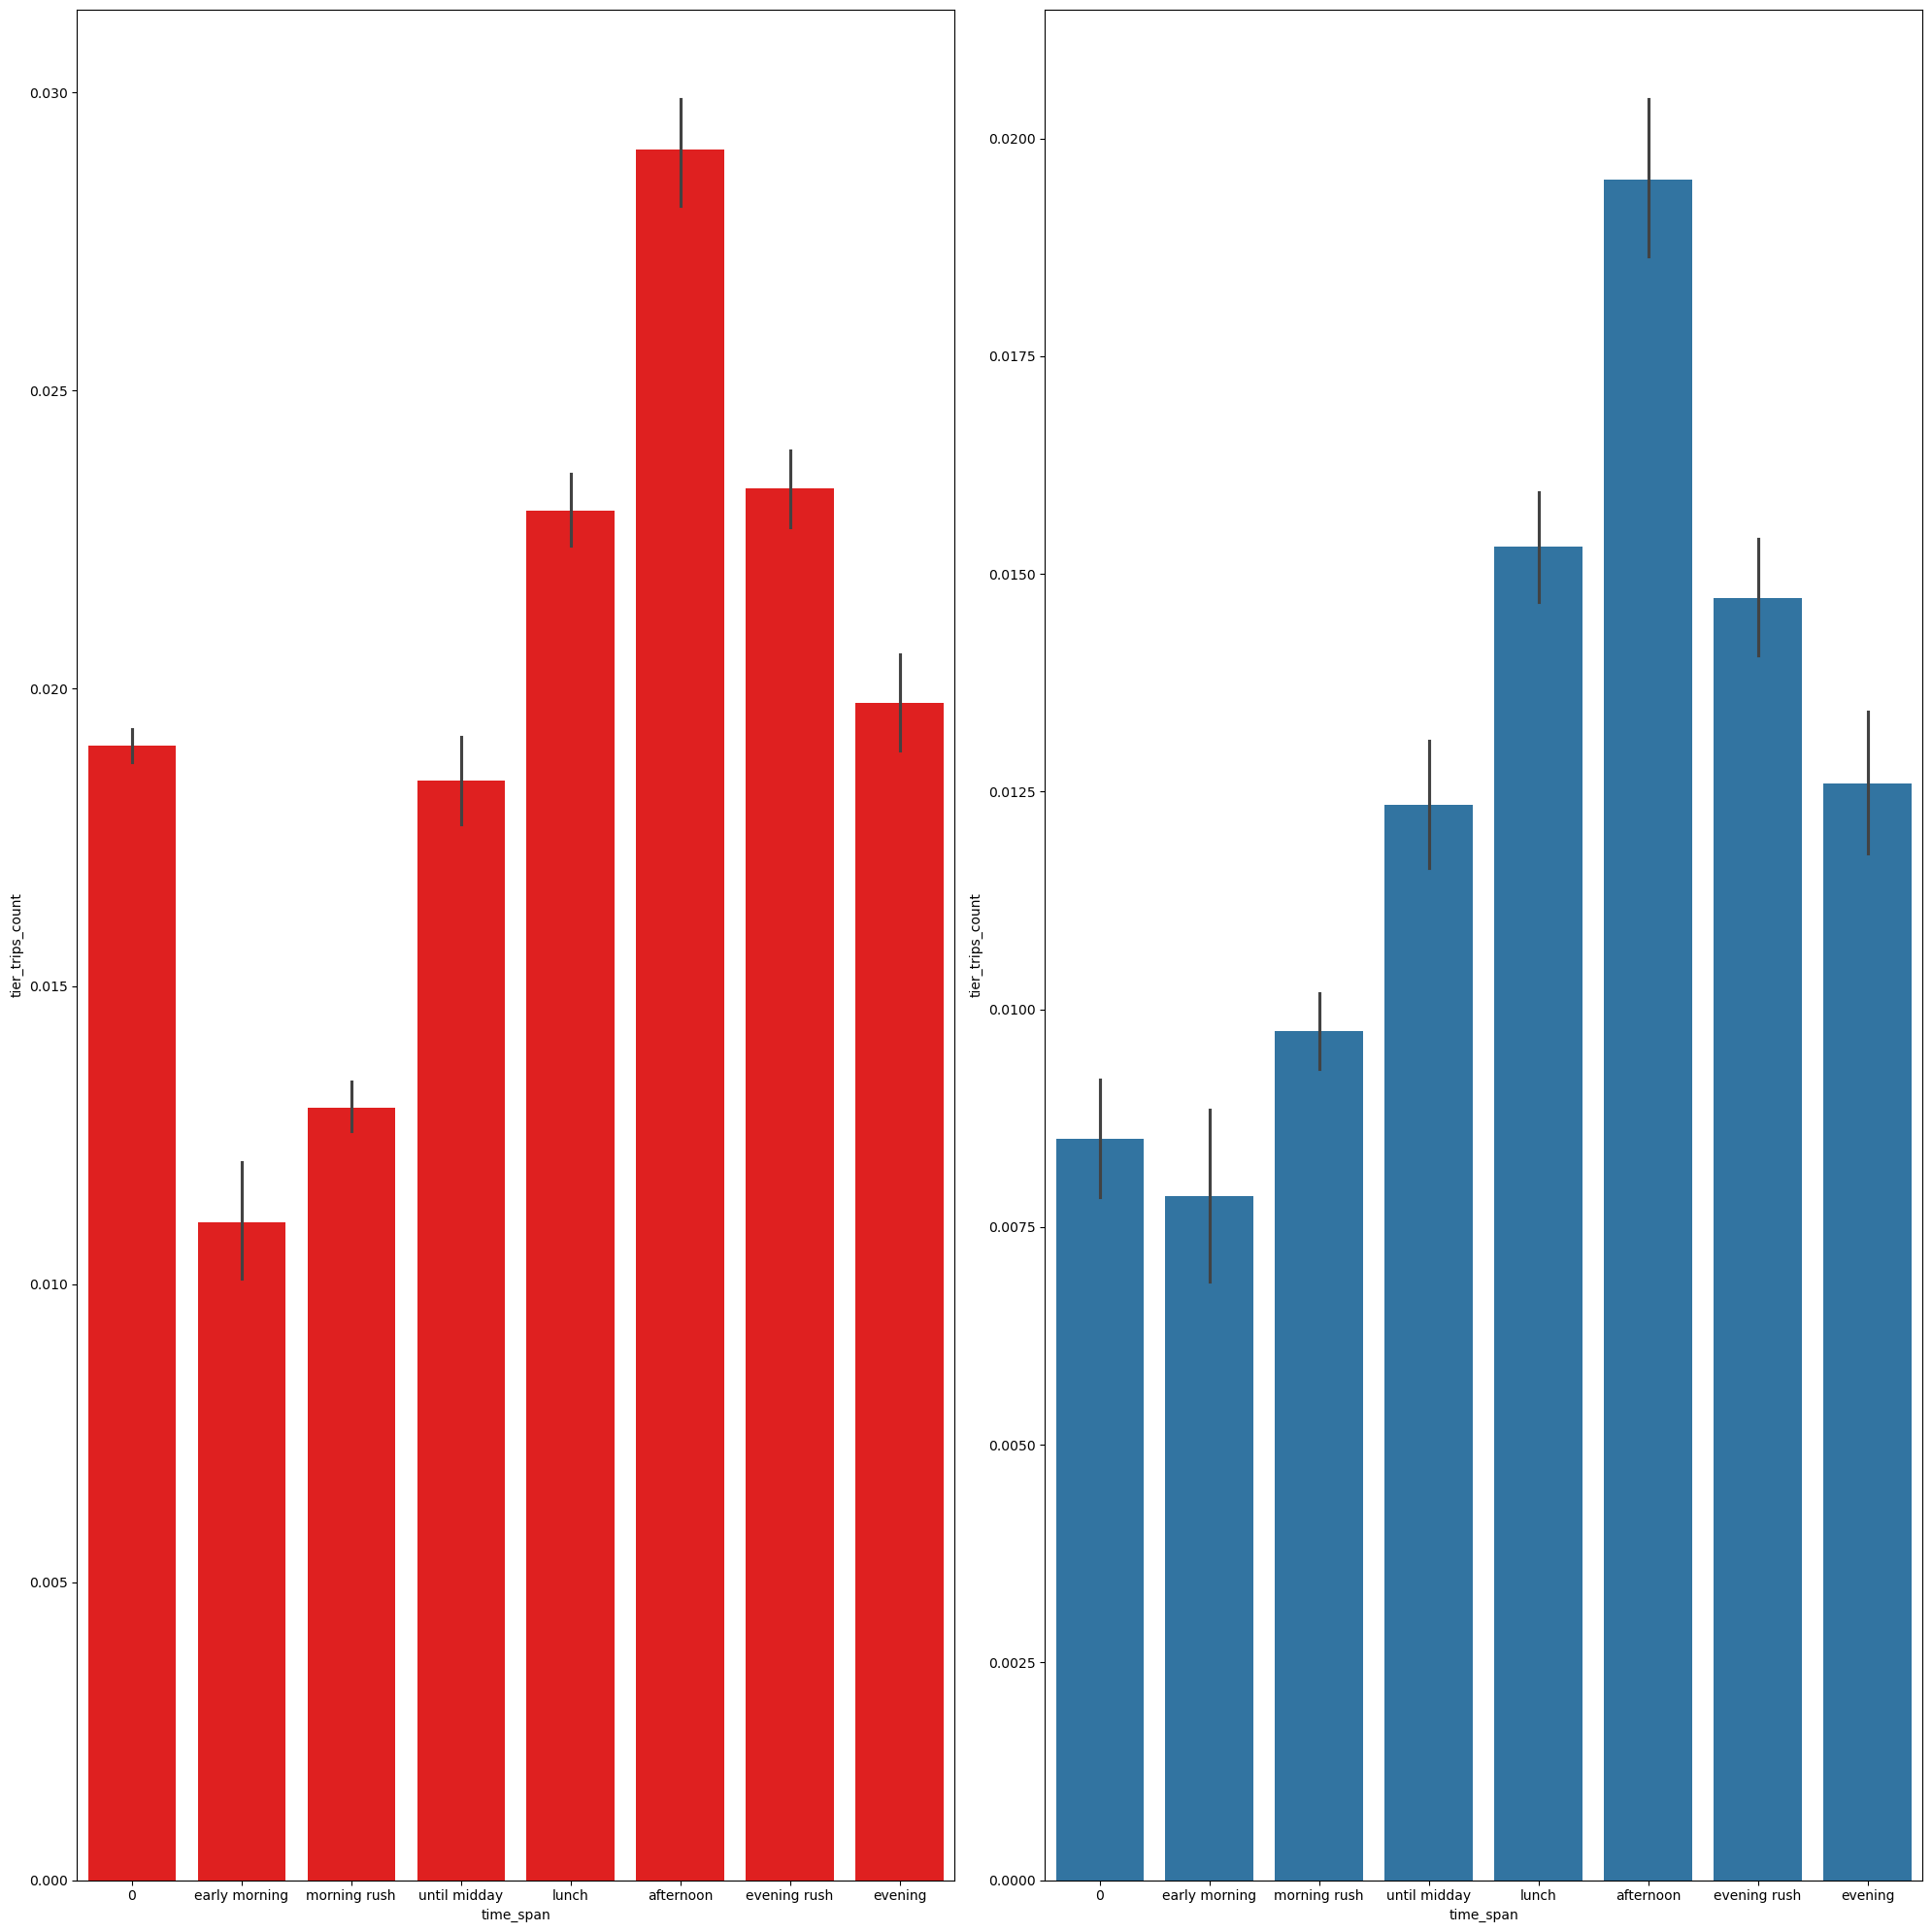

In [57]:
# Mean Tier Data Delay
f, axes = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data, x="time_span", y="tier_trips_count", ax=axes[0], color='Red')
sns.barplot(delay, x="time_span", y="tier_trips_count", ax=axes[1])
plt.show()

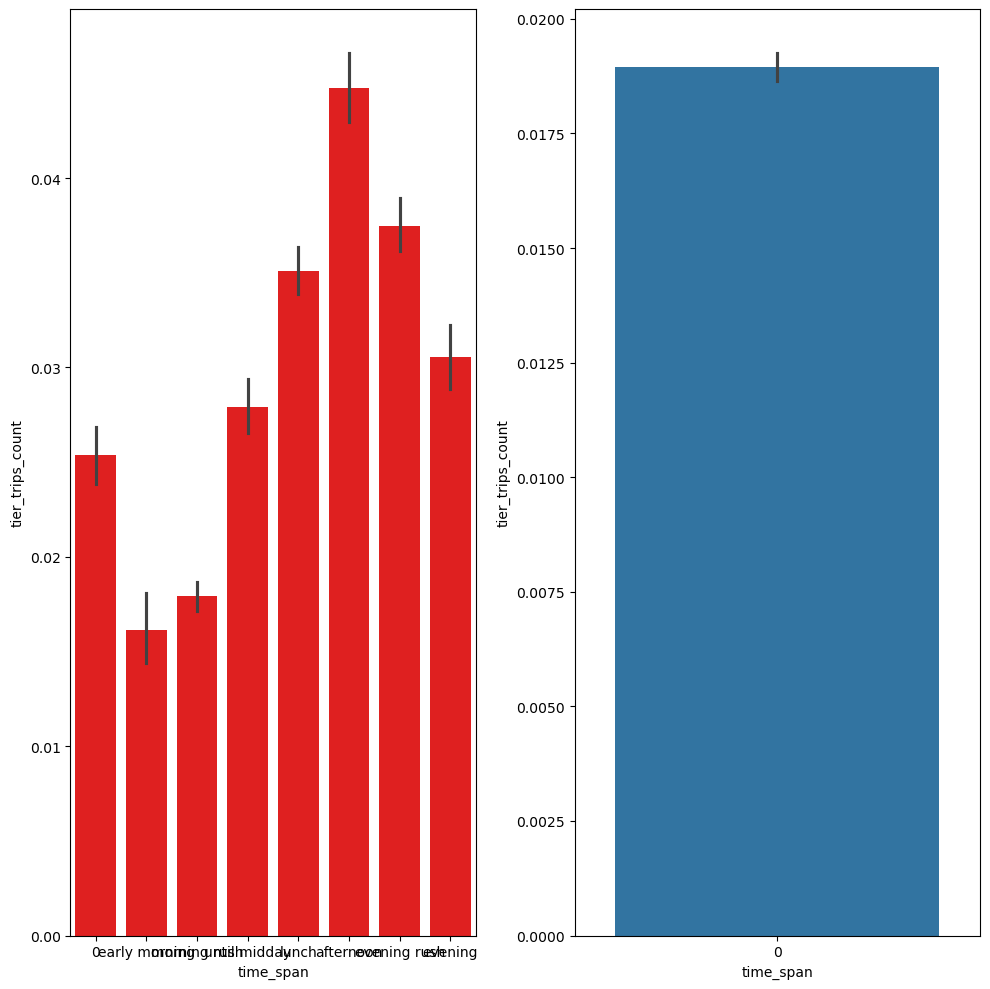

In [58]:
# Mean Tier No_Delay Nan_Delay
f, axes = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = [20.00, 20.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(no_delay, x="time_span", y="tier_trips_count", ax=axes[0], color='Red')
sns.barplot(nan_delay, x="time_span", y="tier_trips_count", ax=axes[1])
plt.show()

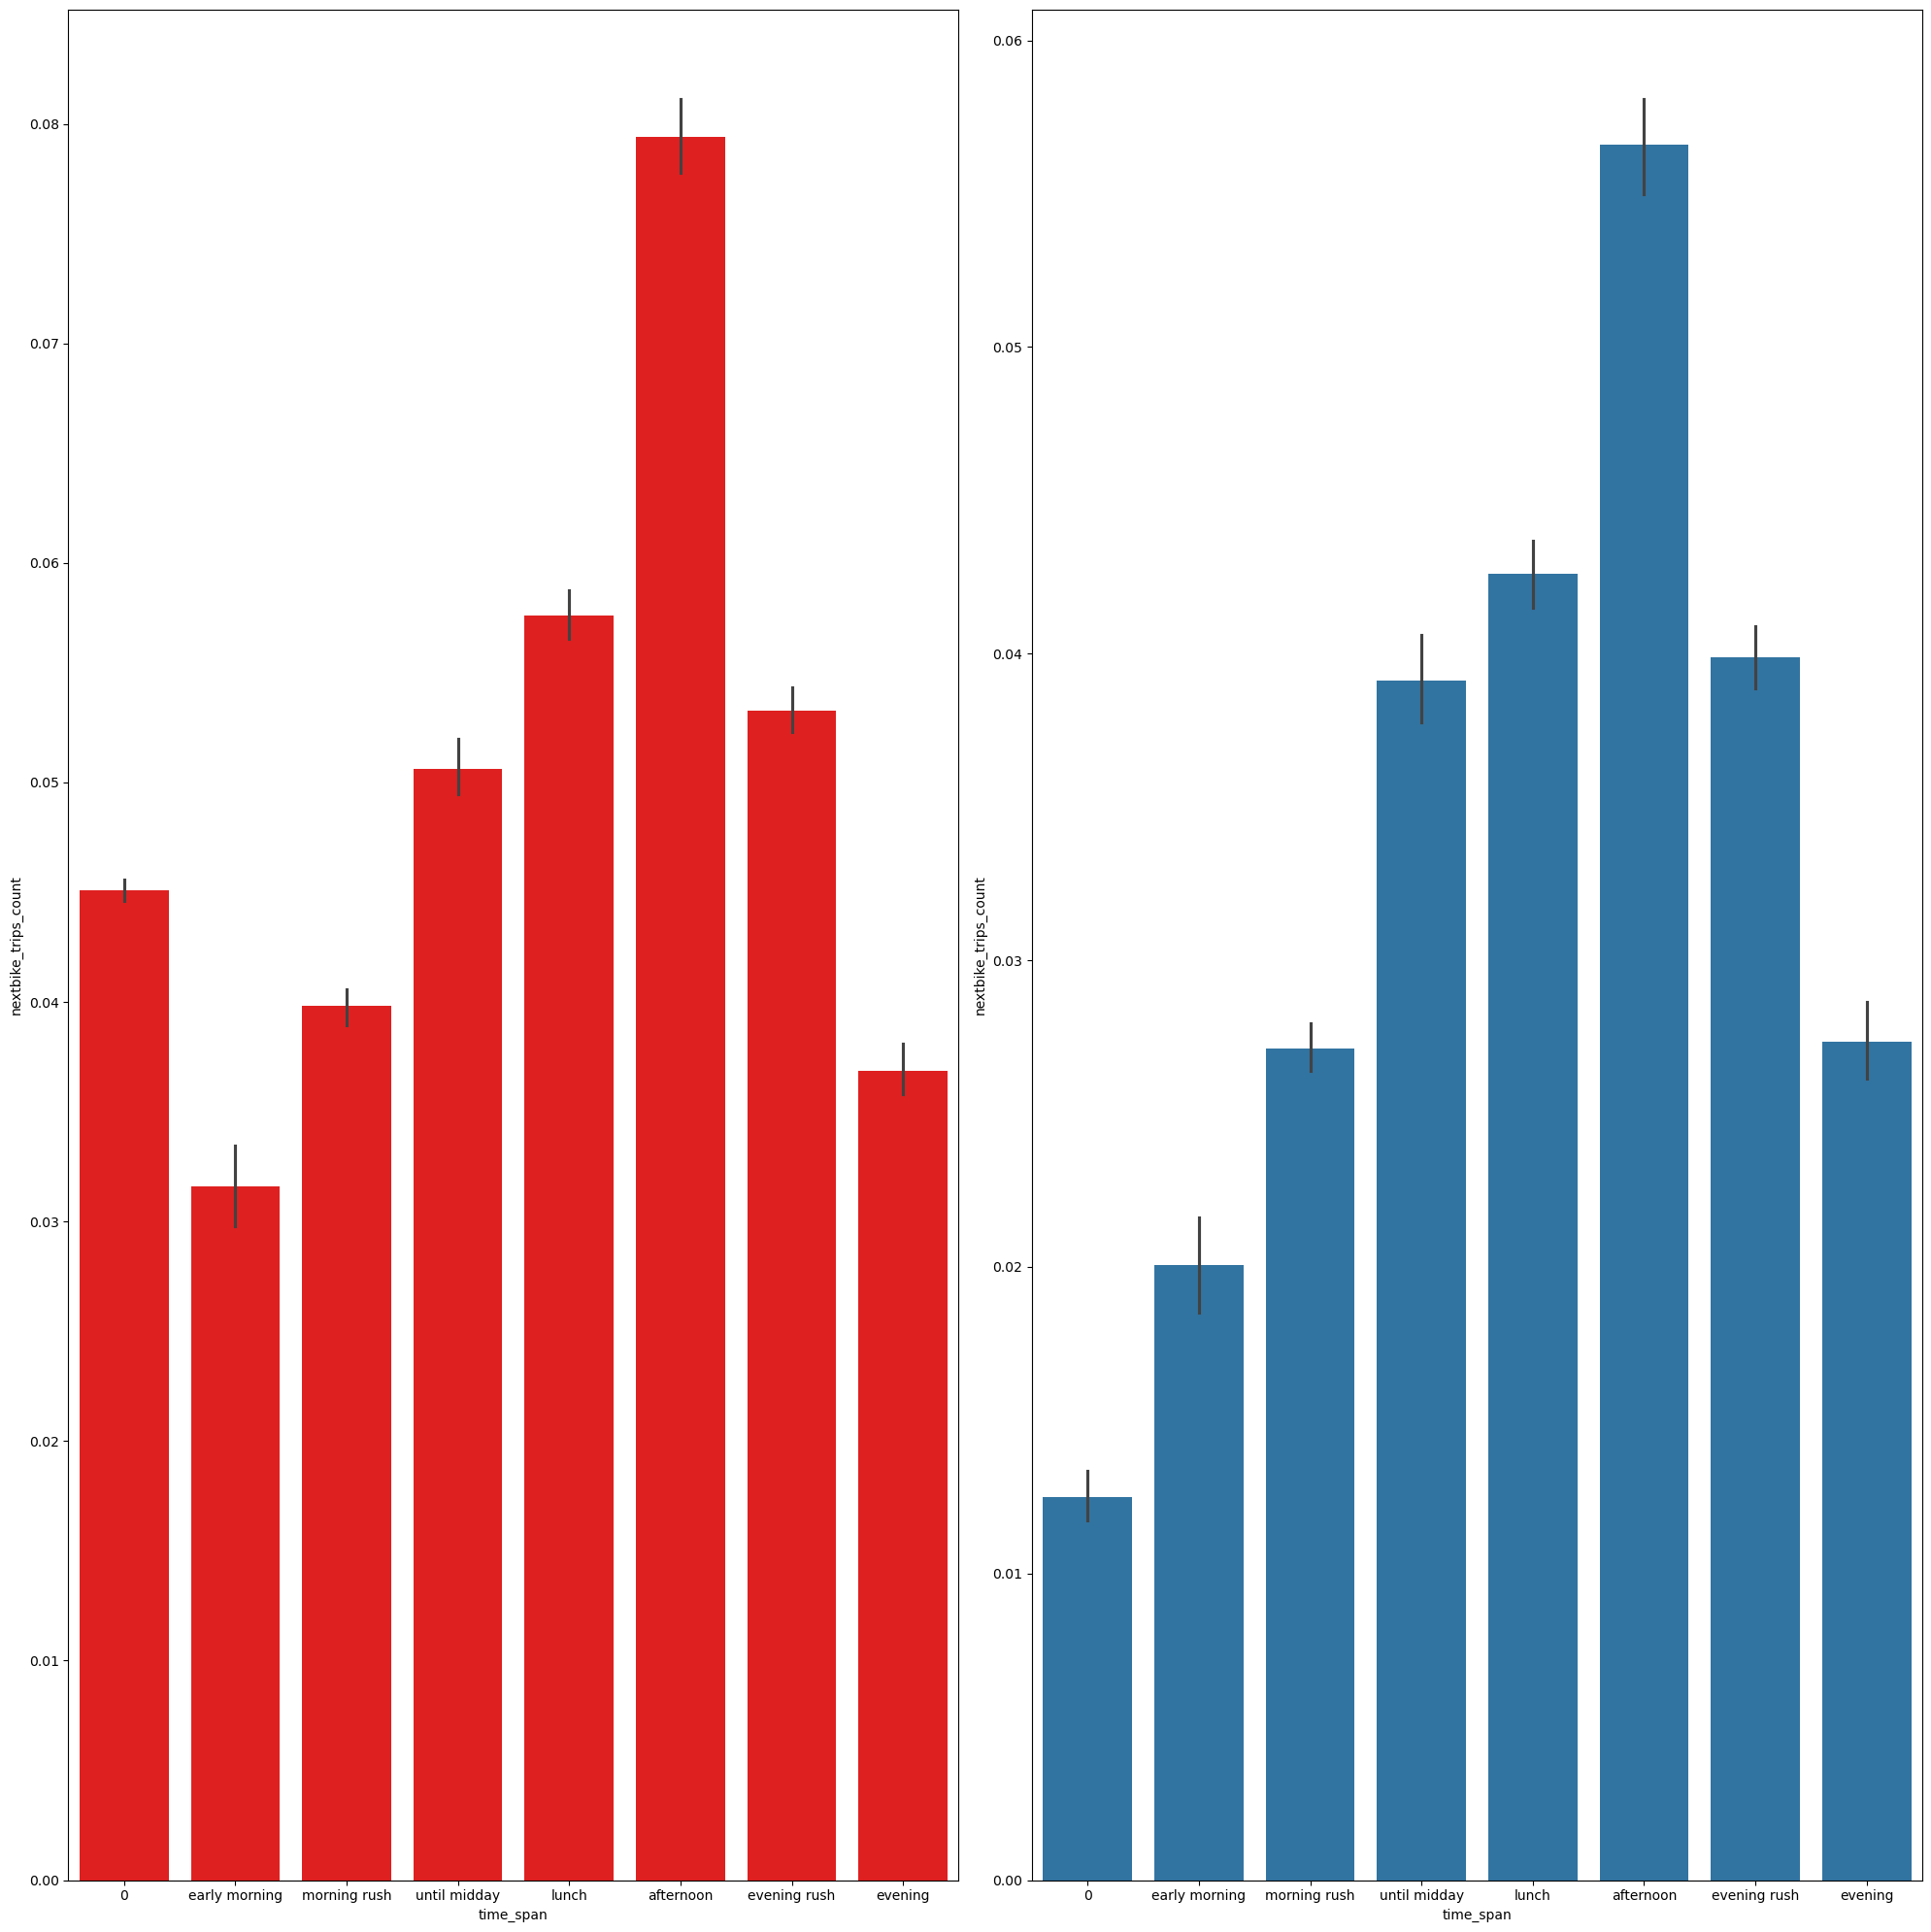

In [59]:
# Mean Nextbike Data Delay
f, axes = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = [10.00, 20.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data, x="time_span", y="nextbike_trips_count", ax=axes[0], color='Red')
sns.barplot(delay, x="time_span", y="nextbike_trips_count", ax=axes[1])
plt.show()

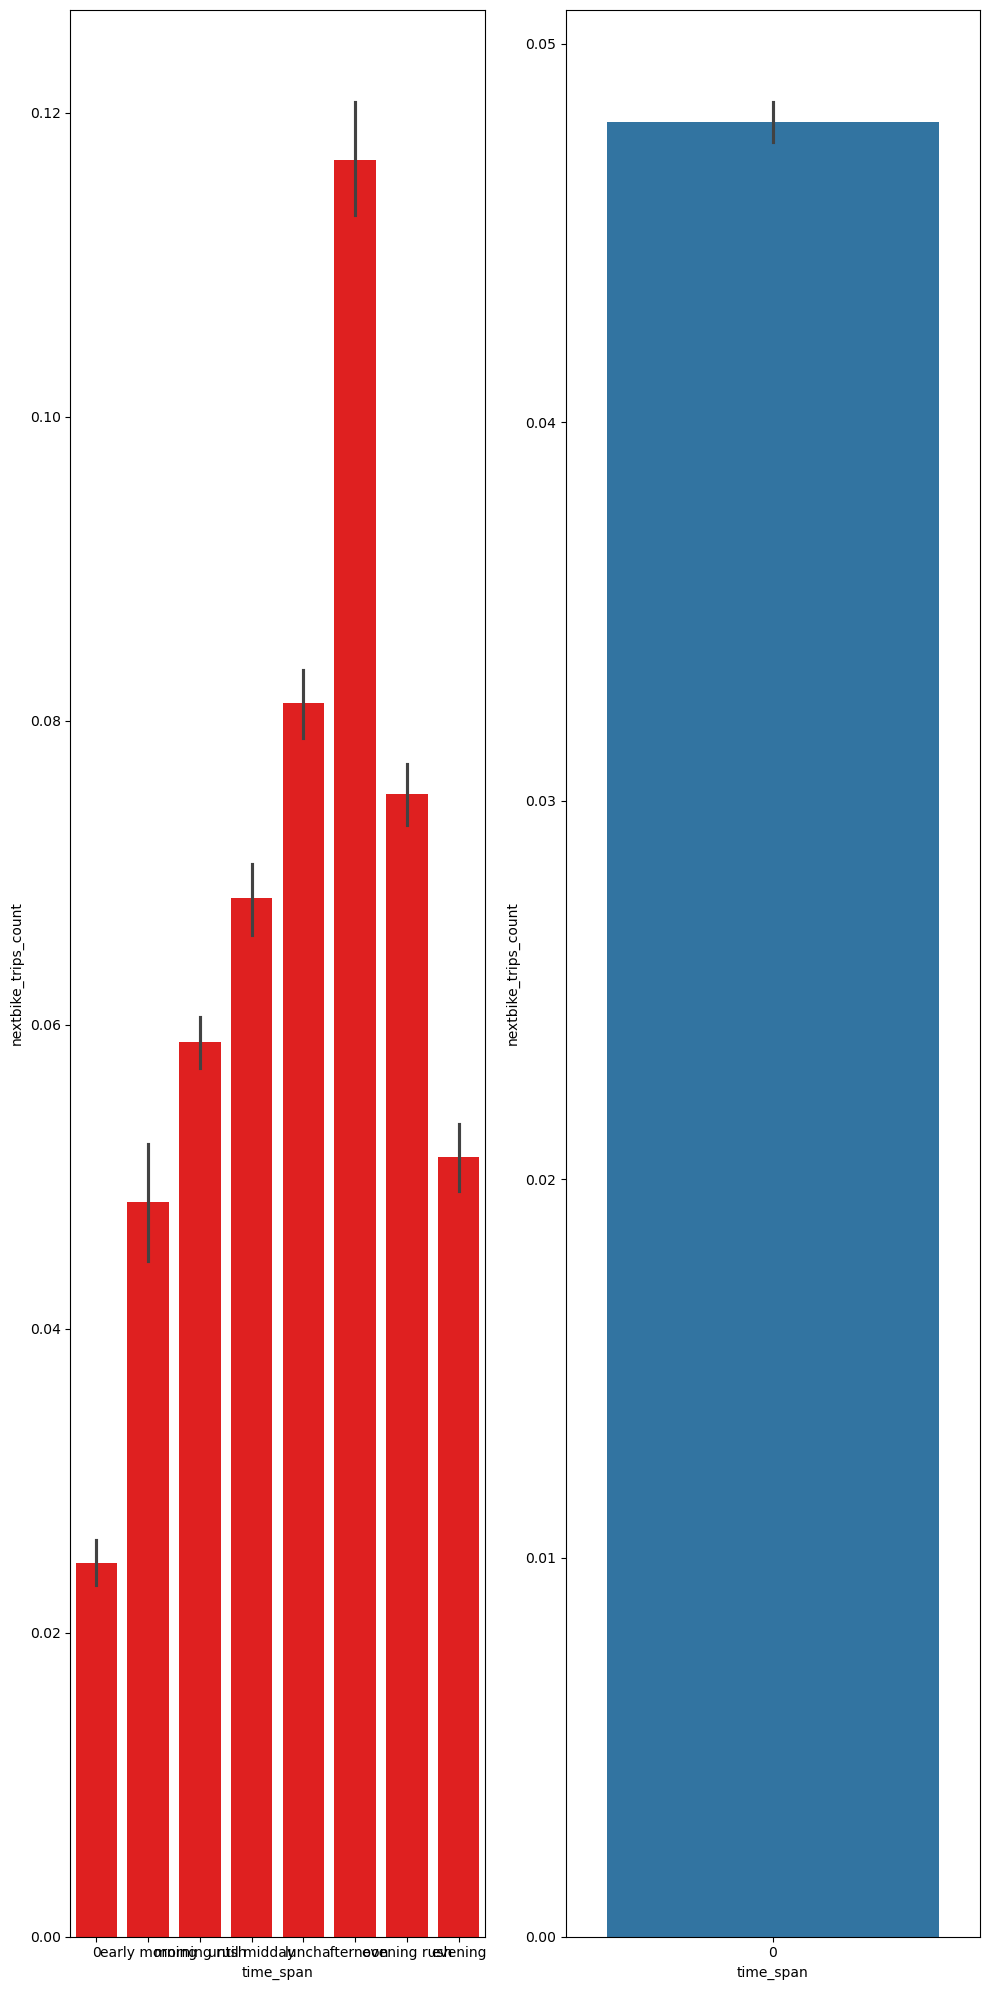

In [60]:
# Mean Tier No_Delay Nan_Delay
f, axes = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(no_delay, x="time_span", y="nextbike_trips_count", ax=axes[0], color='Red')
sns.barplot(nan_delay, x="time_span", y="nextbike_trips_count", ax=axes[1])
plt.show()

In [61]:
grouped_data = data.groupby('time_span').agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum', 'arrival_delay': 'mean', 'arrival_delay_float' : 'mean'})
grouped_delay = delay.groupby('time_span').agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum', 'arrival_delay': 'mean', 'arrival_delay_float' : 'mean'})
grouped_no_delay = no_delay.groupby('time_span').agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum', 'arrival_delay': 'mean', 'arrival_delay_float' : 'mean'})
grouped_nan_delay = nan_delay.groupby('time_span').agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum', 'arrival_delay': 'mean', 'arrival_delay_float' : 'mean'})

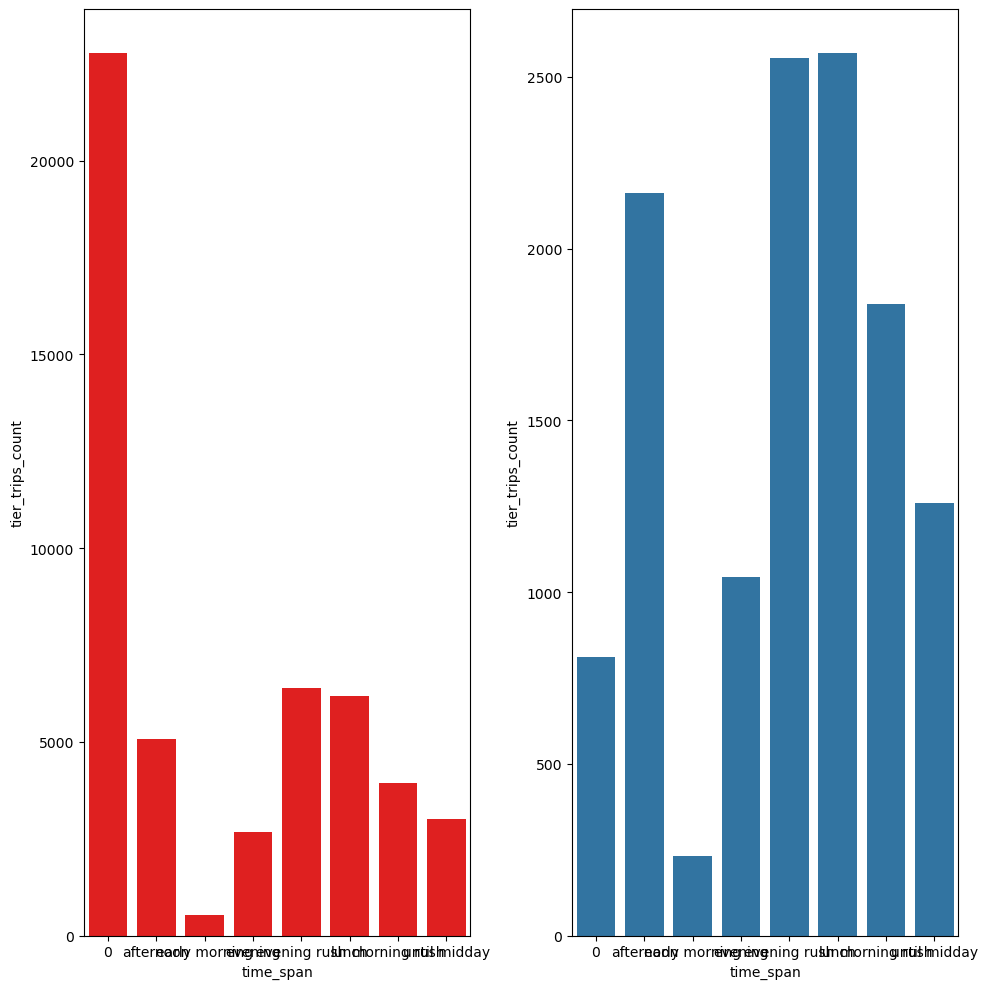

In [62]:
# Count Tier Data Delay
f, axes = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = [10.00, 20.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(grouped_data, x="time_span", y="tier_trips_count", ax=axes[0], color='Red')
sns.barplot(grouped_delay, x="time_span", y="tier_trips_count", ax=axes[1])
plt.show()

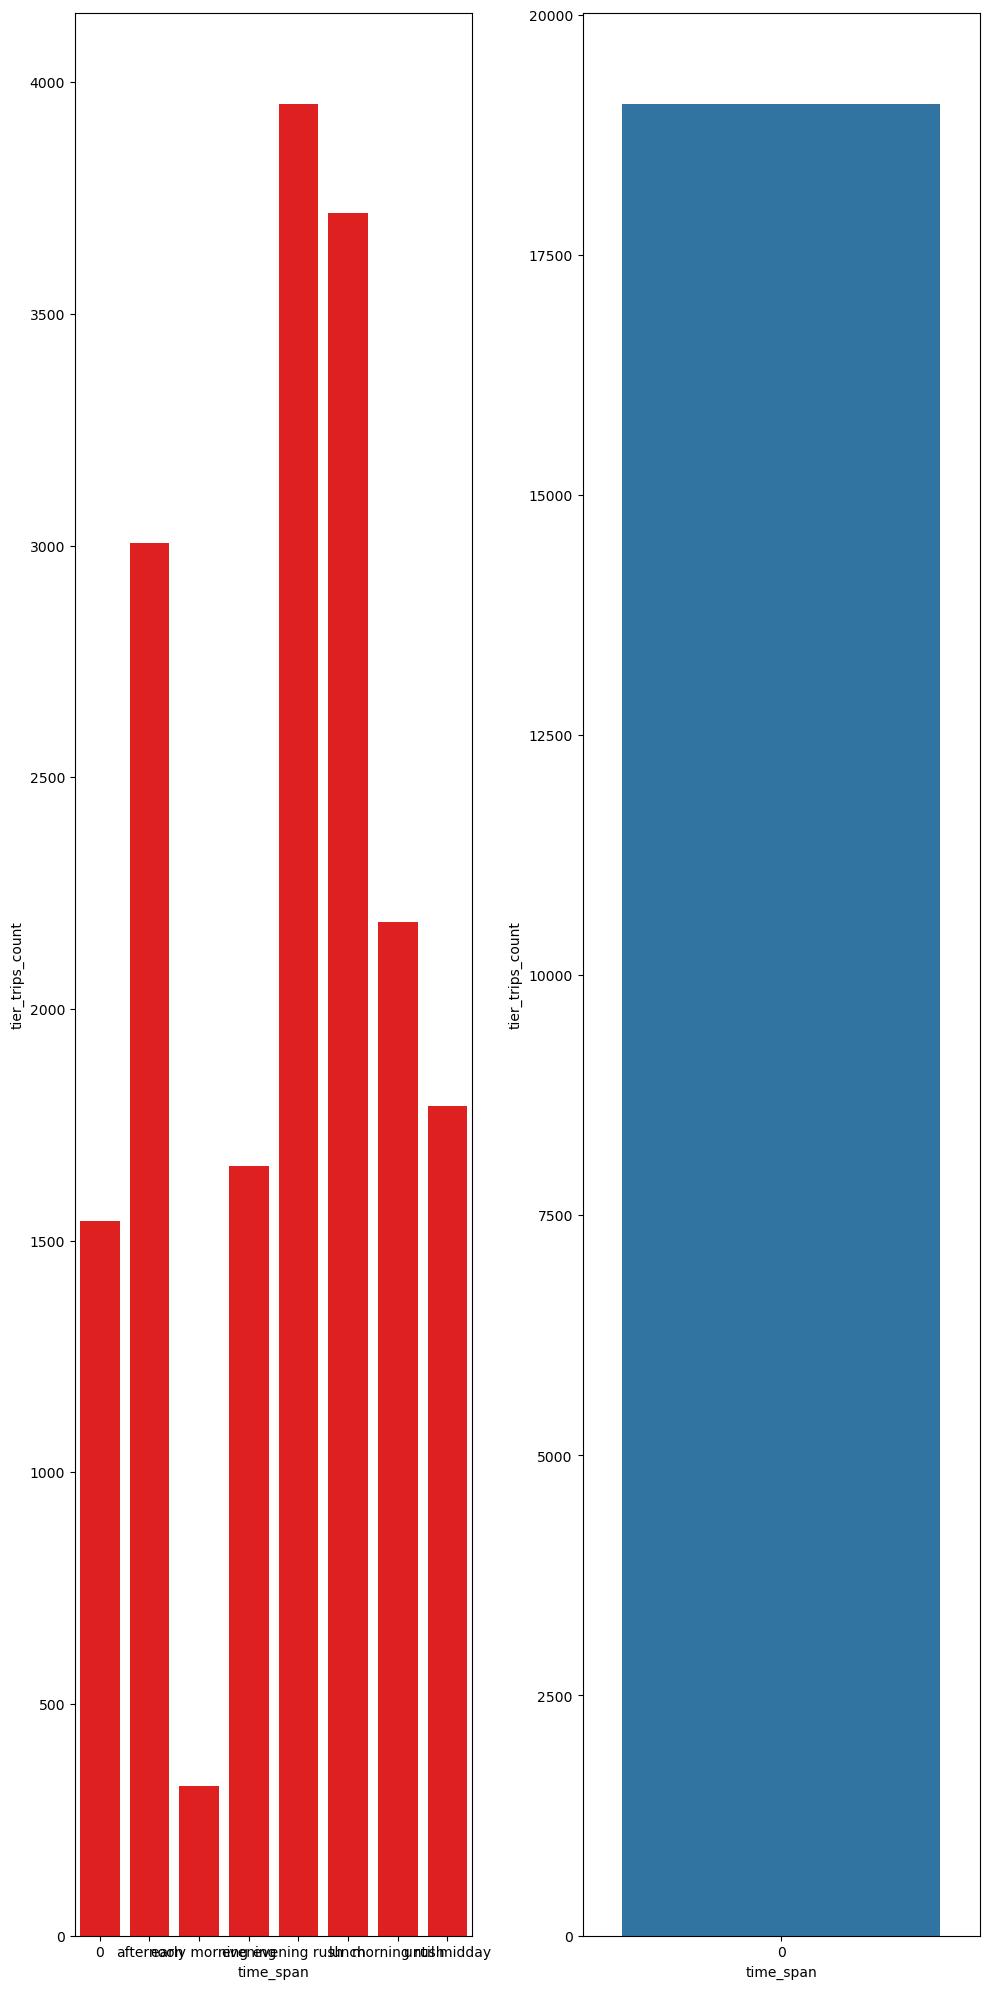

In [63]:
# Count Tier  No_Delay Nan_Delay
f, axes = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = [20.00, 20.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(grouped_no_delay, x="time_span", y="tier_trips_count", ax=axes[0], color='Red')
sns.barplot(grouped_nan_delay, x="time_span", y="tier_trips_count", ax=axes[1])
plt.show()

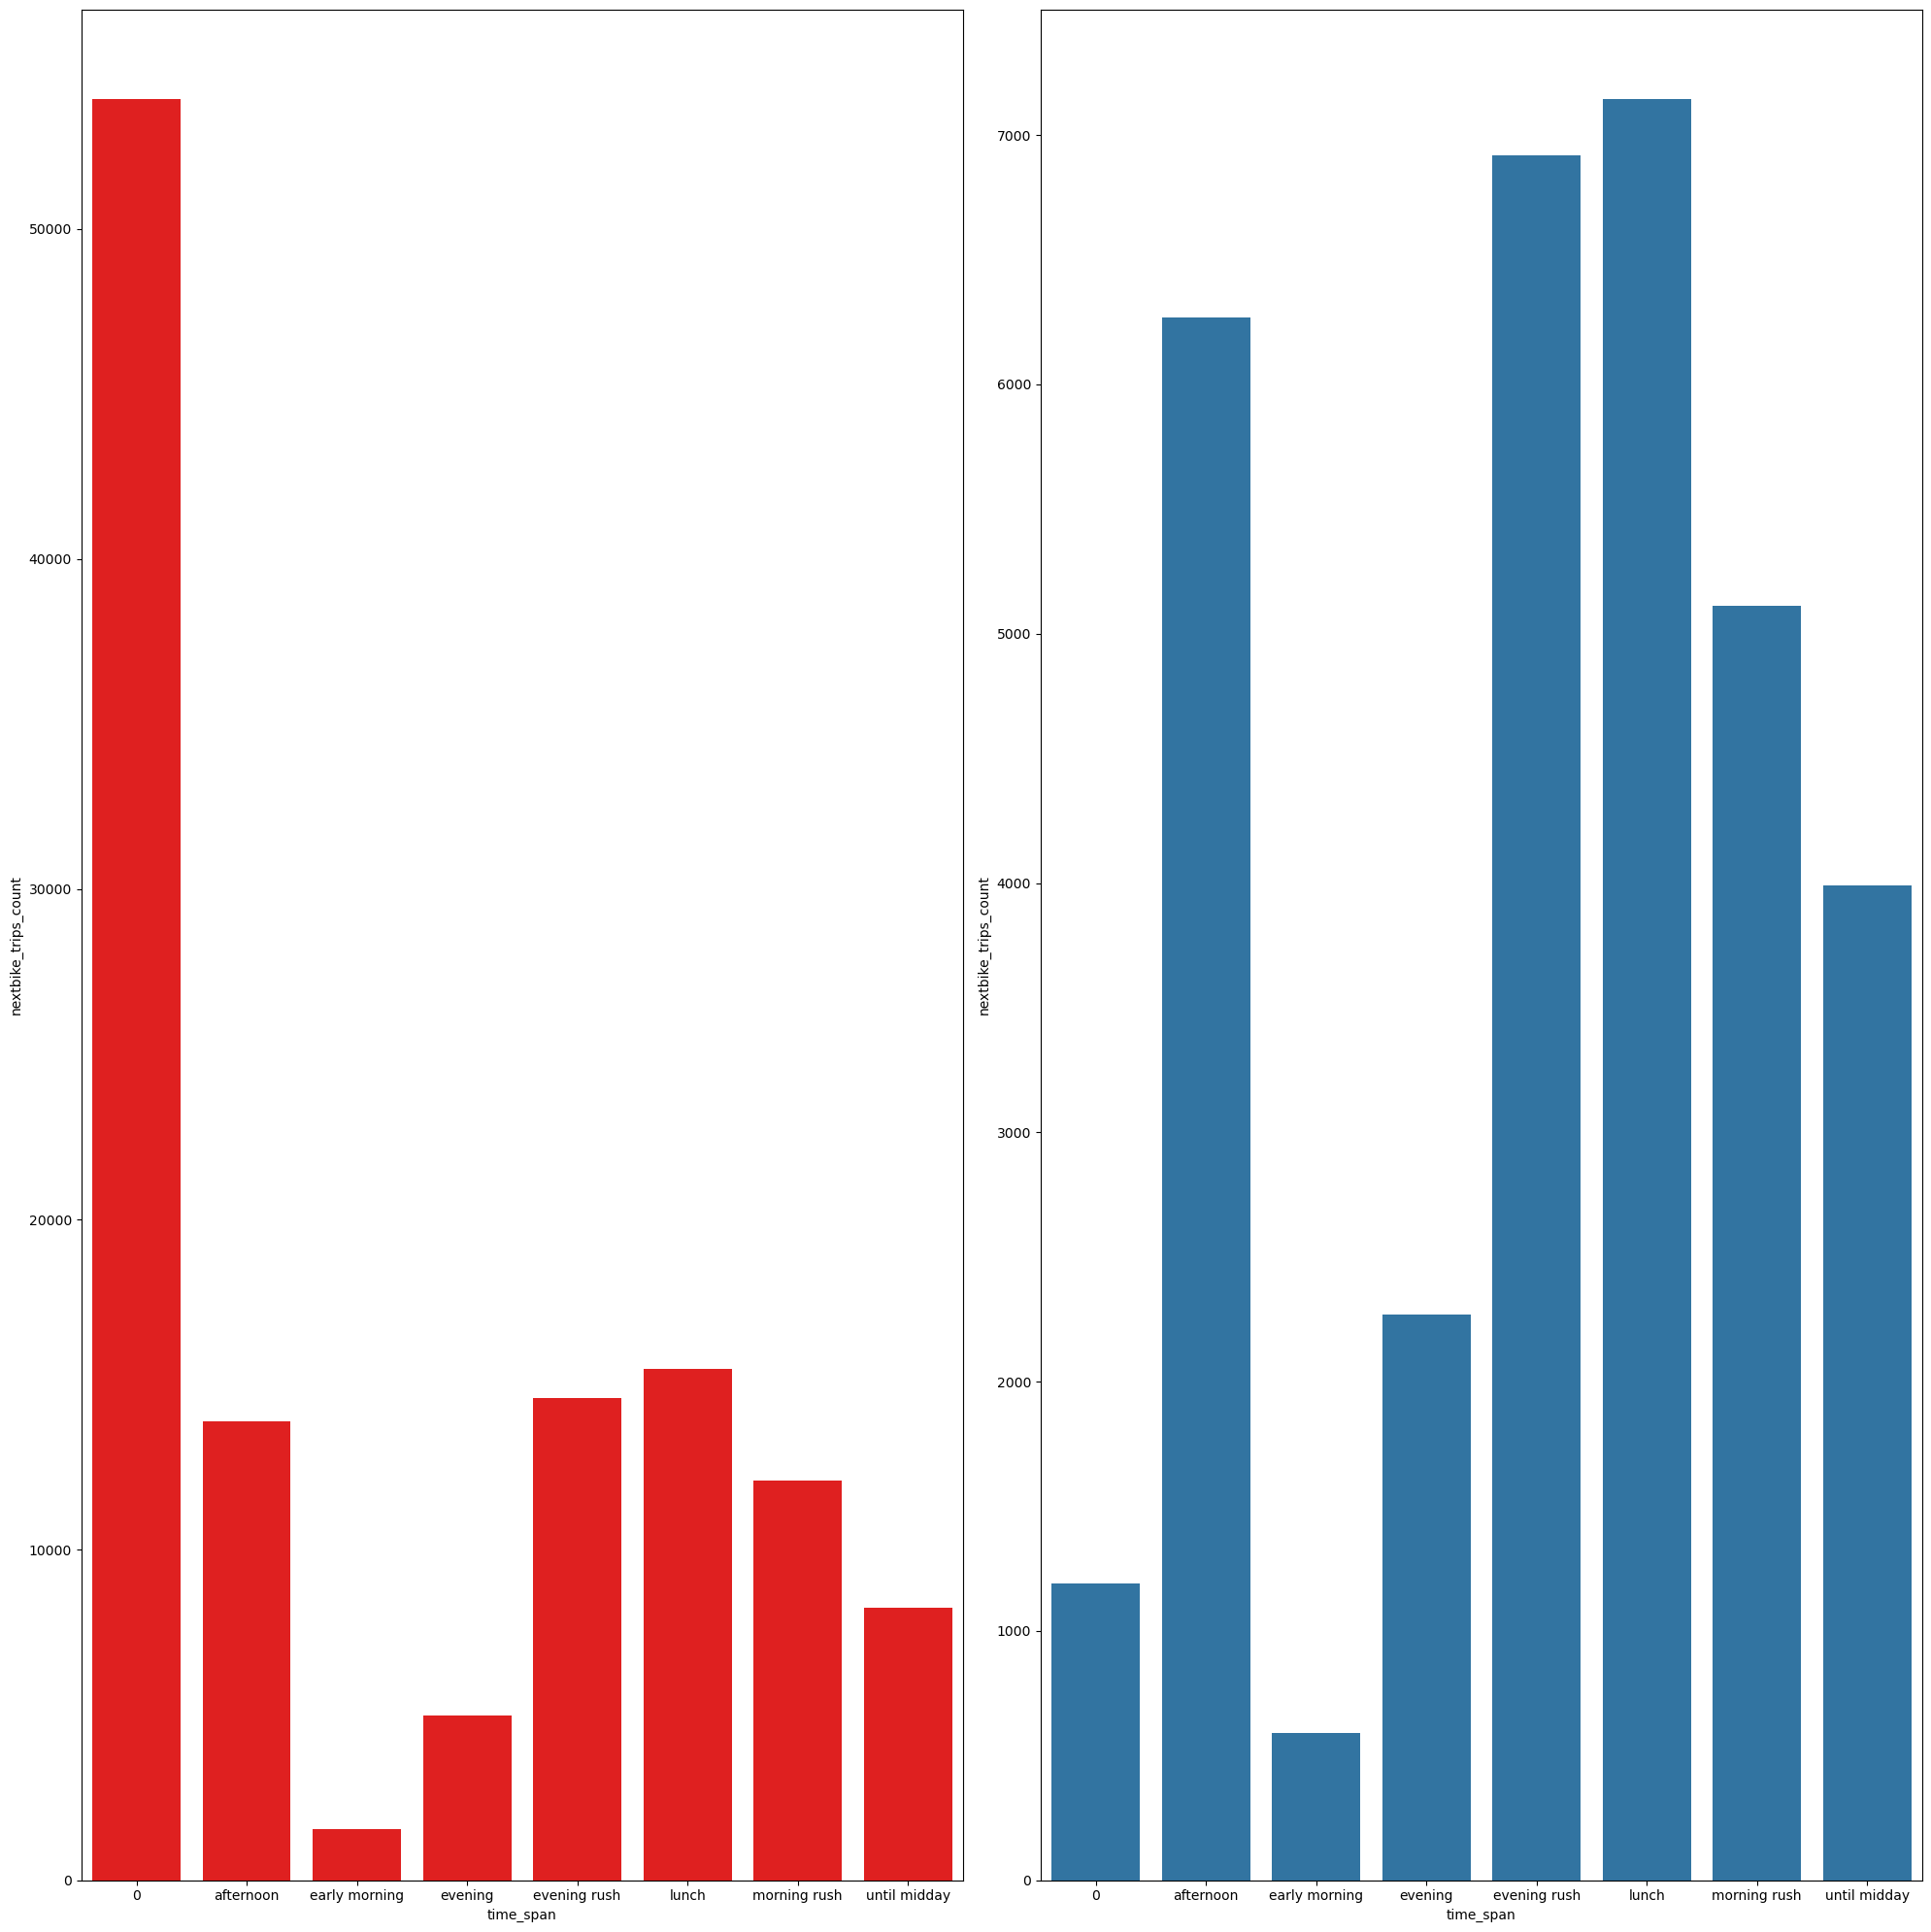

In [64]:
# Count Nextbike Data Delay
f, axes = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = [10.00, 5.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(grouped_data, x="time_span", y="nextbike_trips_count", ax=axes[0], color='Red')
sns.barplot(grouped_delay, x="time_span", y="nextbike_trips_count", ax=axes[1])
plt.show()

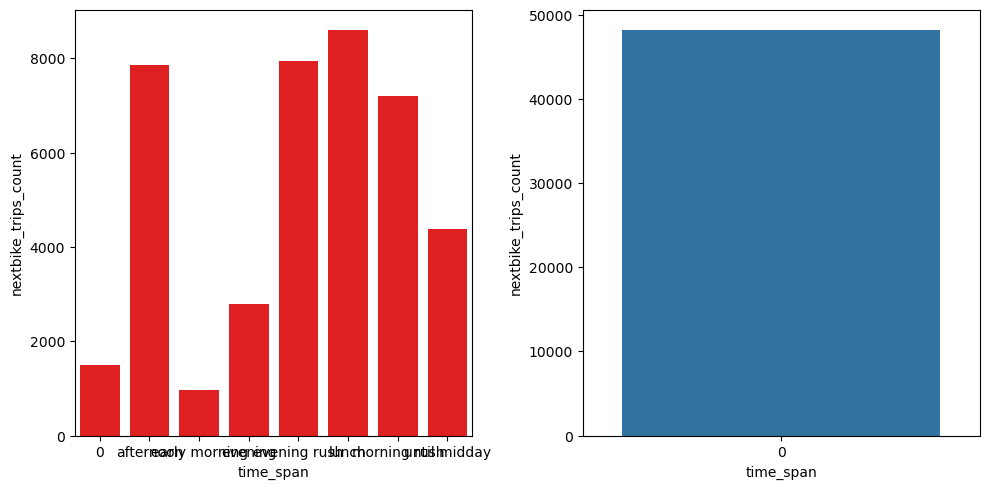

In [65]:
# Count Nextbike No_Delay Nan_Delay
f, axes = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = [20.00, 20.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(grouped_no_delay, x="time_span", y="nextbike_trips_count", ax=axes[0], color='Red')
sns.barplot(grouped_nan_delay, x="time_span", y="nextbike_trips_count", ax=axes[1])
plt.show()

In [66]:
grouped_delay

tier_trips_count  nextbike_trips_count  \
time_span                                               
0                           811                  1189   
afternoon                  2163                  6268   
early morning               232                   592   
evening                    1044                  2267   
evening rush               2555                  6920   
lunch                      2569                  7146   
morning rush               1839                  5112   
until midday               1259                  3990   

                          arrival_delay  arrival_delay_float  
time_span                                                     
0             0 days 00:00:57.379338046             0.956322  
afternoon     0 days 00:00:25.463425715             0.424390  
early morning 0 days 00:01:26.477732793             1.039229  
evening       0 days 00:00:21.324665850             0.355411  
evening rush  0 days 00:00:21.134297986             0.352238  
lunch         0 days 00:00:26.026510991             0.433775  
morning rush  0 days 00:00:20.245006775             0.337417  
until midday  0 days 00:00:21.747179679             0.362453

#### Timespan in relation to delay

In [67]:
grouped_data

tier_trips_count  nextbike_trips_count  \
time_span                                               
0                         22777                 53932   
afternoon                  5084                 13894   
early morning               537                  1536   
evening                    2672                  4989   
evening rush               6402                 14602   
lunch                      6180                 15487   
morning rush               3935                 12091   
until midday               3006                  8241   

                          arrival_delay  arrival_delay_float  
time_span                                                     
0             0 days 00:01:01.925241799             0.761090  
afternoon     0 days 00:00:17.963073238             0.299385  
early morning 0 days 00:00:56.612638863             0.681297  
evening       0 days 00:00:14.656085311             0.244268  
evening rush  0 days 00:00:14.945113662             0.249085  
lunch         0 days 00:00:18.153324463             0.302555  
morning rush  0 days 00:00:14.094907684             0.234915  
until midday  0 days 00:00:15.254023778             0.254234

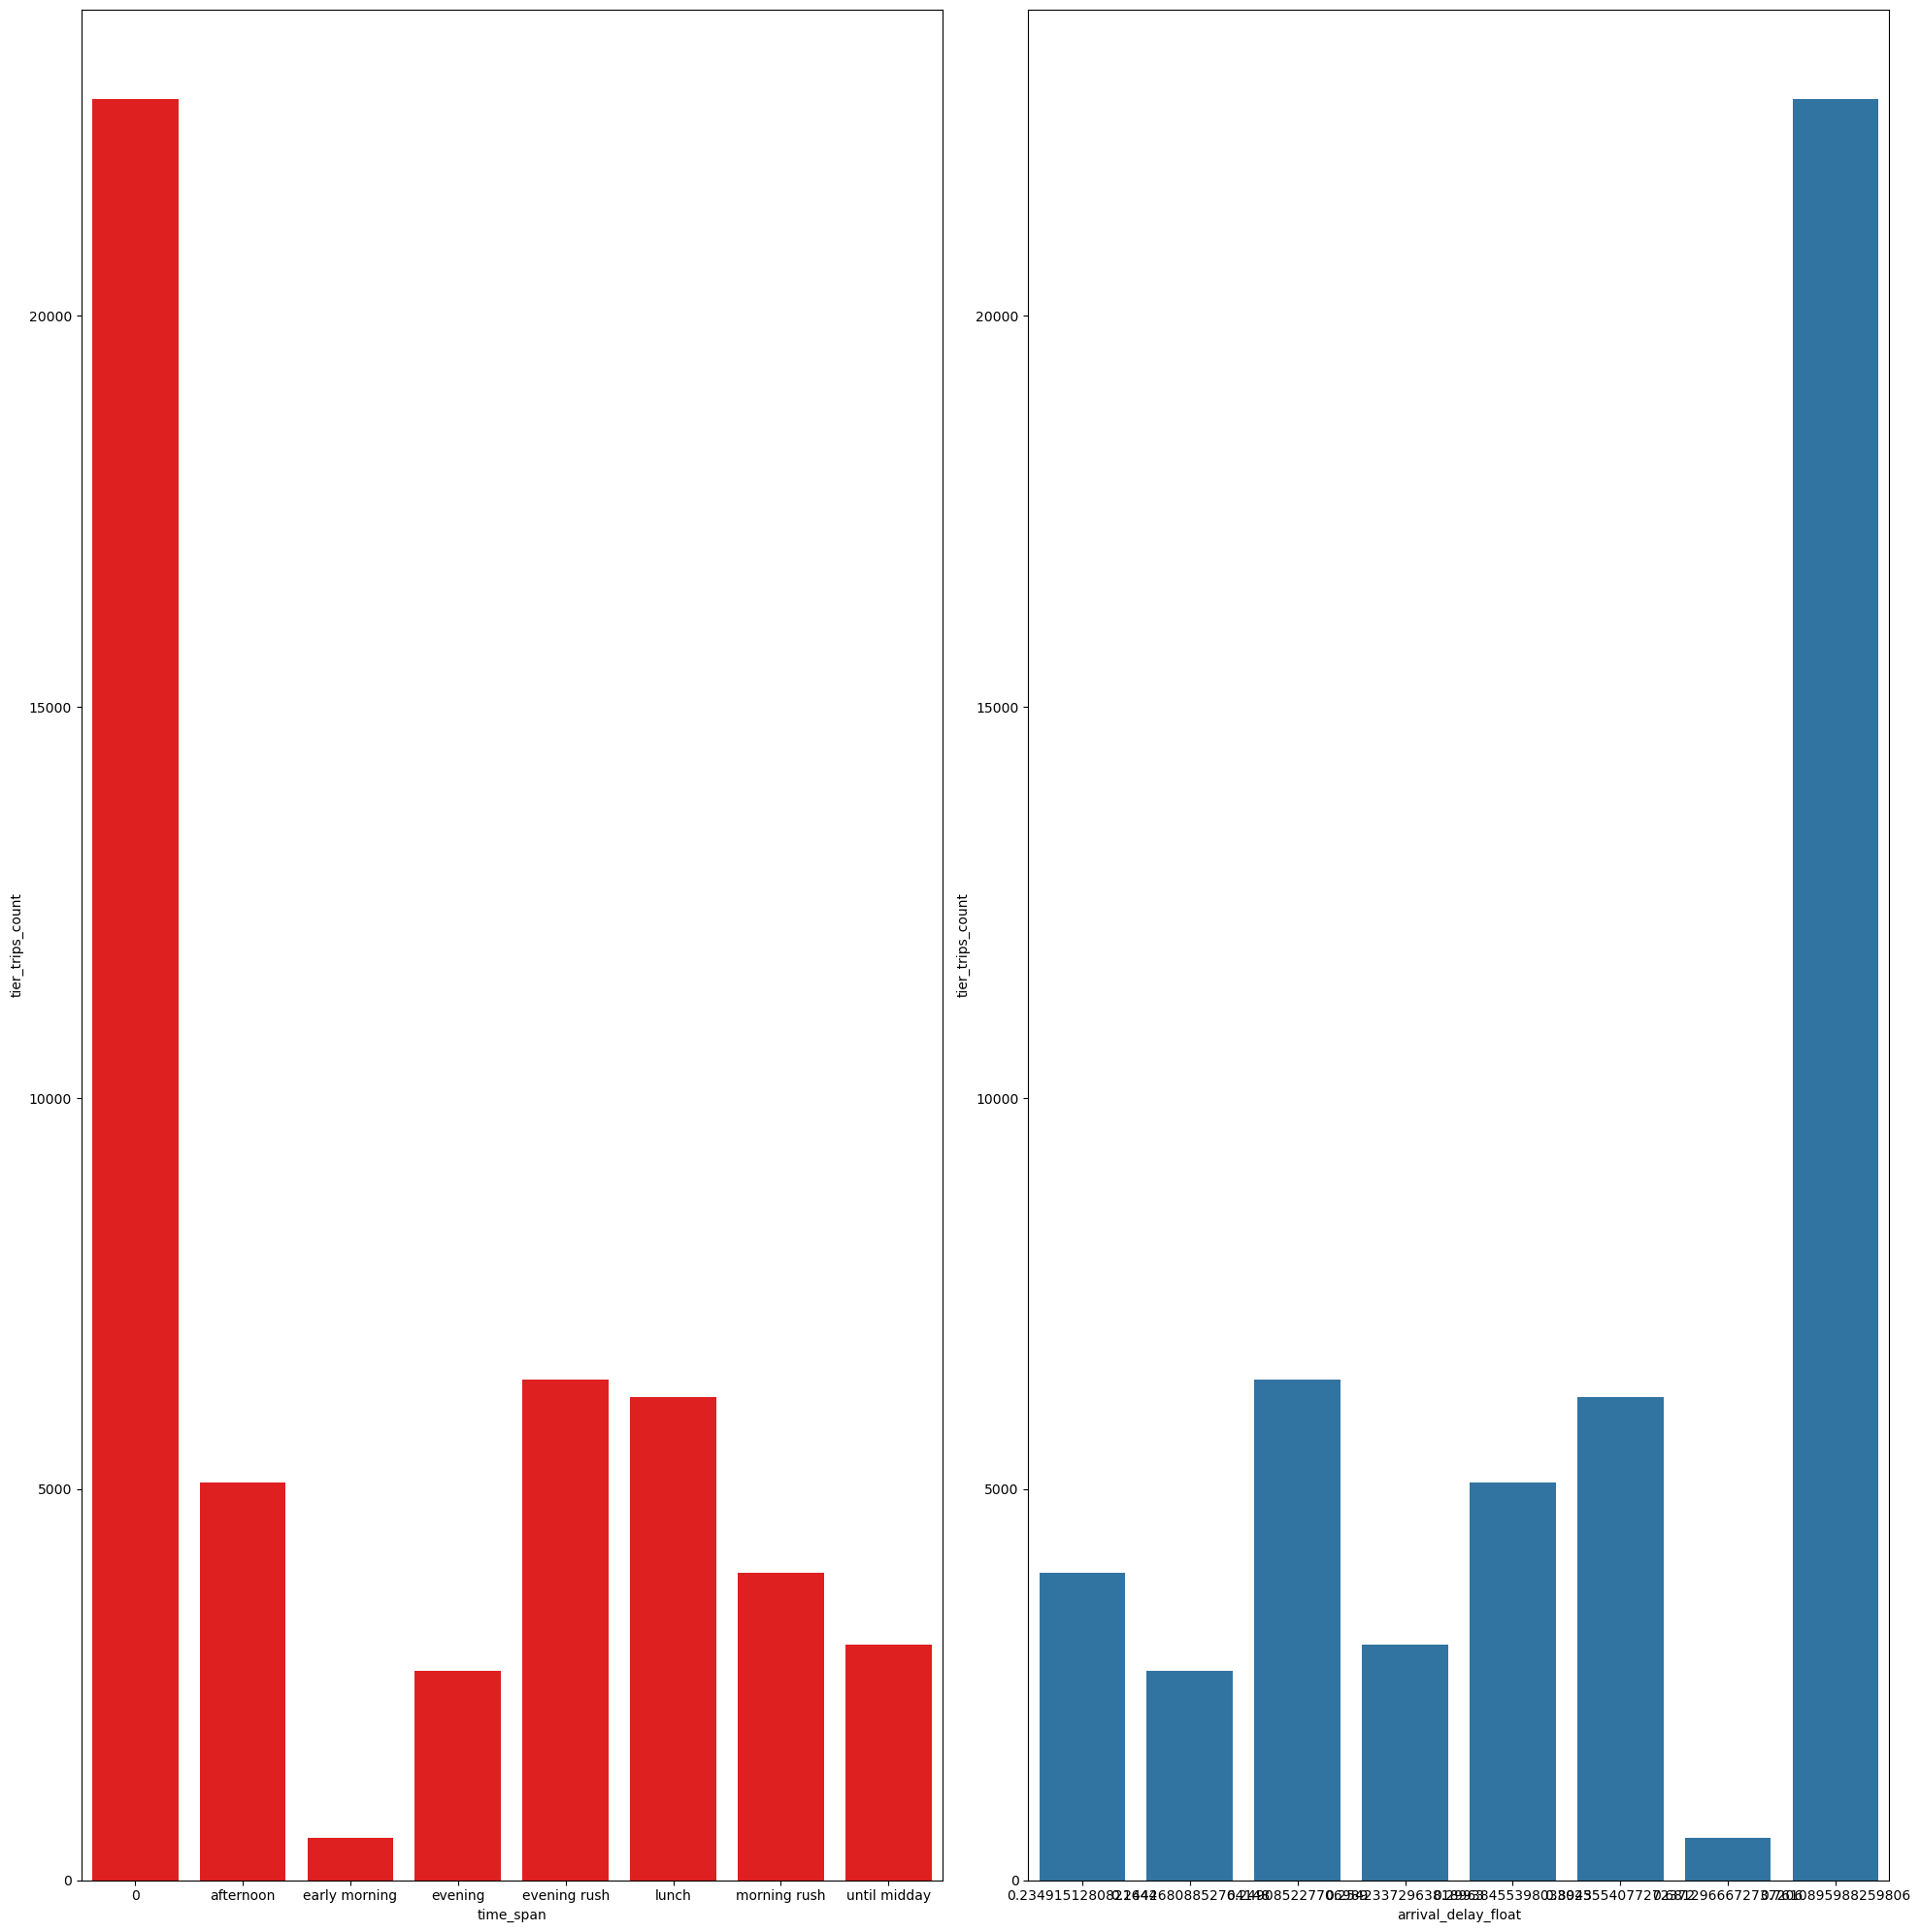

In [68]:
# data tier
f, axes = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = [20.00, 20.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(grouped_data, x="time_span", y="tier_trips_count", ax=axes[0], color='Red')
sns.barplot(grouped_data, x="arrival_delay_float", y="tier_trips_count", ax=axes[1])
plt.show()

In [69]:
grouped_delay

tier_trips_count  nextbike_trips_count  \
time_span                                               
0                           811                  1189   
afternoon                  2163                  6268   
early morning               232                   592   
evening                    1044                  2267   
evening rush               2555                  6920   
lunch                      2569                  7146   
morning rush               1839                  5112   
until midday               1259                  3990   

                          arrival_delay  arrival_delay_float  
time_span                                                     
0             0 days 00:00:57.379338046             0.956322  
afternoon     0 days 00:00:25.463425715             0.424390  
early morning 0 days 00:01:26.477732793             1.039229  
evening       0 days 00:00:21.324665850             0.355411  
evening rush  0 days 00:00:21.134297986             0.352238  
lunch         0 days 00:00:26.026510991             0.433775  
morning rush  0 days 00:00:20.245006775             0.337417  
until midday  0 days 00:00:21.747179679             0.362453

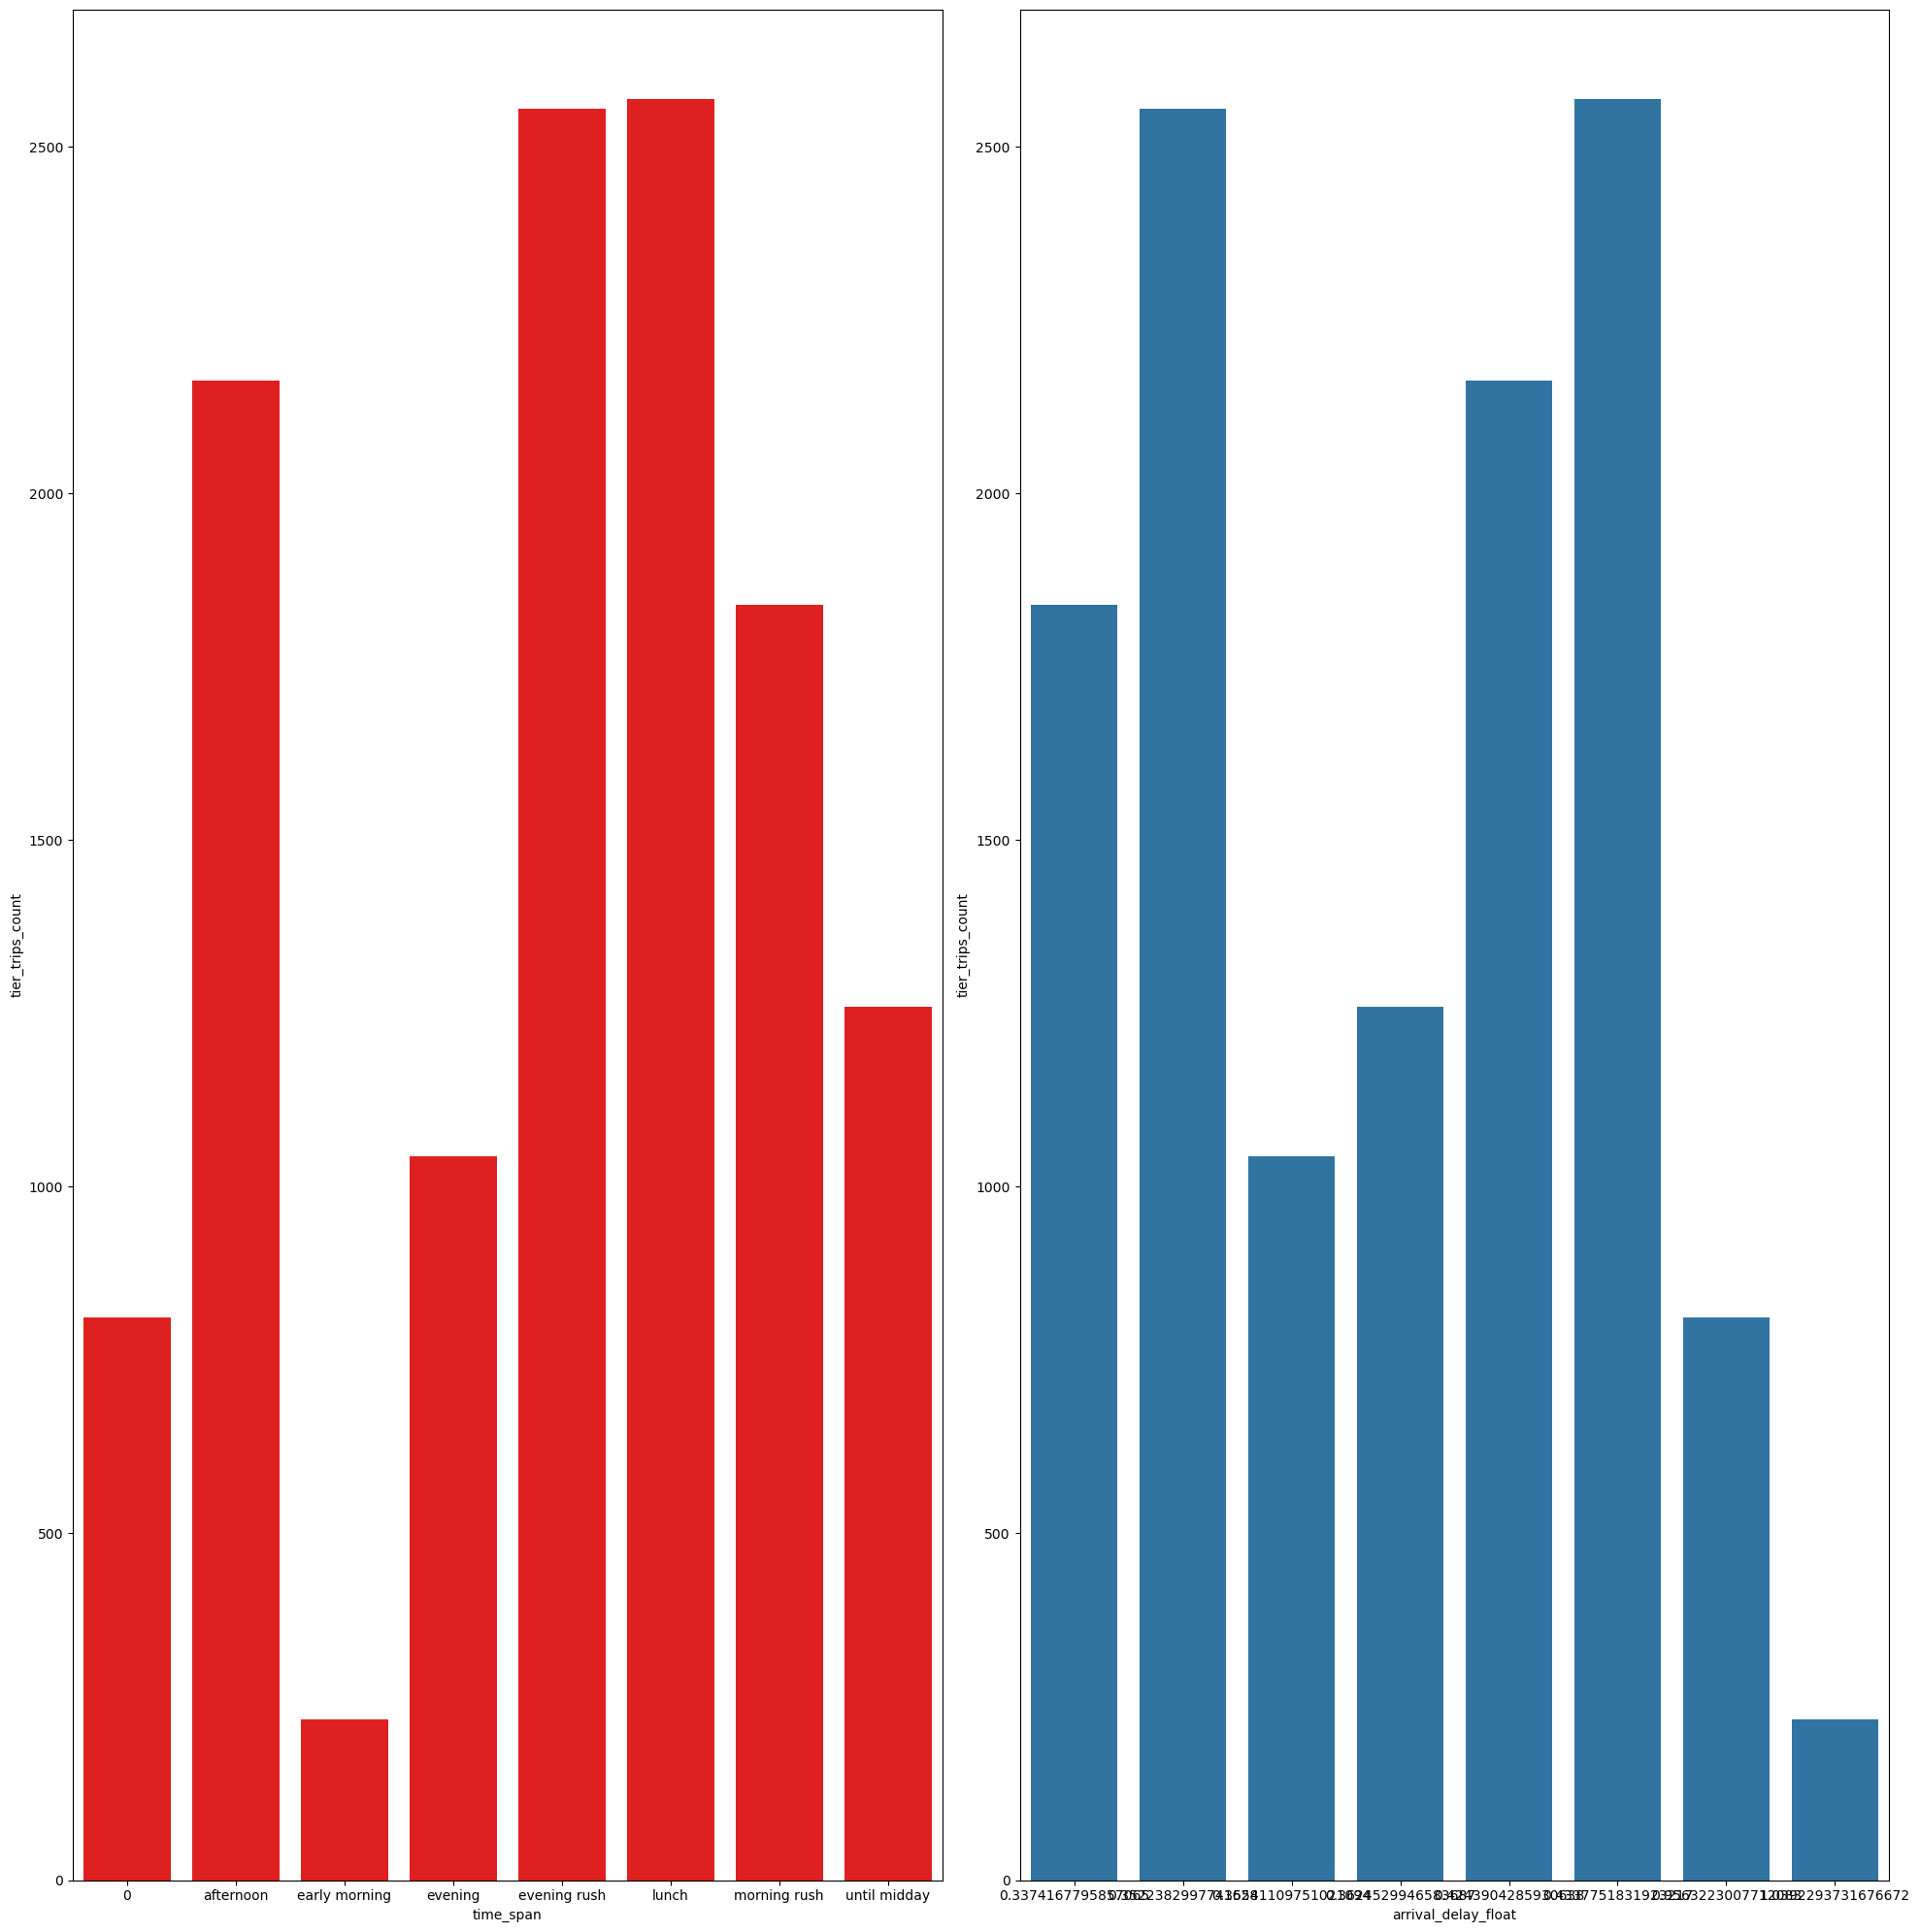

In [70]:
# delay tier
f, axes = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = [20.00, 20.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(grouped_delay, x="time_span", y="tier_trips_count", ax=axes[0], color='Red')
sns.barplot(grouped_delay, x="arrival_delay_float", y="tier_trips_count", ax=axes[1])
plt.show()

In [71]:
grouped_no_delay

tier_trips_count  nextbike_trips_count  \
time_span                                               
0                          1542                  1493   
afternoon                  3006                  7850   
early morning               322                   965   
evening                    1662                  2789   
evening rush               3952                  7935   
lunch                      3718                  8597   
morning rush               2188                  7192   
until midday               1790                  4384   

                          arrival_delay  arrival_delay_float  
time_span                                                     
0             0 days 00:00:01.045098211             0.017418  
afternoon     0 days 00:00:01.224211070             0.020404  
early morning 0 days 00:00:00.597014925             0.009950  
evening       0 days 00:00:01.234789100             0.020580  
evening rush  0 days 00:00:01.159182810             0.019320  
lunch         0 days 00:00:01.274547200             0.021242  
morning rush  0 days 00:00:01.015626830             0.016927  
until midday  0 days 00:00:01.150543789             0.019176

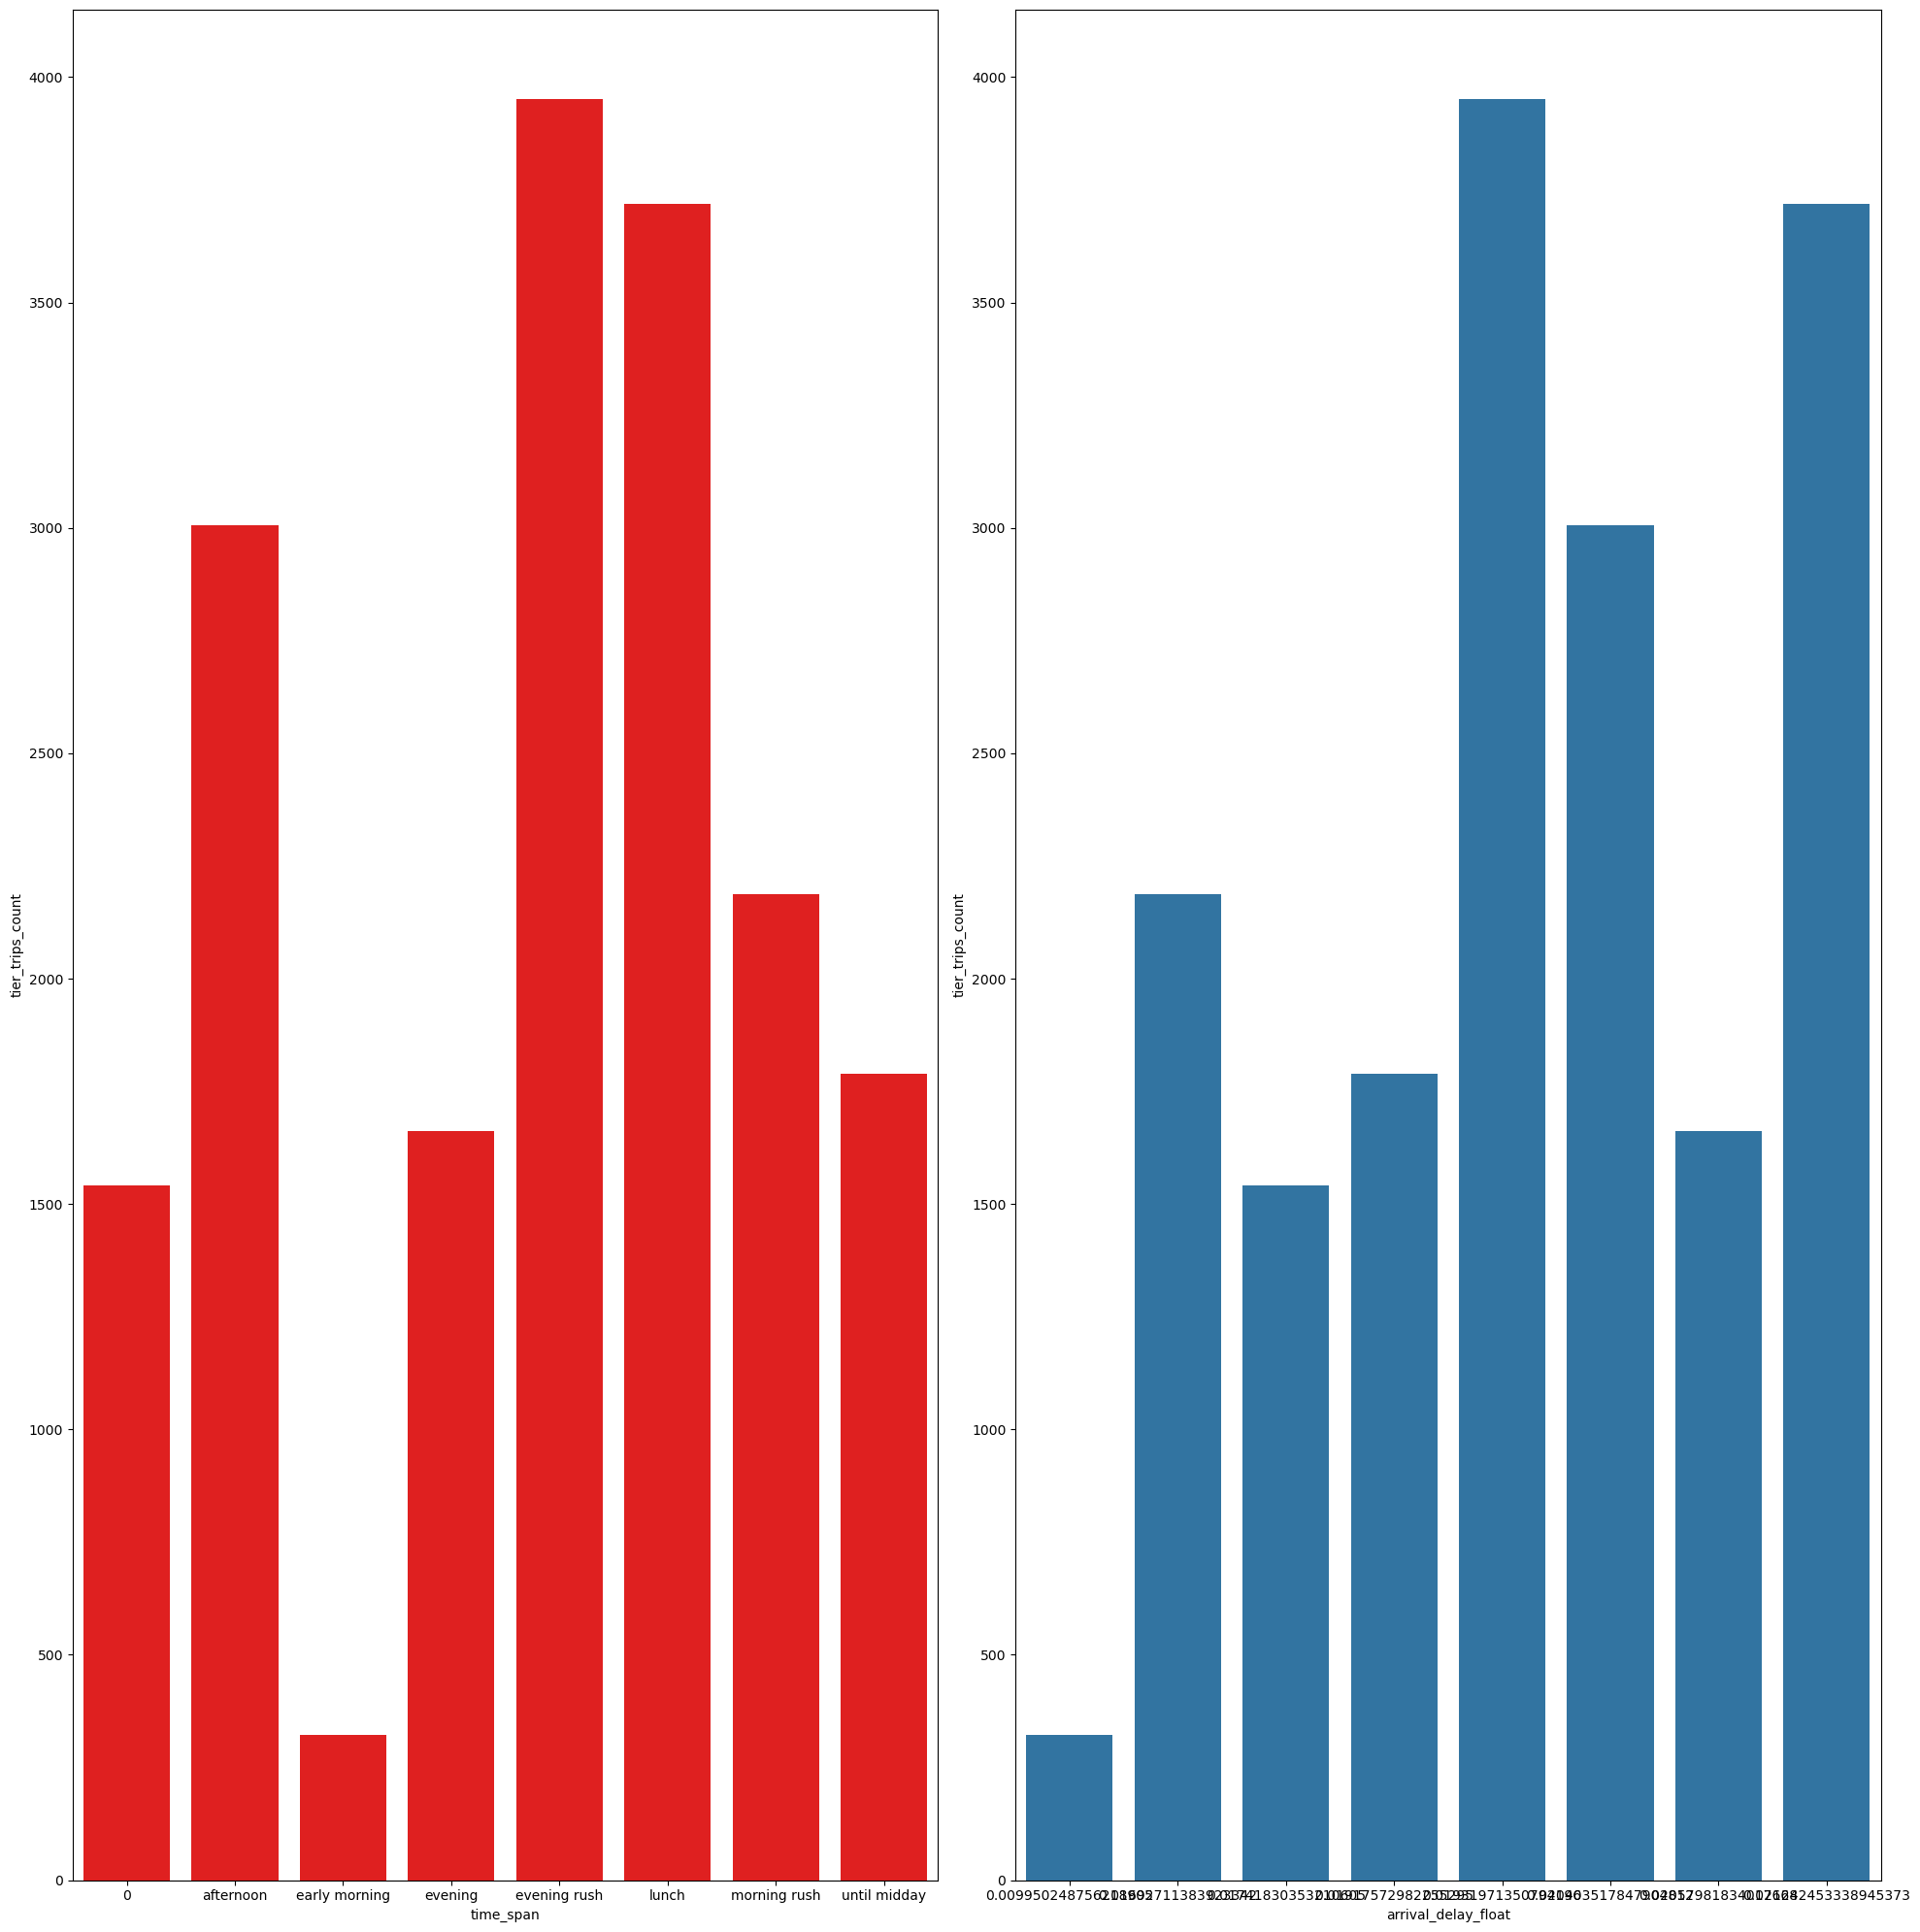

In [72]:
# no_delay tier
f, axes = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = [20.00, 20.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(grouped_no_delay, x="time_span", y="tier_trips_count", ax=axes[0], color='Red')
sns.barplot(grouped_no_delay, x="arrival_delay_float", y="tier_trips_count", ax=axes[1])
plt.show()

In [73]:
grouped_nan_delay

tier_trips_count  nextbike_trips_count arrival_delay  \
time_span                                                         
0                     19067                 48198           NaT   

           arrival_delay_float  
time_span                       
0                          NaN

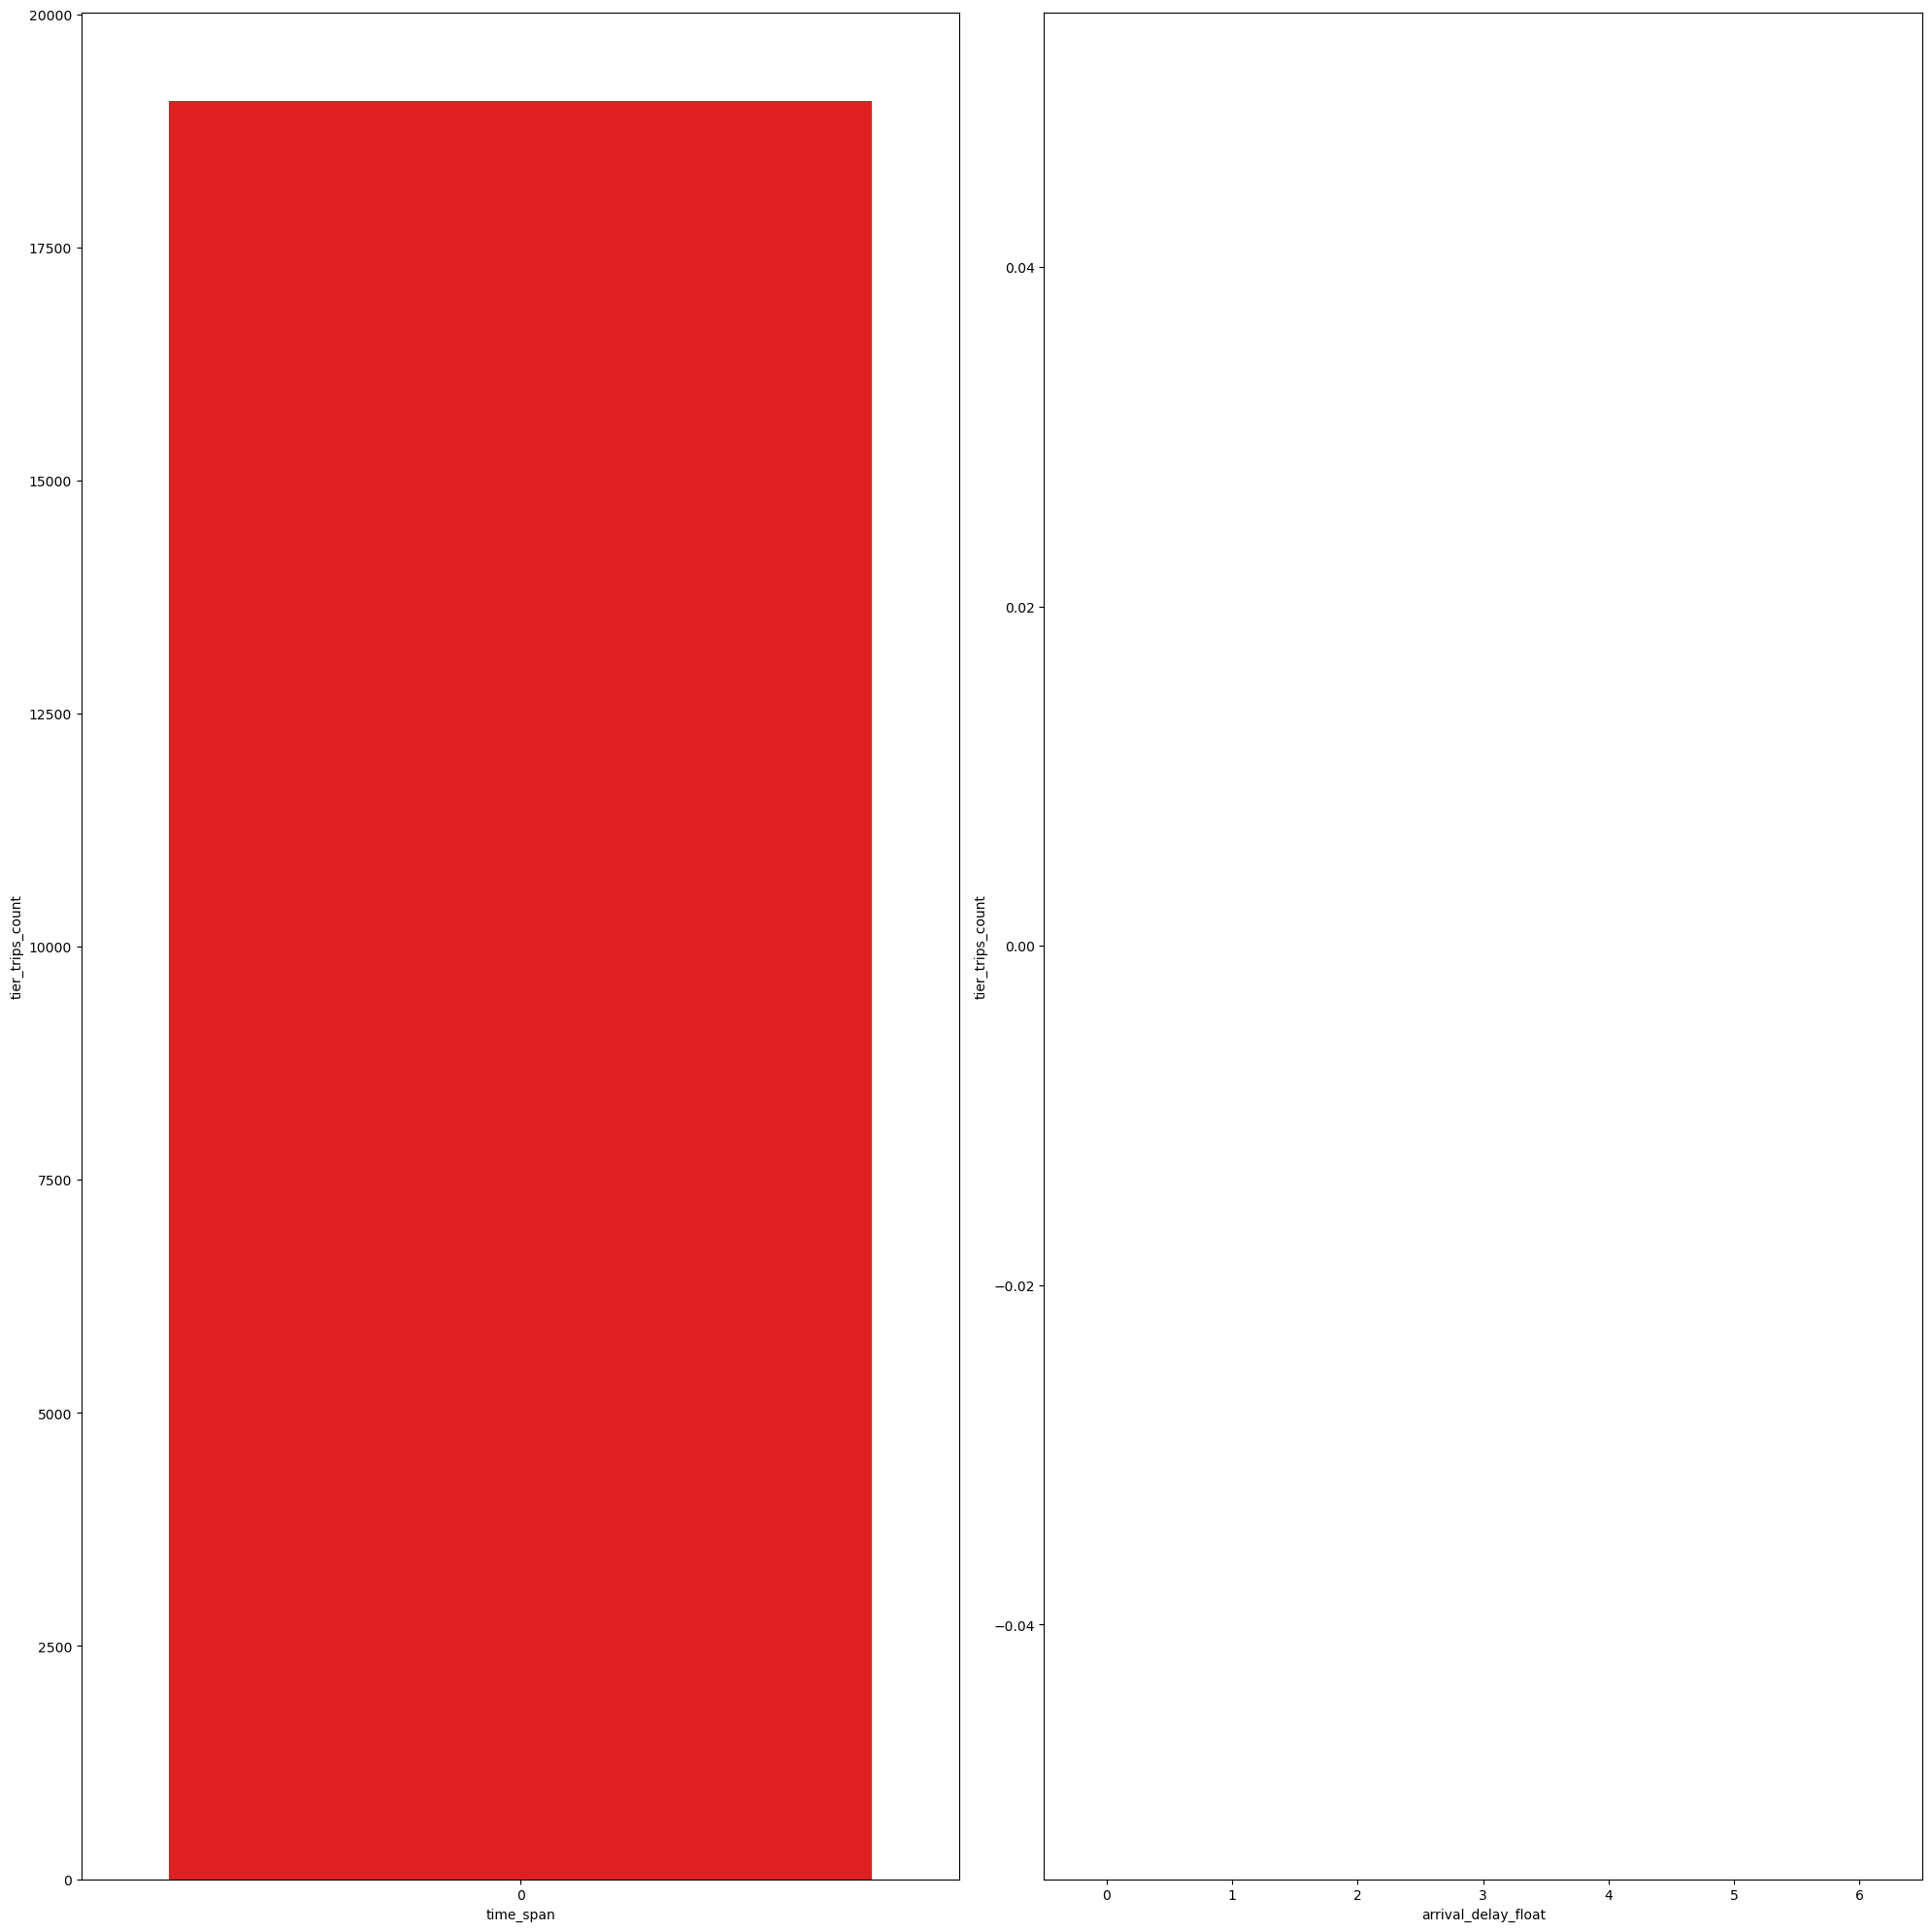

In [74]:
# nan_delay tier
f, axes = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = [20.00, 20.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(grouped_nan_delay, x="time_span", y="tier_trips_count", ax=axes[0], color='Red')
sns.barplot(grouped_nan_delay, x="arrival_delay_float", y="tier_trips_count", ax=axes[1])
plt.show()

In [75]:
#TEST

In [76]:
grouped_data = data.groupby(['time_span','delay_span']).agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum'})

In [77]:
grouped_data

tier_trips_count  nextbike_trips_count
time_span     delay_span                                        
0             0                      21744                 52547
              0-5                      864                  1272
              10-15                      0                     0
              15-20                      1                     3
              20-30                     26                    22
              30-45                     23                     8
              45-60                    118                    80
              5-10                       1                     0
afternoon     0                       2675                  7125
              0-5                     2397                  6748
              10-15                      0                     0
              15-20                      6                     3
              20-30                      2                     8
              5-10                       4                    10
early morning 0                        309                   922
              0-5                      218                   611
              10-15                      0                     0
              15-20                      0                     0
              20-30                      0                     0
              30-45                     10                     3
              45-60                      0                     0
              5-10                       0                     0
evening       0                       1524                  2584
              0-5                     1144                  2403
              10-15                      0                     0
              15-20                      3                     0
              20-30                      1                     1
              5-10                       0                     1
evening rush  0                       3544                  7329
              0-5                     2844                  7256
              10-15                      0                     0
              15-20                     11                     7
              20-30                      0                     4
              5-10                       3                     6
lunch         0                       3291                  7840
              0-5                     2879                  7632
              10-15                      1                     0
              15-20                      6                     5
              20-30                      1                     4
              30-45                      0                     0
              5-10                       2                     6
morning rush  0                       1983                  6619
              0-5                     1945                  5468
              10-15                      2                     1
              15-20                      2                     0
              20-30                      1                     0
              5-10                       2                     3
until midday  0                       1604                  4057
              0-5                     1400                  4179
              10-15                      0                     0
              15-20                      1                     2
              20-30                      0                     3
              5-10                       1                     0

#### Time Buckets (10, 30, 60 min)

In [78]:
min10 = data.groupby([pd.Grouper(key='scheduled_arrival_time', freq='10Min')]).sum(numeric_only=True)

In [79]:
min10['time'] = pd.to_datetime(min10.index).time

In [80]:
min10 = min10.groupby([pd.Grouper(key='time')]).sum(numeric_only=True)

In [81]:
min10_delay = delay.groupby([pd.Grouper(key='scheduled_arrival_time', freq='10Min')]).sum(numeric_only=True)
min10_delay['time'] = pd.to_datetime(min10_delay.index).time
min10_delay = min10_delay.groupby([pd.Grouper(key='time')]).sum(numeric_only=True)

In [82]:
min10_no_delay = no_delay.groupby([pd.Grouper(key='scheduled_arrival_time', freq='10Min')]).sum(numeric_only=True)
min10_no_delay['time'] = pd.to_datetime(min10_no_delay.index).time
min10_no_delay = min10_no_delay.groupby([pd.Grouper(key='time')]).sum(numeric_only=True)

In [83]:
min10_nan_delay = nan_delay.groupby([pd.Grouper(key='scheduled_arrival_time', freq='10Min')]).sum(numeric_only=True)
min10_nan_delay['time'] = pd.to_datetime(min10_nan_delay.index).time
min10_nan_delay = min10_nan_delay.groupby([pd.Grouper(key='time')]).sum(numeric_only=True)

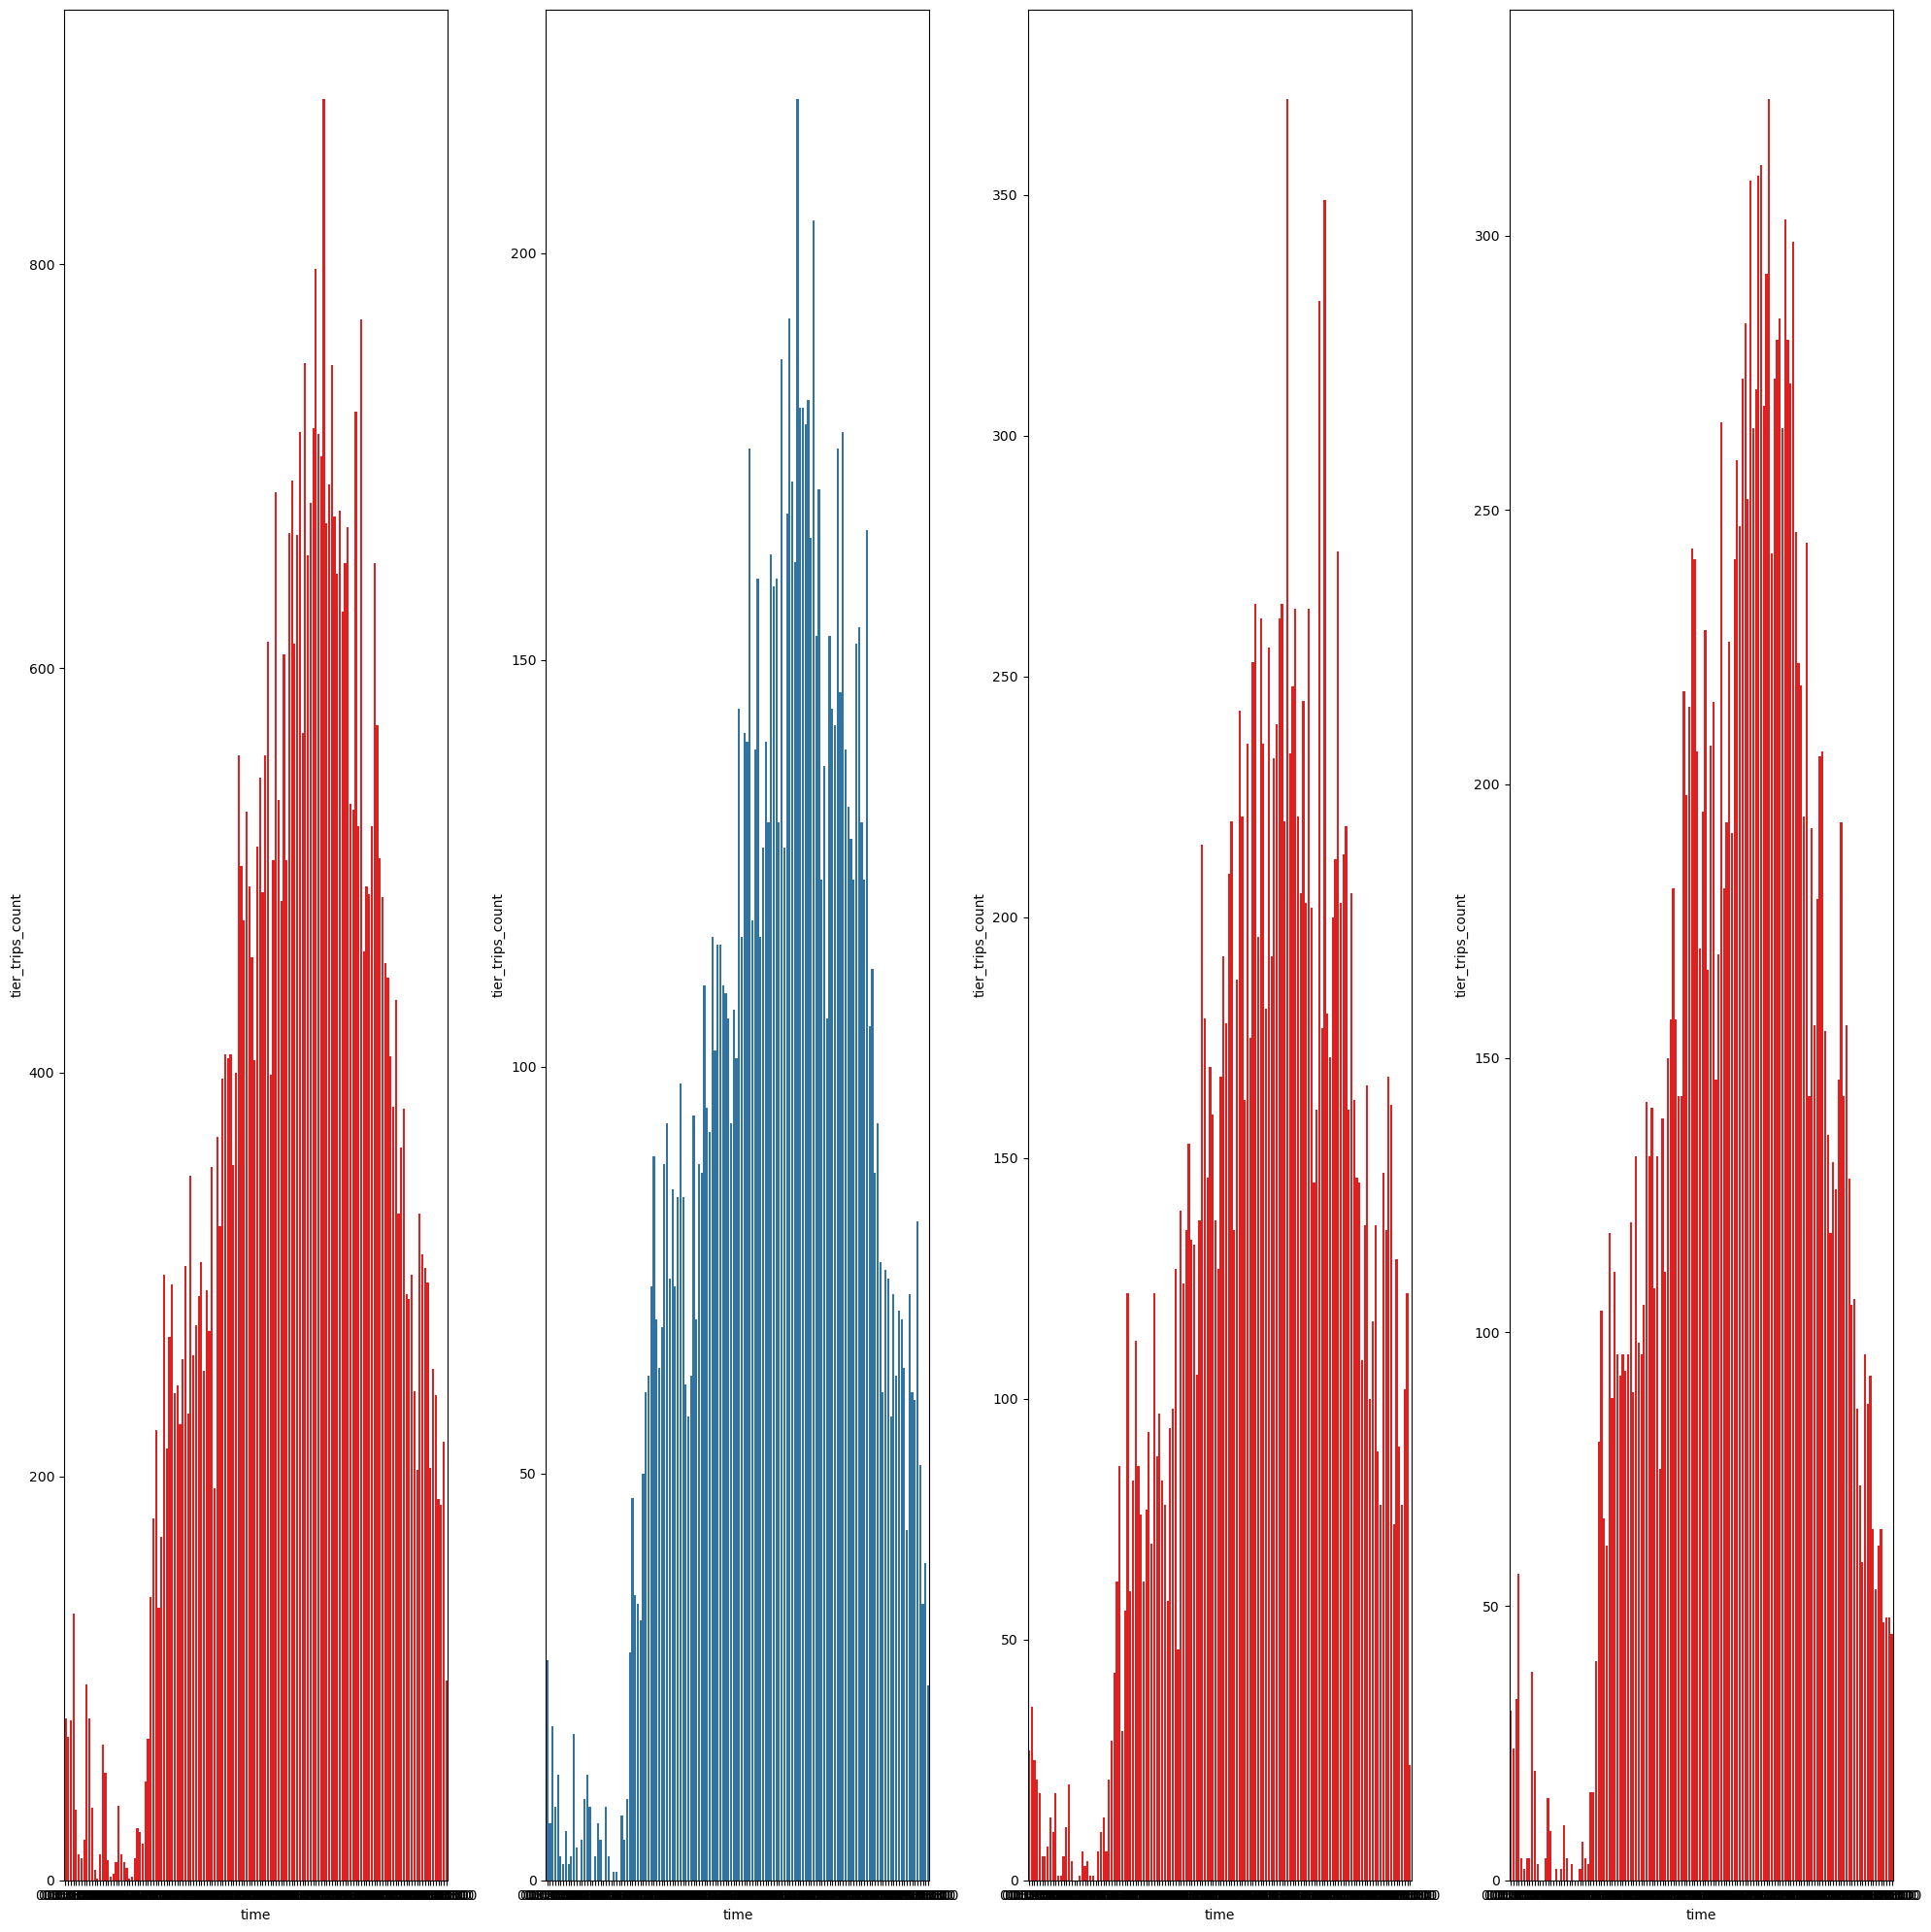

In [84]:
# tier time
#f, axes = plt.subplots(1, 2,3,4)
fig, axes = plt.subplots(ncols=4)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(min10, x="time", y="tier_trips_count", ax=axes[0], color='Red')
sns.barplot(min10_delay, x="time", y="tier_trips_count", ax=axes[1])
sns.barplot(min10_no_delay, x="time", y="tier_trips_count", ax=axes[2], color='Red')
sns.barplot(min10_nan_delay, x="time", y="tier_trips_count", ax=axes[3], color='Red')
plt.show()

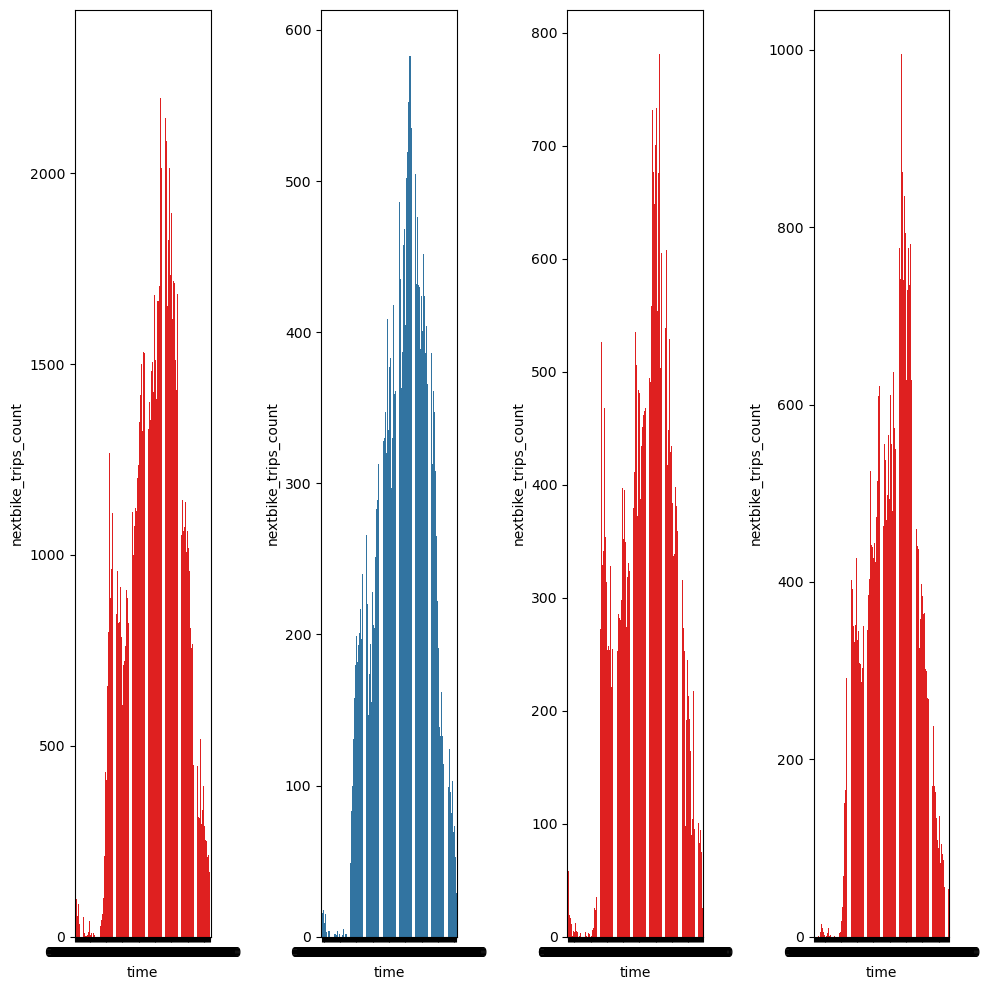

In [85]:
# next time
#f, axes = plt.subplots(1, 2,3,4)
fig, axes = plt.subplots(ncols=4)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(min10, x="time", y="nextbike_trips_count", ax=axes[0], color='Red')
sns.barplot(min10_delay, x="time", y="nextbike_trips_count", ax=axes[1])
sns.barplot(min10_no_delay, x="time", y="nextbike_trips_count", ax=axes[2], color='Red')
sns.barplot(min10_nan_delay, x="time", y="nextbike_trips_count", ax=axes[3], color='Red')
plt.show()

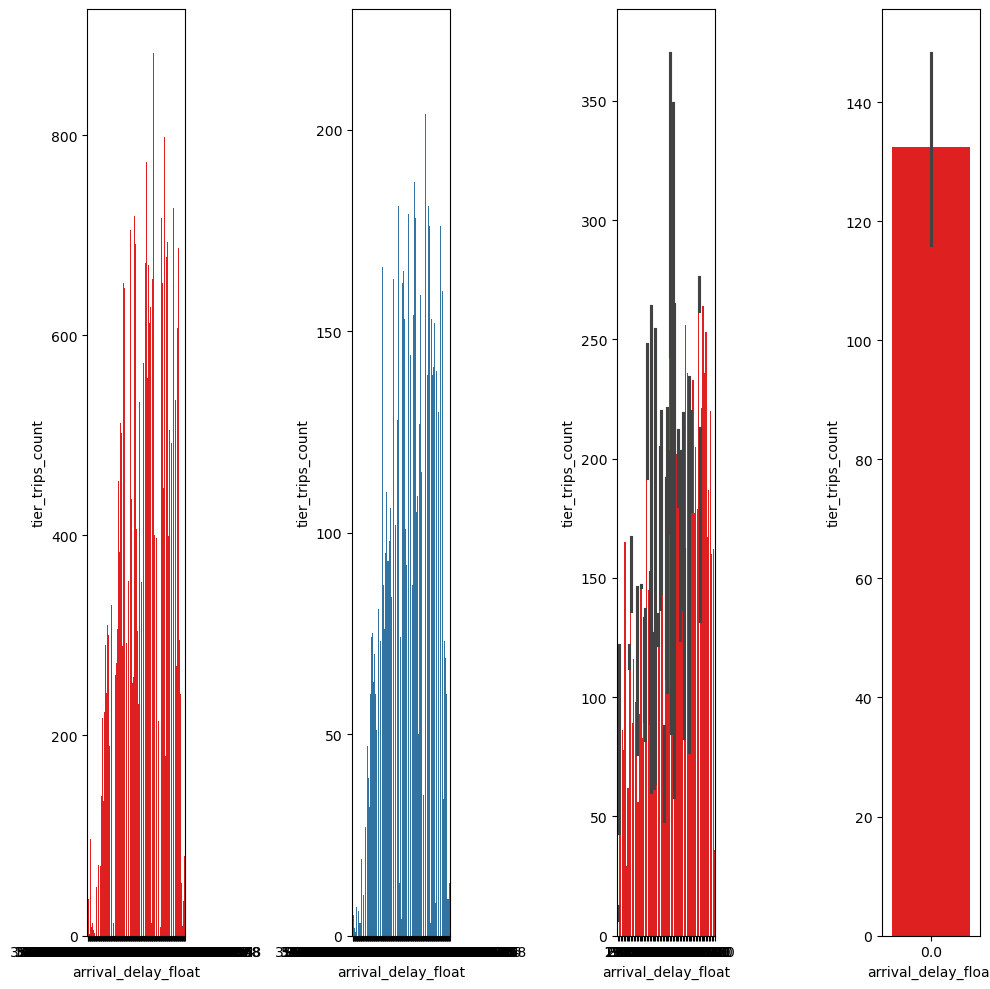

In [86]:
# tier delay
#f, axes = plt.subplots(1, 2,3,4)
fig, axes = plt.subplots(ncols=4)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(min10, x="arrival_delay_float", y="tier_trips_count", ax=axes[0], color='Red')
sns.barplot(min10_delay, x="arrival_delay_float", y="tier_trips_count", ax=axes[1])
sns.barplot(min10_no_delay, x="arrival_delay_float", y="tier_trips_count", ax=axes[2], color='Red')
sns.barplot(min10_nan_delay, x="arrival_delay_float", y="tier_trips_count", ax=axes[3], color='Red')
plt.show()

In [87]:
min10_delay

route_id  agency_id  route_type  service_id  direction_id  shape_id  \
time                                                                            
00:00:00   1298009      14268        6357     6862179          1280   9158851   
00:10:00    805147      10464        3783    12689109           867   8042458   
00:20:00    969914      12468        4677    13627080           905   7130729   
00:30:00    762233       8832        3495     8133864           461   6541264   
00:40:00   1278338      13272        5535     9753437           174  12992215   
...            ...        ...         ...         ...           ...       ...   
23:10:00   3726327      39198       18231    12161021          3584  22426492   
23:20:00   3731451      40104       18276    15690717          3140  23081941   
23:30:00   3437639      35946       16926     9211834          2897  22934468   
23:40:00   2525768      27174       12306    11290457          2375  16373794   
23:50:00   2173827      24042       10569    12548265          1733  12505630   

           stop_id  vrs_timestamp  stop_sequence  service  ...  \
time                                                       ...   
00:00:00   5677705      528296391          55635     2028  ...   
00:10:00   4759563      388642249          39059     1488  ...   
00:20:00   4297394      465057673          48179     1817  ...   
00:30:00   2998377      333773833          31489     1279  ...   
00:40:00   5086349      510782532          23623     1910  ...   
...            ...            ...            ...      ...  ...   
23:10:00  15430894     1411606069         132629     6533  ...   
23:20:00  15779555     1451990425         135873     6684  ...   
23:30:00  14091770     1309094945         122530     5991  ...   
23:40:00  10428669      993411334         109496     4529  ...   
23:50:00   9315050      885081335          97946     4007  ...   

          departure_delay_float  actual_arrival_time_float  \
time                                                         
00:00:00            1576.666667                     955080   
00:10:00             901.000000                    2480705   
00:20:00            1024.083333                    5059150   
00:30:00            9846.833333                    6771190   
00:40:00           19144.133333                   13443175   
...                         ...                        ...   
23:10:00            3640.000000                 1488035640   
23:20:00            3589.333333                 1534097665   
23:30:00            6227.583333                 1367116485   
23:40:00            2507.416667                 1021672995   
23:50:00            1915.500000                  902933670   

          actual_departure_time_float  arrival_delay_span  weather_int  \
time                                                                     
00:00:00                      1132200                   0          351   
00:10:00                      2568660                   0          241   
00:20:00                      5114085                   0          233   
00:30:00                      6901630                   0          173   
00:40:00                     13803368                   0          301   
...                               ...                 ...          ...   
23:10:00                   1512227880                   0         1246   
23:20:00                   1553989160                   0         1327   
23:30:00                   1399008935                   0         1148   
23:40:00                   1061849185                   0          898   
23:50:00                    941620330                   0          780   

          time_span_int_arrival  weekend  time_span_int  delay_category  \
time                                                                      
00:00:00                      0     2173              0            2378   
00:10:00                      0     1570              0            1744   
00:20:00                   

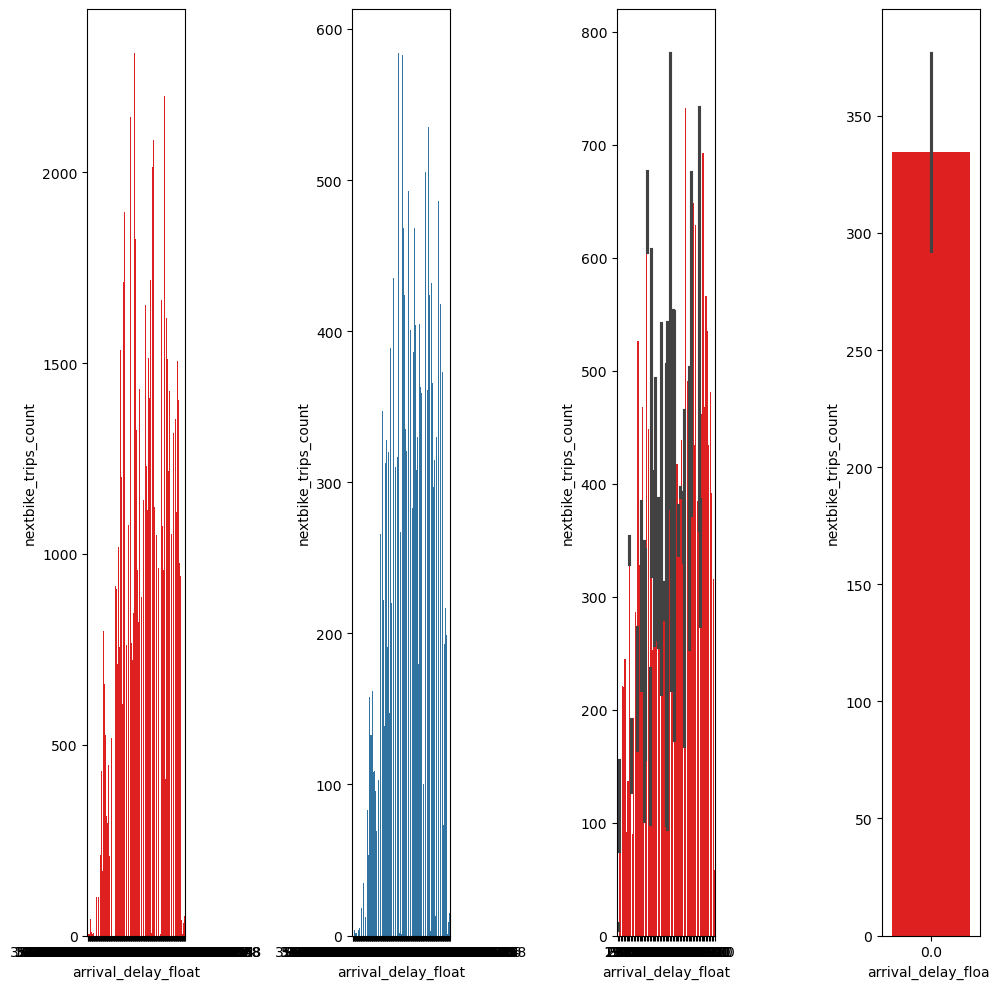

In [88]:
# nextbike delay
#f, axes = plt.subplots(1, 2,3,4)
fig, axes = plt.subplots(ncols=4)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(min10, x="arrival_delay_float", y="nextbike_trips_count", ax=axes[0], color='Red')
sns.barplot(min10_delay, x="arrival_delay_float", y="nextbike_trips_count", ax=axes[1])
sns.barplot(min10_no_delay, x="arrival_delay_float", y="nextbike_trips_count", ax=axes[2], color='Red')
sns.barplot(min10_nan_delay, x="arrival_delay_float", y="nextbike_trips_count", ax=axes[3], color='Red')
plt.show()

Vergleich time und delay

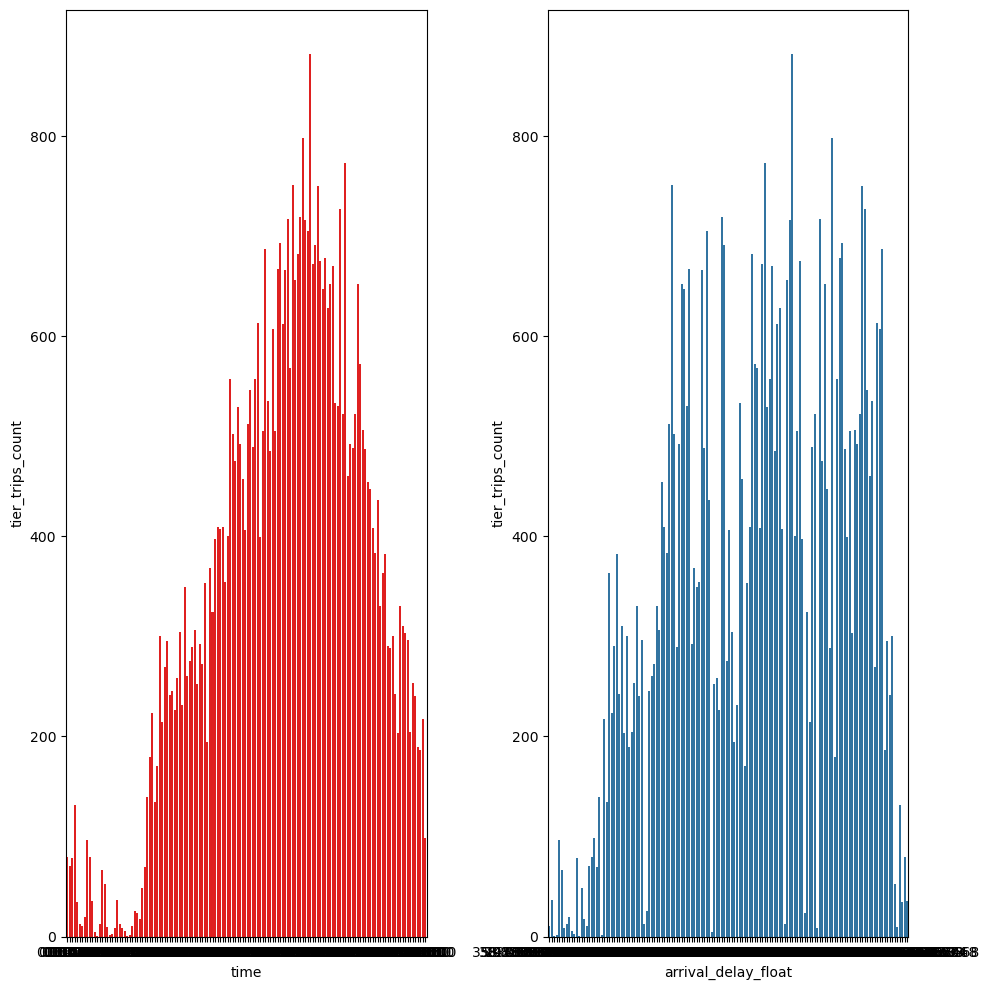

In [89]:
# tier data
#f, axes = plt.subplots(1, 2,3,4)
fig, axes = plt.subplots(ncols=2)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(min10, x="time", y="tier_trips_count", ax=axes[0], color='Red')
sns.barplot(min10, x="arrival_delay_float", y="tier_trips_count", ax=axes[1])
plt.show()

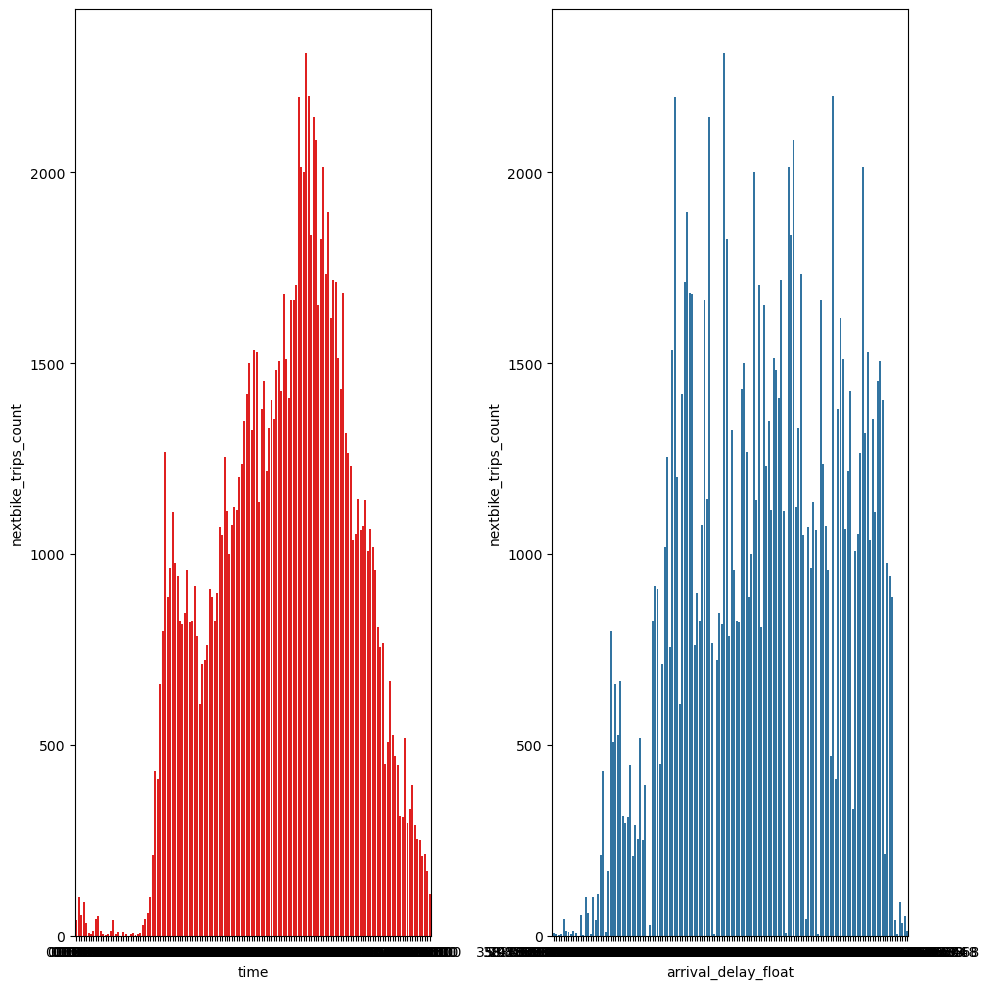

In [90]:
# nextbike data
#f, axes = plt.subplots(1, 2,3,4)
fig, axes = plt.subplots(ncols=2)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(min10, x="time", y="nextbike_trips_count", ax=axes[0], color='Red')
sns.barplot(min10, x="arrival_delay_float", y="nextbike_trips_count", ax=axes[1])
plt.show()

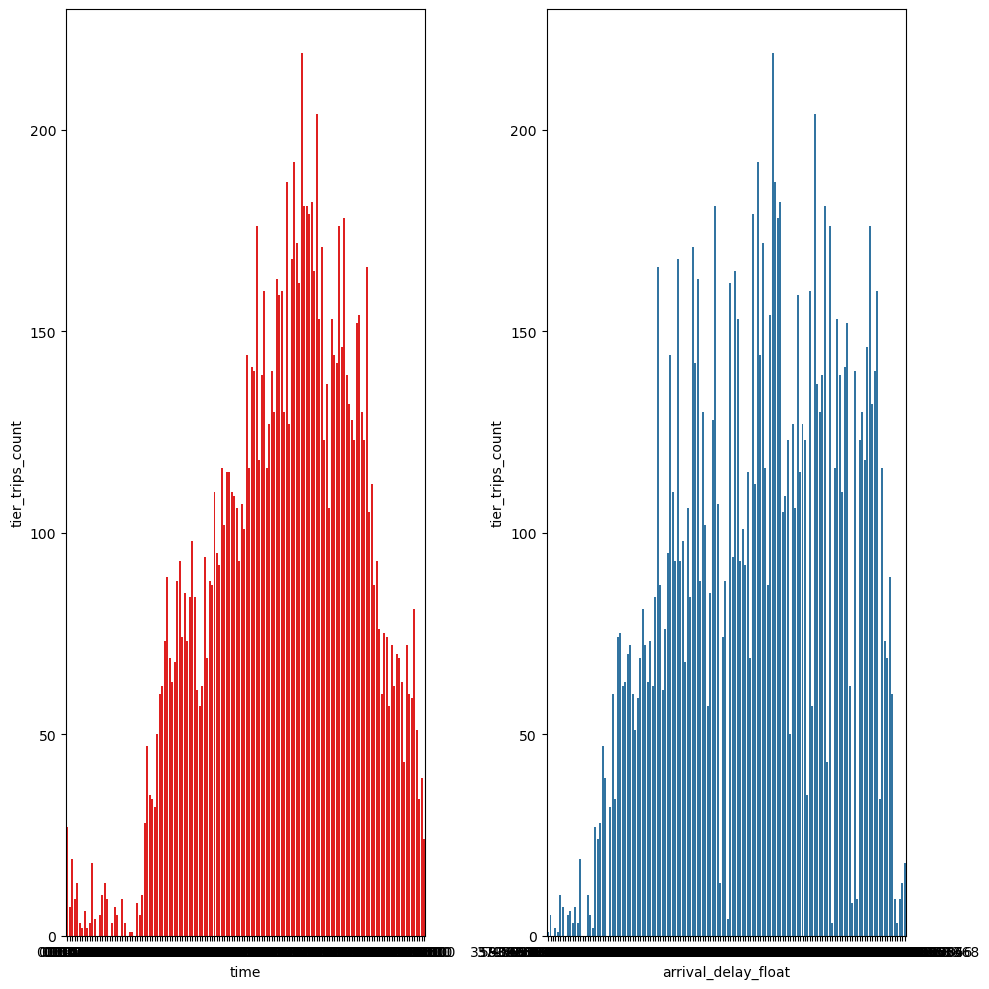

In [91]:
# tier delay
#f, axes = plt.subplots(1, 2,3,4)
fig, axes = plt.subplots(ncols=2)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(min10_delay, x="time", y="tier_trips_count", ax=axes[0], color='Red')
sns.barplot(min10_delay, x="arrival_delay_float", y="tier_trips_count", ax=axes[1])
plt.show()

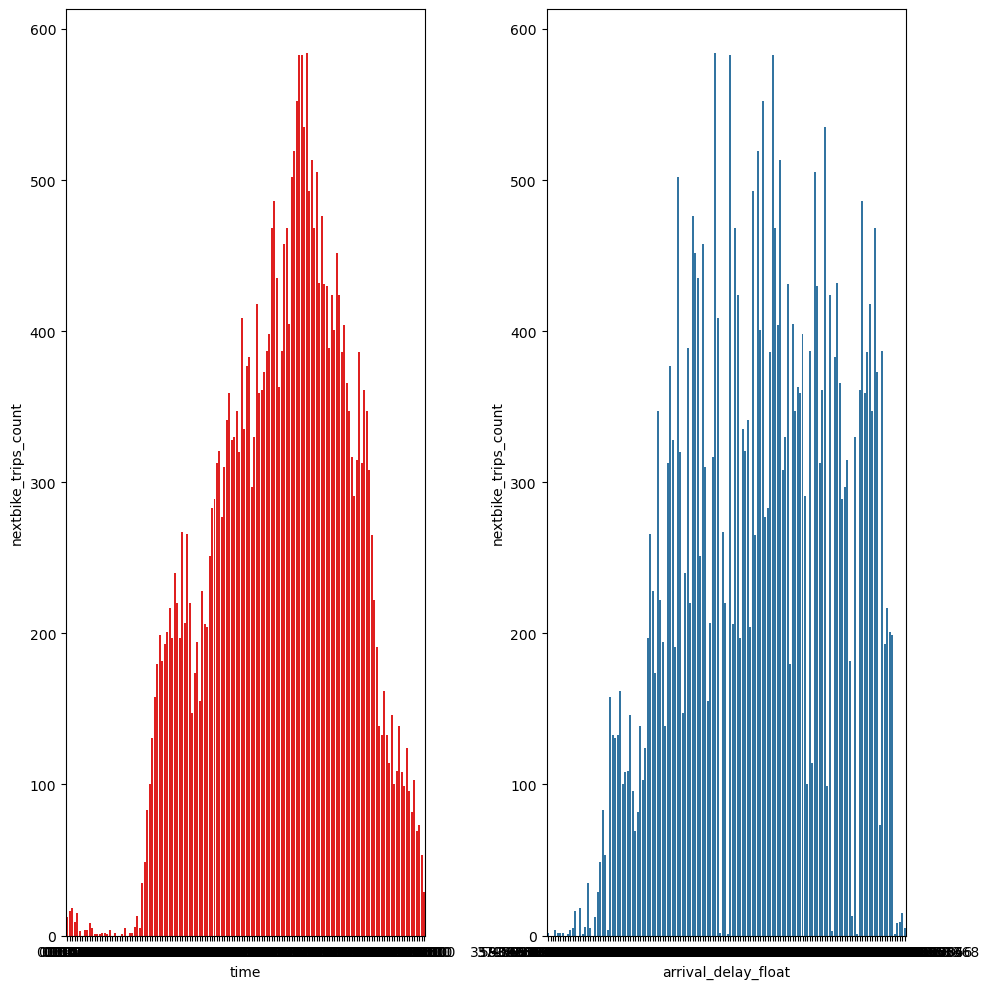

In [92]:
# nextbike delay
#f, axes = plt.subplots(1, 2,3,4)
fig, axes = plt.subplots(ncols=2)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(min10_delay, x="time", y="nextbike_trips_count", ax=axes[0], color='Red')
sns.barplot(min10_delay, x="arrival_delay_float", y="nextbike_trips_count", ax=axes[1])
plt.show()

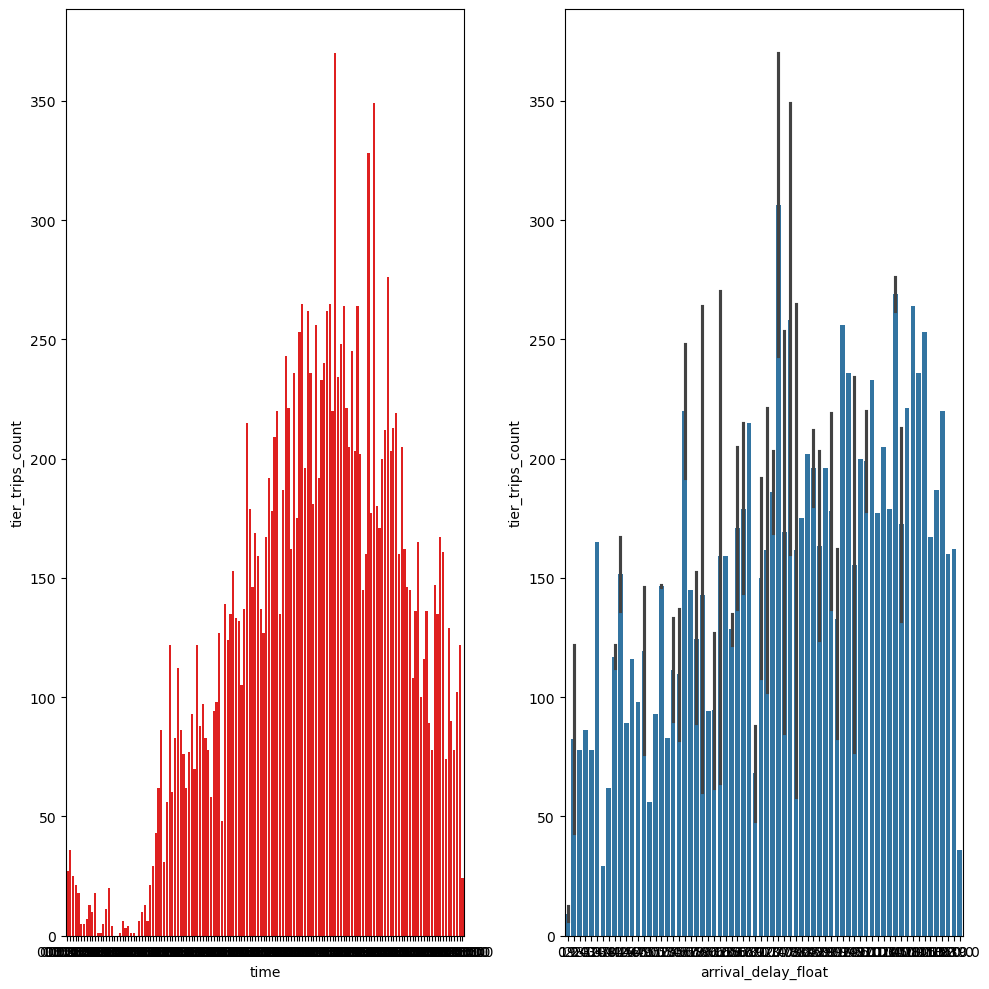

In [93]:
# tier no_delay
#f, axes = plt.subplots(1, 2,3,4)
fig, axes = plt.subplots(ncols=2)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(min10_no_delay, x="time", y="tier_trips_count", ax=axes[0], color='Red')
sns.barplot(min10_no_delay, x="arrival_delay_float", y="tier_trips_count", ax=axes[1])
plt.show()

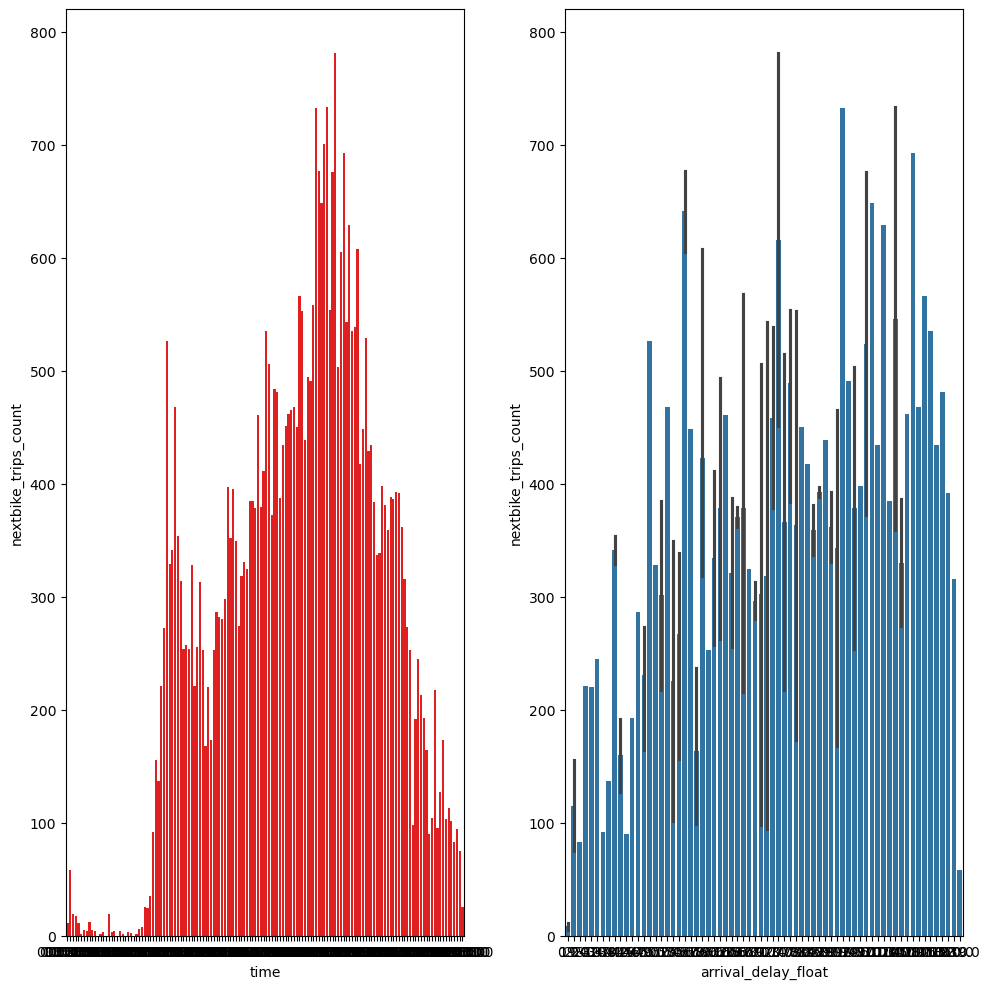

In [94]:
# nextbike no_delay
#f, axes = plt.subplots(1, 2,3,4)
fig, axes = plt.subplots(ncols=2)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(min10_no_delay, x="time", y="nextbike_trips_count", ax=axes[0], color='Red')
sns.barplot(min10_no_delay, x="arrival_delay_float", y="nextbike_trips_count", ax=axes[1])
plt.show()

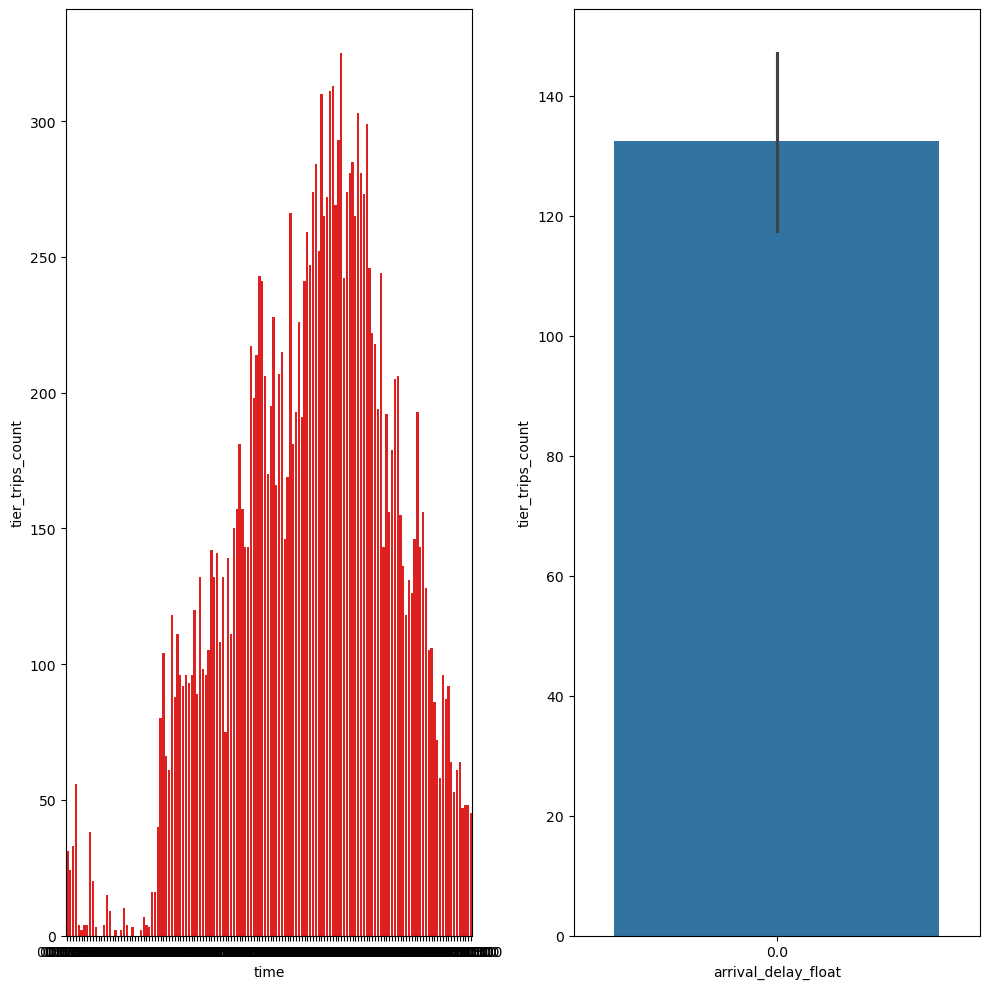

In [95]:
# tier nan_delay
#f, axes = plt.subplots(1, 2,3,4)
fig, axes = plt.subplots(ncols=2)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(min10_nan_delay, x="time", y="tier_trips_count", ax=axes[0], color='Red')
sns.barplot(min10_nan_delay, x="arrival_delay_float", y="tier_trips_count", ax=axes[1])
plt.show()

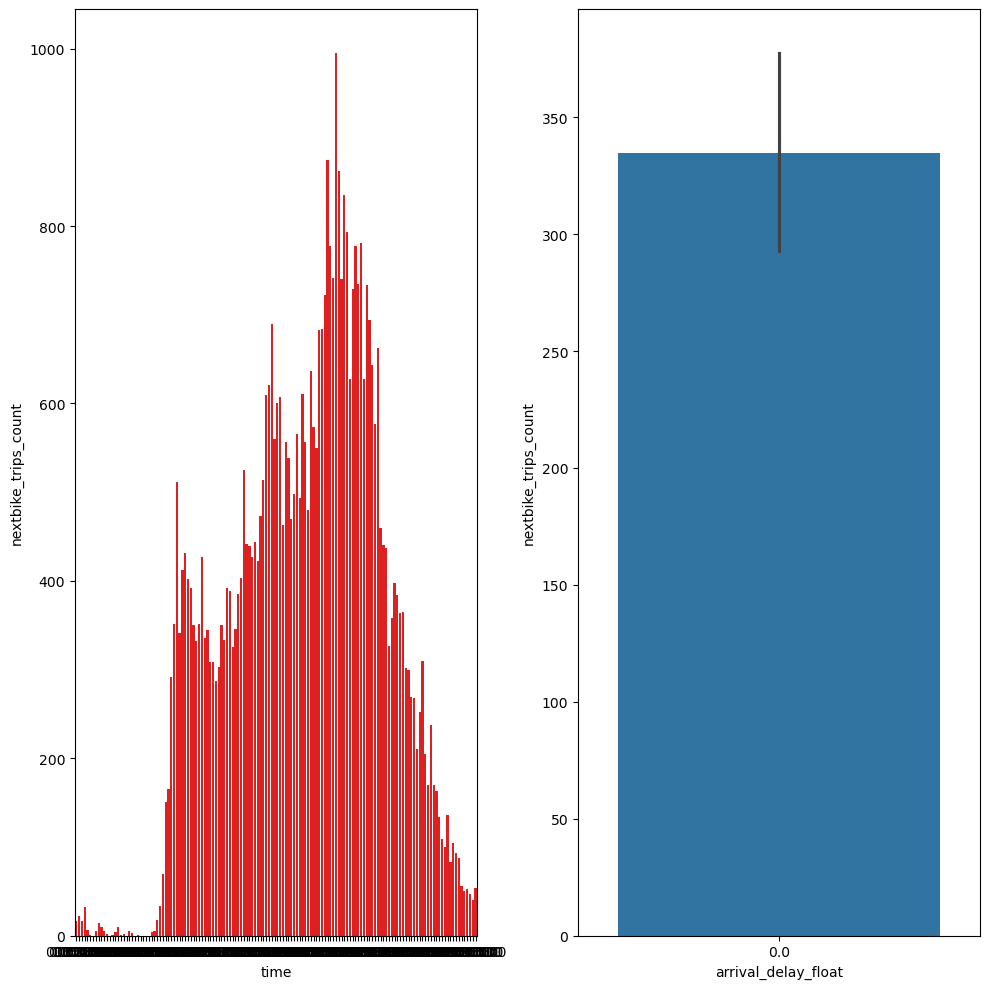

In [96]:
# nextbike nan_delay
#f, axes = plt.subplots(1, 2,3,4)
fig, axes = plt.subplots(ncols=2)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(min10_nan_delay, x="time", y="nextbike_trips_count", ax=axes[0], color='Red')
sns.barplot(min10_nan_delay, x="arrival_delay_float", y="nextbike_trips_count", ax=axes[1])
plt.show()

# Tier Trips every 10 min
plot = sns.barplot(min10, x="time", y="tier_trips_count")
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
plot

# NExtbike Trips every 10 min
plot = sns.barplot(min10, x="time", y="nextbike_trips_count")
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
plot

# Tier trips for delay 
plot = sns.barplot(min10, x="arrival_delay_float", y="tier_trips_count")
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
plot

# NExtbike trips for delay 
plot = sns.barplot(min10, x="arrival_delay_float", y="nextbike_trips_count")
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
plot

In [97]:
min30 = data.groupby([pd.Grouper(key='scheduled_arrival_time', freq='30Min')]).sum(numeric_only=True)

In [98]:
min30['time'] = pd.to_datetime(min30.index).time

In [99]:
min30 = min30.groupby([pd.Grouper(key='time')]).sum(numeric_only=True)

In [100]:
min30_delay = delay.groupby([pd.Grouper(key='scheduled_arrival_time', freq='30Min')]).sum(numeric_only=True)
min30_delay['time'] = pd.to_datetime(min30_delay.index).time
min30_delay = min30_delay.groupby([pd.Grouper(key='time')]).sum(numeric_only=True)

In [101]:
min30_no_delay = no_delay.groupby([pd.Grouper(key='scheduled_arrival_time', freq='30Min')]).sum(numeric_only=True)
min30_no_delay['time'] = pd.to_datetime(min30_no_delay.index).time
min30_no_delay = min30_no_delay.groupby([pd.Grouper(key='time')]).sum(numeric_only=True)

In [102]:
min30_nan_delay = nan_delay.groupby([pd.Grouper(key='scheduled_arrival_time', freq='30Min')]).sum(numeric_only=True)
min30_nan_delay['time'] = pd.to_datetime(min30_nan_delay.index).time
min30_nan_delay = min30_nan_delay.groupby([pd.Grouper(key='time')]).sum(numeric_only=True)

In [103]:
min30_nan_delay.index

Index([00:00:00, 00:30:00, 01:00:00, 01:30:00, 02:00:00, 02:30:00, 03:00:00,
       03:30:00, 04:00:00, 04:30:00, 05:00:00, 05:30:00, 06:00:00, 06:30:00,
       07:00:00, 07:30:00, 08:00:00, 08:30:00, 09:00:00, 09:30:00, 10:00:00,
       10:30:00, 11:00:00, 11:30:00, 12:00:00, 12:30:00, 13:00:00, 13:30:00,
       14:00:00, 14:30:00, 15:00:00, 15:30:00, 16:00:00, 16:30:00, 17:00:00,
       17:30:00, 18:00:00, 18:30:00, 19:00:00, 19:30:00, 20:00:00, 20:30:00,
       21:00:00, 21:30:00, 22:00:00, 22:30:00, 23:00:00, 23:30:00],
      dtype='object', name='time')

/tmp/ipykernel_3072574/264193744.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, y[i], y[i], ha = 'center')


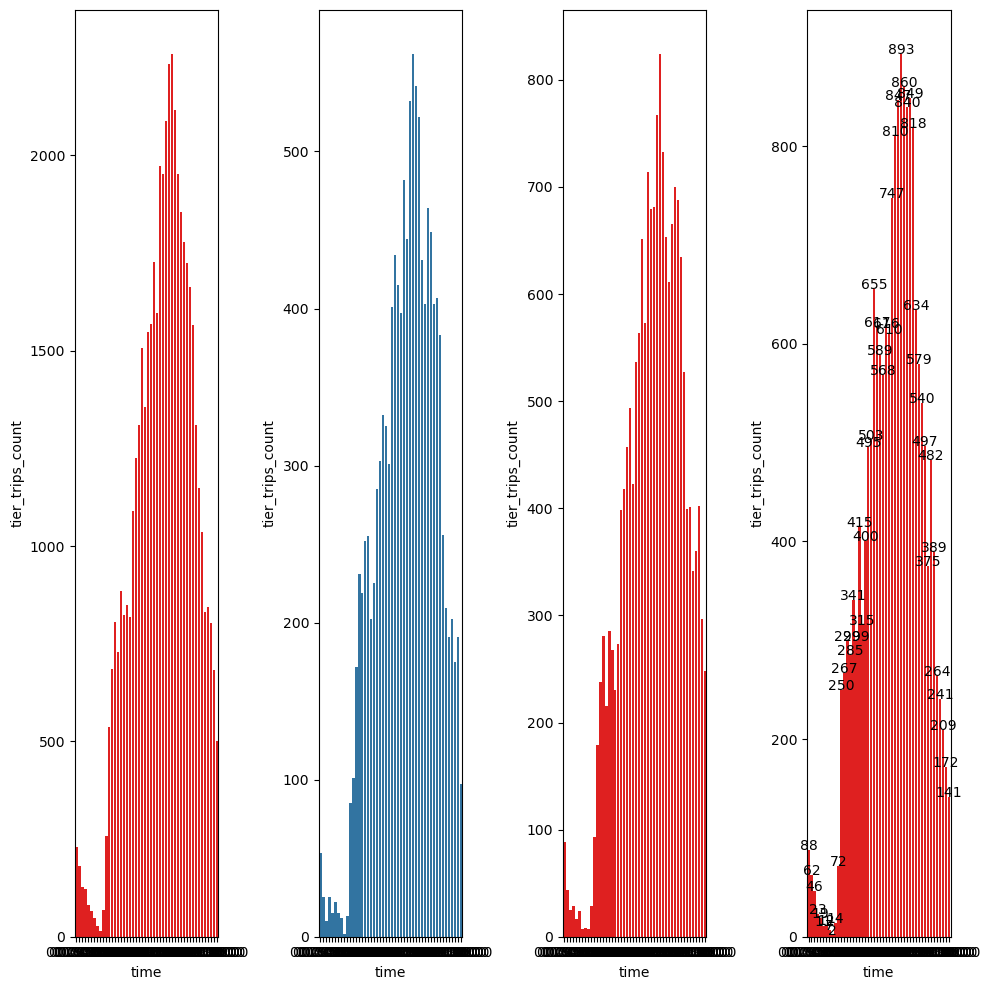

In [104]:
# tier
#f, axes = plt.subplots(1, 2,3,4)
fig, axes = plt.subplots(ncols=4)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(min30, x="time", y="tier_trips_count", ax=axes[0], color='Red')
sns.barplot(min30_delay, x="time", y="tier_trips_count", ax=axes[1])
sns.barplot(min30_no_delay, x="time", y="tier_trips_count", ax=axes[2], color='Red')
sns.barplot(min30_nan_delay, x="time", y="tier_trips_count", ax=axes[3], color='Red')
addlabels(min30_nan_delay.index, min30_nan_delay['tier_trips_count'])
plt.show()

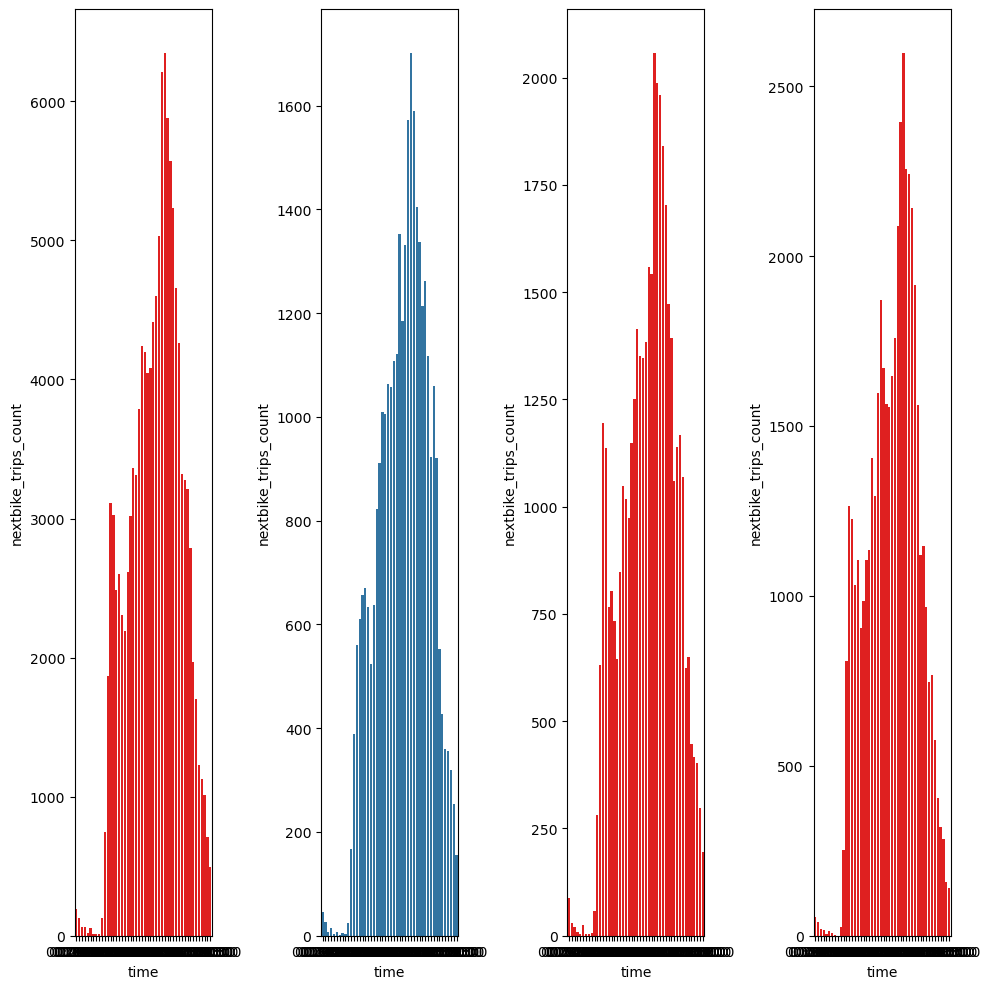

In [105]:
# next time
#f, axes = plt.subplots(1, 2,3,4)
fig, axes = plt.subplots(ncols=4)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(min30, x="time", y="nextbike_trips_count", ax=axes[0], color='Red')
sns.barplot(min30_delay, x="time", y="nextbike_trips_count", ax=axes[1])
sns.barplot(min30_no_delay, x="time", y="nextbike_trips_count", ax=axes[2], color='Red')
sns.barplot(min30_nan_delay, x="time", y="nextbike_trips_count", ax=axes[3], color='Red')
plt.show()

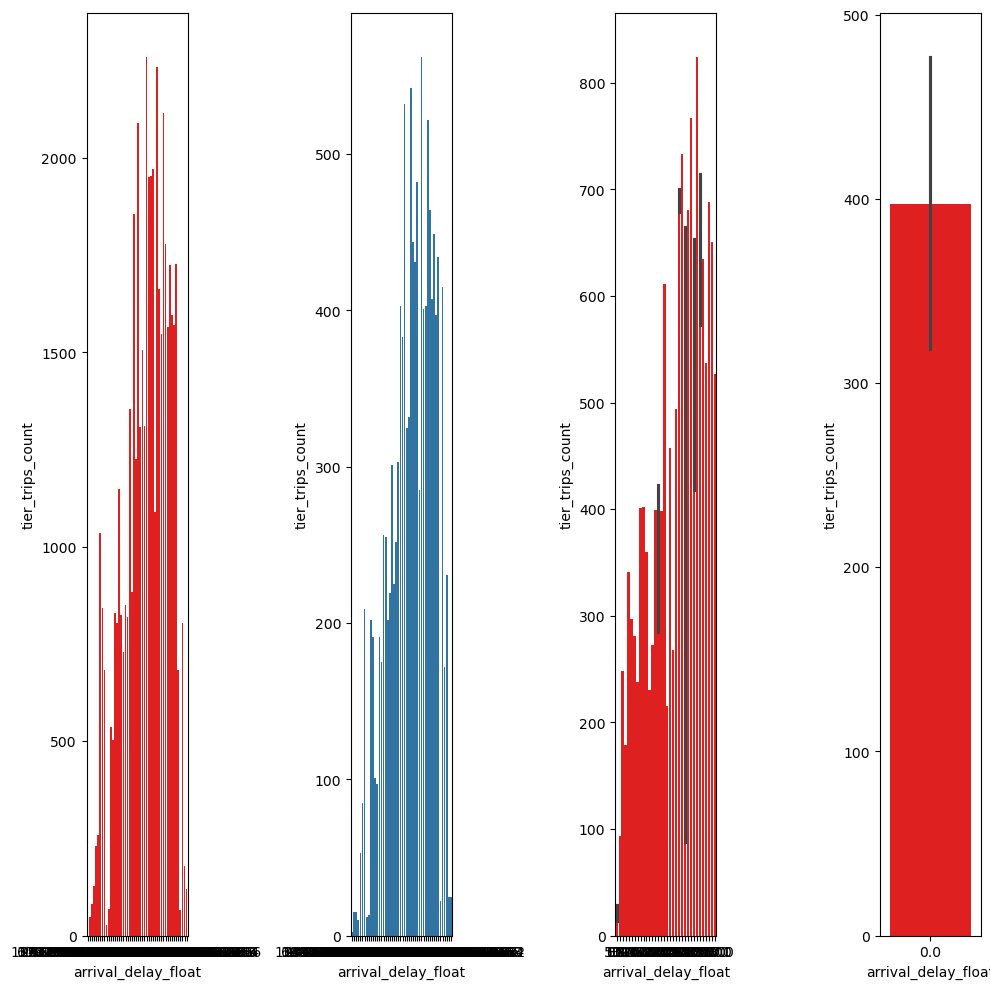

In [106]:
# tier delay
#f, axes = plt.subplots(1, 2,3,4)
fig, axes = plt.subplots(ncols=4)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(min30, x="arrival_delay_float", y="tier_trips_count", ax=axes[0], color='Red')
sns.barplot(min30_delay, x="arrival_delay_float", y="tier_trips_count", ax=axes[1])
sns.barplot(min30_no_delay, x="arrival_delay_float", y="tier_trips_count", ax=axes[2], color='Red')
sns.barplot(min30_nan_delay, x="arrival_delay_float", y="tier_trips_count", ax=axes[3], color='Red')
plt.show()

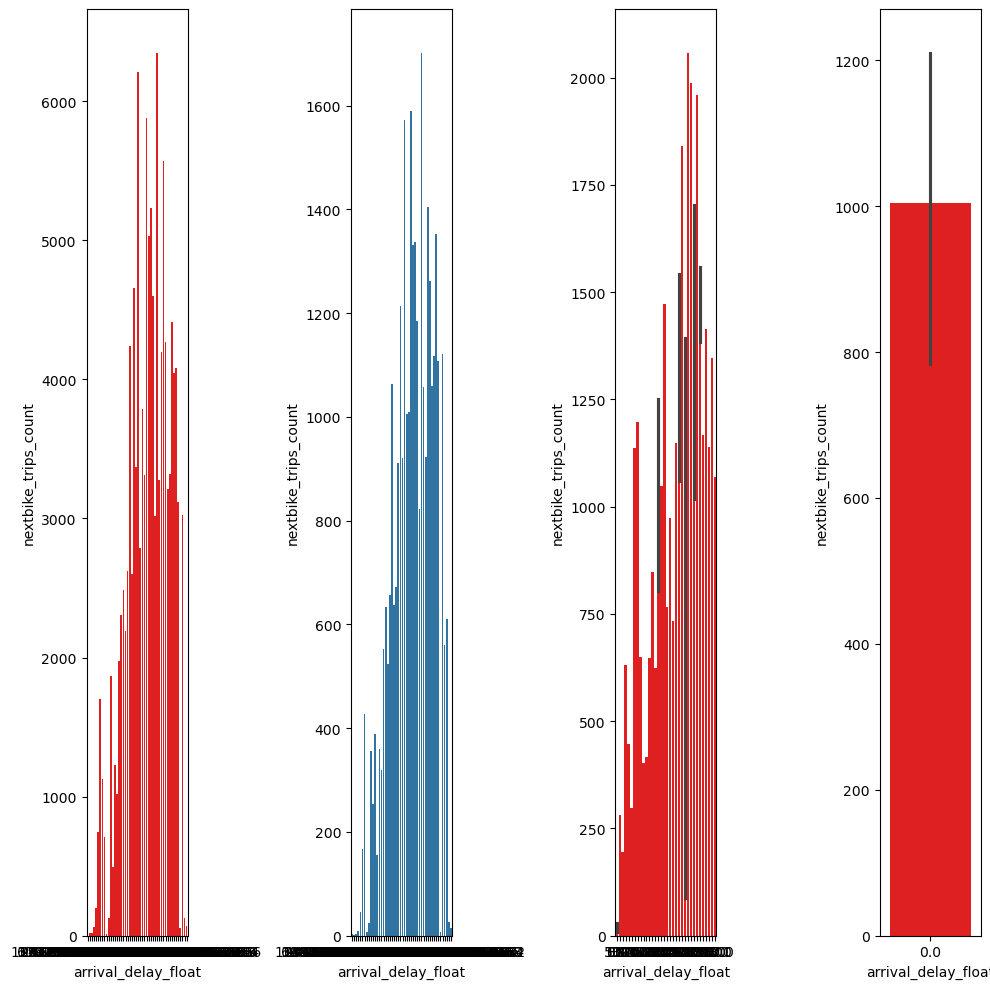

In [107]:
# next delay
#f, axes = plt.subplots(1, 2,3,4)
fig, axes = plt.subplots(ncols=4)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(min30, x="arrival_delay_float", y="nextbike_trips_count", ax=axes[0], color='Red')
sns.barplot(min30_delay, x="arrival_delay_float", y="nextbike_trips_count", ax=axes[1])
sns.barplot(min30_no_delay, x="arrival_delay_float", y="nextbike_trips_count", ax=axes[2], color='Red')
sns.barplot(min30_nan_delay, x="arrival_delay_float", y="nextbike_trips_count", ax=axes[3], color='Red')
plt.show()

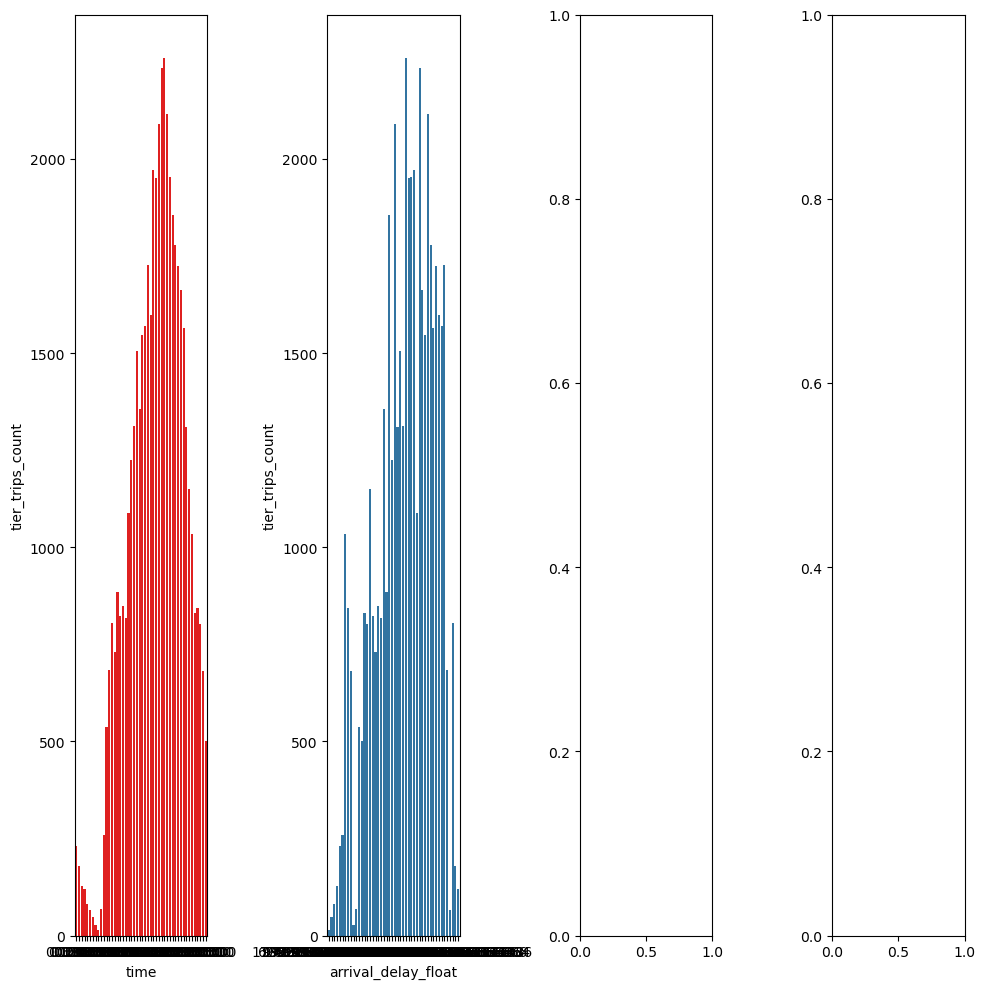

In [108]:
# tier data
#f, axes = plt.subplots(1, 2,3,4)
fig, axes = plt.subplots(ncols=4)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(min30, x="time", y="tier_trips_count", ax=axes[0], color='Red')
sns.barplot(min30, x="arrival_delay_float", y="tier_trips_count", ax=axes[1])
plt.show()

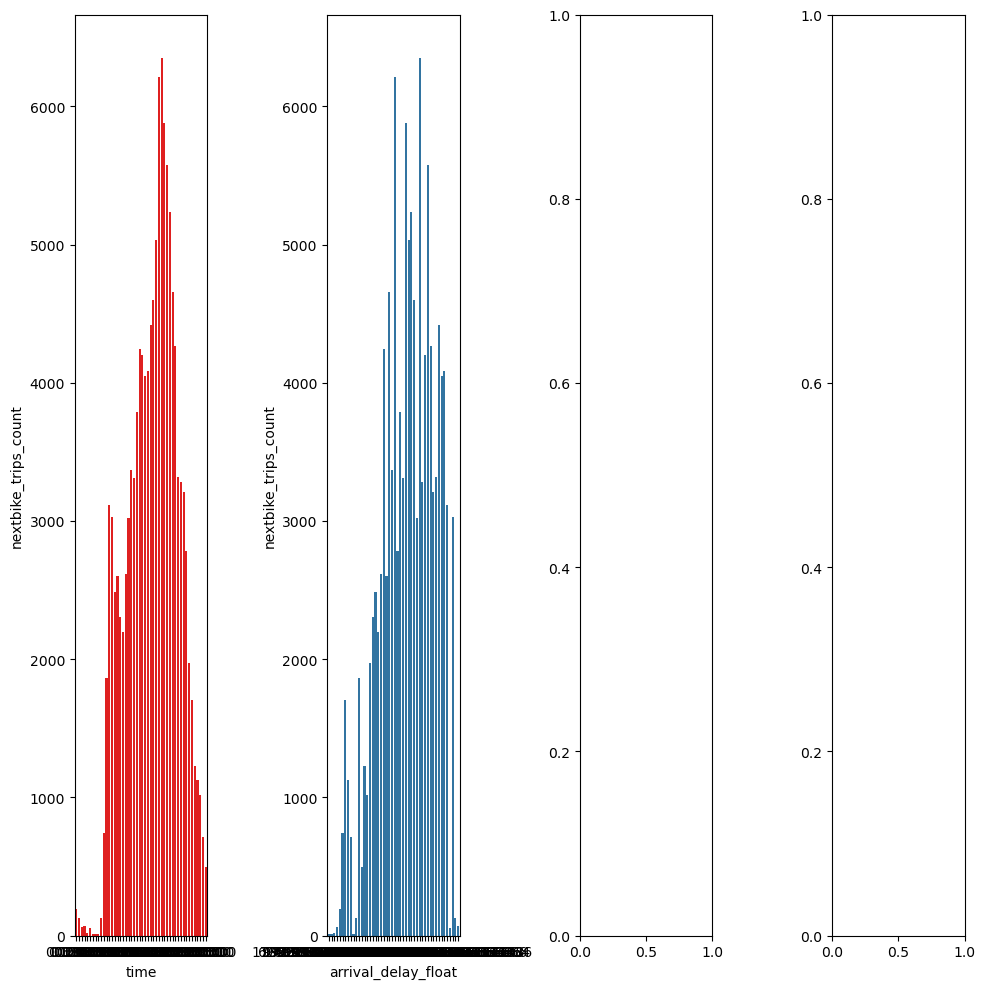

In [109]:
# next data
#f, axes = plt.subplots(1, 2,3,4)
fig, axes = plt.subplots(ncols=4)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(min30, x="time", y="nextbike_trips_count", ax=axes[0], color='Red')
sns.barplot(min30, x="arrival_delay_float", y="nextbike_trips_count", ax=axes[1])
plt.show()

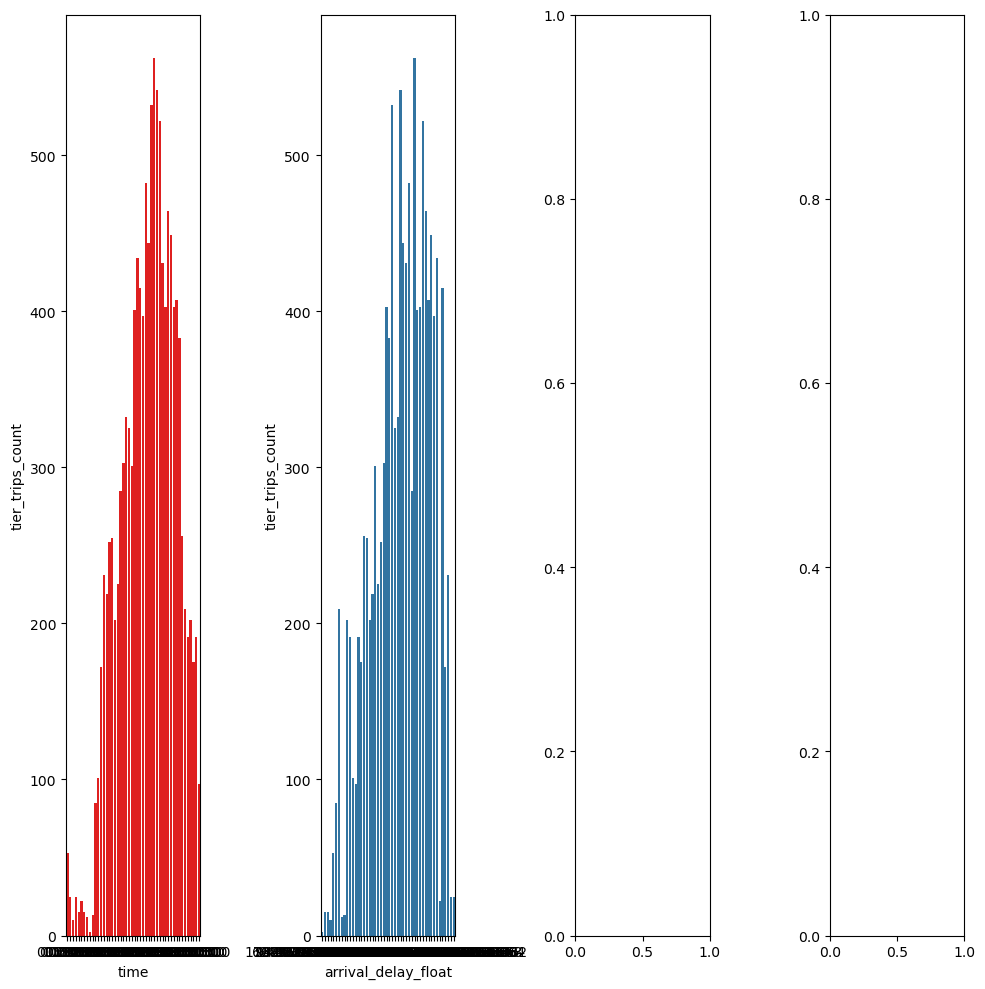

In [110]:
# tier delay
#f, axes = plt.subplots(1, 2,3,4)
fig, axes = plt.subplots(ncols=4)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(min30_delay, x="time", y="tier_trips_count", ax=axes[0], color='Red')
sns.barplot(min30_delay, x="arrival_delay_float", y="tier_trips_count", ax=axes[1])
plt.show()

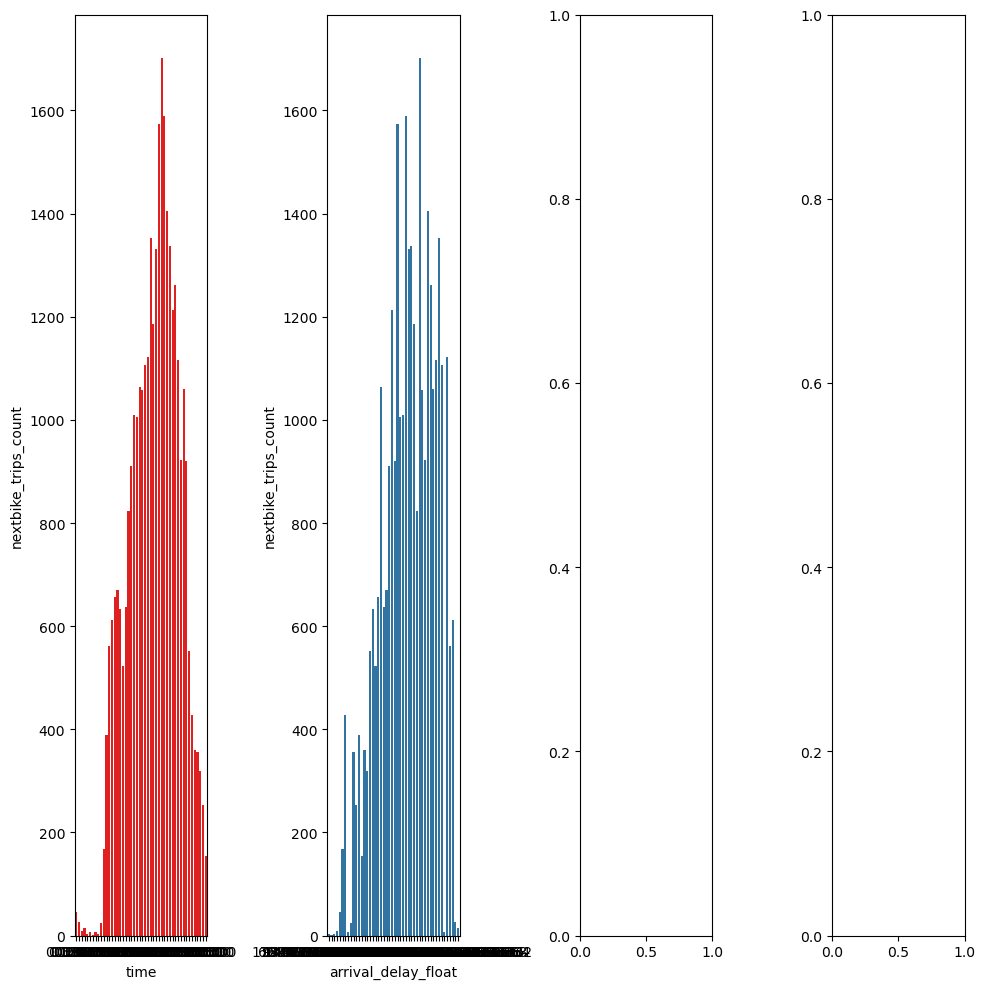

In [111]:
# next delay
#f, axes = plt.subplots(1, 2,3,4)
fig, axes = plt.subplots(ncols=4)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(min30_delay, x="time", y="nextbike_trips_count", ax=axes[0], color='Red')
sns.barplot(min30_delay, x="arrival_delay_float", y="nextbike_trips_count", ax=axes[1])
plt.show()

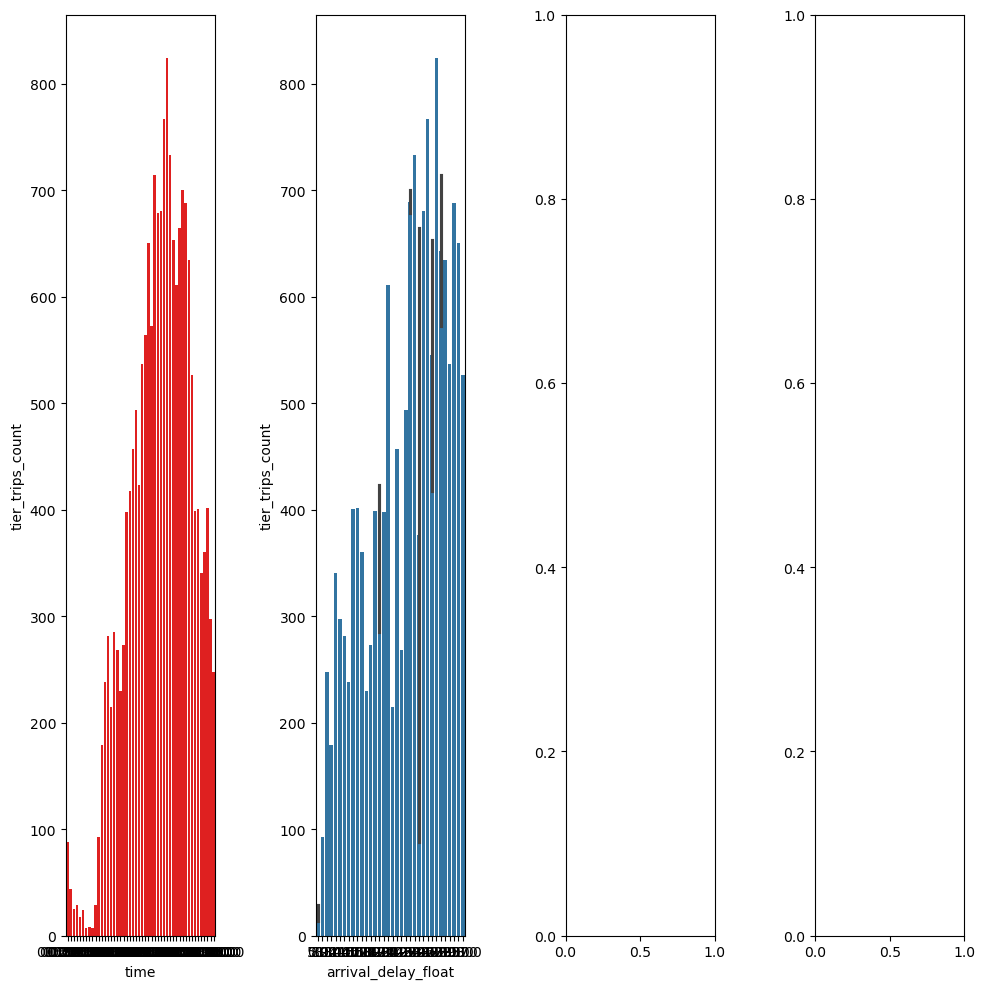

In [112]:
# tier no data
#f, axes = plt.subplots(1, 2,3,4)
fig, axes = plt.subplots(ncols=4)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(min30_no_delay, x="time", y="tier_trips_count", ax=axes[0], color='Red')
sns.barplot(min30_no_delay, x="arrival_delay_float", y="tier_trips_count", ax=axes[1])
plt.show()

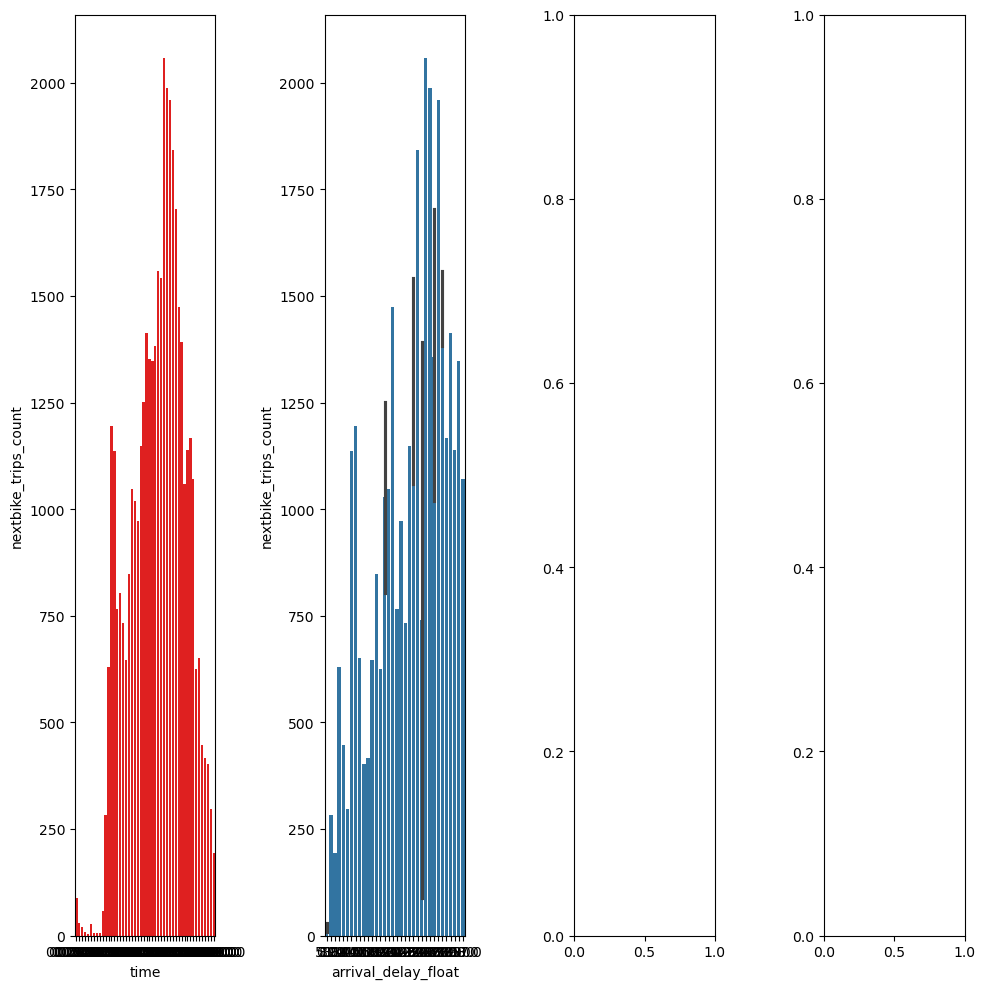

In [113]:
# next no delay
#f, axes = plt.subplots(1, 2,3,4)
fig, axes = plt.subplots(ncols=4)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(min30_no_delay, x="time", y="nextbike_trips_count", ax=axes[0], color='Red')
sns.barplot(min30_no_delay, x="arrival_delay_float", y="nextbike_trips_count", ax=axes[1])
plt.show()

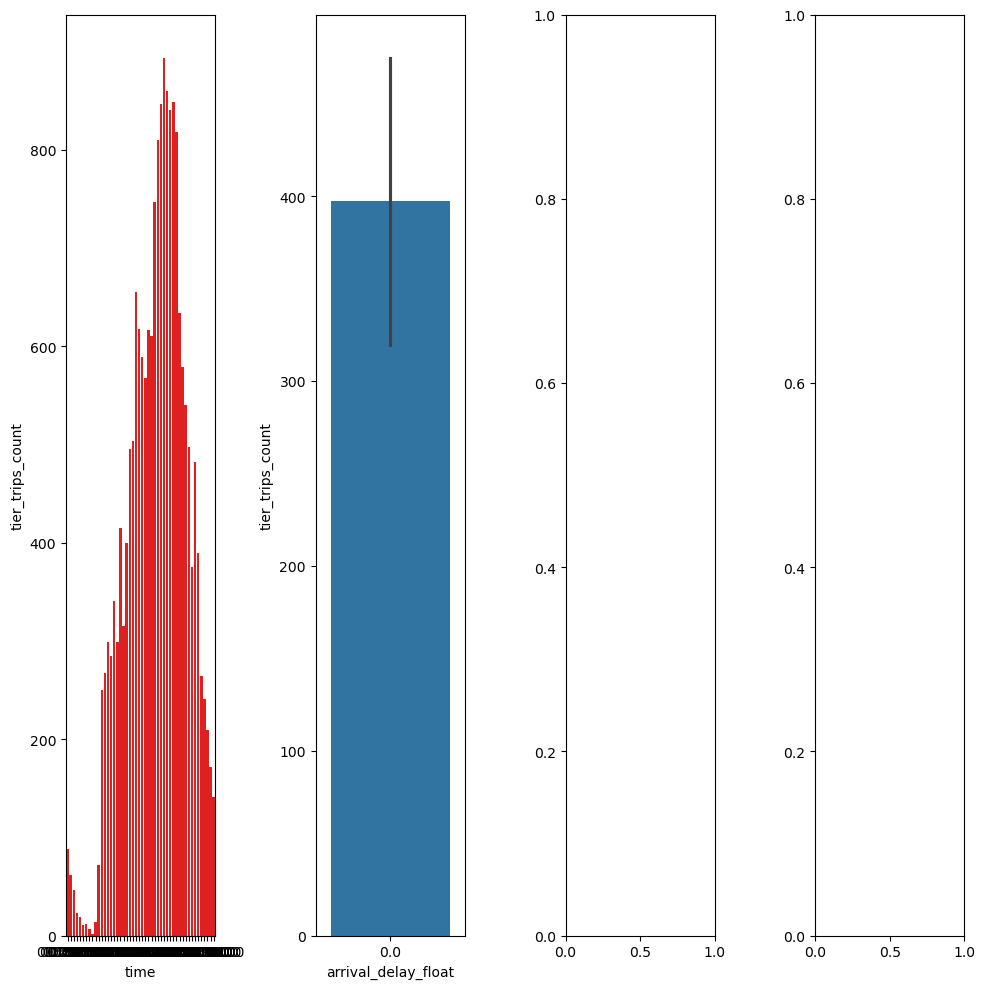

In [114]:
# tier nan data
#f, axes = plt.subplots(1, 2,3,4)
fig, axes = plt.subplots(ncols=4)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(min30_nan_delay, x="time", y="tier_trips_count", ax=axes[0], color='Red')
sns.barplot(min30_nan_delay, x="arrival_delay_float", y="tier_trips_count", ax=axes[1])
plt.show()

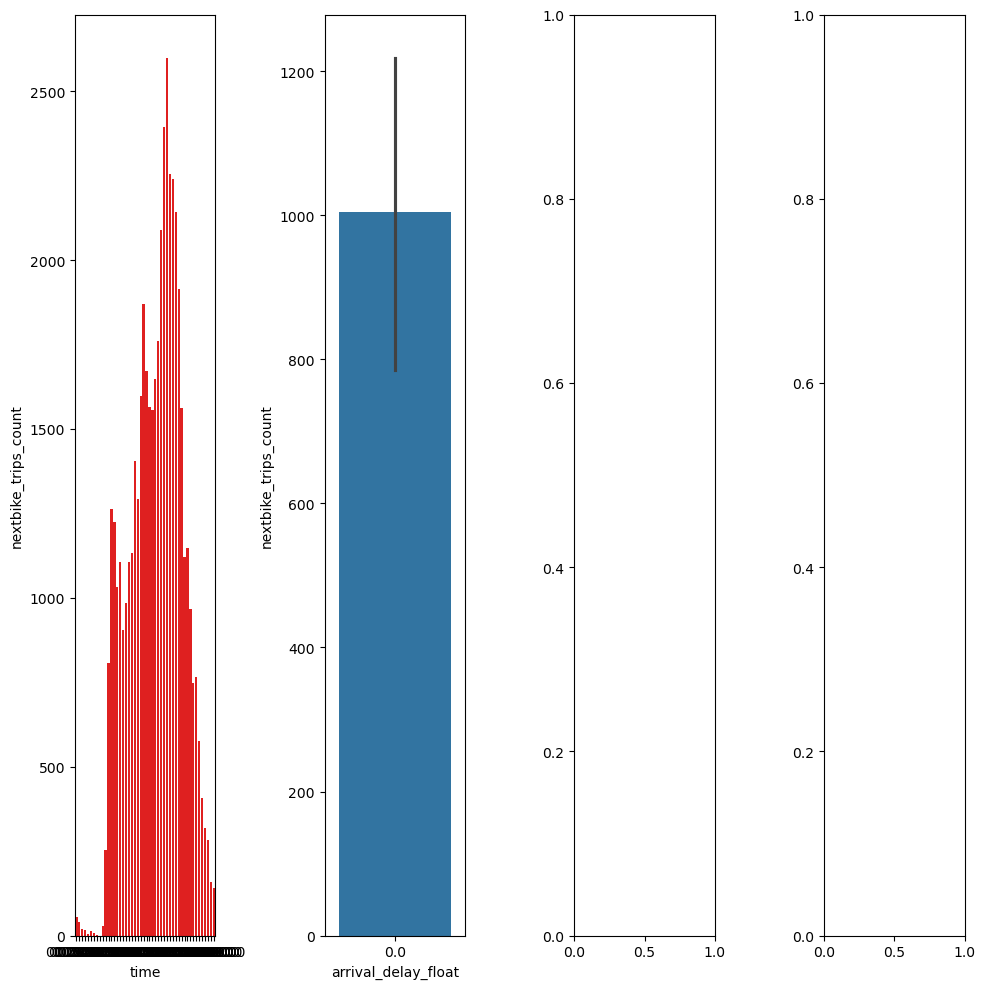

In [115]:
# tier nan data
#f, axes = plt.subplots(1, 2,3,4)
fig, axes = plt.subplots(ncols=4)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(min30_nan_delay, x="time", y="nextbike_trips_count", ax=axes[0], color='Red')
sns.barplot(min30_nan_delay, x="arrival_delay_float", y="nextbike_trips_count", ax=axes[1])
plt.show()

plot = sns.barplot(min30, x="time", y="tier_trips_count")
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
plot

plot = sns.barplot(min30, x="time", y="nextbike_trips_count")
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
plot

plot = sns.barplot(min30, x="arrival_delay_float", y="tier_trips_count")
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
plot

lot = sns.barplot(min30, x="arrival_delay_float", y="nextbike_trips_count")
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
plot

In [116]:
min60 = data.groupby([pd.Grouper(key='scheduled_arrival_time', freq='60Min')]).sum(numeric_only=True)

In [117]:
min60['time'] = pd.to_datetime(min60.index).time

In [118]:
min60 = min60.groupby([pd.Grouper(key='time')]).sum(numeric_only=True)

In [119]:
min60_delay = delay.groupby([pd.Grouper(key='scheduled_arrival_time', freq='60Min')]).sum(numeric_only=True)
min60_delay['time'] = pd.to_datetime(min60_delay.index).time
min60_delay = min60_delay.groupby([pd.Grouper(key='time')]).sum(numeric_only=True)

In [120]:
min60_no_delay = delay.groupby([pd.Grouper(key='scheduled_arrival_time', freq='60Min')]).sum(numeric_only=True)
min60_no_delay['time'] = pd.to_datetime(min60_no_delay.index).time
min60_no_delay = min60_no_delay.groupby([pd.Grouper(key='time')]).sum(numeric_only=True)

In [121]:
min60_nan_delay = delay.groupby([pd.Grouper(key='scheduled_arrival_time', freq='60Min')]).sum(numeric_only=True)
min60_nan_delay['time'] = pd.to_datetime(min60_nan_delay.index).time
min60_nan_delay = min60_nan_delay.groupby([pd.Grouper(key='time')]).sum(numeric_only=True)

/tmp/ipykernel_3072574/264193744.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, y[i], y[i], ha = 'center')


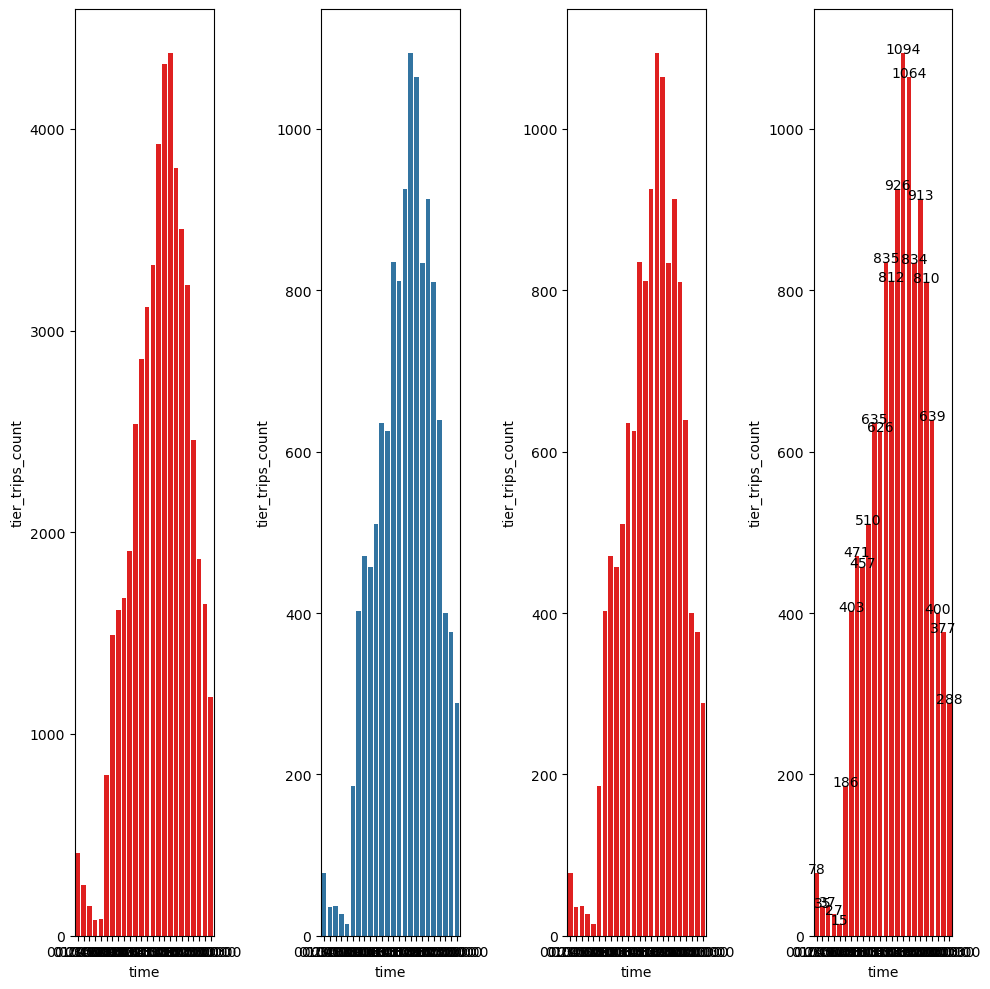

In [122]:
# tier
#f, axes = plt.subplots(1, 2,3,4)
fig, axes = plt.subplots(ncols=4)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(min60, x="time", y="tier_trips_count", ax=axes[0], color='Red')
sns.barplot(min60_delay, x="time", y="tier_trips_count", ax=axes[1])
sns.barplot(min60_no_delay, x="time", y="tier_trips_count", ax=axes[2], color='Red')
sns.barplot(min60_nan_delay, x="time", y="tier_trips_count", ax=axes[3], color='Red')
addlabels(min60_nan_delay.index, min60_nan_delay['tier_trips_count'])
plt.show()

/tmp/ipykernel_3072574/264193744.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, y[i], y[i], ha = 'center')


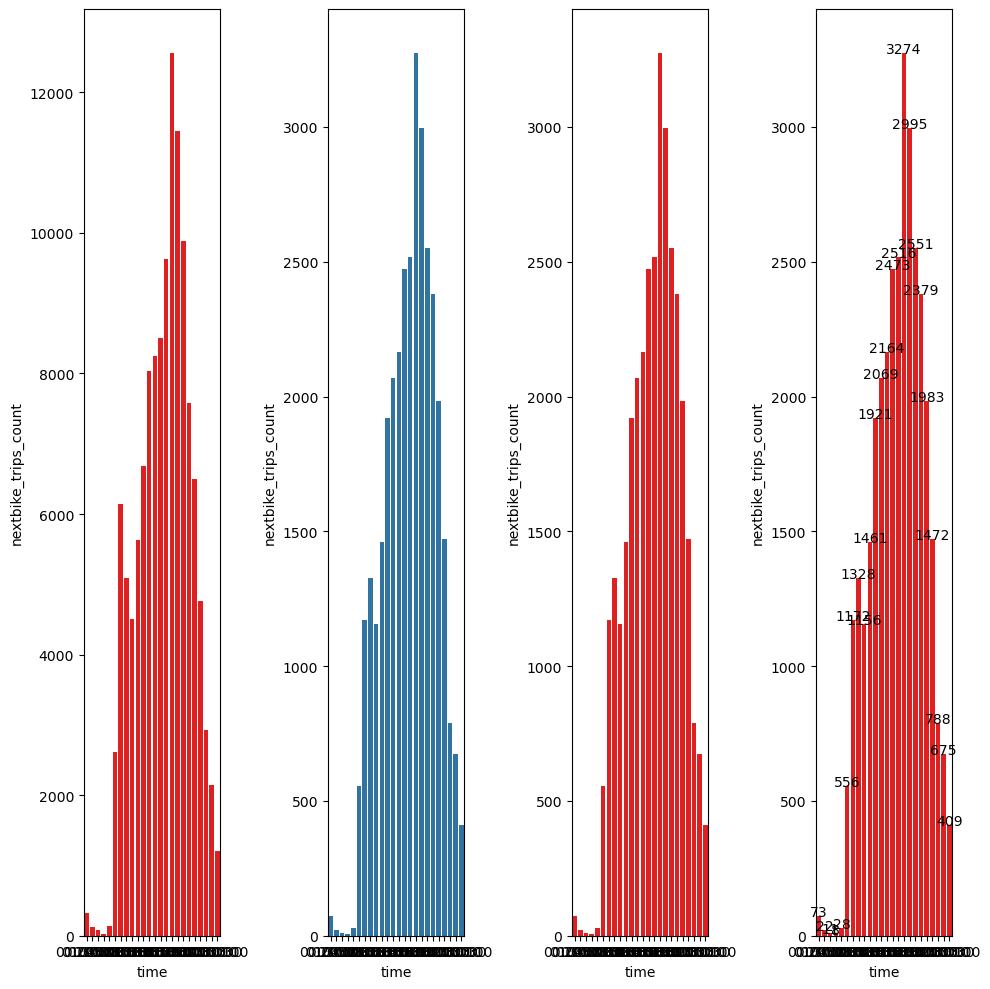

In [123]:
# next time
#f, axes = plt.subplots(1, 2,3,4)
fig, axes = plt.subplots(ncols=4)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(min60, x="time", y="nextbike_trips_count", ax=axes[0], color='Red')
sns.barplot(min60_delay, x="time", y="nextbike_trips_count", ax=axes[1])
sns.barplot(min60_no_delay, x="time", y="nextbike_trips_count", ax=axes[2], color='Red')
sns.barplot(min60_nan_delay, x="time", y="nextbike_trips_count", ax=axes[3], color='Red')
addlabels(min60_nan_delay.index, min60_nan_delay['nextbike_trips_count'])
plt.show()

/tmp/ipykernel_3072574/264193744.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, y[i], y[i], ha = 'center')


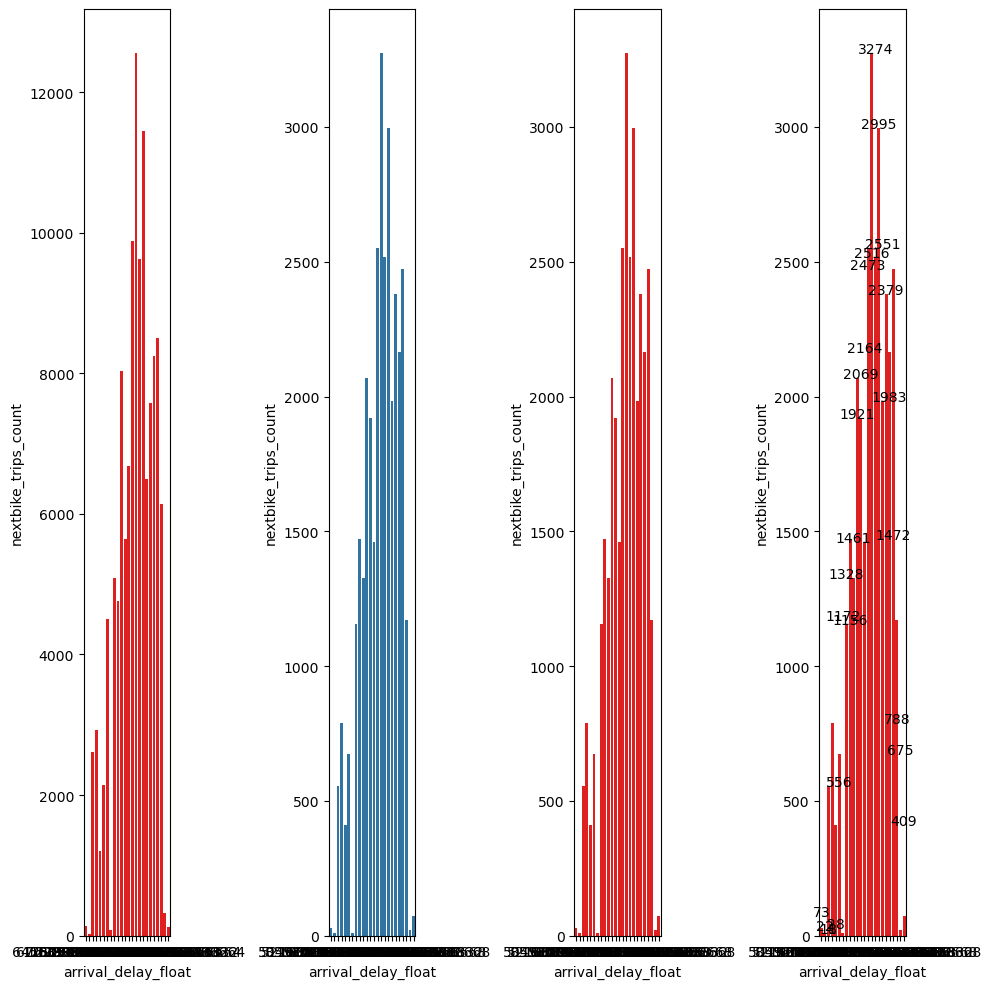

In [124]:
# next time
#f, axes = plt.subplots(1, 2,3,4)
fig, axes = plt.subplots(ncols=4)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(min60, x="arrival_delay_float", y="nextbike_trips_count", ax=axes[0], color='Red')
sns.barplot(min60_delay, x="arrival_delay_float", y="nextbike_trips_count", ax=axes[1])
sns.barplot(min60_no_delay, x="arrival_delay_float", y="nextbike_trips_count", ax=axes[2], color='Red')
sns.barplot(min60_nan_delay, x="arrival_delay_float", y="nextbike_trips_count", ax=axes[3], color='Red')
addlabels(min60_nan_delay.index, min60_nan_delay['nextbike_trips_count'])
plt.show()

/tmp/ipykernel_3072574/264193744.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, y[i], y[i], ha = 'center')


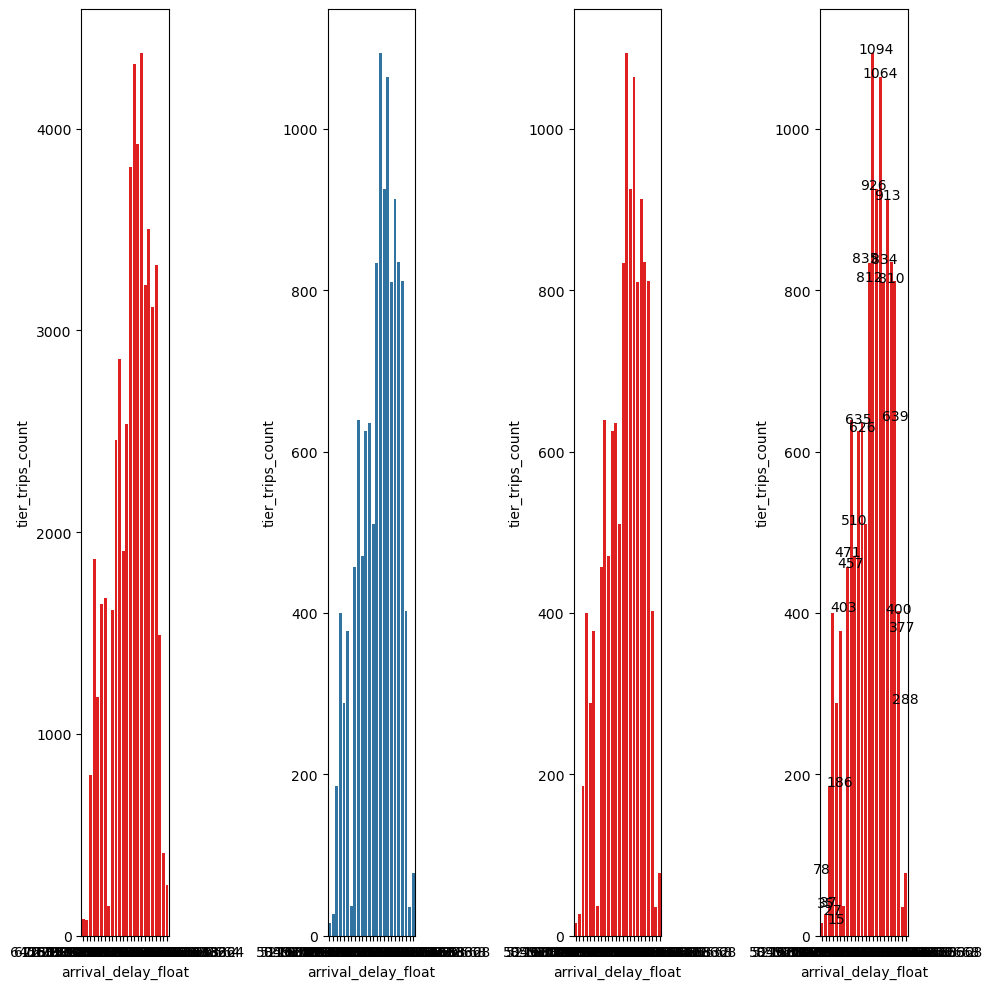

In [125]:
# next time

fig, axes = plt.subplots(ncols=4)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(min60, x="arrival_delay_float", y="tier_trips_count", ax=axes[0], color='Red')
sns.barplot(min60_delay, x="arrival_delay_float", y="tier_trips_count", ax=axes[1])
sns.barplot(min60_no_delay, x="arrival_delay_float", y="tier_trips_count", ax=axes[2], color='Red')
sns.barplot(min60_nan_delay, x="arrival_delay_float", y="tier_trips_count", ax=axes[3], color='Red')
addlabels(min60_nan_delay.index, min60_nan_delay['tier_trips_count'])
plt.show()

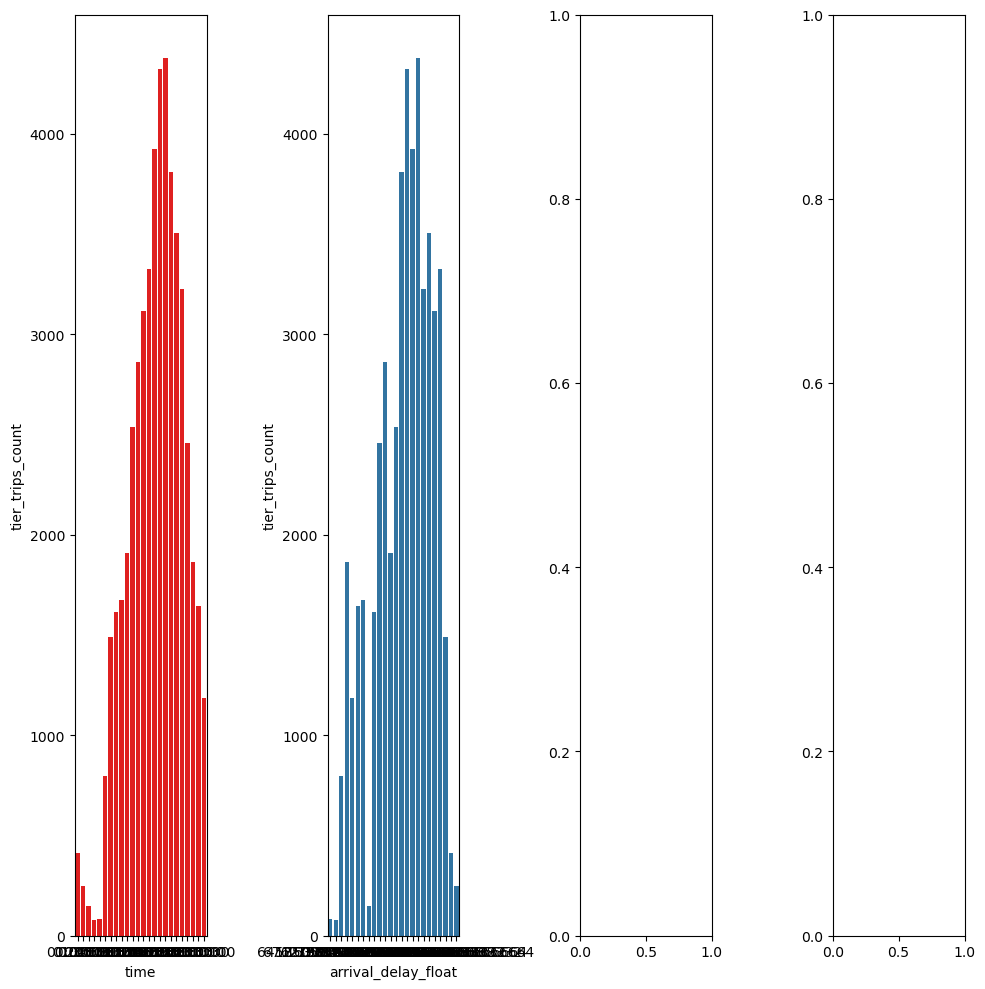

In [126]:
fig, axes = plt.subplots(ncols=4)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(min60, x="time", y="tier_trips_count", ax=axes[0], color='Red')
sns.barplot(min60, x="arrival_delay_float", y="tier_trips_count", ax=axes[1])
#addlabels(min60.index, min60['tier_trips_count'])
plt.show()

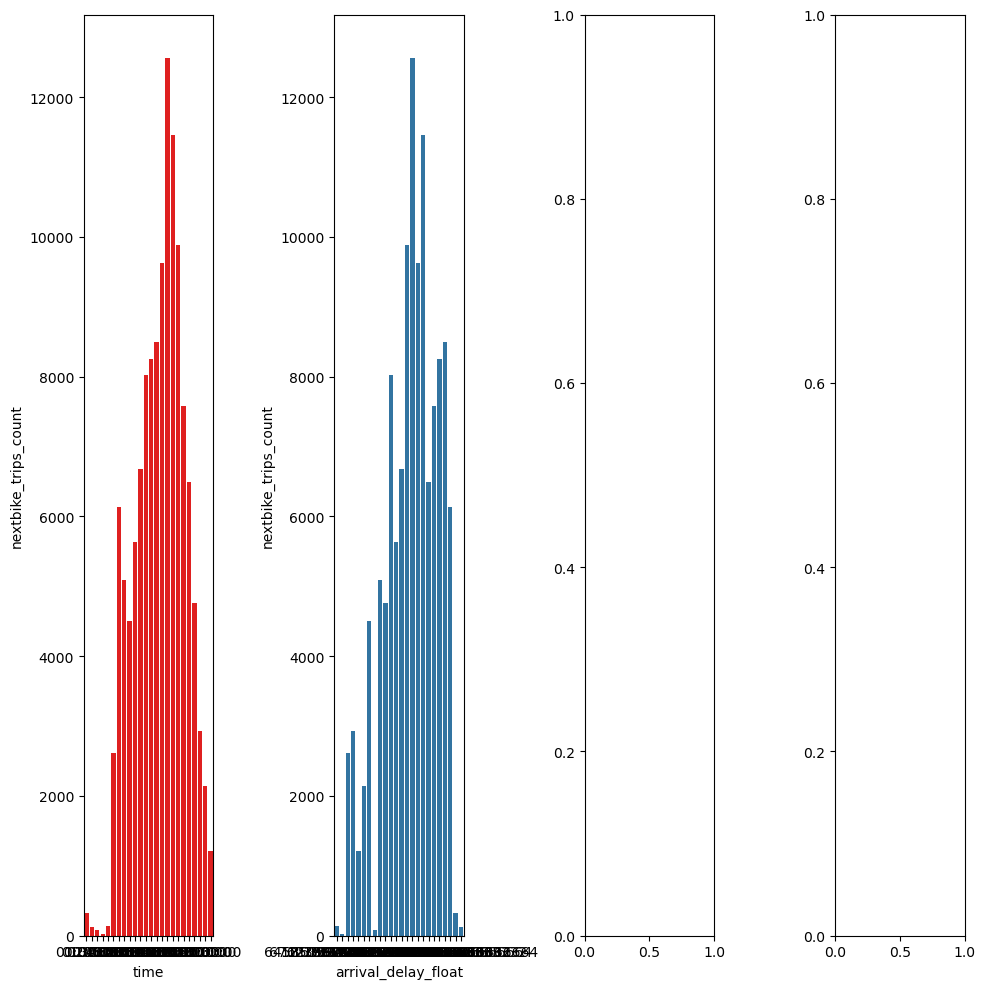

In [127]:
fig, axes = plt.subplots(ncols=4)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(min60, x="time", y="nextbike_trips_count", ax=axes[0], color='Red')
sns.barplot(min60, x="arrival_delay_float", y="nextbike_trips_count", ax=axes[1])
#addlabels(min60.index, min60['nextbike_trips_count'])
plt.show()

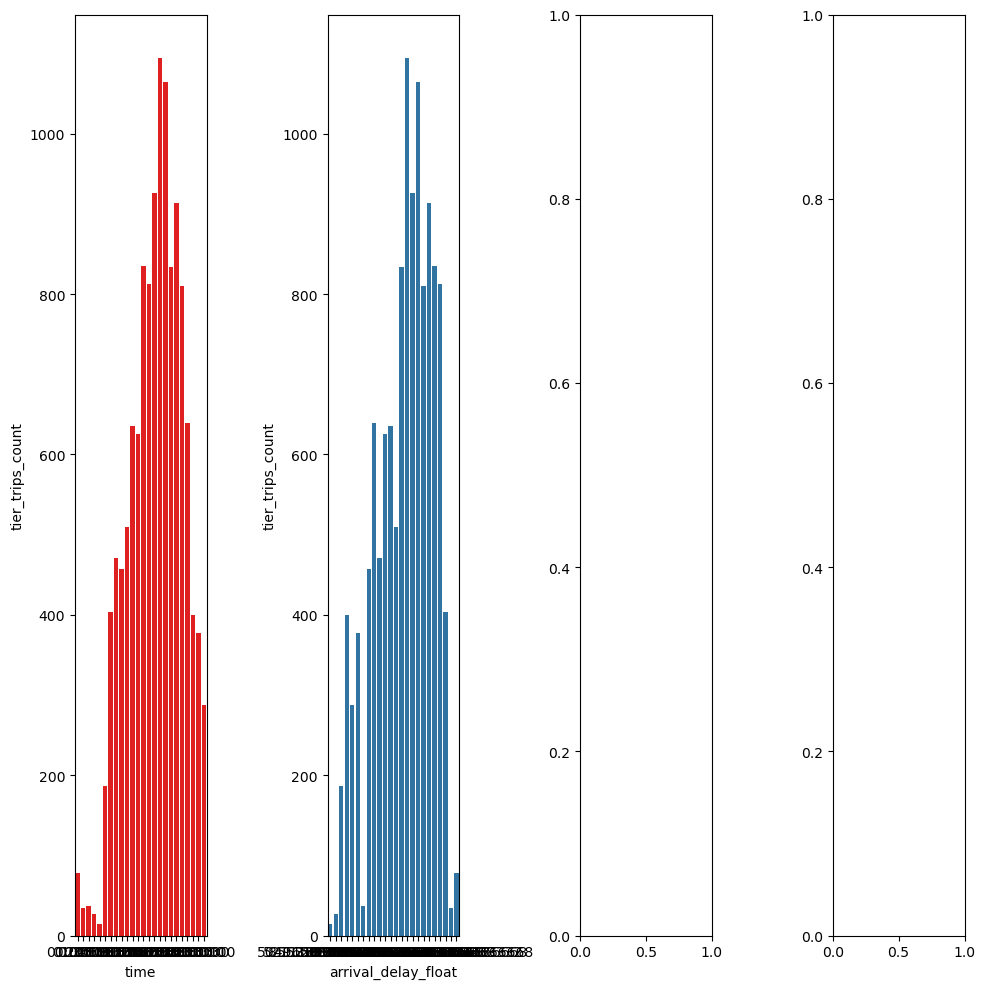

In [128]:
fig, axes = plt.subplots(ncols=4)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(min60_delay, x="time", y="tier_trips_count", ax=axes[0], color='Red')
sns.barplot(min60_delay, x="arrival_delay_float", y="tier_trips_count", ax=axes[1])
#addlabels(min60_delay.index, min60_delay['tier_trips_count'])
plt.show()

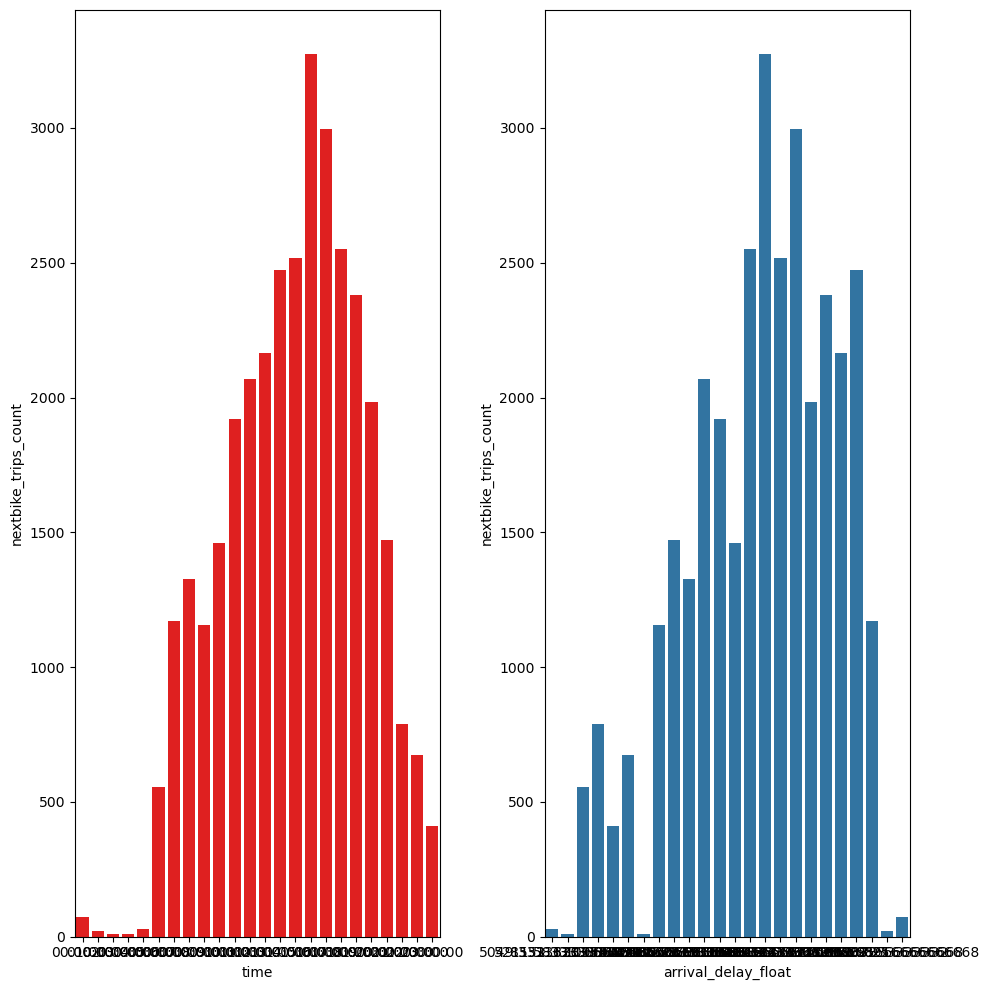

In [129]:
fig, axes = plt.subplots(ncols=2)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(min60_delay, x="time", y="nextbike_trips_count", ax=axes[0], color='Red')
sns.barplot(min60_delay, x="arrival_delay_float", y="nextbike_trips_count", ax=axes[1])
#addlabels(min60_delay.index, min60_delay['nextbike_trips_count'])
plt.show()

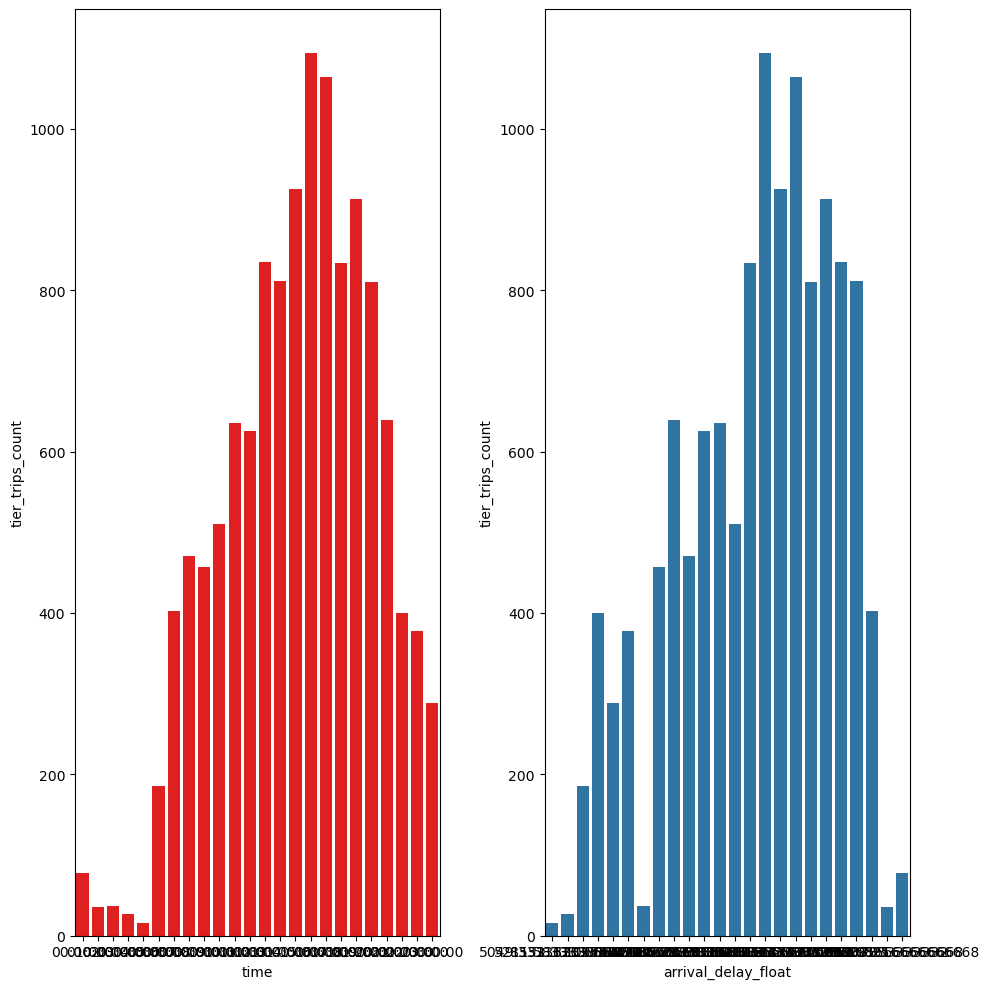

In [130]:
fig, axes = plt.subplots(ncols=2)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(min60_no_delay, x="time", y="tier_trips_count", ax=axes[0], color='Red')
sns.barplot(min60_no_delay, x="arrival_delay_float", y="tier_trips_count", ax=axes[1])
#addlabels(min60_no_delay.index, min60_no_delay['tier_trips_count'])
plt.show()

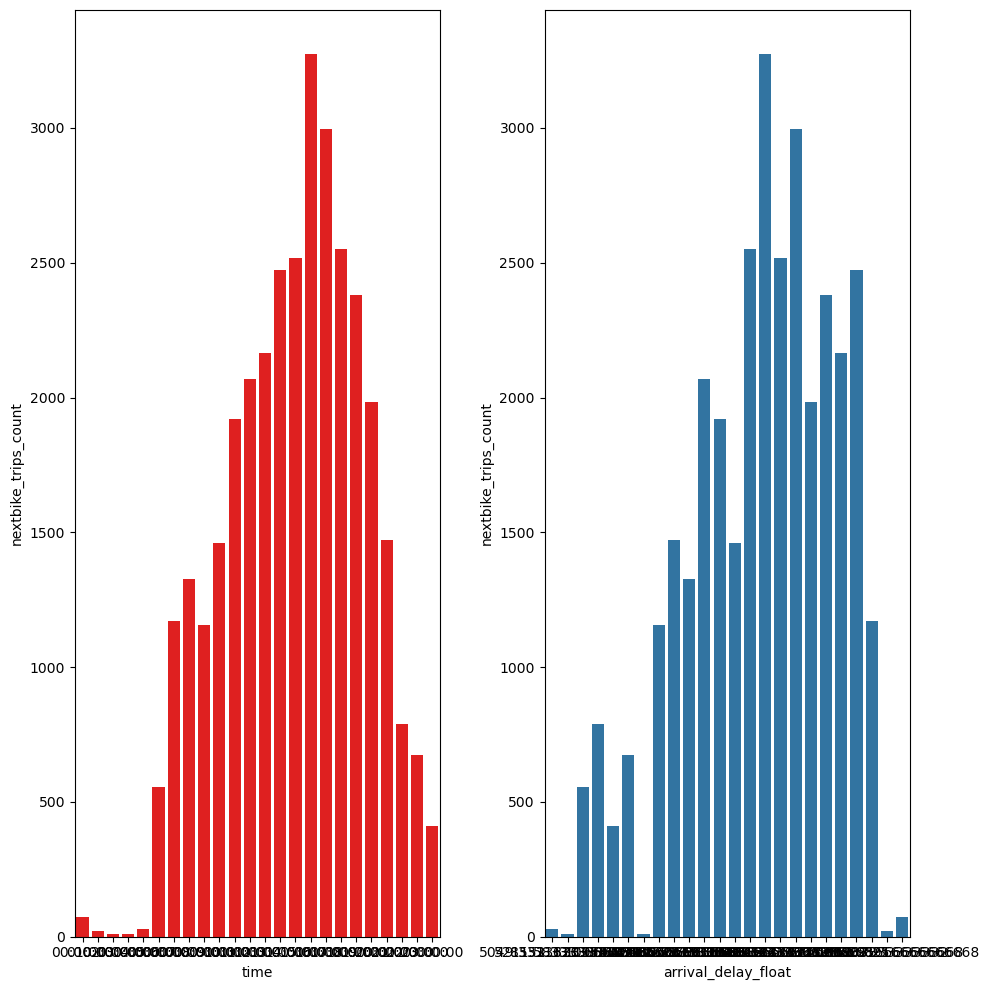

In [131]:
fig, axes = plt.subplots(ncols=2)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(min60_no_delay, x="time", y="nextbike_trips_count", ax=axes[0], color='Red')
sns.barplot(min60_no_delay, x="arrival_delay_float", y="nextbike_trips_count", ax=axes[1])
#addlabels(min60_no_delay.index, min60_no_delay['nextbike_trips_count'])
plt.show()

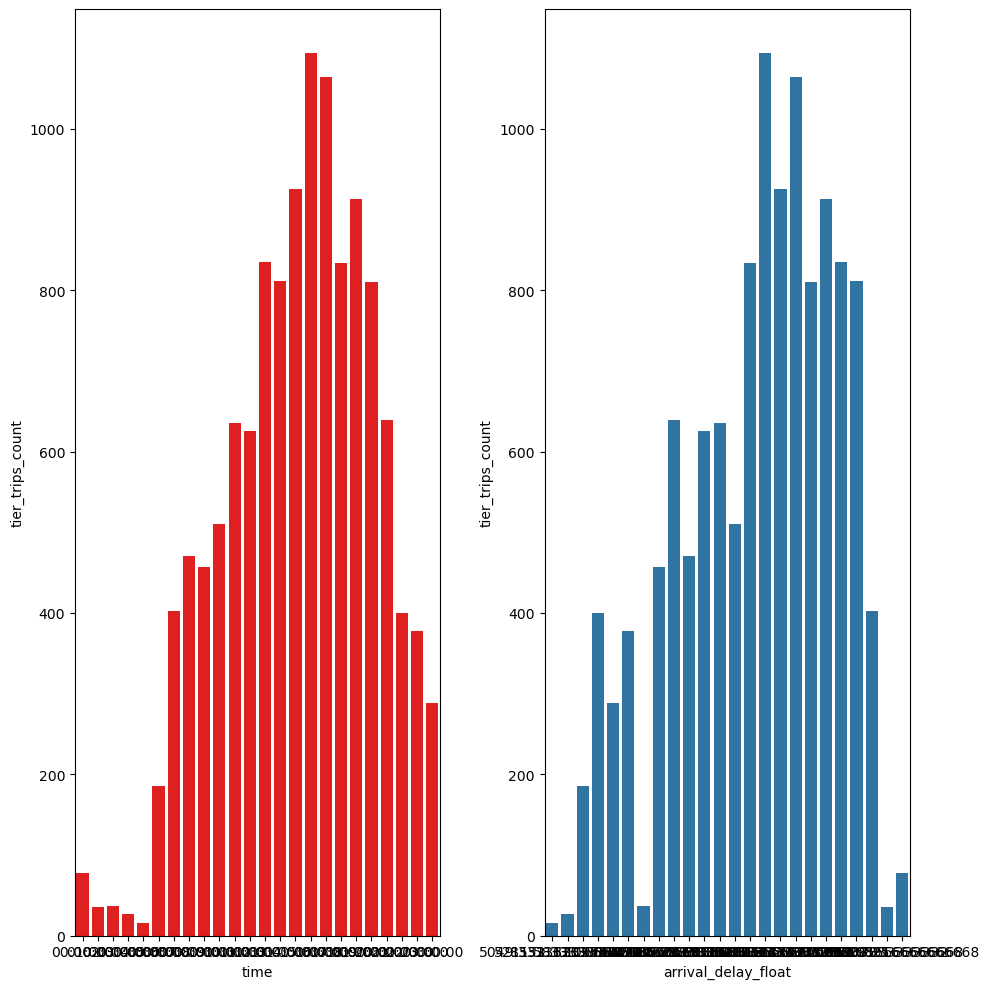

In [132]:
fig, axes = plt.subplots(ncols=2)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(min60_nan_delay, x="time", y="tier_trips_count", ax=axes[0], color='Red')
sns.barplot(min60_nan_delay, x="arrival_delay_float", y="tier_trips_count", ax=axes[1])
#addlabels(min60_nan_delay.index, min60_nan_delay['tier_trips_count'])
plt.show()

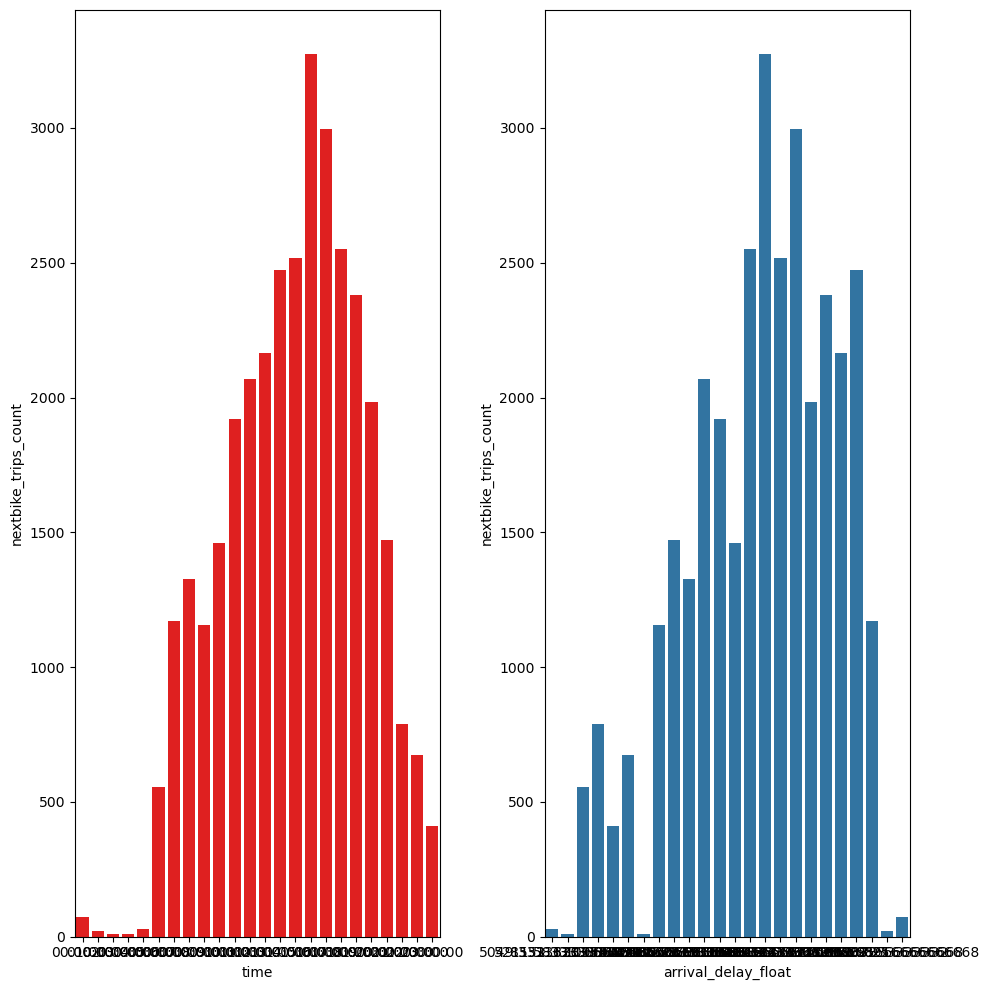

In [133]:
fig, axes = plt.subplots(ncols=2)
plt.rcParams["figure.figsize"] = [10.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(min60_nan_delay, x="time", y="nextbike_trips_count", ax=axes[0], color='Red')
sns.barplot(min60_nan_delay, x="arrival_delay_float", y="nextbike_trips_count", ax=axes[1])
#addlabels(min60_nan_delay.index, min60_nan_delay['nextbike_trips_count'])
plt.show()

plot = sns.barplot(min60, x="time", y="tier_trips_count")
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
plot

plot = sns.barplot(min60, x="time", y="nextbike_trips_count")
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
plot

plot = sns.barplot(min60, x="arrival_delay_float", y="tier_trips_count")
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
plot

plot = sns.barplot(min60, x="arrival_delay_float", y="nextbike_trips_count")
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
plot

In [134]:
# group by days (1 - 31) auch (Montag, etc)

In [135]:
daily_data = data.groupby([data['scheduled_arrival_time'].dt.date]).agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum', 'arrival_delay' : 'mean', 'arrival_delay_float' : 'mean'})
daily_delay = delay.groupby([delay['scheduled_arrival_time'].dt.date]).agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum', 'arrival_delay' : 'mean', 'arrival_delay_float' : 'mean'})
daily_no_delay = no_delay.groupby([no_delay['scheduled_arrival_time'].dt.date]).agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum', 'arrival_delay' : 'mean', 'arrival_delay_float' : 'mean'})
daily_nan_delay = nan_delay.groupby([nan_delay['scheduled_arrival_time'].dt.date]).agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum', 'arrival_delay' : 'mean', 'arrival_delay_float' : 'mean'})

In [136]:
daily_no_delay

tier_trips_count  nextbike_trips_count  \
scheduled_arrival_time                                           
2023-06-30                             1                     0   
2023-07-01                           784                  1209   
2023-07-02                           333                   688   
2023-07-03                           581                  1321   
2023-07-04                           678                  1387   
2023-07-05                           655                  1620   
2023-07-06                           749                  1520   
2023-07-07                           900                  1717   
2023-07-08                           812                  1401   
2023-07-09                           334                   714   
2023-07-10                           679                  1511   
2023-07-11                          1129                  2098   
2023-07-12                           665                  1655   
2023-07-13                           625                  1618   
2023-07-14                           736                  1728   
2023-07-15                           455                  1053   
2023-07-16                            10                     3   
2023-07-17                           537                  1535   
2023-07-18                           635                  2171   
2023-07-19                           449                  1669   
2023-07-20                           617                  1769   
2023-07-21                           712                  1580   
2023-07-22                           854                  1495   
2023-07-23                           255                   568   
2023-07-24                           467                  1316   
2023-07-25                           526                  1484   
2023-07-26                           597                  1506   
2023-07-27                           389                   883   
2023-07-28                           609                  1196   
2023-07-29                           600                   978   
2023-07-30                           343                   613   
2023-07-31                           463                  1194   
2023-08-01                             1                     5   

                                   arrival_delay  arrival_delay_float  
scheduled_arrival_time                                                 
2023-06-30                                   NaT                  NaN  
2023-07-01             0 days 00:00:01.152745605             0.019212  
2023-07-02             0 days 00:00:01.636473429             0.027275  
2023-07-03             0 days 00:00:01.313416397             0.021890  
2023-07-04             0 days 00:00:01.633136094             0.027219  
2023-07-05             0 days 00:00:01.690605456             0.028177  
2023-07-06             0 days 00:00:01.565141990             0.026086  
2023-07-07             0 days 00:00:01.748511383             0.029142  
2023-07-08             0 days 00:00:01.298141263             0.021636  
2023-07-09             0 days 00:00:02.062947958             0.034382  
2023-07-10             0 days 00:00:01.688469146             0.028141  
2023-07-11             0 days 00:00:02.385789393             0.039763  
2023-07-12             0 days 00:00:01.535190304             0.025587  
2023-07-13             0 days 00:00:01.643202353             0.027387  
2023-07-14             0 days 00:00:01.605520737             0.026759  
2023-07-15             0 days 00:00:01.226053639             0.020434  
2023-07-16                0 days 00:00:00.800000             0.013333  
2023-07-17             0 days 00:00:00.878086519             0.014635  
2023-07-18             0 days 00:00:01.549937421             0.025832  
2023-07-19             0 days 00:00:00.906609864             0.015110  
2023-07-20             0 days 00:00:00.857195868             0.014287  
2023-07-21             0 days 00:00:00.515683814         

<module 'matplotlib.pyplot' from '/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/matplotlib/pyplot.py'>

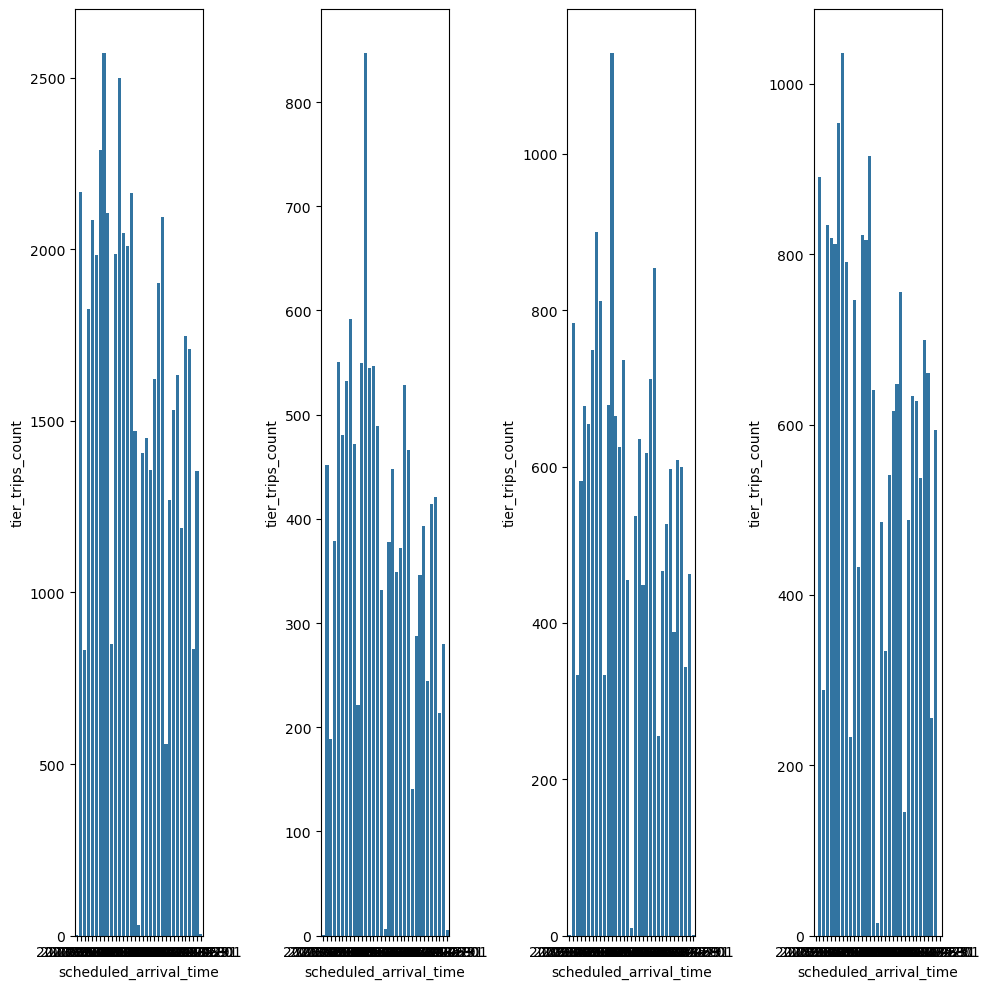

In [137]:
fig, axes = plt.subplots(ncols=4)
plt.rcParams["figure.figsize"] = [20.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(daily_data, x="scheduled_arrival_time", y="tier_trips_count",  ax=axes[0])
sns.barplot(daily_delay, x="scheduled_arrival_time", y="tier_trips_count",  ax=axes[1])
sns.barplot(daily_no_delay, x="scheduled_arrival_time", y="tier_trips_count",  ax=axes[2])
sns.barplot(daily_nan_delay, x="scheduled_arrival_time", y="tier_trips_count",  ax=axes[3])
#plt.set_xticklabels(plt.get_xticklabels(), rotation=45)
plt

<module 'matplotlib.pyplot' from '/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/matplotlib/pyplot.py'>

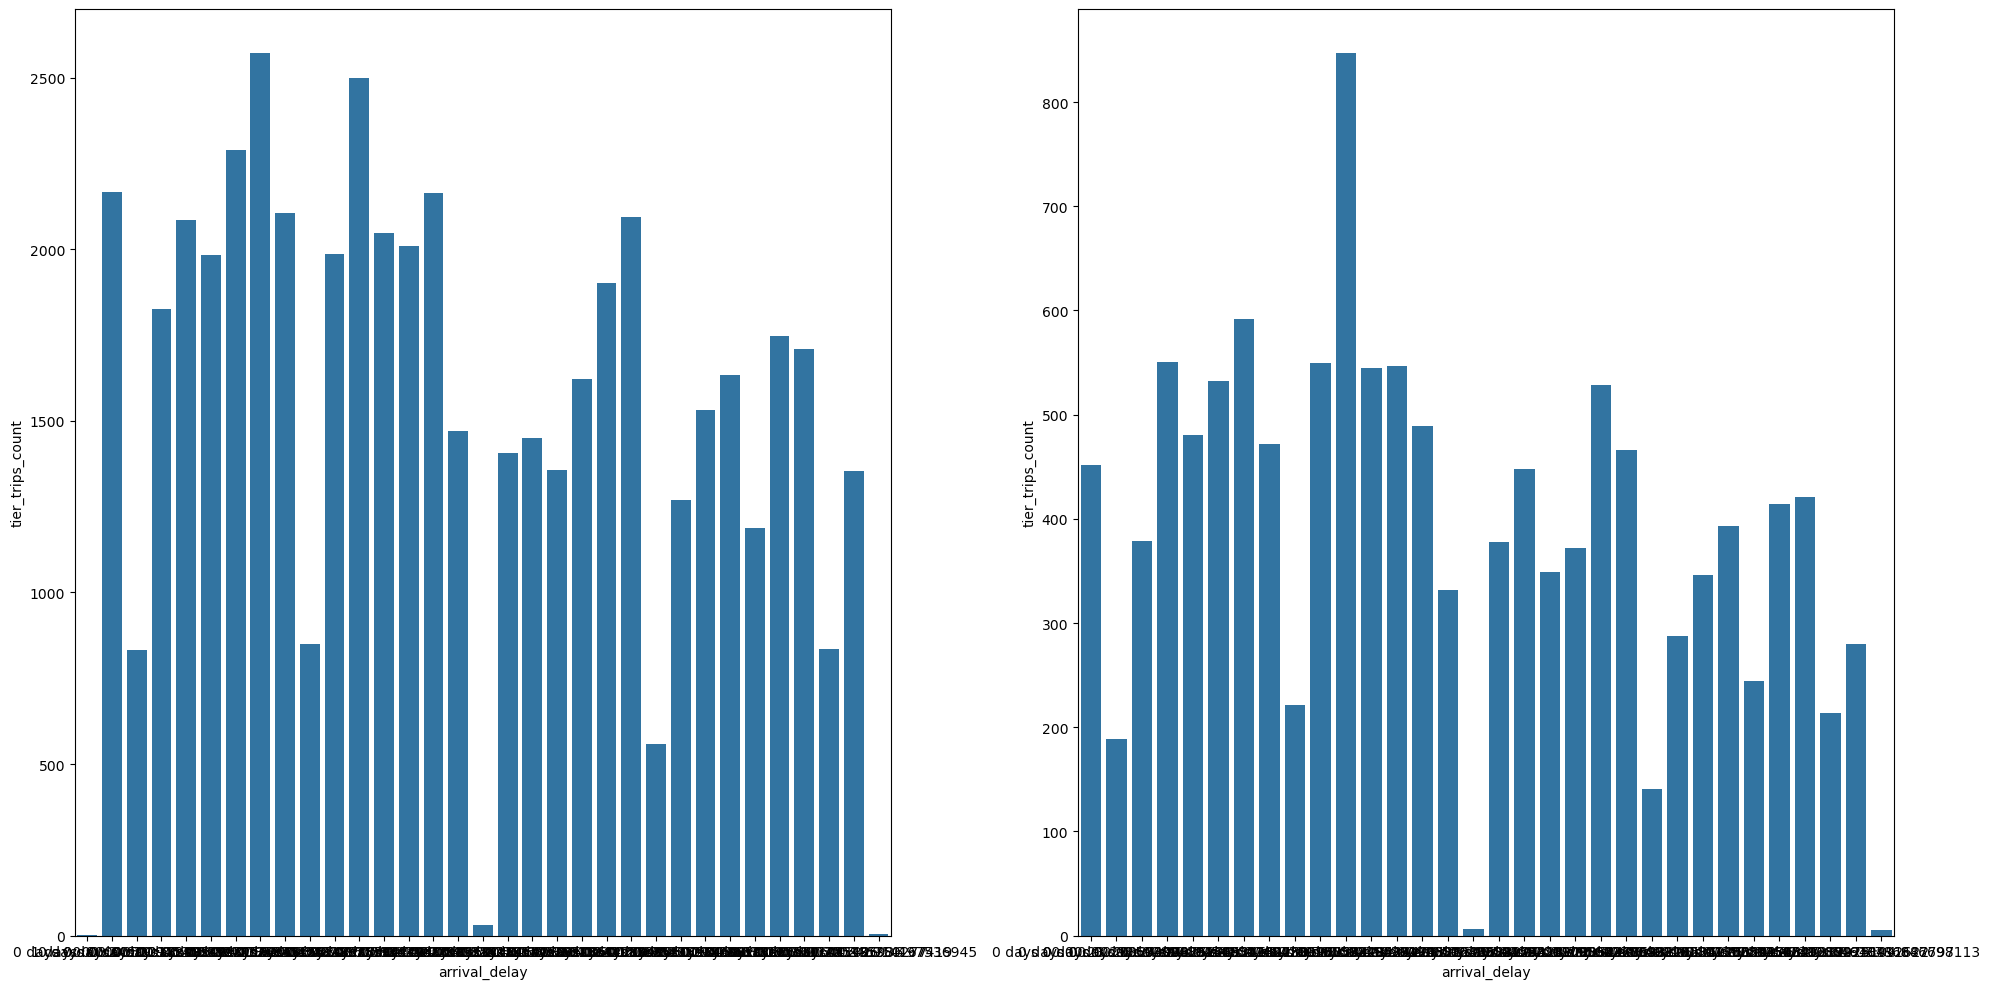

In [138]:
fig, axes = plt.subplots(ncols=2)
plt.rcParams["figure.figsize"] = [20.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(daily_data, x="arrival_delay", y="tier_trips_count",  ax=axes[0])
sns.barplot(daily_delay, x="arrival_delay", y="tier_trips_count",  ax=axes[1])
#plt.set_xticklabels(plt.get_xticklabels(), rotation=45)
plt

<module 'matplotlib.pyplot' from '/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/matplotlib/pyplot.py'>

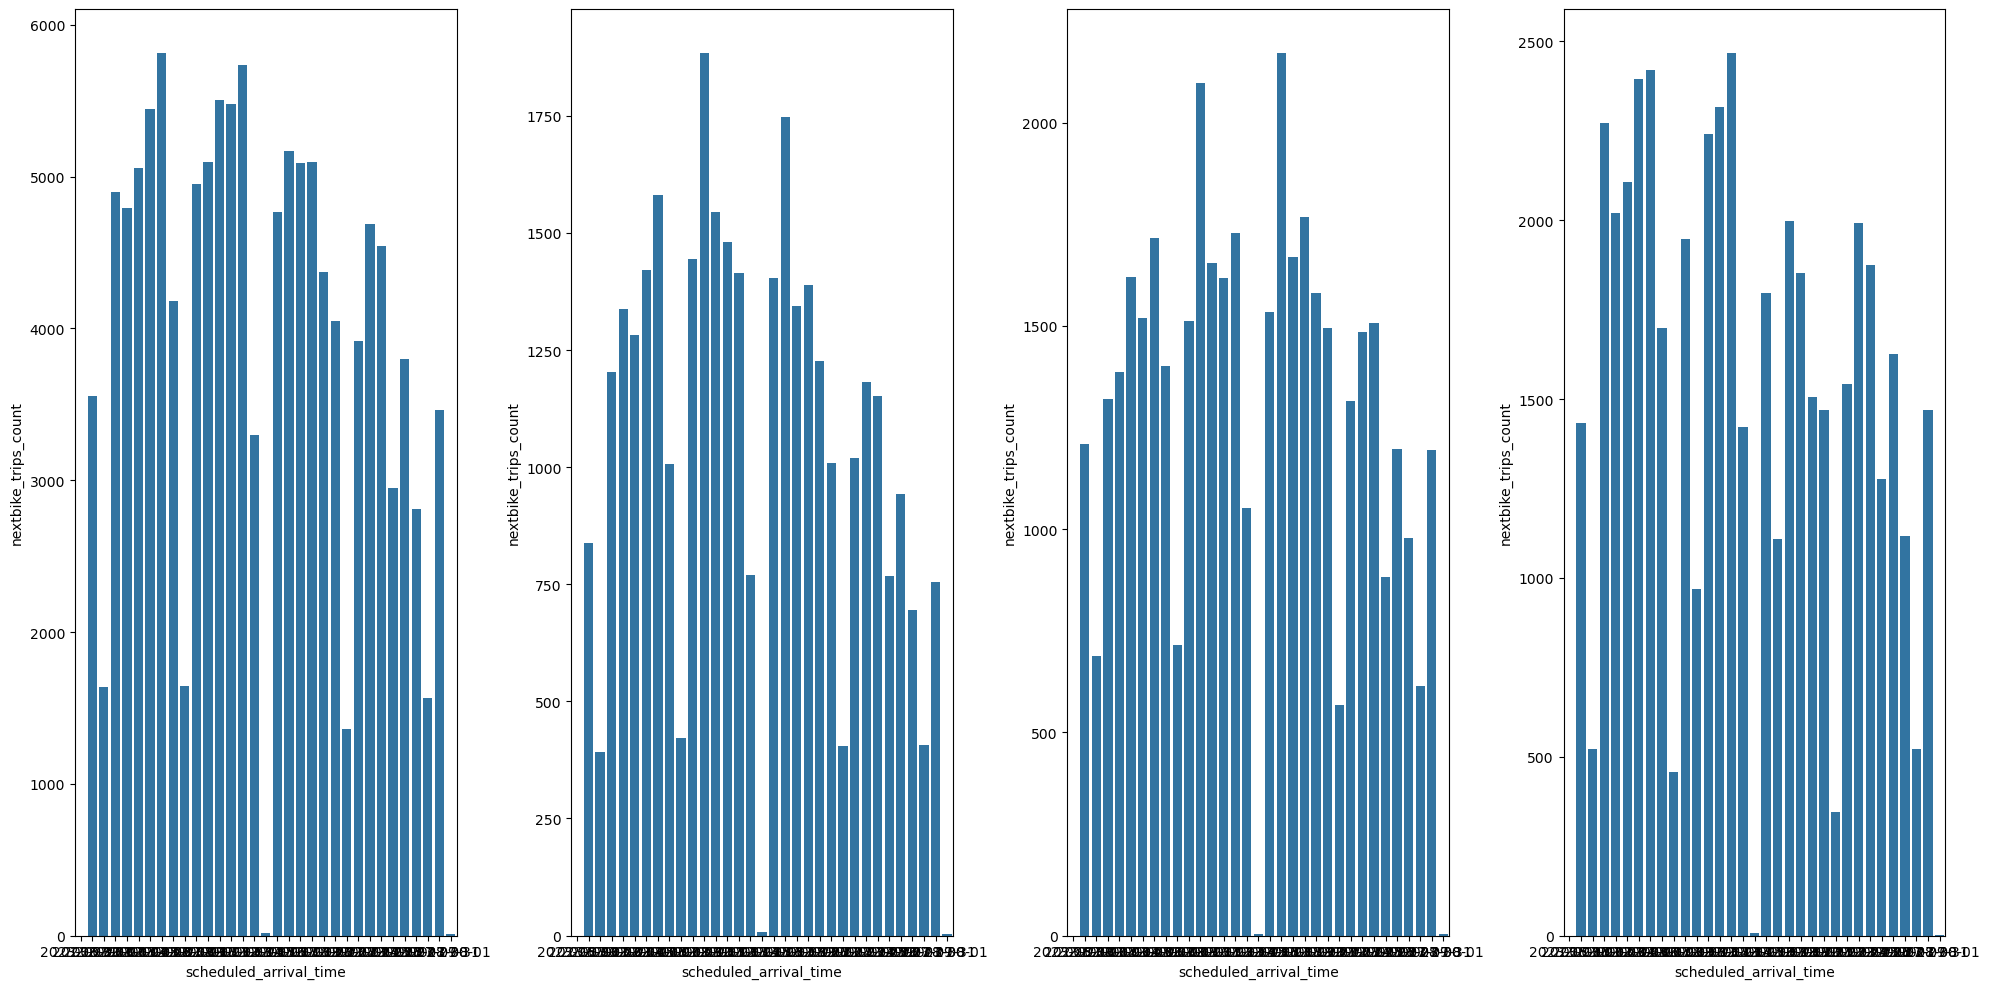

In [139]:
# mean delay every day tier 
pfig, axes = plt.subplots(ncols=4)
plt.rcParams["figure.figsize"] = [20.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(daily_data, x="scheduled_arrival_time", y="nextbike_trips_count",  ax=axes[0])
sns.barplot(daily_delay, x="scheduled_arrival_time", y="nextbike_trips_count",  ax=axes[1])
sns.barplot(daily_no_delay, x="scheduled_arrival_time", y="nextbike_trips_count",  ax=axes[2])
sns.barplot(daily_nan_delay, x="scheduled_arrival_time", y="nextbike_trips_count",  ax=axes[3])
#plt.set_xticklabels(plt.get_xticklabels(), rotation=45)
plt

<module 'matplotlib.pyplot' from '/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/matplotlib/pyplot.py'>

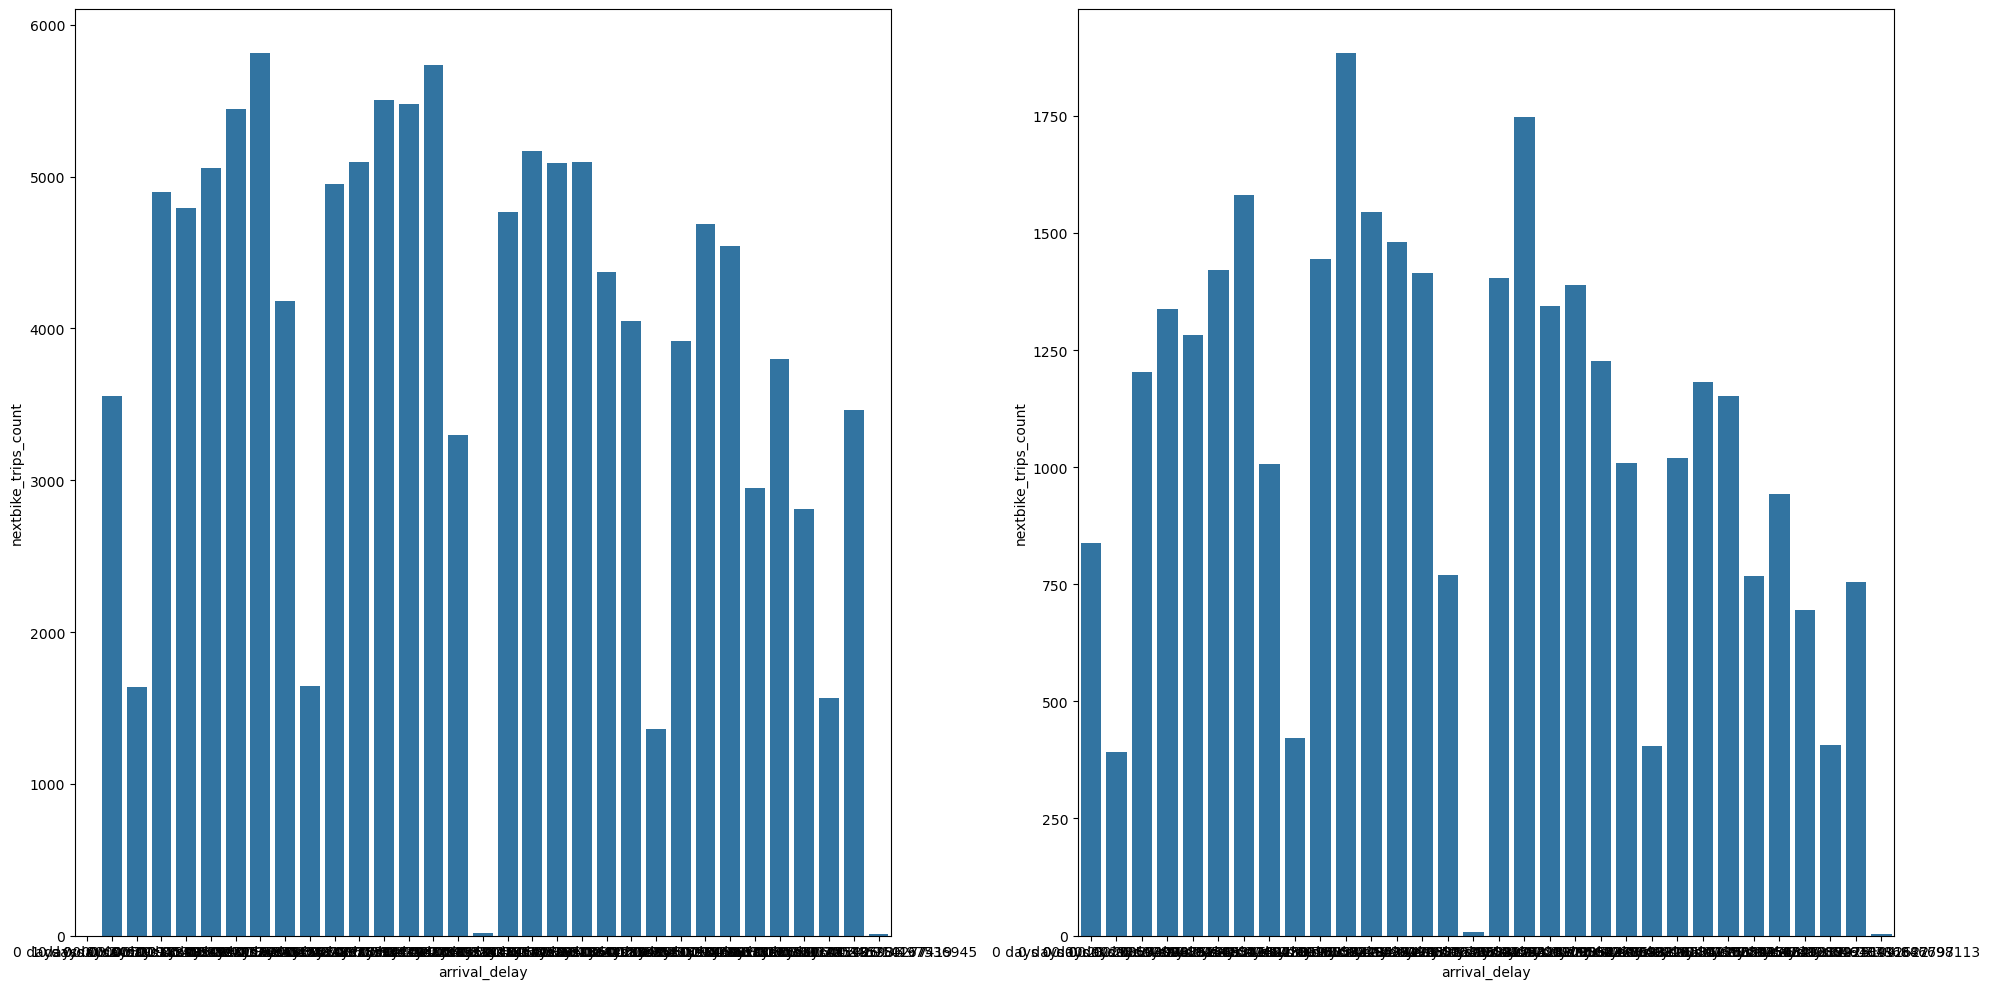

In [140]:
fig, axes = plt.subplots(ncols=2)
plt.rcParams["figure.figsize"] = [20.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(daily_data, x="arrival_delay", y="nextbike_trips_count",  ax=axes[0])
sns.barplot(daily_delay, x="arrival_delay", y="nextbike_trips_count",  ax=axes[1])
#plt.set_xticklabels(plt.get_xticklabels(), rotation=45)
plt

In [141]:
hour_data = data.groupby([data['scheduled_arrival_time'].dt.hour]).agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum', 'arrival_delay' : 'mean'})
hour_delay = delay.groupby([delay['scheduled_arrival_time'].dt.hour]).agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum', 'arrival_delay' : 'mean'})
hour_no_delay = no_delay.groupby([no_delay['scheduled_arrival_time'].dt.hour]).agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum', 'arrival_delay' : 'mean'})
hour_nan_delay = nan_delay.groupby([nan_delay['scheduled_arrival_time'].dt.hour]).agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum', 'arrival_delay' : 'mean'})

<module 'matplotlib.pyplot' from '/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/matplotlib/pyplot.py'>

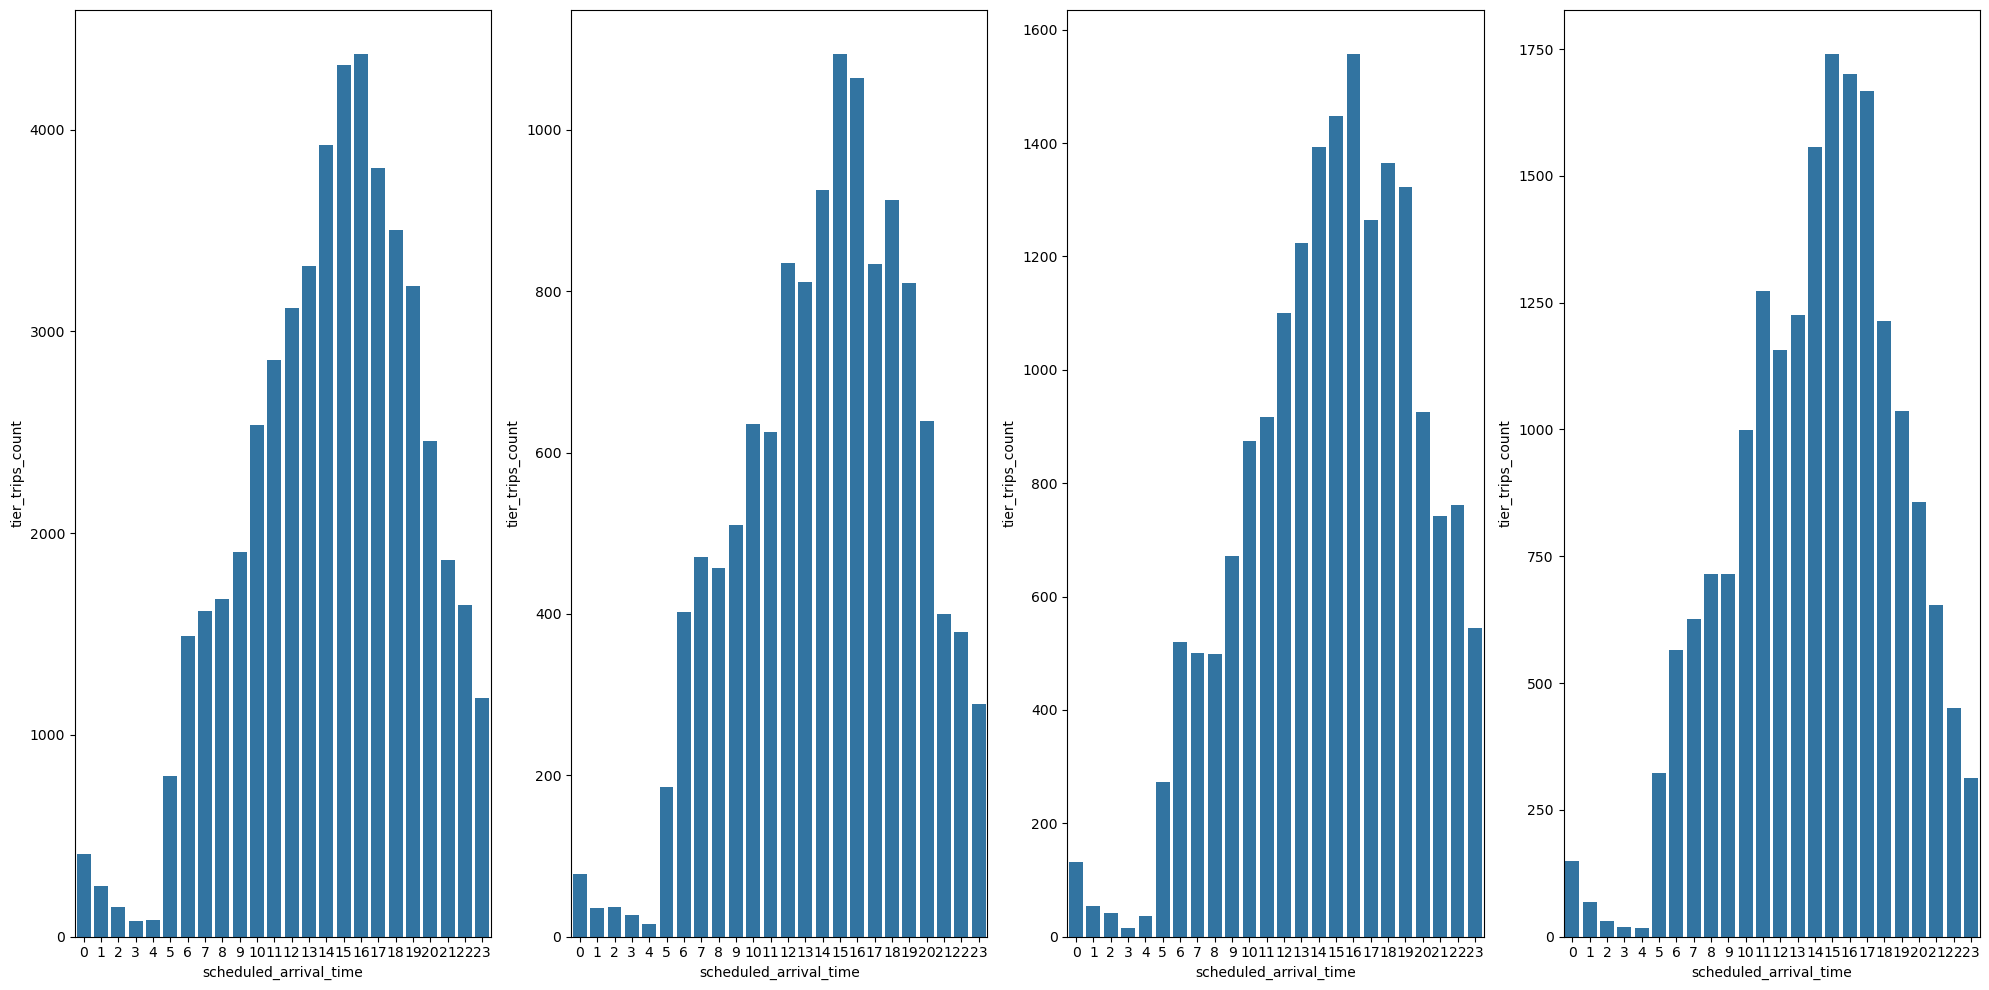

In [142]:
fig, axes = plt.subplots(ncols=4)
plt.rcParams["figure.figsize"] = [20.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(hour_data, x="scheduled_arrival_time", y="tier_trips_count",  ax=axes[0])
sns.barplot(hour_delay, x="scheduled_arrival_time", y="tier_trips_count",  ax=axes[1])
sns.barplot(hour_no_delay, x="scheduled_arrival_time", y="tier_trips_count",  ax=axes[2])
sns.barplot(hour_nan_delay, x="scheduled_arrival_time", y="tier_trips_count",  ax=axes[3])
#plt.set_xticklabels(plt.get_xticklabels(), rotation=45)
plt

<module 'matplotlib.pyplot' from '/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/matplotlib/pyplot.py'>

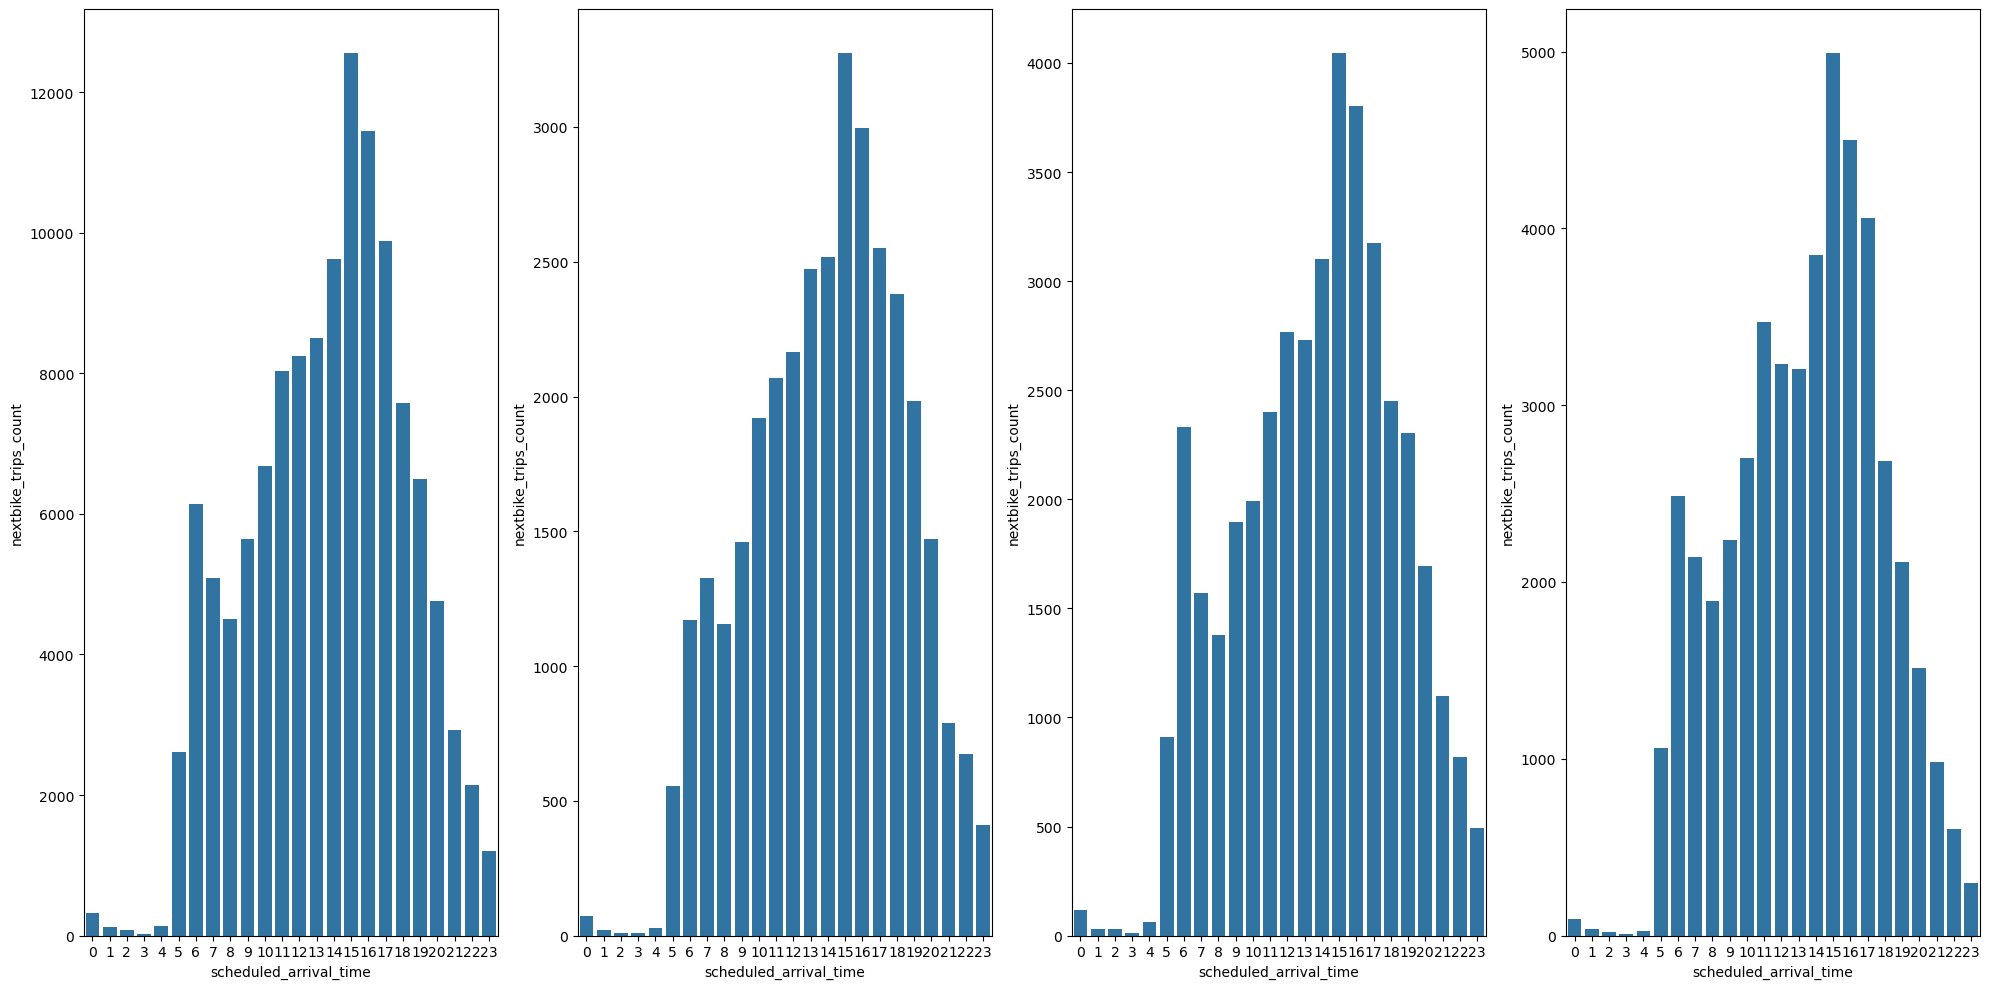

In [143]:
fig, axes = plt.subplots(ncols=4)
plt.rcParams["figure.figsize"] = [20.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(hour_data, x="scheduled_arrival_time", y="nextbike_trips_count",  ax=axes[0])
sns.barplot(hour_delay, x="scheduled_arrival_time", y="nextbike_trips_count",  ax=axes[1])
sns.barplot(hour_no_delay, x="scheduled_arrival_time", y="nextbike_trips_count",  ax=axes[2])
sns.barplot(hour_nan_delay, x="scheduled_arrival_time", y="nextbike_trips_count",  ax=axes[3])
#plt.set_xticklabels(plt.get_xticklabels(), rotation=45)
plt

<module 'matplotlib.pyplot' from '/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/matplotlib/pyplot.py'>

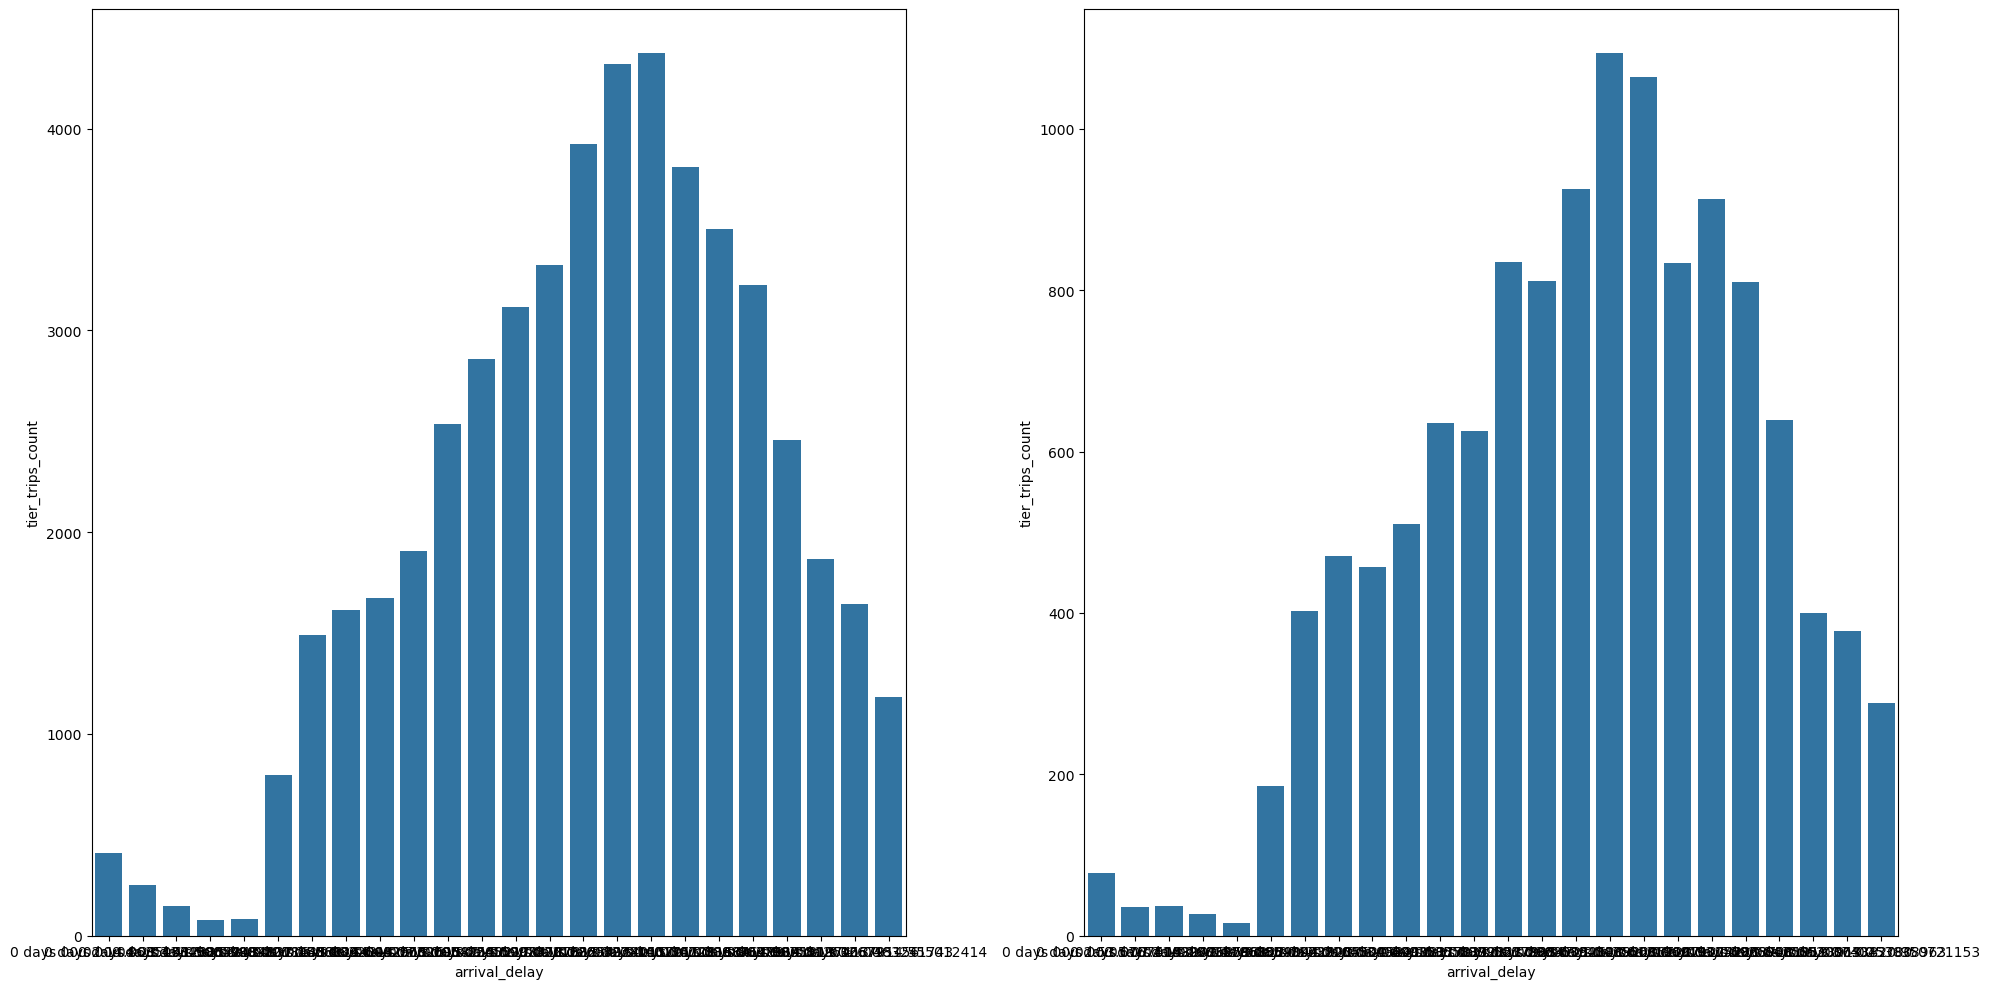

In [144]:
fig, axes = plt.subplots(ncols=2)
plt.rcParams["figure.figsize"] = [20.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(hour_data, x="arrival_delay", y="tier_trips_count",  ax=axes[0])
sns.barplot(hour_delay, x="arrival_delay", y="tier_trips_count",  ax=axes[1])
#plt.set_xticklabels(plt.get_xticklabels(), rotation=45)
plt

<module 'matplotlib.pyplot' from '/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/matplotlib/pyplot.py'>

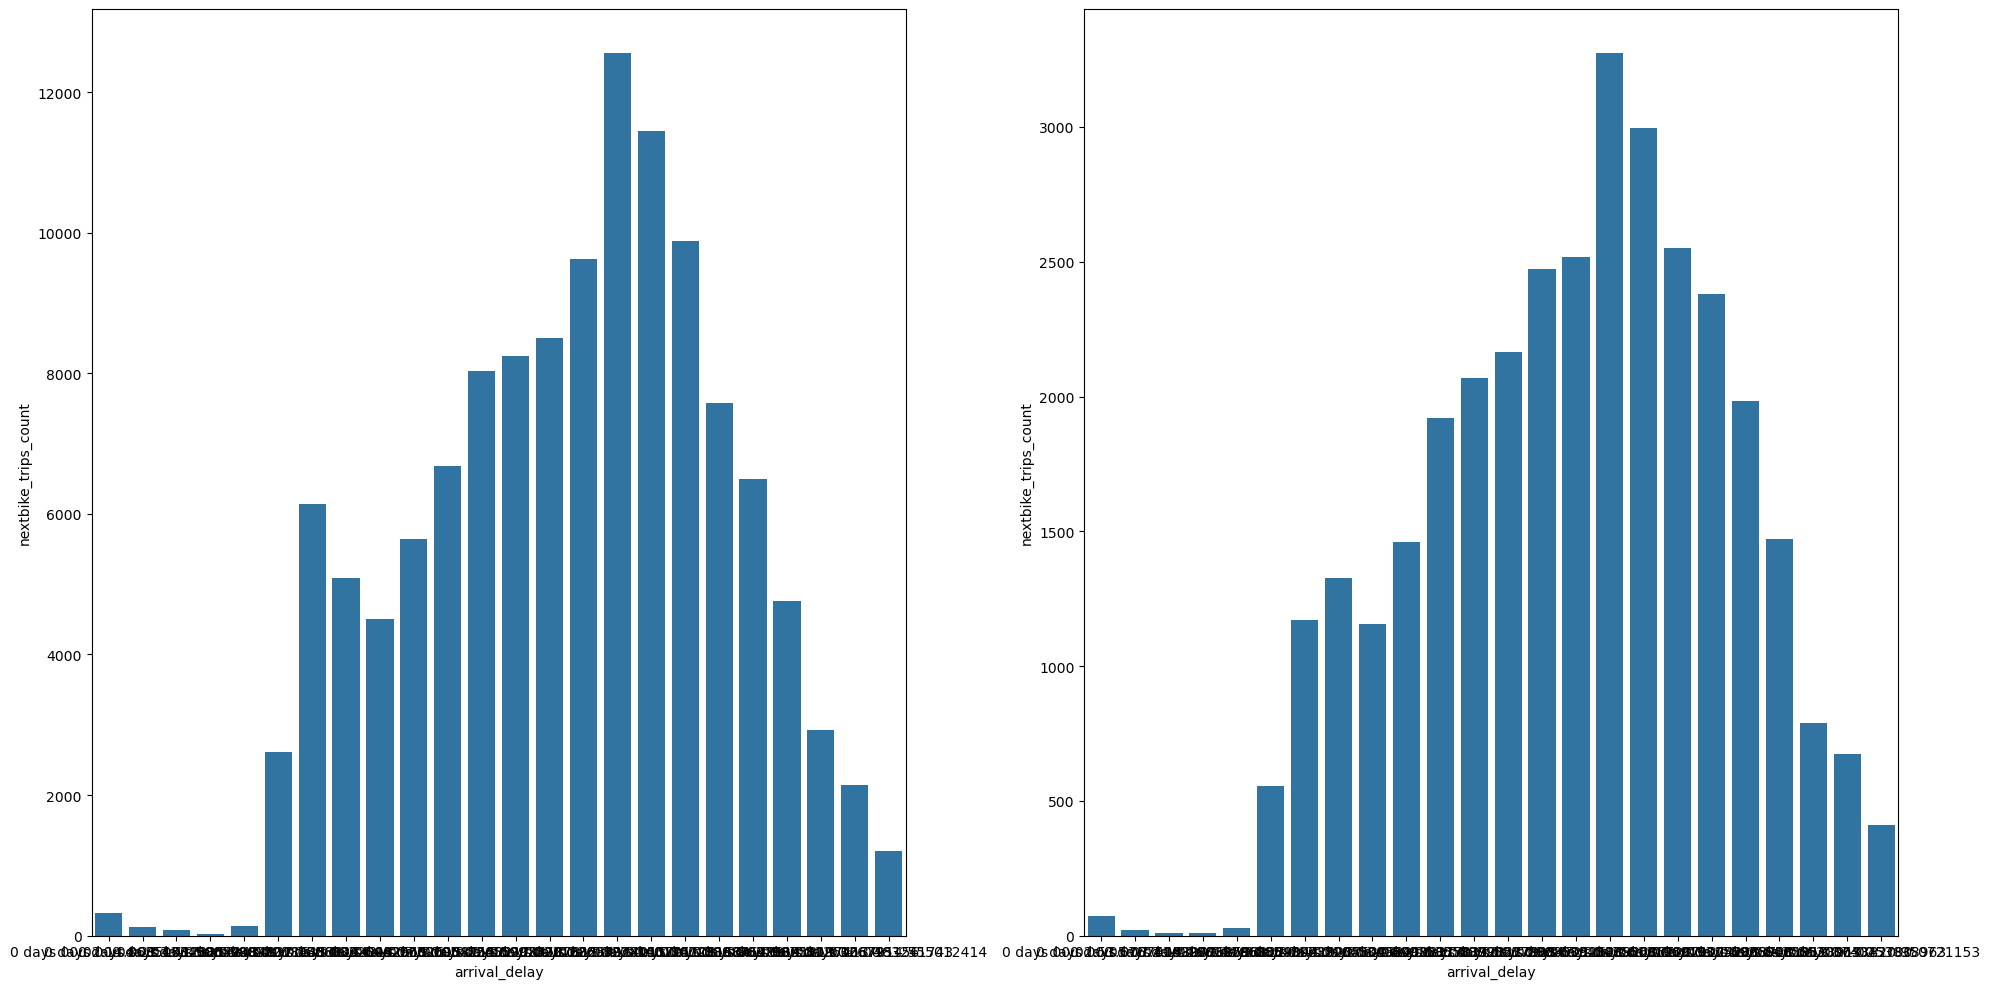

In [145]:
fig, axes = plt.subplots(ncols=2)
plt.rcParams["figure.figsize"] = [20.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(hour_data, x="arrival_delay", y="nextbike_trips_count",  ax=axes[0])
sns.barplot(hour_delay, x="arrival_delay", y="nextbike_trips_count",  ax=axes[1])
#plt.set_xticklabels(plt.get_xticklabels(), rotation=45)
plt

In [146]:
weekday_data = data.groupby(data['weekday']).agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum', 'arrival_delay' : 'mean'})
weekday_delay = delay.groupby(delay['weekday']).agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum', 'arrival_delay' : 'mean'})
weekday_no_delay = no_delay.groupby(no_delay['weekday']).agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum', 'arrival_delay' : 'mean'})
weekday_nan_delay = nan_delay.groupby(nan_delay['weekday']).agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum', 'arrival_delay' : 'mean'})

In [147]:
weekday_data = weekday_data.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [148]:
weekday_delay = weekday_delay.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])


In [149]:
weekday_no_delay = weekday_no_delay.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])


In [150]:
weekday_nan_delay = weekday_nan_delay.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

<module 'matplotlib.pyplot' from '/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/matplotlib/pyplot.py'>

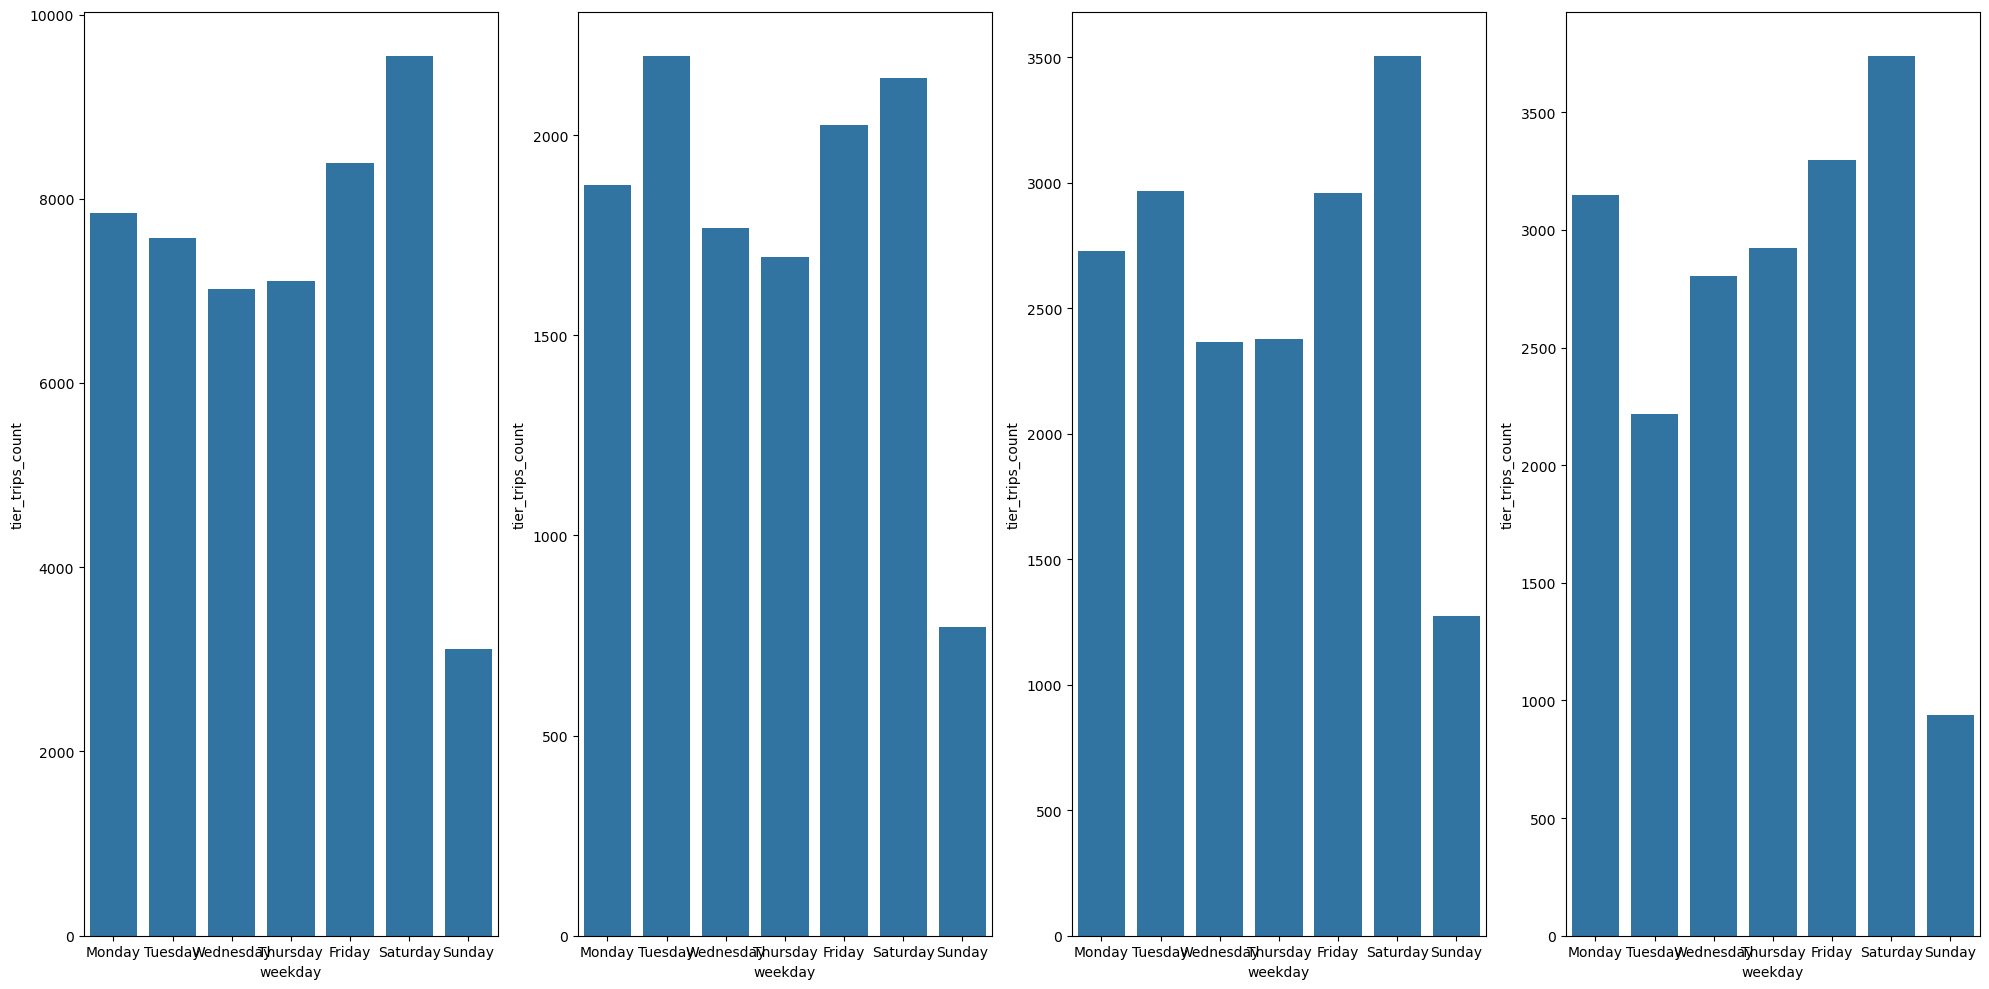

In [151]:
fig, axes = plt.subplots(ncols=4)
plt.rcParams["figure.figsize"] = [20.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(weekday_data, x="weekday", y="tier_trips_count",  ax=axes[0])
sns.barplot(weekday_delay, x="weekday", y="tier_trips_count",  ax=axes[1])
sns.barplot(weekday_no_delay, x="weekday", y="tier_trips_count",  ax=axes[2])
sns.barplot(weekday_nan_delay, x="weekday", y="tier_trips_count",  ax=axes[3])
#plt.set_xticklabels(plt.get_xticklabels(), rotation=45)
plt

<module 'matplotlib.pyplot' from '/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/matplotlib/pyplot.py'>

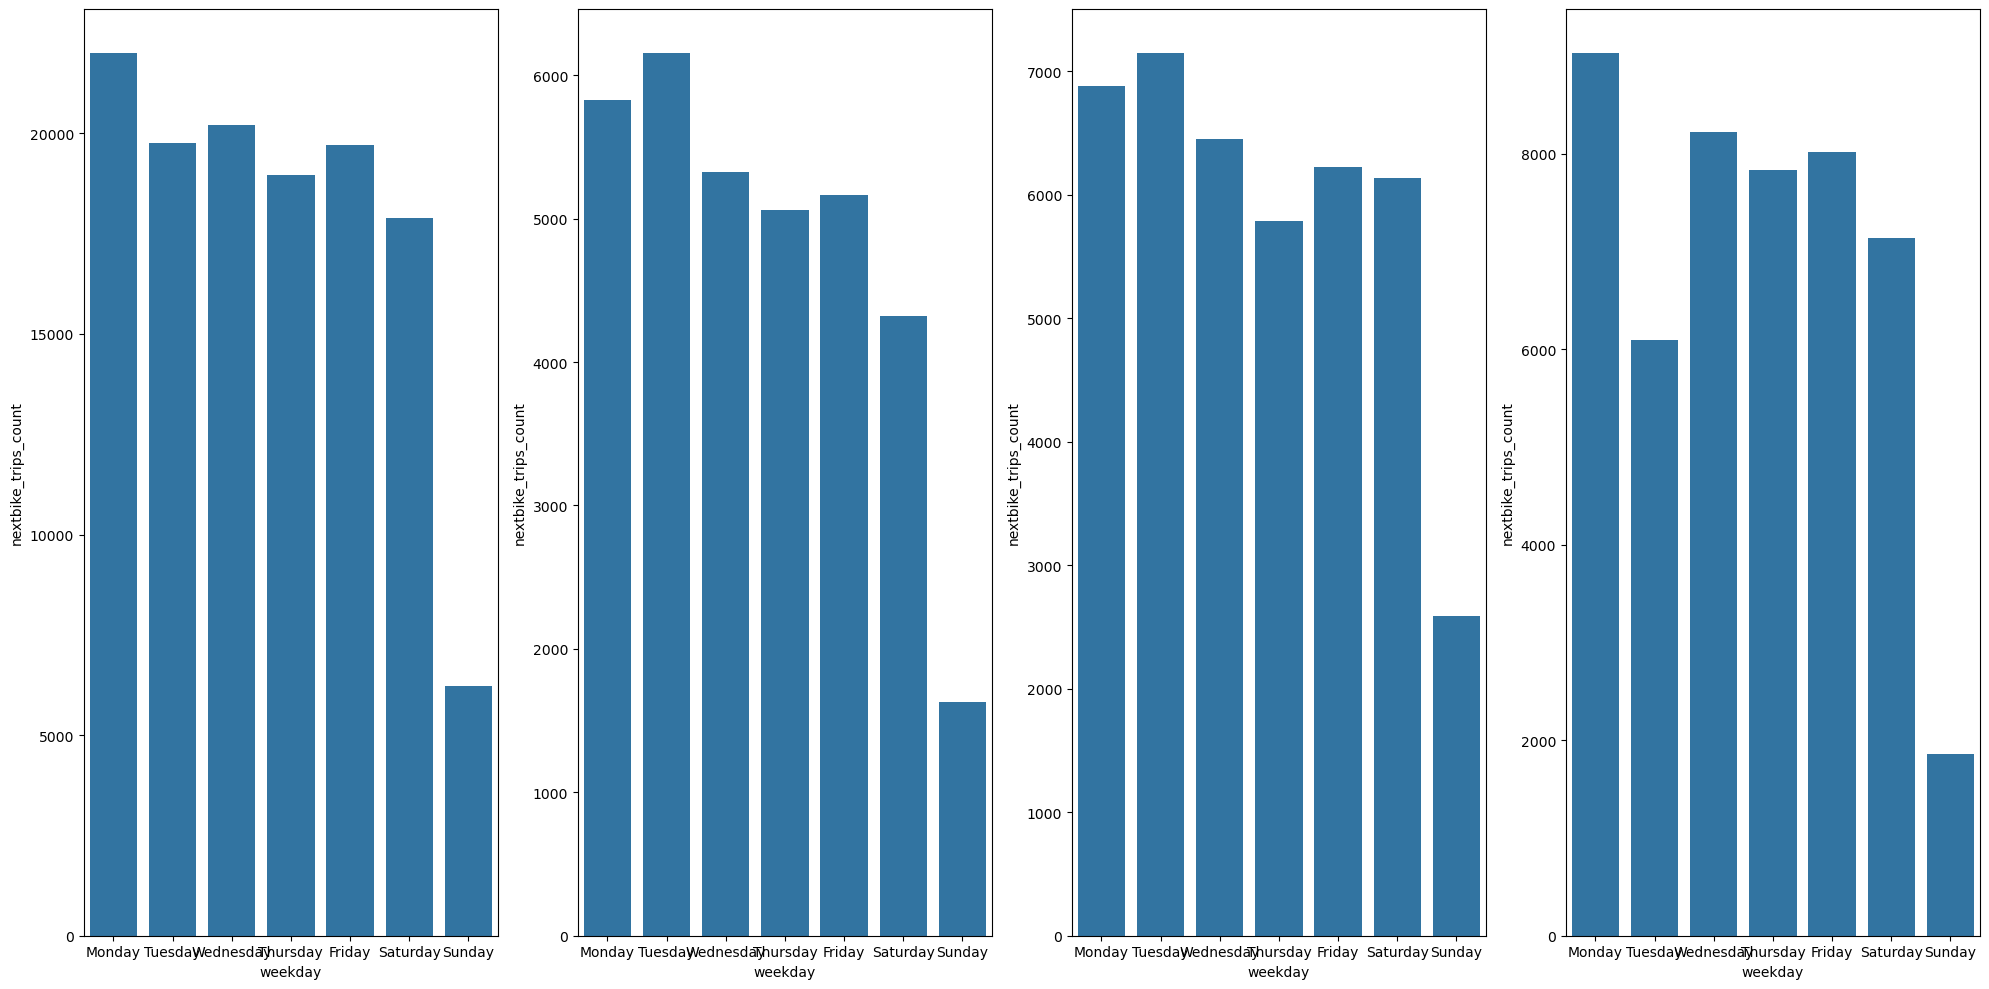

In [152]:
fig, axes = plt.subplots(ncols=4)
plt.rcParams["figure.figsize"] = [20.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(weekday_data, x="weekday", y="nextbike_trips_count",  ax=axes[0])
sns.barplot(weekday_delay, x="weekday", y="nextbike_trips_count",  ax=axes[1])
sns.barplot(weekday_no_delay, x="weekday", y="nextbike_trips_count",  ax=axes[2])
sns.barplot(weekday_nan_delay, x="weekday", y="nextbike_trips_count",  ax=axes[3])
#plt.set_xticklabels(plt.get_xticklabels(), rotation=45)
plt

In [153]:
# weekend

In [154]:
weekend_data = data.groupby(data['weekend']).agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum', 'arrival_delay' : 'mean'})
weekend_delay = delay.groupby(delay['weekend']).agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum', 'arrival_delay' : 'mean'})
weekend_no_delay = no_delay.groupby(no_delay['weekend']).agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum', 'arrival_delay' : 'mean'})
weekend_nan_delay = nan_delay.groupby(nan_delay['weekend']).agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum', 'arrival_delay' : 'mean'})

<module 'matplotlib.pyplot' from '/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/matplotlib/pyplot.py'>

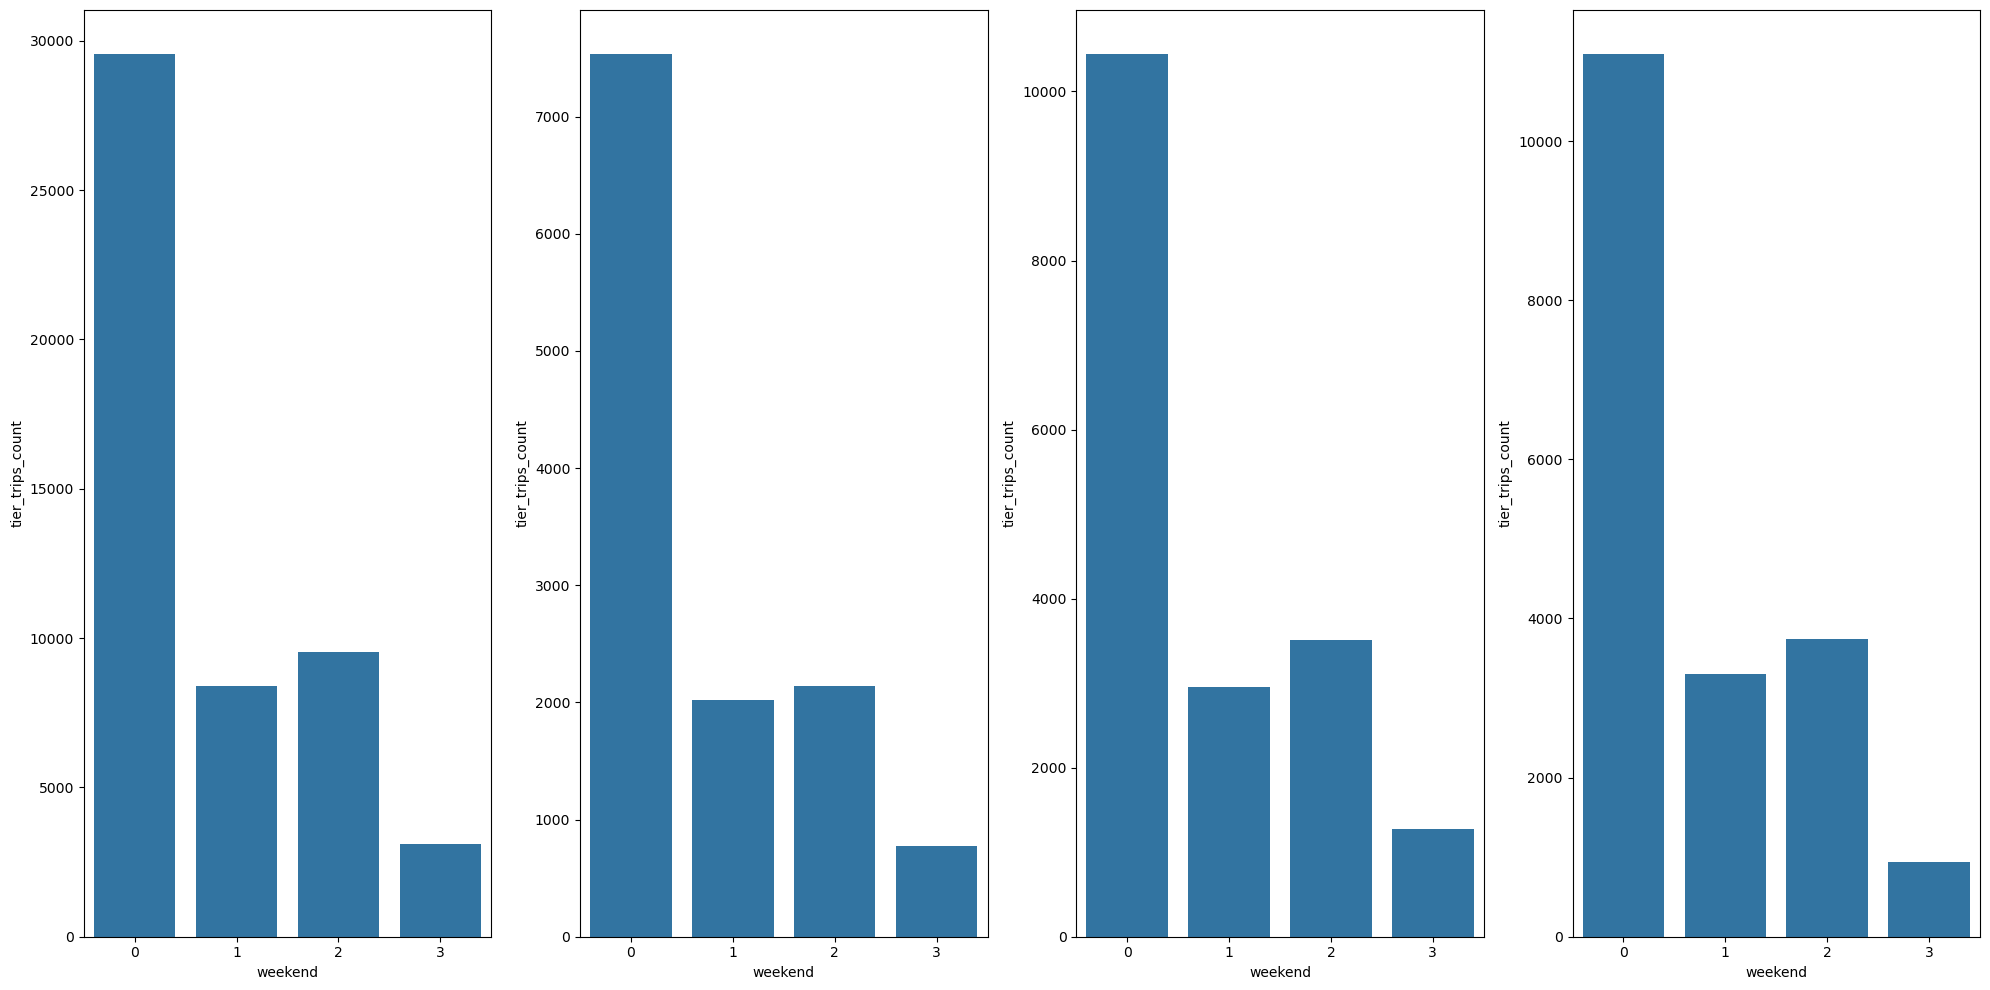

In [155]:
fig, axes = plt.subplots(ncols=4)
plt.rcParams["figure.figsize"] = [20.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(weekend_data, x="weekend", y="tier_trips_count",  ax=axes[0])
sns.barplot(weekend_delay, x="weekend", y="tier_trips_count",  ax=axes[1])
sns.barplot(weekend_no_delay, x="weekend", y="tier_trips_count",  ax=axes[2])
sns.barplot(weekend_nan_delay, x="weekend", y="tier_trips_count",  ax=axes[3])
#plt.set_xticklabels(plt.get_xticklabels(), rotation=45)
plt

<module 'matplotlib.pyplot' from '/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/matplotlib/pyplot.py'>

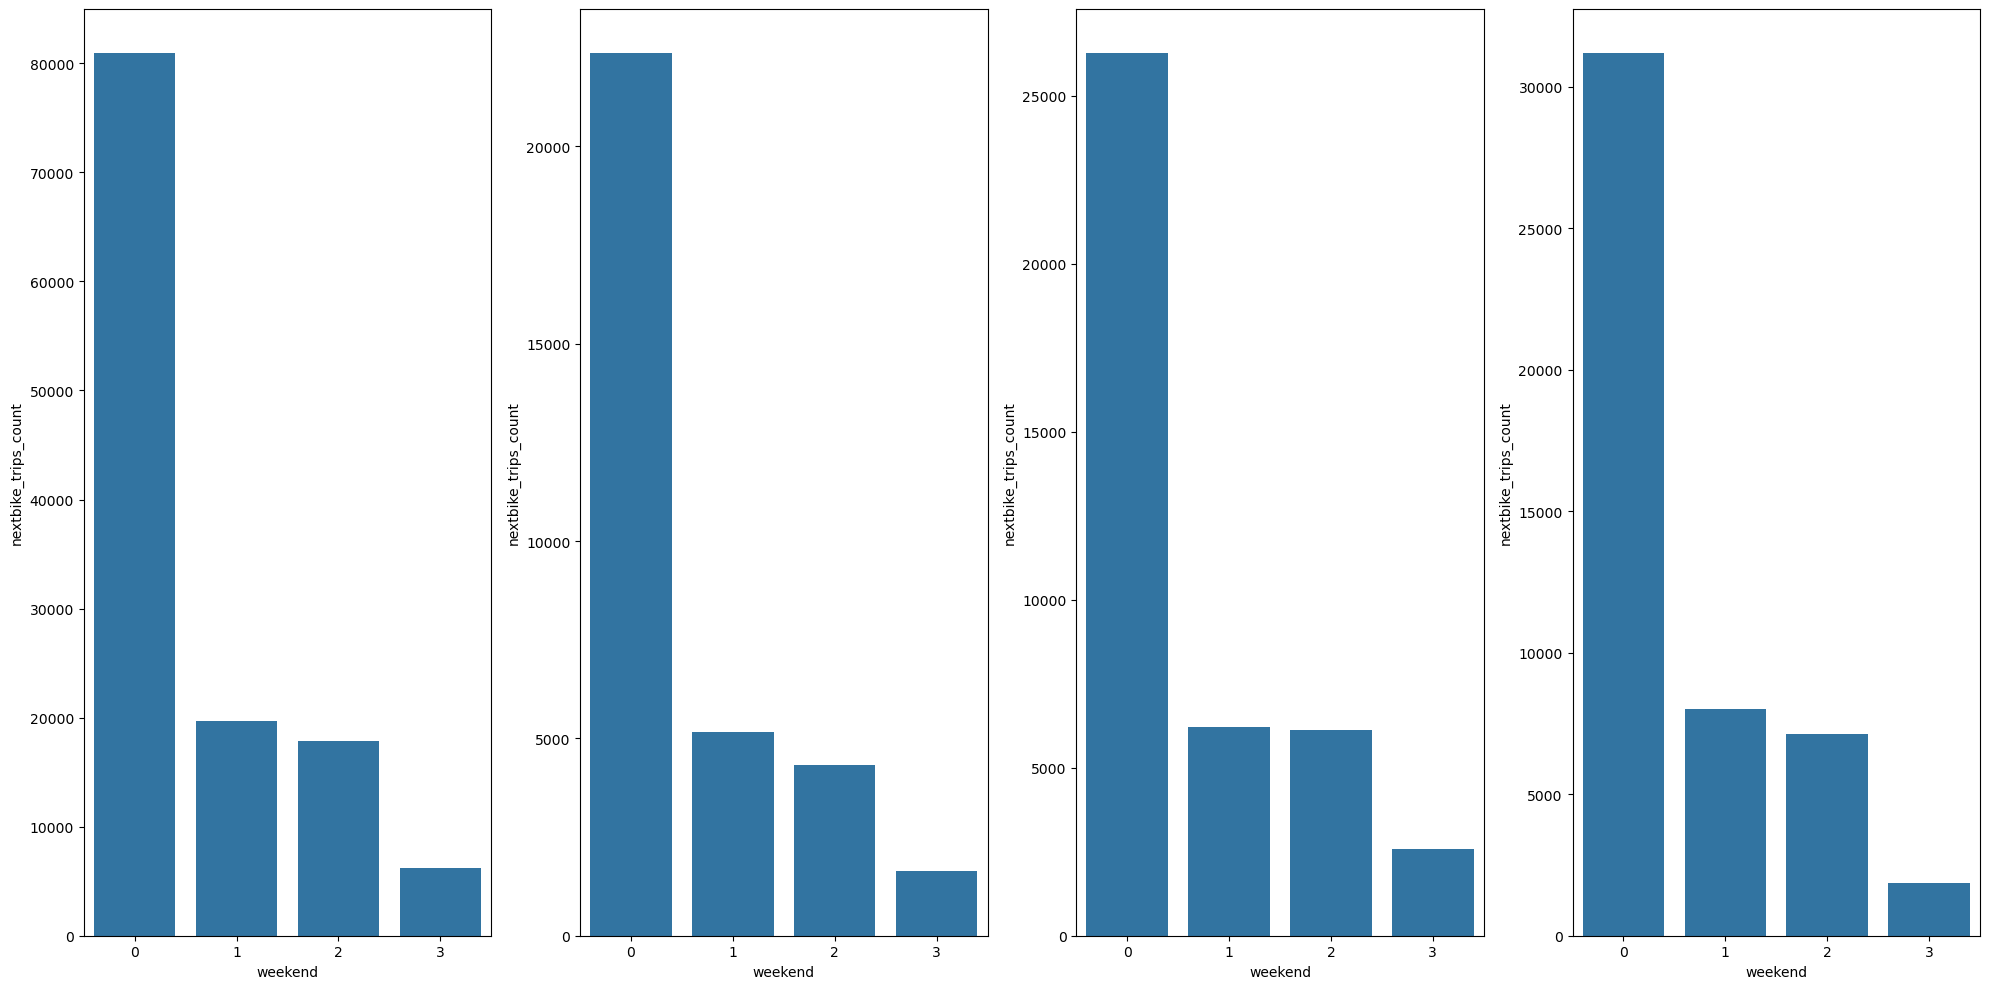

In [156]:
fig, axes = plt.subplots(ncols=4)
plt.rcParams["figure.figsize"] = [20.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(weekend_data, x="weekend", y="nextbike_trips_count",  ax=axes[0])
sns.barplot(weekend_delay, x="weekend", y="nextbike_trips_count",  ax=axes[1])
sns.barplot(weekend_no_delay, x="weekend", y="nextbike_trips_count",  ax=axes[2])
sns.barplot(weekend_nan_delay, x="weekend", y="nextbike_trips_count",  ax=axes[3])
#plt.set_xticklabels(plt.get_xticklabels(), rotation=45)
plt

<module 'matplotlib.pyplot' from '/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/matplotlib/pyplot.py'>

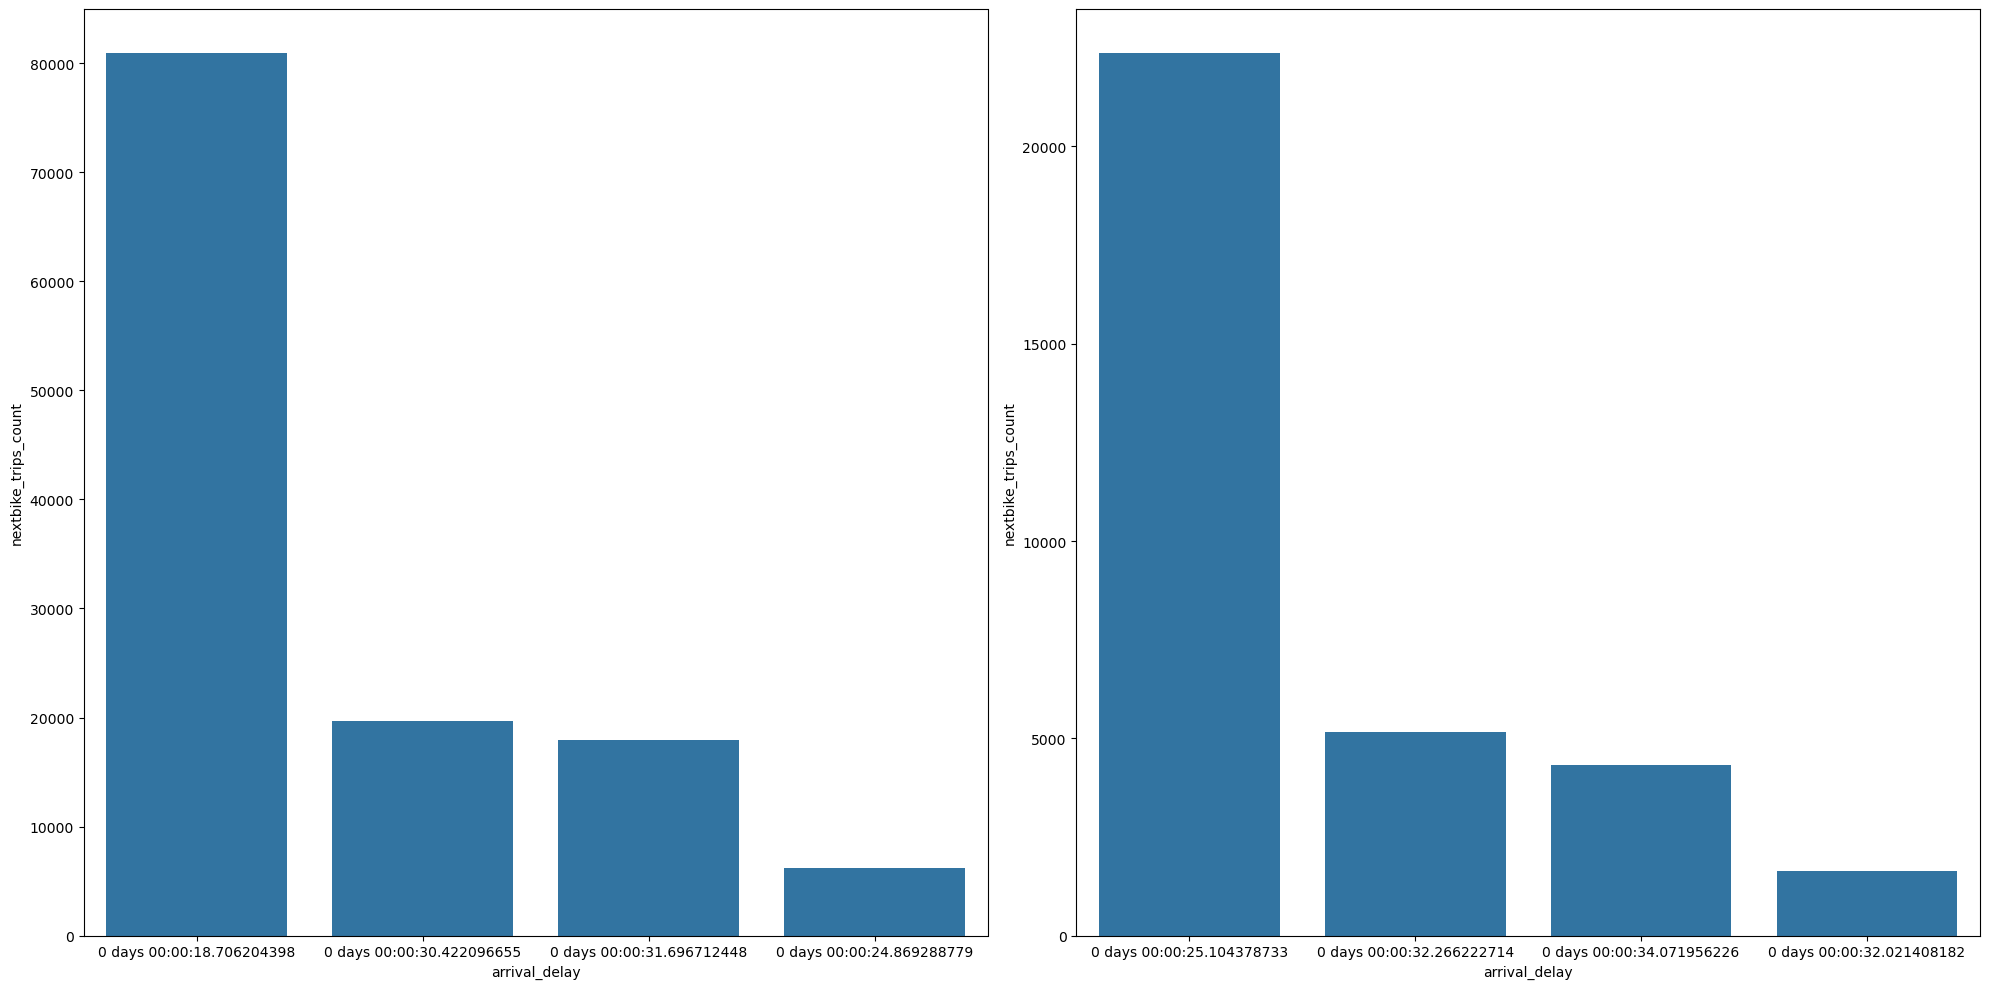

In [157]:
fig, axes = plt.subplots(ncols=2)
plt.rcParams["figure.figsize"] = [20.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(weekend_data, x="arrival_delay", y="nextbike_trips_count",  ax=axes[0])
sns.barplot(weekend_delay, x="arrival_delay", y="nextbike_trips_count",  ax=axes[1])
#plt.set_xticklabels(plt.get_xticklabels(), rotation=45)
plt

### Weather

In [158]:
w_desc_data = data.groupby(data['current_description']).agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum', 'arrival_delay' : 'mean'})
w_desc_delay = delay.groupby(delay['current_description']).agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum', 'arrival_delay' : 'mean'})
w_desc_no_delay = no_delay.groupby(no_delay['current_description']).agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum', 'arrival_delay' : 'mean'})
w_desc_nan_delay = nan_delay.groupby(nan_delay['current_description']).agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum', 'arrival_delay' : 'mean'})

In [159]:
w_desc_delay

tier_trips_count  nextbike_trips_count  \
current_description                                                    
broken clouds                              911                  2441   
clear sky                                 6960                 18916   
drizzle                                      8                    33   
few clouds                                1850                  5325   
heavy intensity shower rain                  0                     1   
light intensity drizzle                     47                   125   
light intensity drizzle rain                20                    81   
light intensity shower rain                222                   464   
light rain                                 828                  2032   
mist                                        88                   227   
moderate rain                              155                   340   
overcast clouds                            537                  1445   
scattered clouds                           702                  1732   
shower rain                                 78                   123   
thunderstorm with heavy rain                45                   142   
thunderstorm with rain                      21                    57   

                                         arrival_delay  
current_description                                     
broken clouds                0 days 00:00:27.091862016  
clear sky                    0 days 00:00:29.355346283  
drizzle                      0 days 00:00:20.590024330  
few clouds                   0 days 00:00:31.745257509  
heavy intensity shower rain     0 days 00:05:59.650000  
light intensity drizzle      0 days 00:00:23.835166639  
light intensity drizzle rain 0 days 00:00:24.233143399  
light intensity shower rain  0 days 00:00:22.451250529  
light rain                   0 days 00:00:25.252473806  
mist                         0 days 00:00:20.620923913  
moderate rain                0 days 00:00:19.442946058  
overcast clouds              0 days 00:00:23.104336491  
scattered clouds             0 days 00:00:23.998575841  
shower rain                  0 days 00:00:22.274258050  
thunderstorm with heavy rain 0 days 00:00:20.043134435  
thunderstorm with rain       0 days 00:00:23.130081300

<module 'matplotlib.pyplot' from '/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/matplotlib/pyplot.py'>

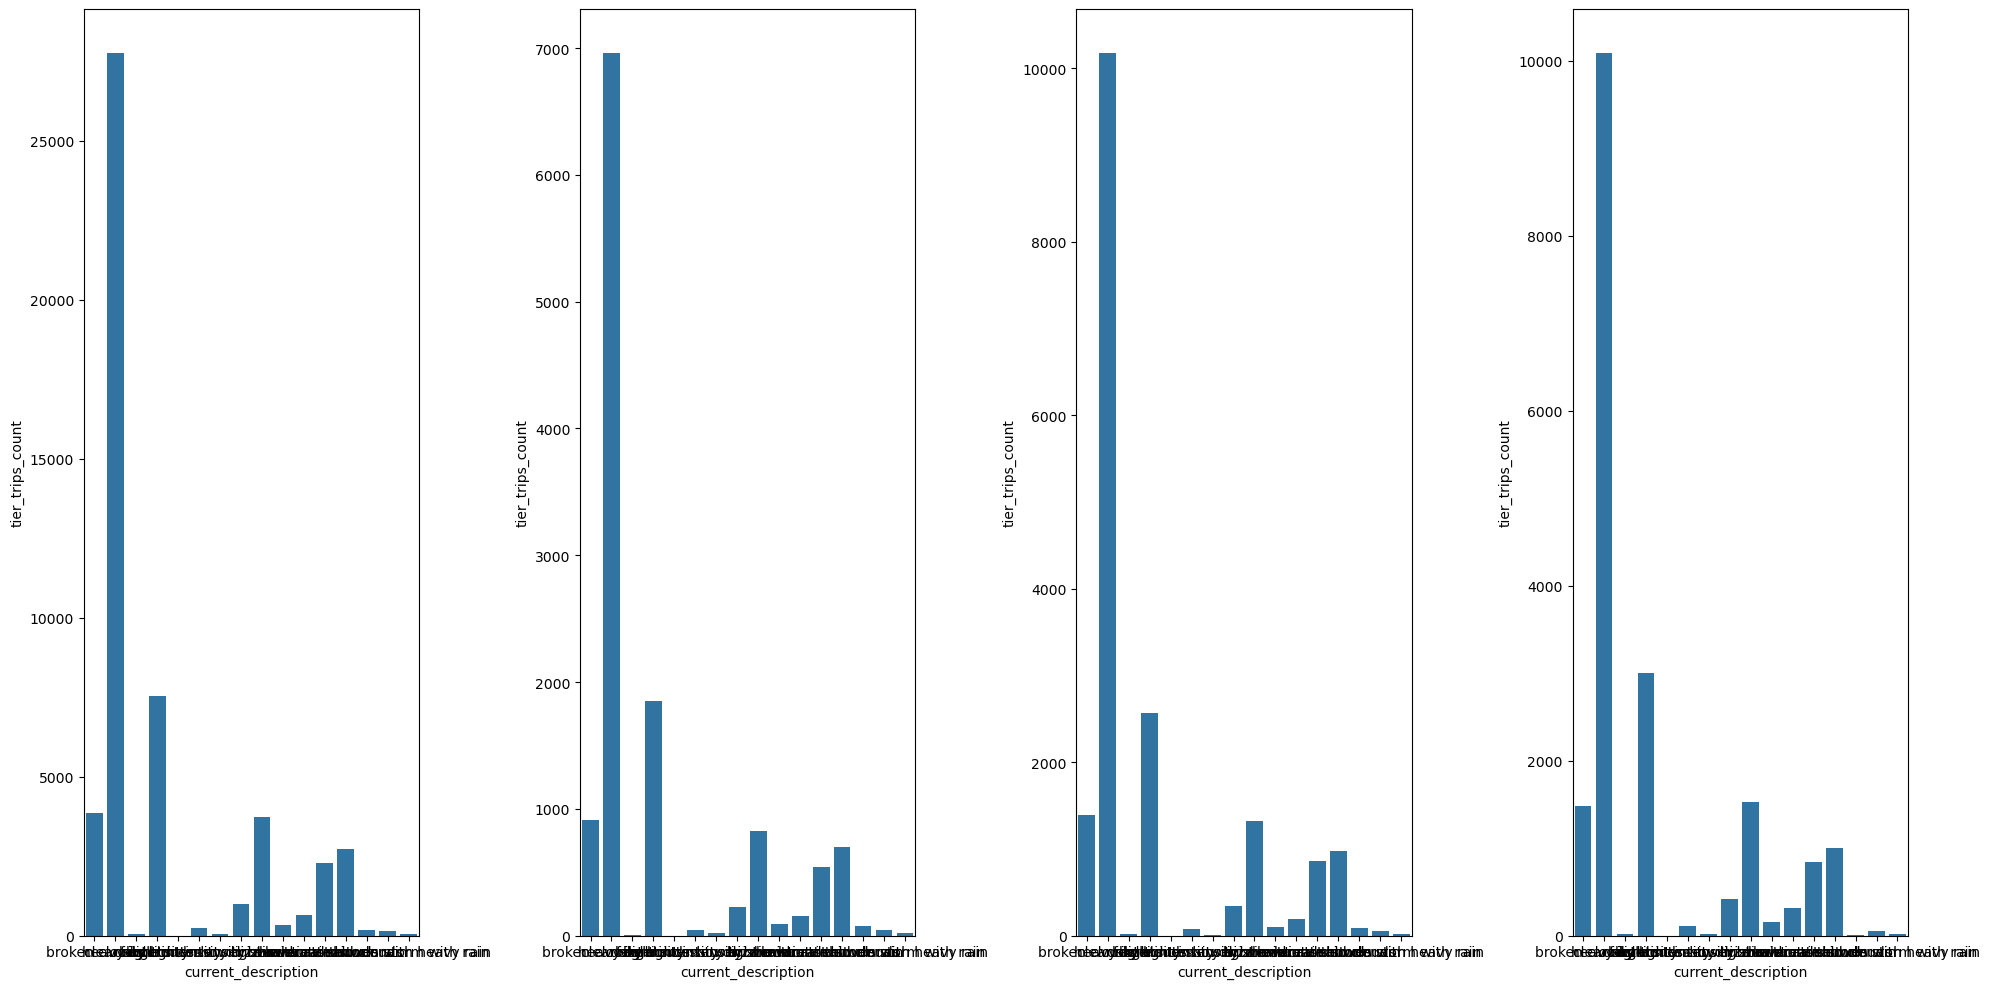

In [160]:
fig, axes = plt.subplots(ncols=4)
plt.rcParams["figure.figsize"] = [20.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(w_desc_data, x="current_description", y="tier_trips_count", ax = axes[0])
sns.barplot(w_desc_delay, x="current_description", y="tier_trips_count", ax = axes[1])
sns.barplot(w_desc_no_delay, x="current_description", y="tier_trips_count", ax = axes[2])
sns.barplot(w_desc_nan_delay, x="current_description", y="tier_trips_count", ax = axes[3])
#plt.set_xticklabels(plt.get_xticklabels(), rotation=45)
plt

<module 'matplotlib.pyplot' from '/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/matplotlib/pyplot.py'>

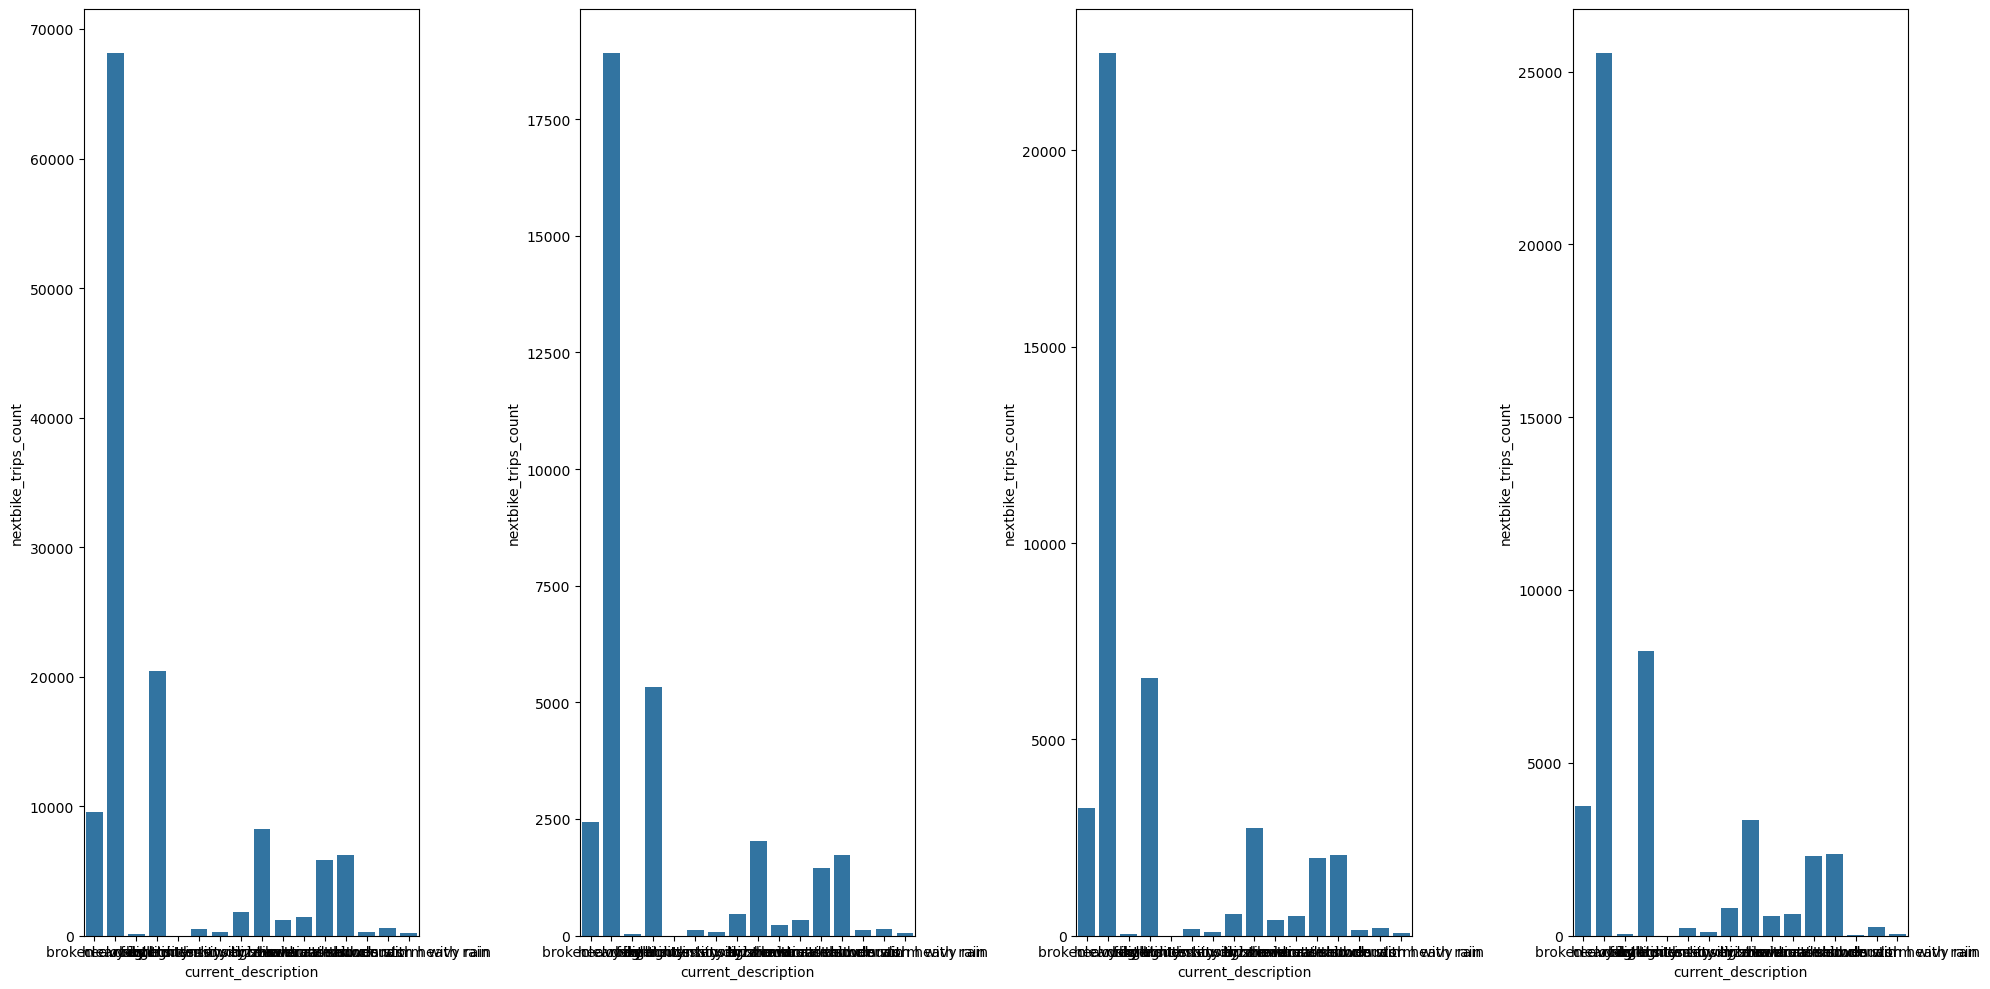

In [161]:
fig, axes = plt.subplots(ncols=4)
plt.rcParams["figure.figsize"] = [20.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(w_desc_data, x="current_description", y="nextbike_trips_count", ax = axes[0])
sns.barplot(w_desc_delay, x="current_description", y="nextbike_trips_count", ax = axes[1])
sns.barplot(w_desc_no_delay, x="current_description", y="nextbike_trips_count", ax = axes[2])
sns.barplot(w_desc_nan_delay, x="current_description", y="nextbike_trips_count", ax = axes[3])
#plt.set_xticklabels(plt.get_xticklabels(), rotation=45)
plt

<module 'matplotlib.pyplot' from '/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/matplotlib/pyplot.py'>

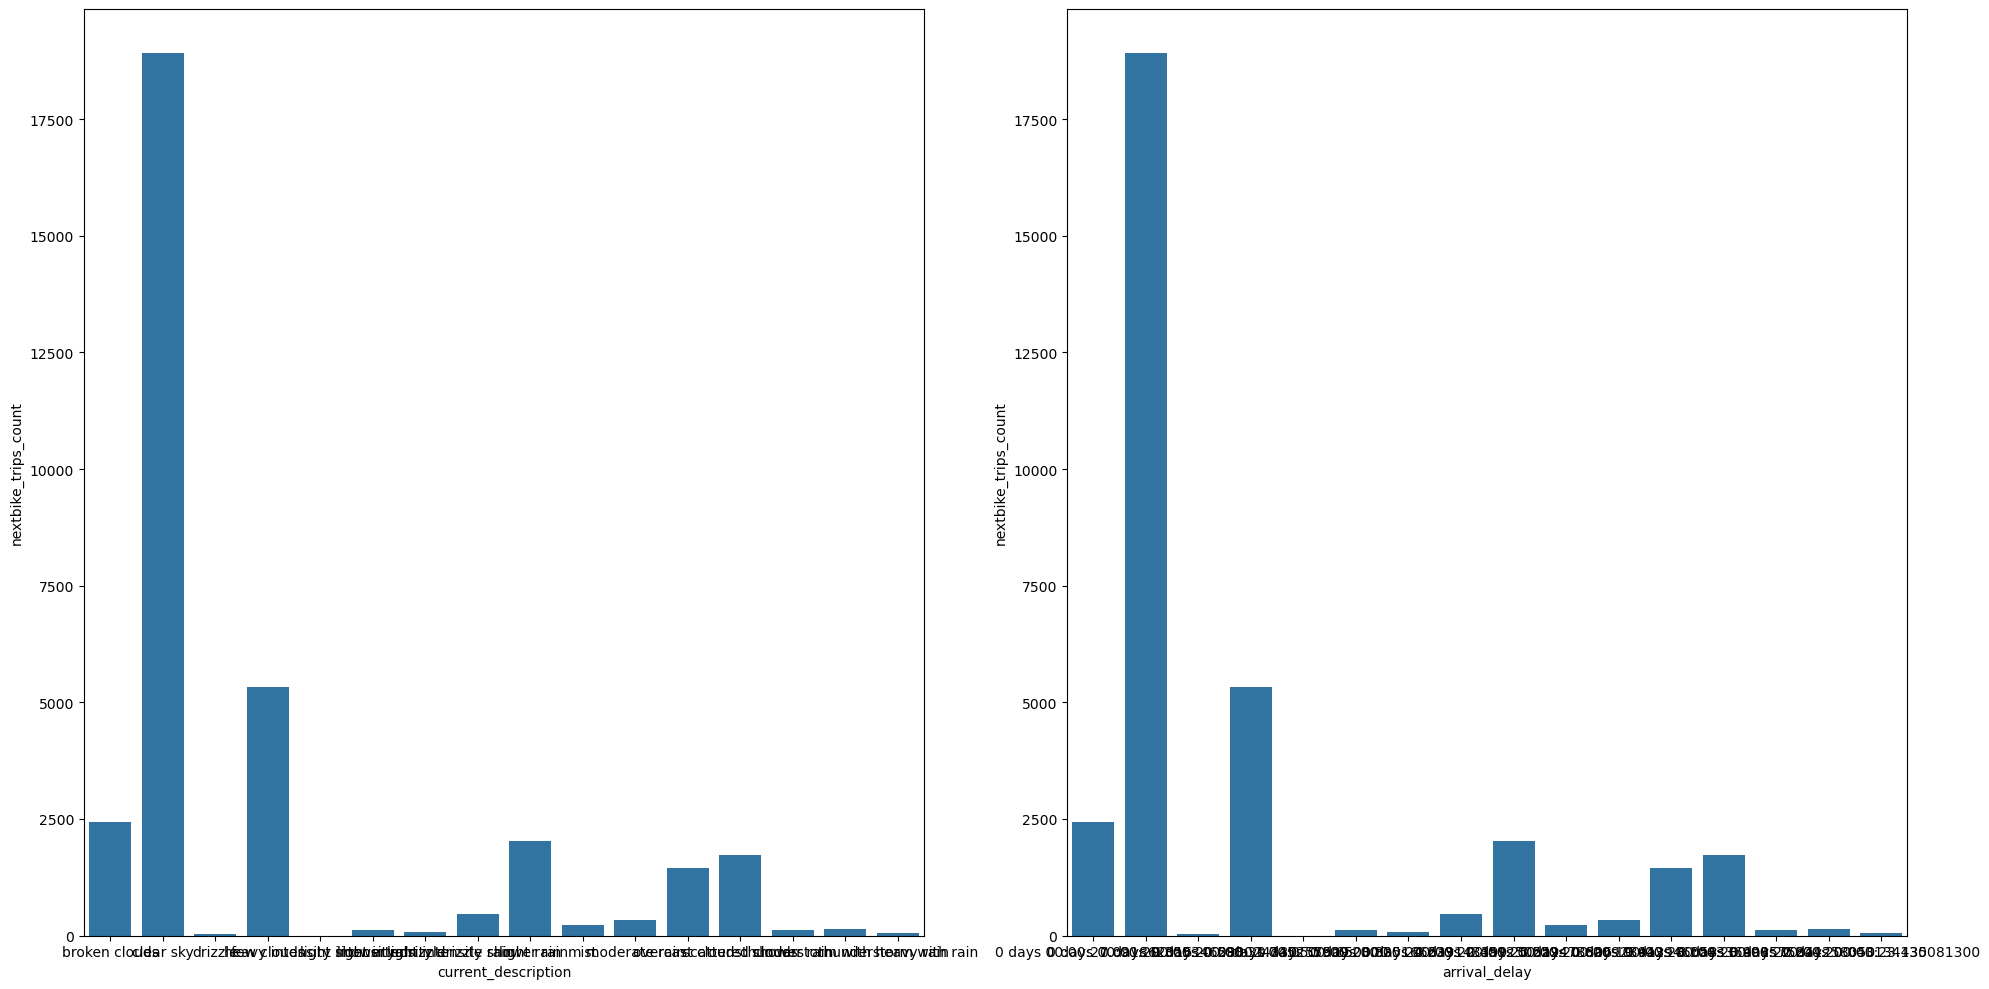

In [162]:
fig, axes = plt.subplots(ncols=2)
plt.rcParams["figure.figsize"] = [20.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(w_desc_delay, x="current_description", y="nextbike_trips_count", ax = axes[0])
sns.barplot(w_desc_delay, x="arrival_delay", y="nextbike_trips_count", ax = axes[1])
#plt.set_xticklabels(plt.get_xticklabels(), rotation=45)
plt

<module 'matplotlib.pyplot' from '/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/matplotlib/pyplot.py'>

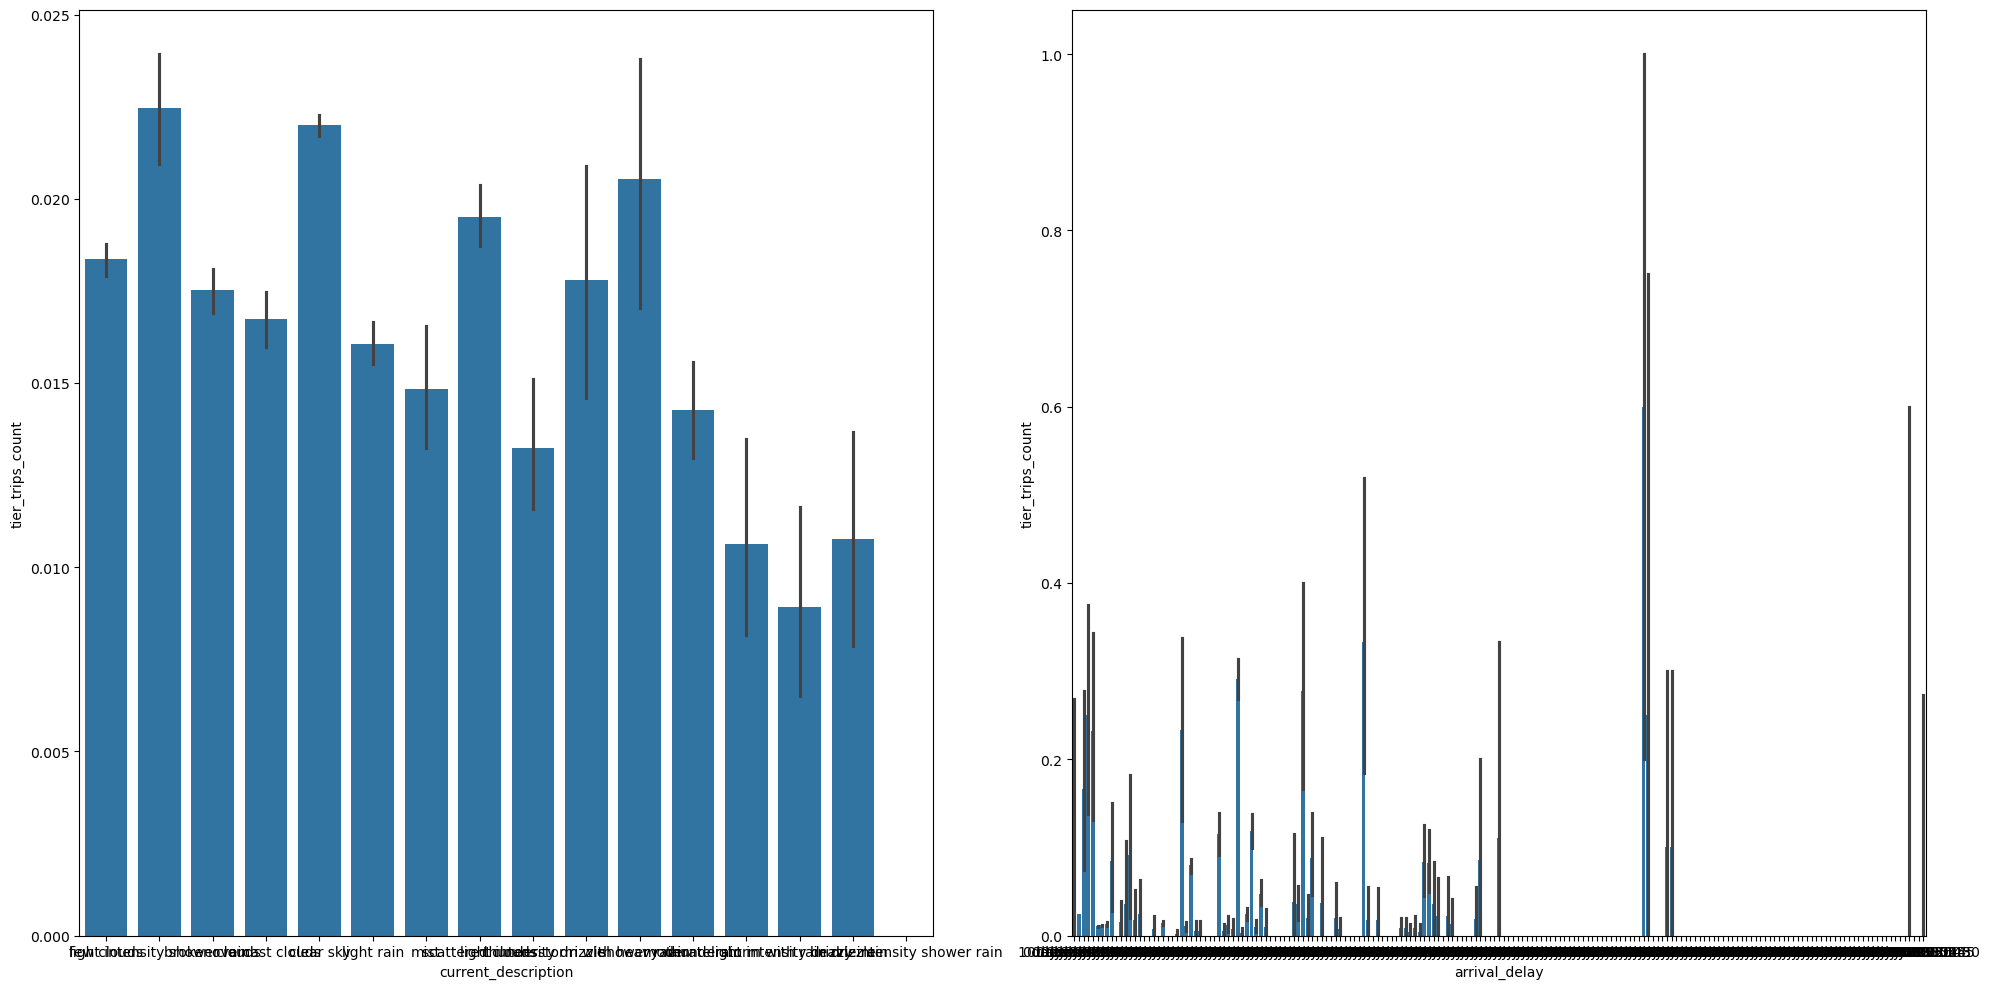

In [163]:
fig, axes = plt.subplots(ncols=2)
plt.rcParams["figure.figsize"] = [20.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data, x="current_description", y="tier_trips_count", ax = axes[0])
sns.barplot(data, x="arrival_delay", y="tier_trips_count", ax = axes[1])
#plt.set_xticklabels(plt.get_xticklabels(), rotation=45)
plt

<module 'matplotlib.pyplot' from '/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/matplotlib/pyplot.py'>

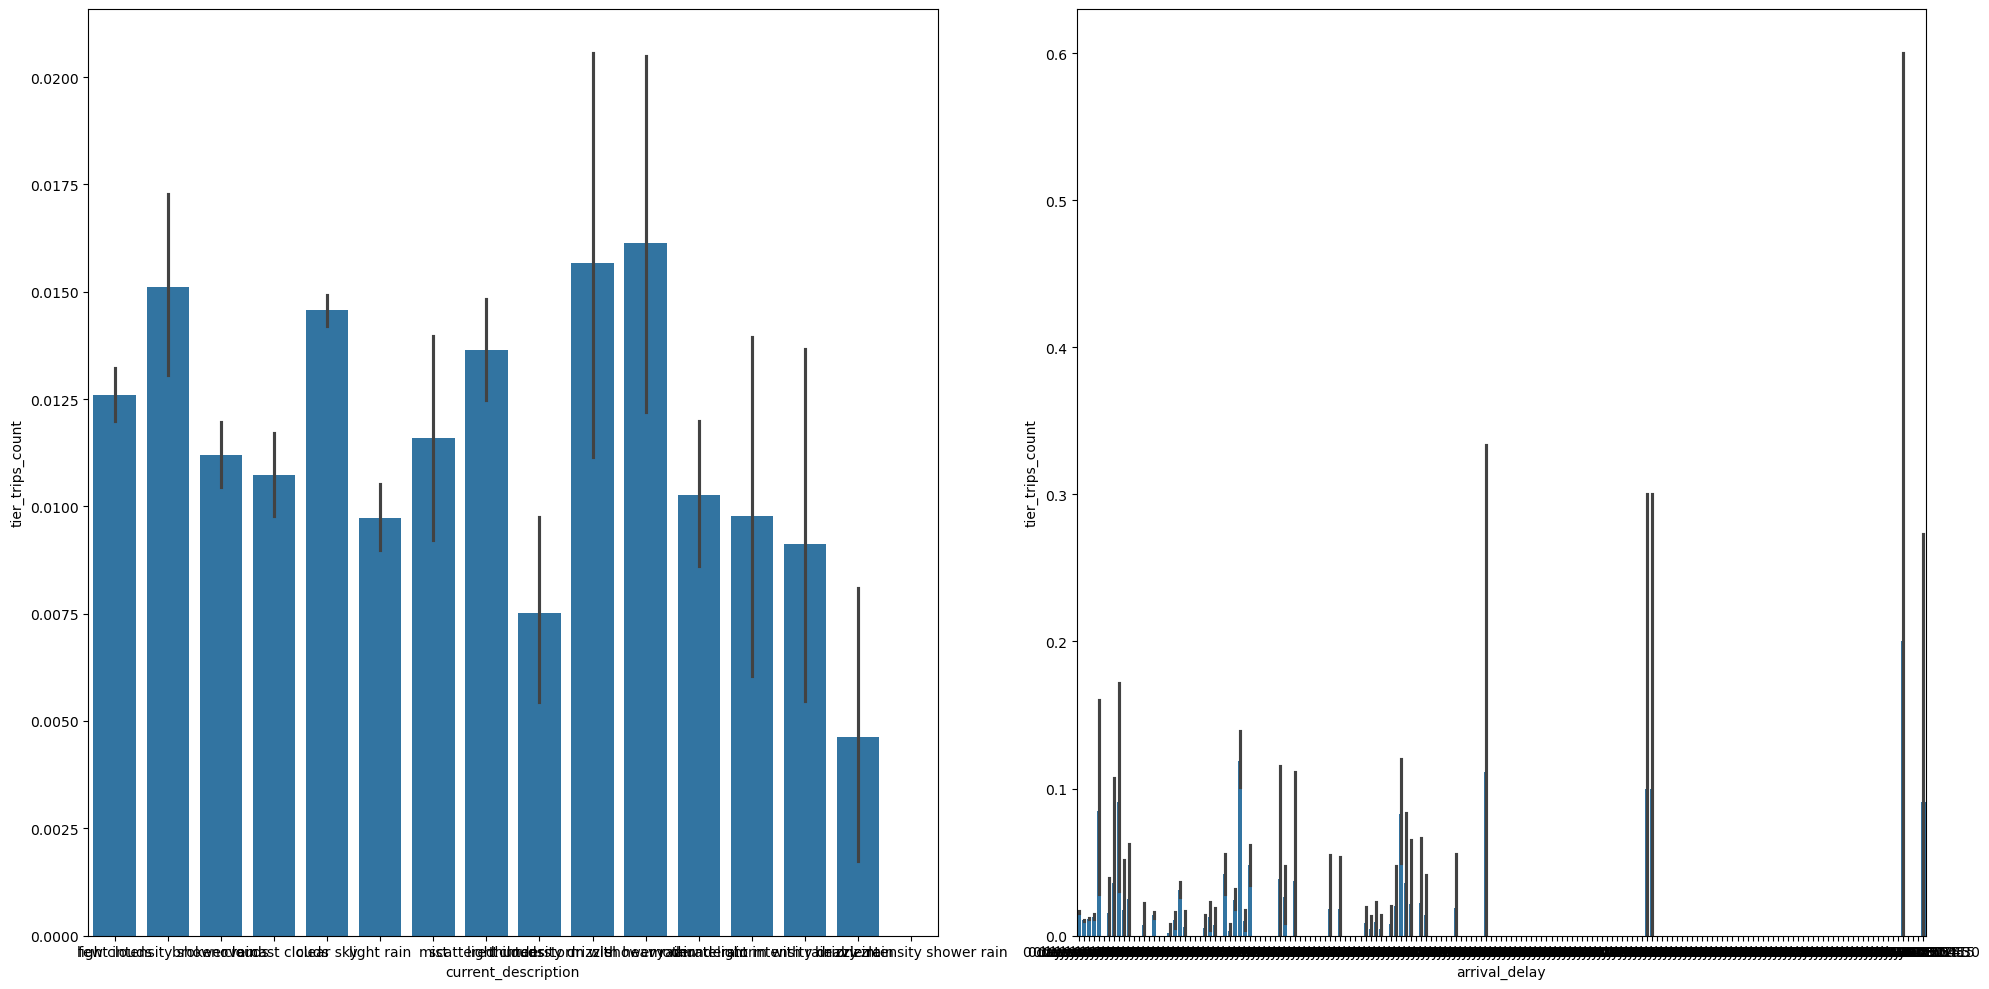

In [164]:
fig, axes = plt.subplots(ncols=2)
plt.rcParams["figure.figsize"] = [20.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(delay, x="current_description", y="tier_trips_count", ax = axes[0])
sns.barplot(delay, x="arrival_delay", y="tier_trips_count", ax = axes[1])
#plt.set_xticklabels(plt.get_xticklabels(), rotation=45)
plt

In [165]:
# Percipation

In [166]:
w_desc_data = data.groupby(data['current_precipitation_volume']).agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum', 'arrival_delay' : 'mean'})
w_desc_delay = delay.groupby(delay['current_precipitation_volume']).agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum', 'arrival_delay' : 'mean'})
w_desc_no_delay = no_delay.groupby(no_delay['current_precipitation_volume']).agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum', 'arrival_delay' : 'mean'})
w_desc_nan_delay = nan_delay.groupby(nan_delay['current_precipitation_volume']).agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum', 'arrival_delay' : 'mean'})

<module 'matplotlib.pyplot' from '/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/matplotlib/pyplot.py'>

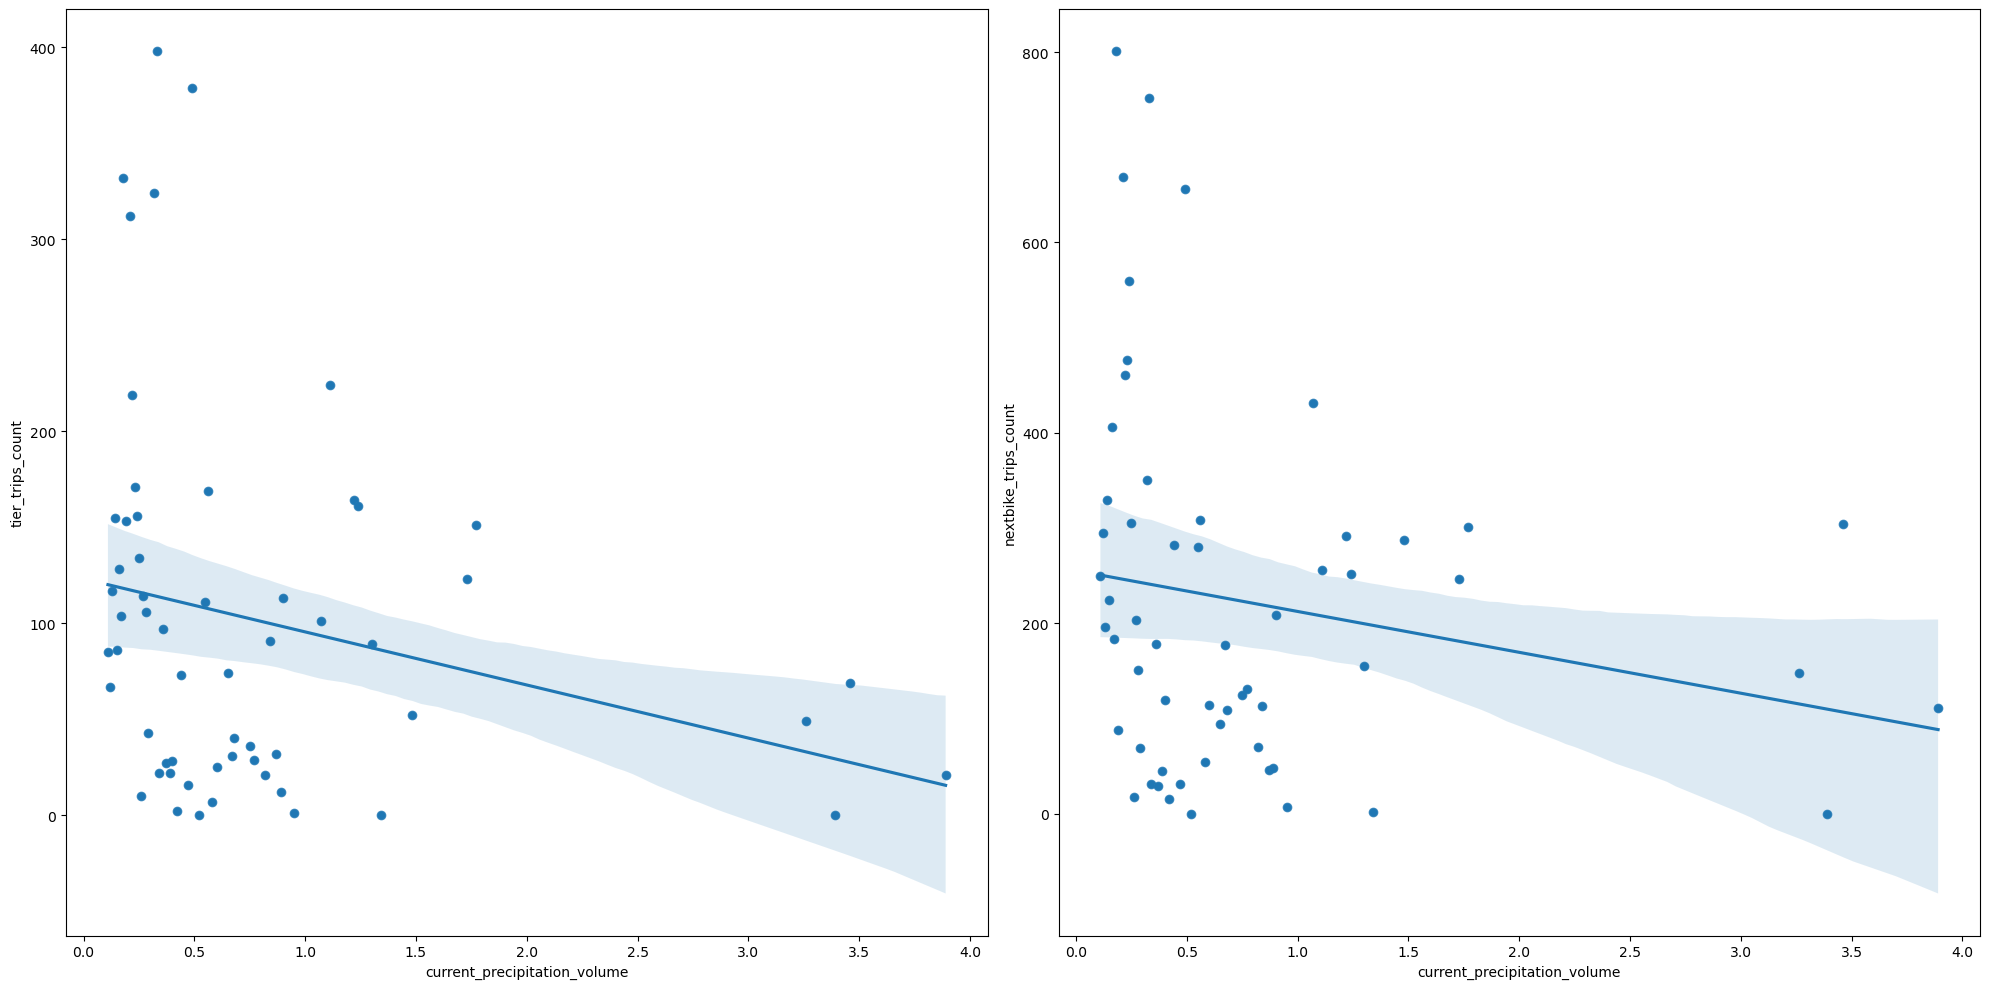

In [167]:
# Zeigt Beziehung zwischen zwei kontinuirlihen Variablen
fig, axes = plt.subplots(ncols=2)
plt.rcParams["figure.figsize"] = [20.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.scatterplot(x=w_desc_data.index, y='tier_trips_count', data=w_desc_data, ax = axes[0])
sns.regplot(x =w_desc_data.index, y='tier_trips_count', data=w_desc_data, scatter=True, ax = axes[0])

sns.scatterplot(x=w_desc_data.index, y='nextbike_trips_count', data=w_desc_data, ax = axes[1])
sns.regplot(x =w_desc_data.index, y='nextbike_trips_count', data=w_desc_data, scatter=True, ax = axes[1])
plt

<module 'matplotlib.pyplot' from '/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/matplotlib/pyplot.py'>

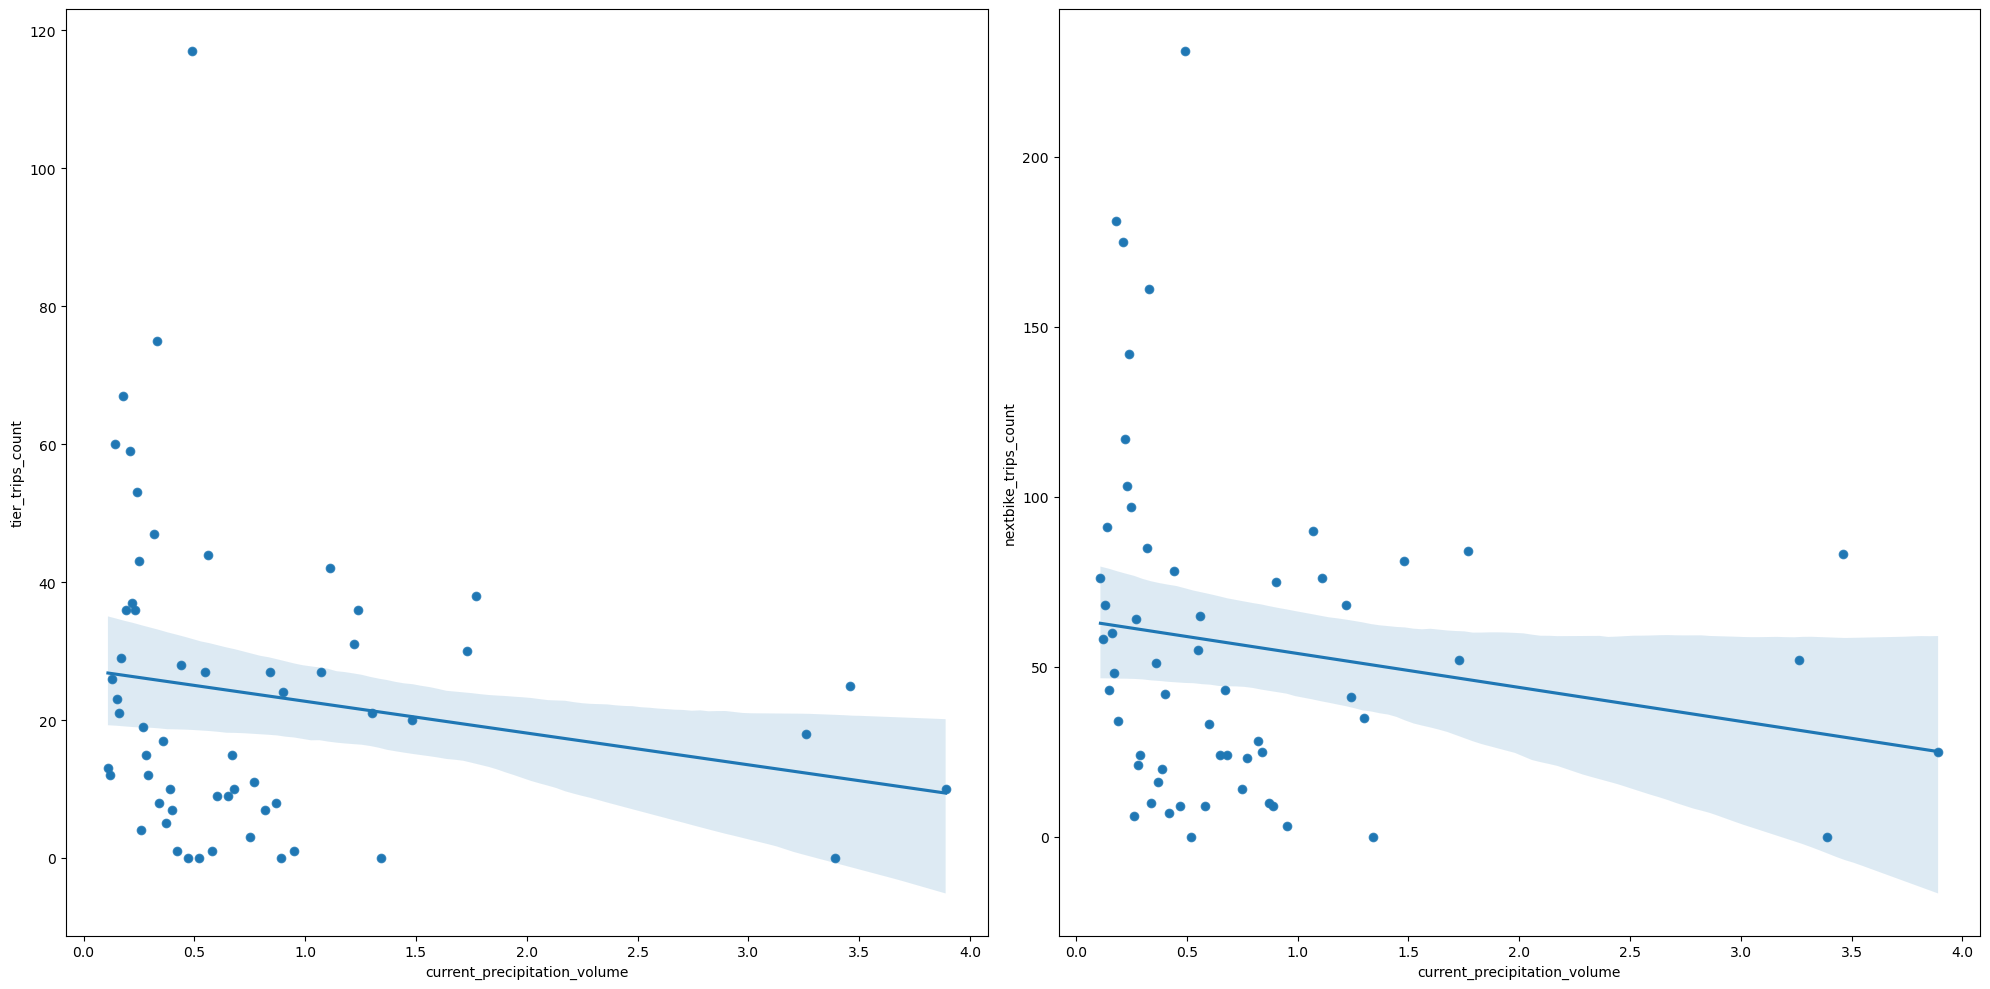

In [168]:
# Zeigt Beziehung zwischen zwei kontinuirlihen Variablen
fig, axes = plt.subplots(ncols=2)
plt.rcParams["figure.figsize"] = [20.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.scatterplot(x=w_desc_delay.index, y='tier_trips_count', data=w_desc_delay, ax = axes[0])
sns.regplot(x =w_desc_delay.index, y='tier_trips_count', data=w_desc_delay, scatter=True, ax = axes[0])

sns.scatterplot(x=w_desc_delay.index, y='nextbike_trips_count', data=w_desc_delay, ax = axes[1])
sns.regplot(x =w_desc_delay.index, y='nextbike_trips_count', data=w_desc_delay, scatter=True, ax = axes[1])
plt

<module 'matplotlib.pyplot' from '/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/matplotlib/pyplot.py'>

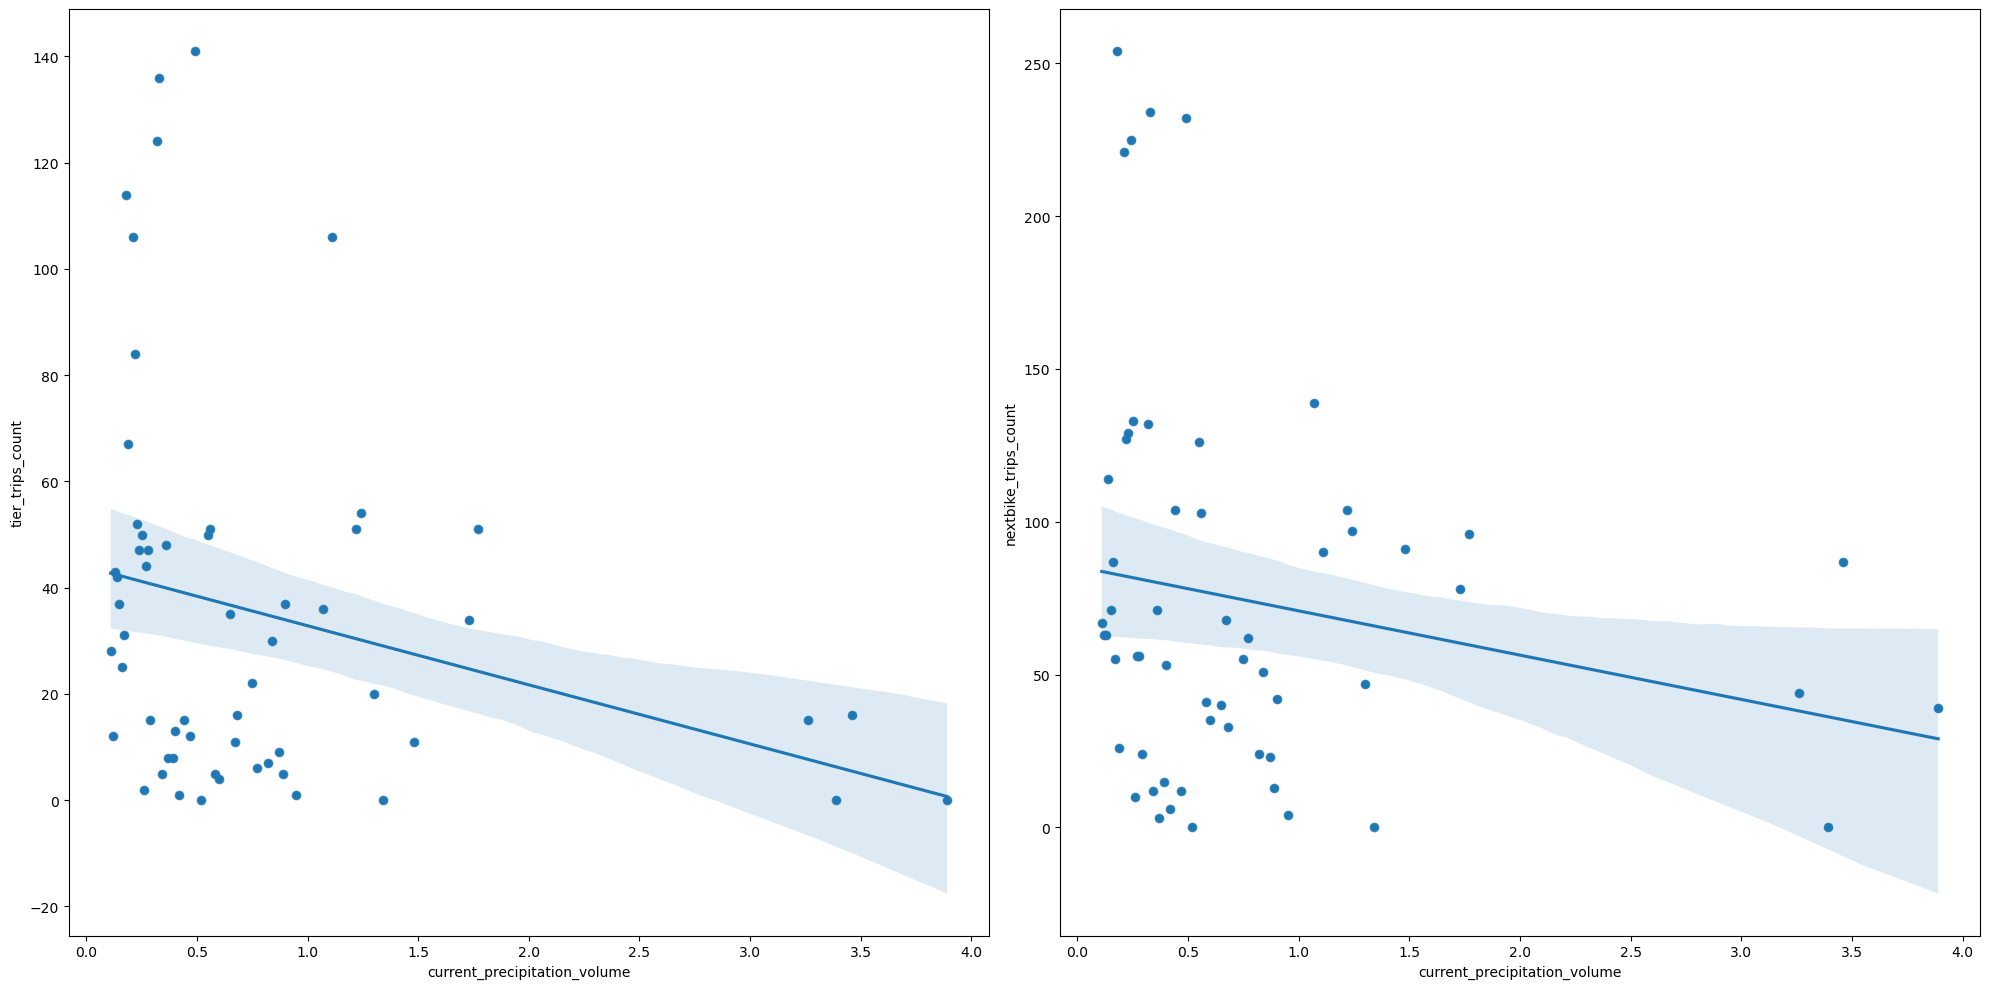

In [169]:
# Zeigt Beziehung zwischen zwei kontinuirlihen Variablen
fig, axes = plt.subplots(ncols=2)
plt.rcParams["figure.figsize"] = [20.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.scatterplot(x=w_desc_no_delay.index, y='tier_trips_count', data=w_desc_no_delay, ax = axes[0])
sns.regplot(x =w_desc_no_delay.index, y='tier_trips_count', data=w_desc_no_delay, scatter=True, ax = axes[0])

sns.scatterplot(x=w_desc_no_delay.index, y='nextbike_trips_count', data=w_desc_no_delay, ax = axes[1])
sns.regplot(x =w_desc_no_delay.index, y='nextbike_trips_count', data=w_desc_no_delay, scatter=True, ax = axes[1])
plt

<module 'matplotlib.pyplot' from '/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/matplotlib/pyplot.py'>

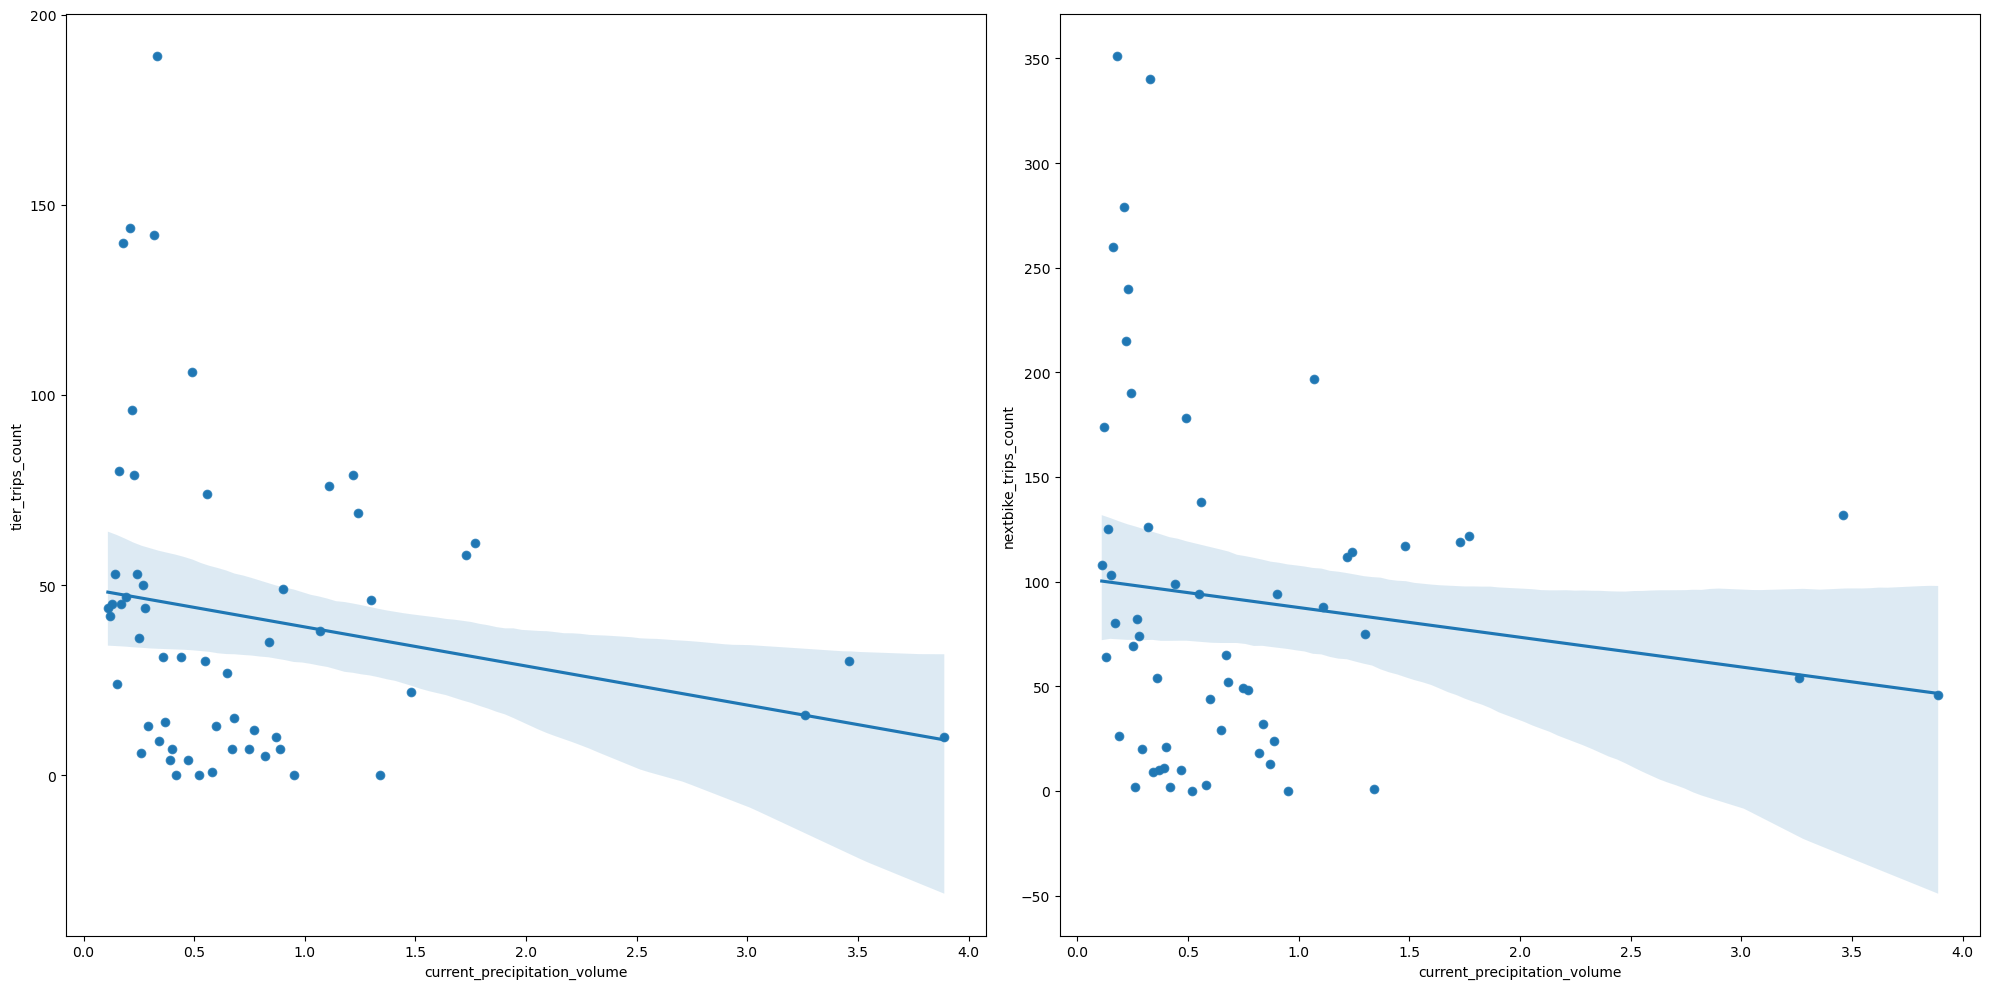

In [170]:
# Zeigt Beziehung zwischen zwei kontinuirlihen Variablen
fig, axes = plt.subplots(ncols=2)
plt.rcParams["figure.figsize"] = [20.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.scatterplot(x=w_desc_nan_delay.index, y='tier_trips_count', data=w_desc_nan_delay, ax = axes[0])
sns.regplot(x =w_desc_nan_delay.index, y='tier_trips_count', data=w_desc_nan_delay, scatter=True, ax = axes[0])

sns.scatterplot(x=w_desc_nan_delay.index, y='nextbike_trips_count', data=w_desc_nan_delay, ax = axes[1])
sns.regplot(x =w_desc_nan_delay.index, y='nextbike_trips_count', data=w_desc_nan_delay, scatter=True, ax = axes[1])
plt

<module 'matplotlib.pyplot' from '/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/matplotlib/pyplot.py'>

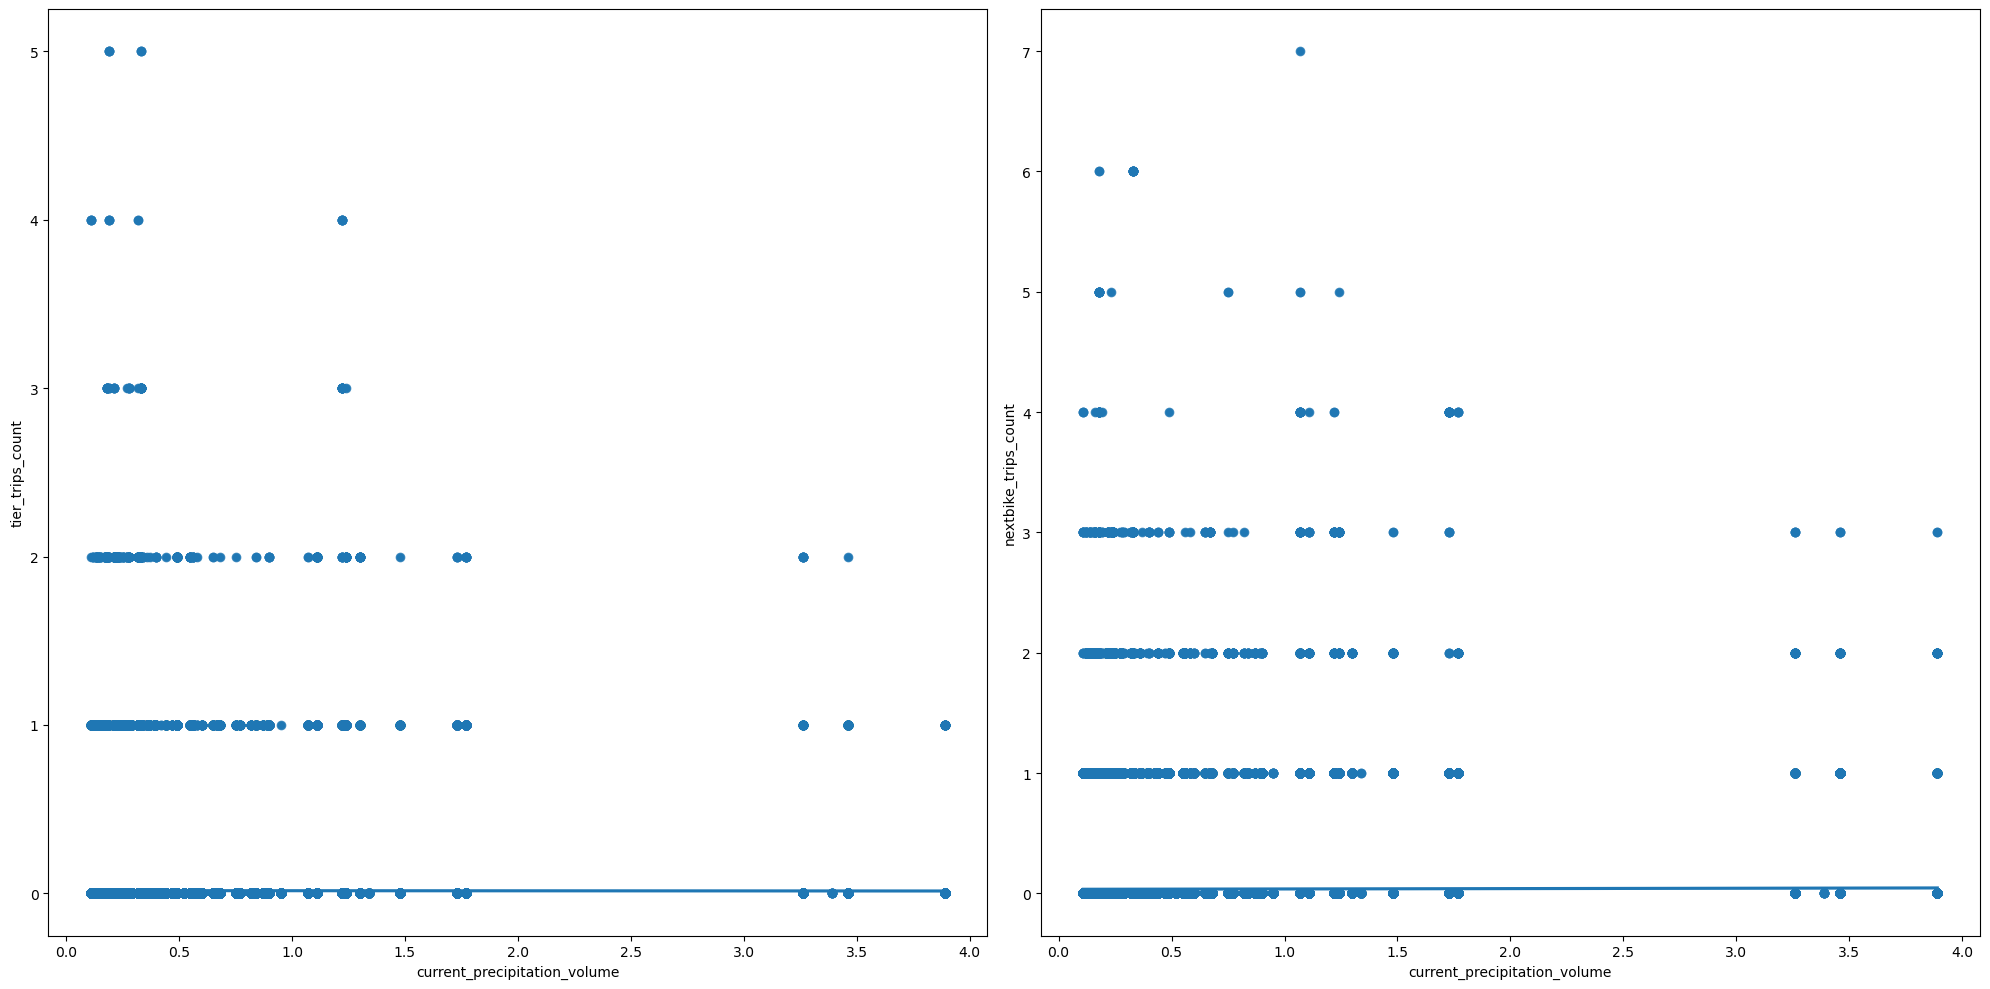

In [171]:
# Zeigt Beziehung zwischen zwei kontinuirlihen Variablen
fig, axes = plt.subplots(ncols=2)
plt.rcParams["figure.figsize"] = [20.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.scatterplot(x='current_precipitation_volume', y='tier_trips_count', data=data, ax = axes[0])
sns.regplot(x ='current_precipitation_volume', y='tier_trips_count', data=data, scatter=True, ax = axes[0])

sns.scatterplot(x='current_precipitation_volume', y='nextbike_trips_count', data=data, ax = axes[1])
sns.regplot(x ='current_precipitation_volume', y='nextbike_trips_count', data=data, scatter=True, ax = axes[1])
plt

<module 'matplotlib.pyplot' from '/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/matplotlib/pyplot.py'>

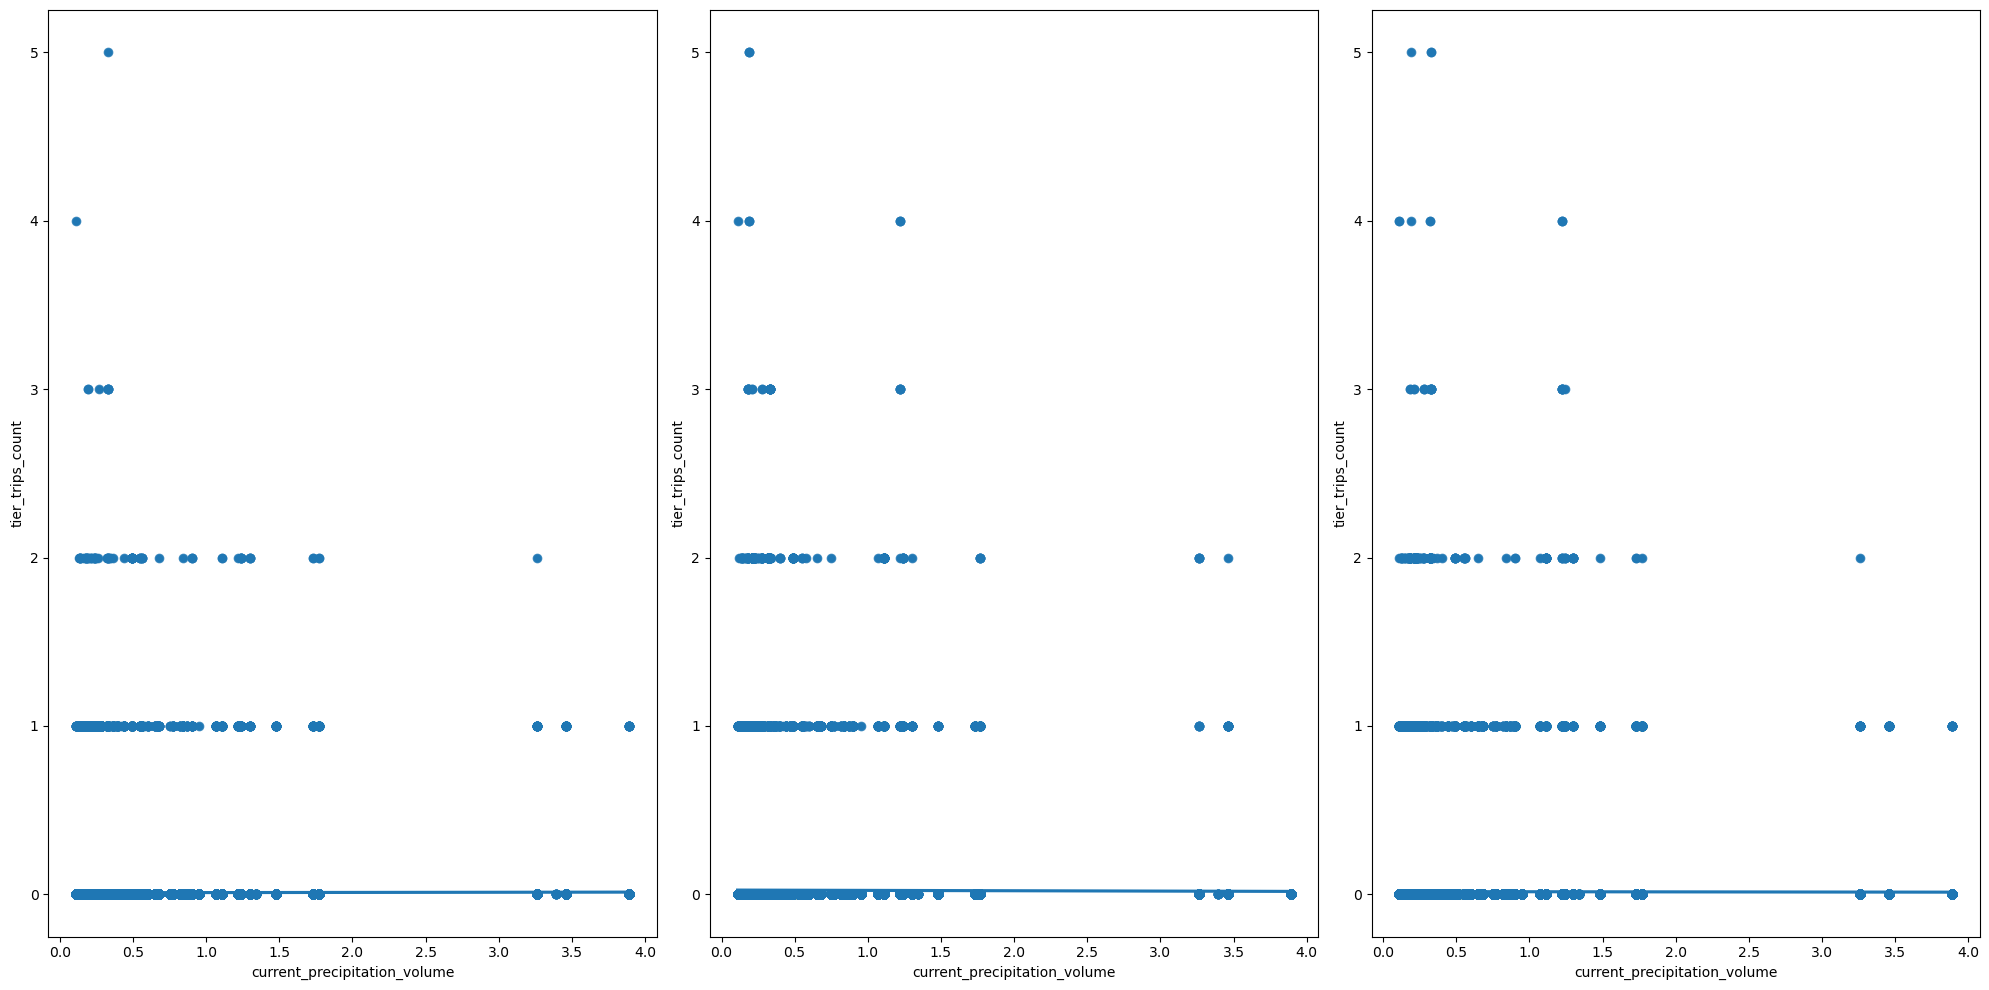

In [172]:
# Zeigt Beziehung zwischen zwei kontinuirlihen Variablen
fig, axes = plt.subplots(ncols=3)
plt.rcParams["figure.figsize"] = [20.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.scatterplot(x='current_precipitation_volume', y='tier_trips_count', data=delay, ax = axes[0])
sns.regplot(x ='current_precipitation_volume', y='tier_trips_count', data=delay, scatter=True, ax = axes[0])

sns.scatterplot(x='current_precipitation_volume', y='tier_trips_count', data=no_delay, ax = axes[1])
sns.regplot(x ='current_precipitation_volume', y='tier_trips_count', data=no_delay, scatter=True, ax = axes[1])

sns.scatterplot(x='current_precipitation_volume', y='tier_trips_count', data=nan_delay, ax = axes[2])
sns.regplot(x ='current_precipitation_volume', y='tier_trips_count', data=nan_delay, scatter=True, ax = axes[2])
plt

<module 'matplotlib.pyplot' from '/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/matplotlib/pyplot.py'>

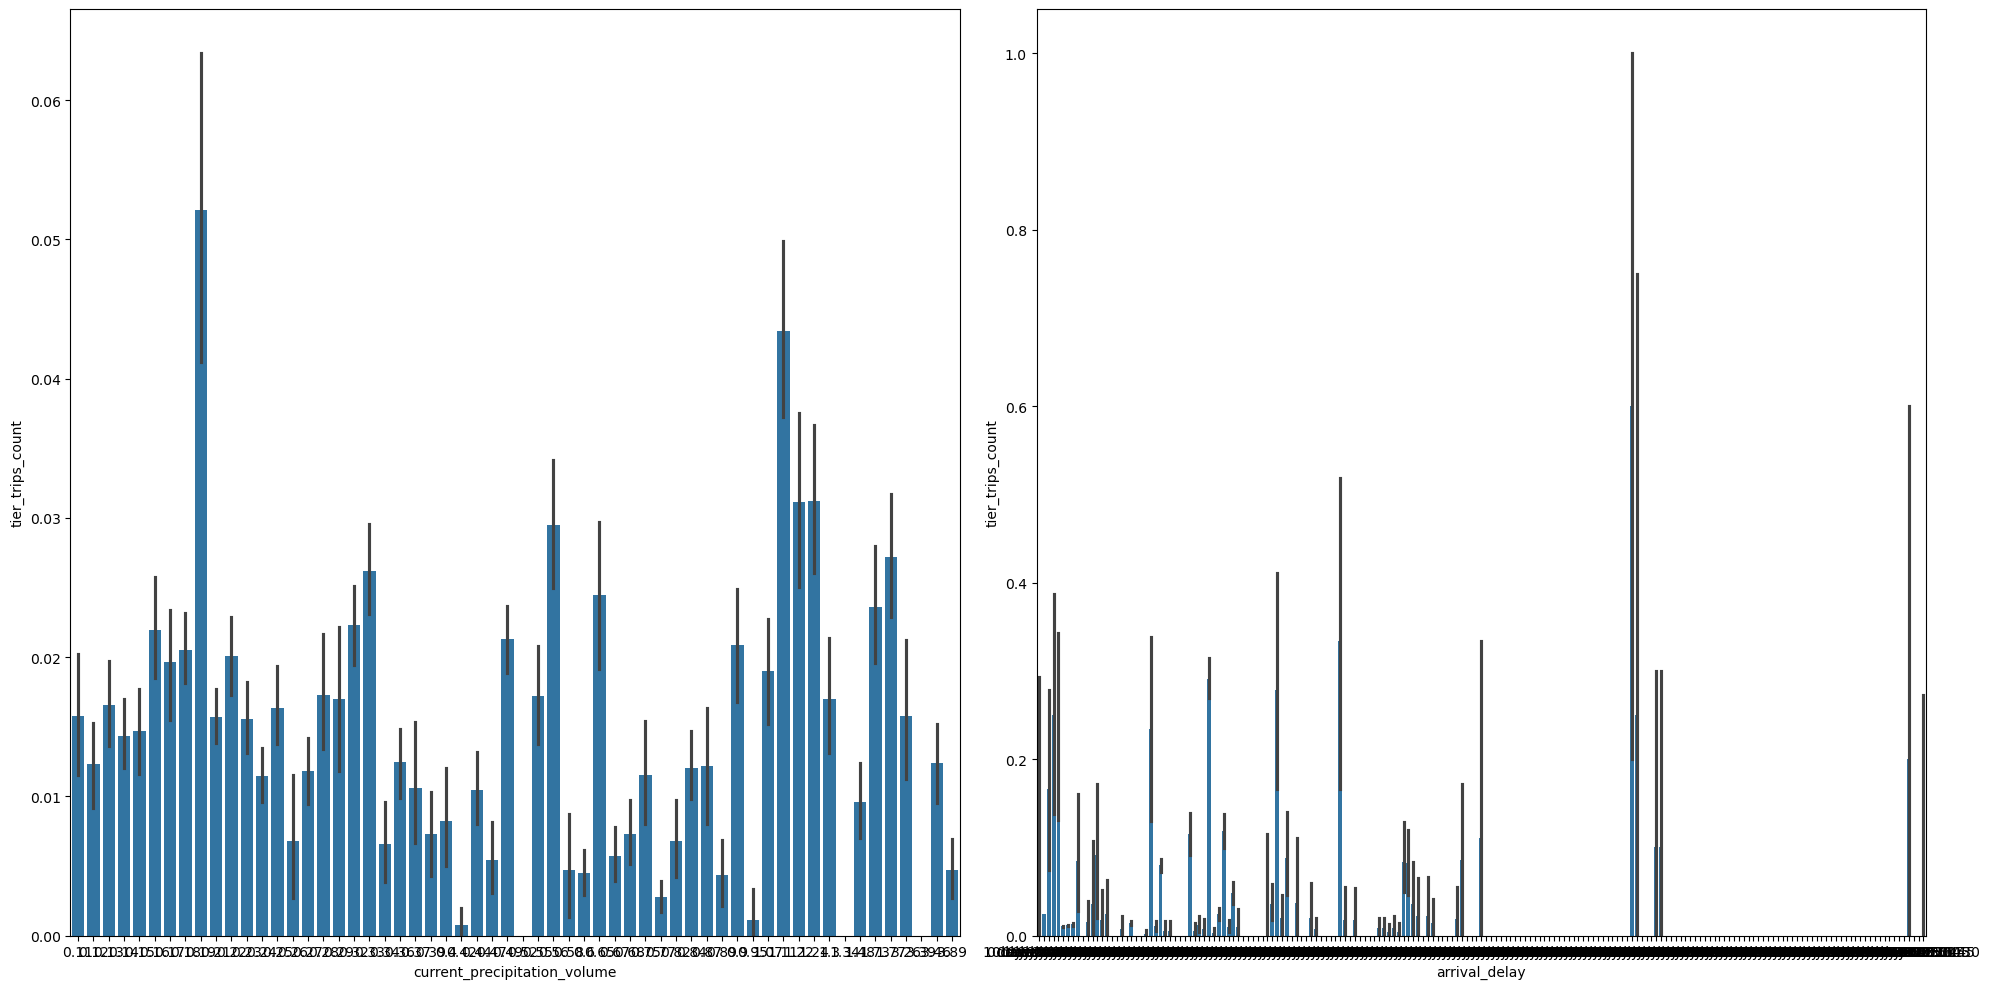

In [173]:
fig, axes = plt.subplots(ncols=2)
plt.rcParams["figure.figsize"] = [20.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data, x="current_precipitation_volume", y="tier_trips_count", ax = axes[0])
sns.barplot(data, x="arrival_delay", y="tier_trips_count", ax = axes[1])
#plt.set_xticklabels(plt.get_xticklabels(), rotation=45)
plt


<module 'matplotlib.pyplot' from '/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/matplotlib/pyplot.py'>

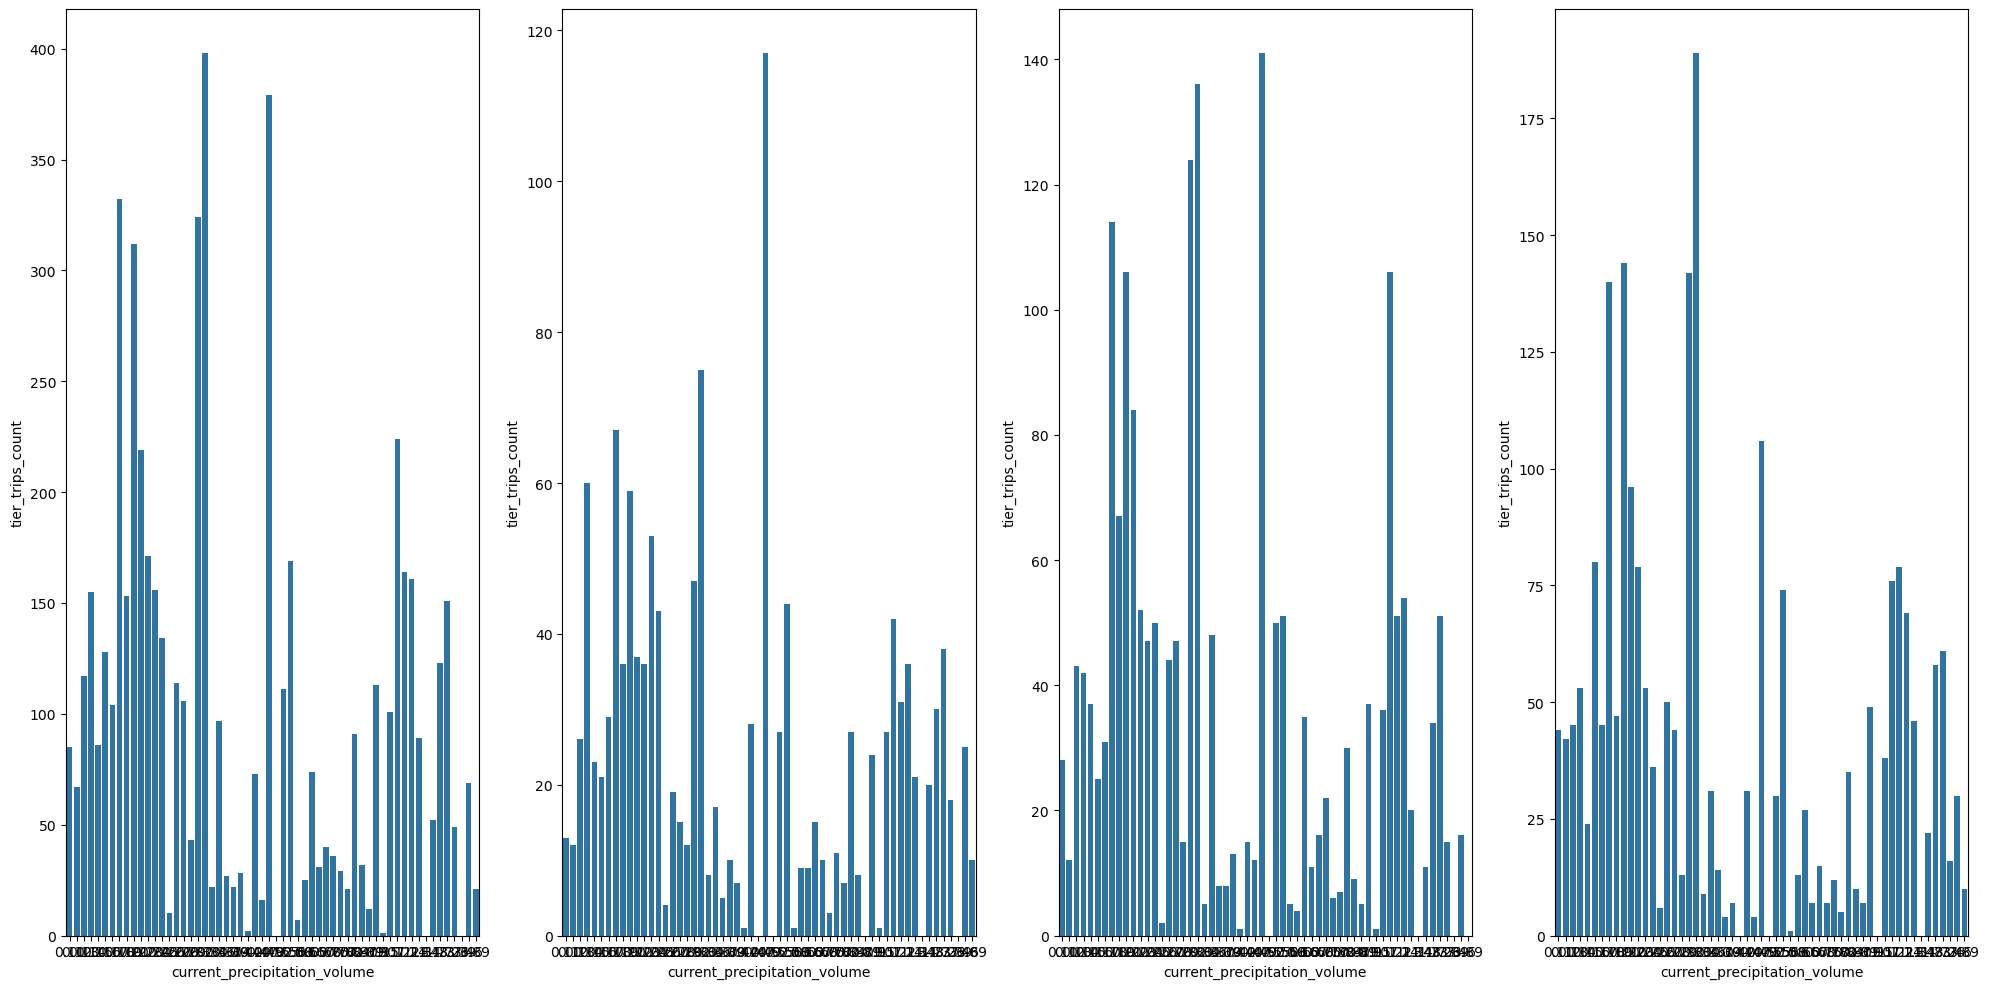

In [174]:
fig, axes = plt.subplots(ncols=4)
plt.rcParams["figure.figsize"] = [20.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(w_desc_data, x="current_precipitation_volume", y="tier_trips_count", ax = axes[0])
sns.barplot(w_desc_delay, x="current_precipitation_volume", y="tier_trips_count", ax = axes[1])
sns.barplot(w_desc_no_delay, x="current_precipitation_volume", y="tier_trips_count", ax = axes[2])
sns.barplot(w_desc_nan_delay, x="current_precipitation_volume", y="tier_trips_count", ax = axes[3])
#plt.set_xticklabels(plt.get_xticklabels(), rotation=45)
plt

<module 'matplotlib.pyplot' from '/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/matplotlib/pyplot.py'>

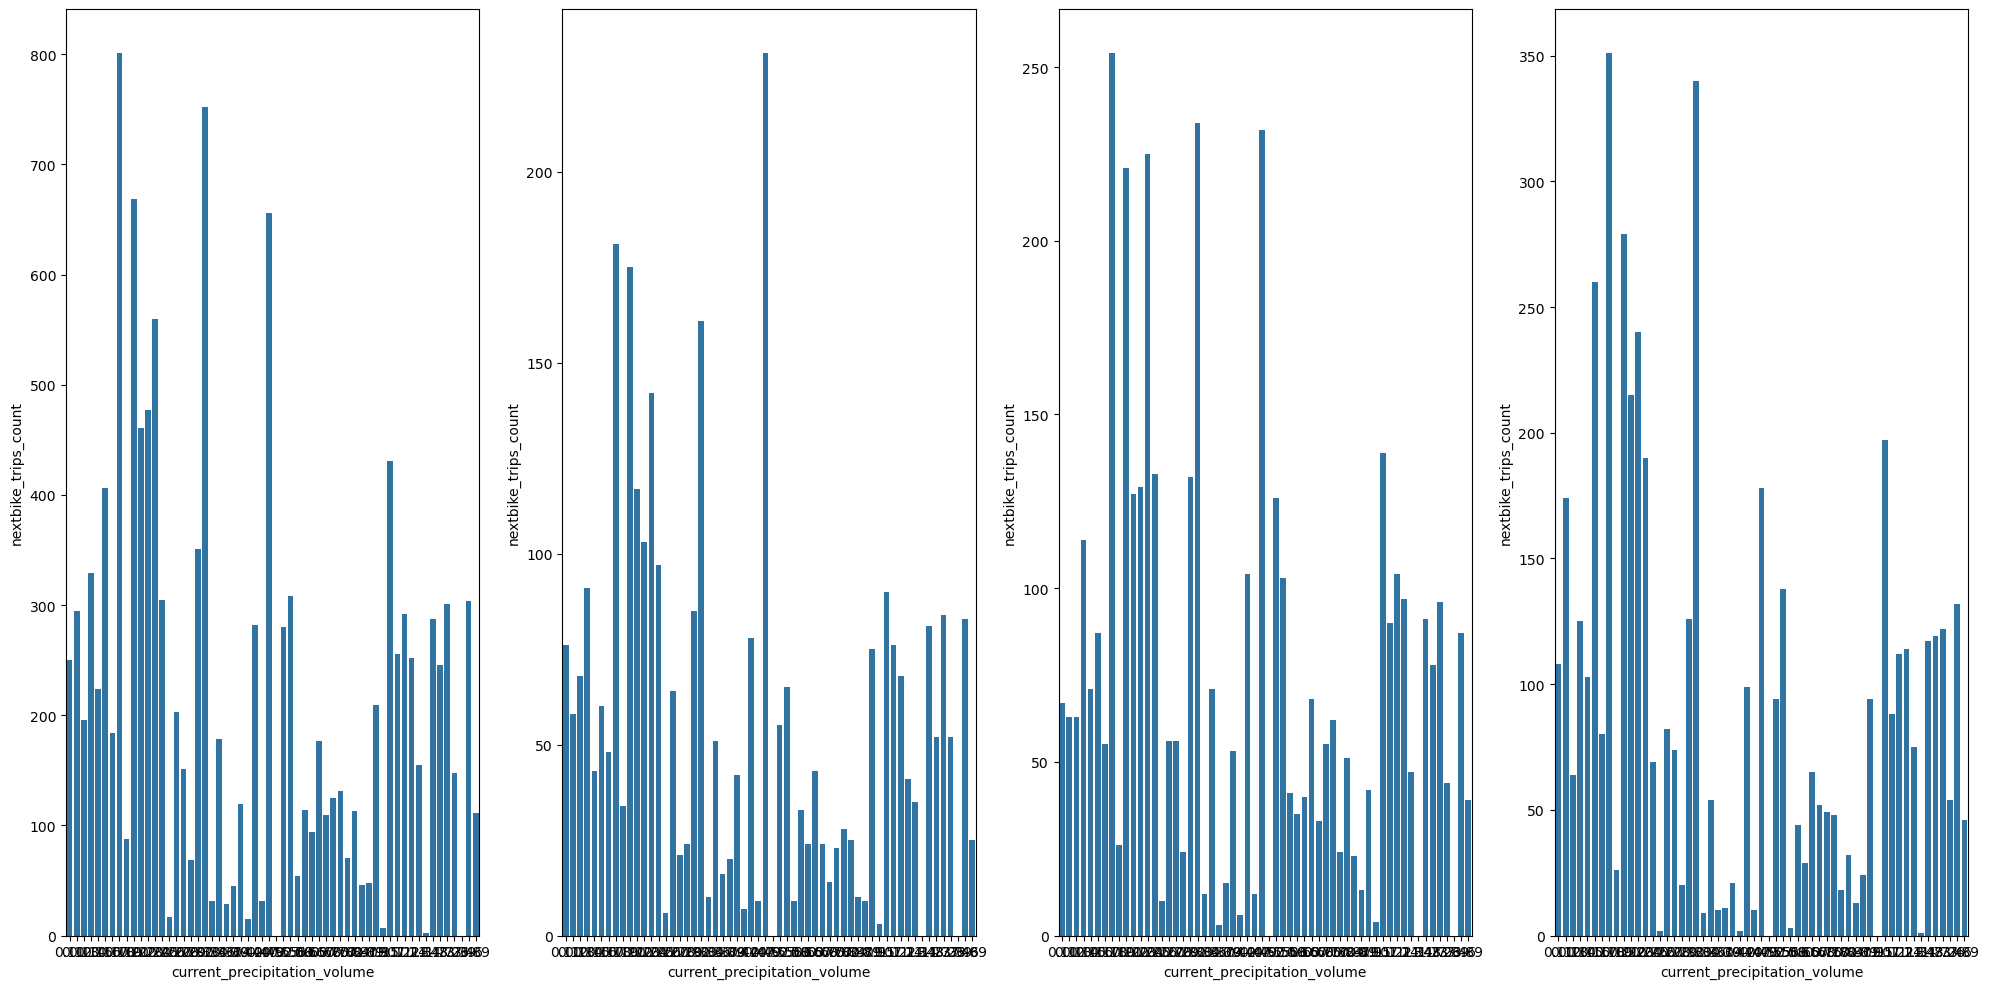

In [175]:
fig, axes = plt.subplots(ncols=4)
plt.rcParams["figure.figsize"] = [20.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(w_desc_data, x="current_precipitation_volume", y="nextbike_trips_count", ax = axes[0])
sns.barplot(w_desc_delay, x="current_precipitation_volume", y="nextbike_trips_count", ax = axes[1])
sns.barplot(w_desc_no_delay, x="current_precipitation_volume", y="nextbike_trips_count", ax = axes[2])
sns.barplot(w_desc_nan_delay, x="current_precipitation_volume", y="nextbike_trips_count", ax = axes[3])
#plt.set_xticklabels(plt.get_xticklabels(), rotation=45)
plt

In [176]:
# temp

In [177]:
w_desc_data = data.groupby(data['current_temp']).agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum', 'arrival_delay' : 'mean'})
w_desc_delay = delay.groupby(delay['current_temp']).agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum', 'arrival_delay' : 'mean'})
w_desc_no_delay = no_delay.groupby(no_delay['current_temp']).agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum', 'arrival_delay' : 'mean'})
w_desc_nan_delay = nan_delay.groupby(nan_delay['current_temp']).agg({'tier_trips_count': 'sum', 'nextbike_trips_count': 'sum', 'arrival_delay' : 'mean'})

<module 'matplotlib.pyplot' from '/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/matplotlib/pyplot.py'>

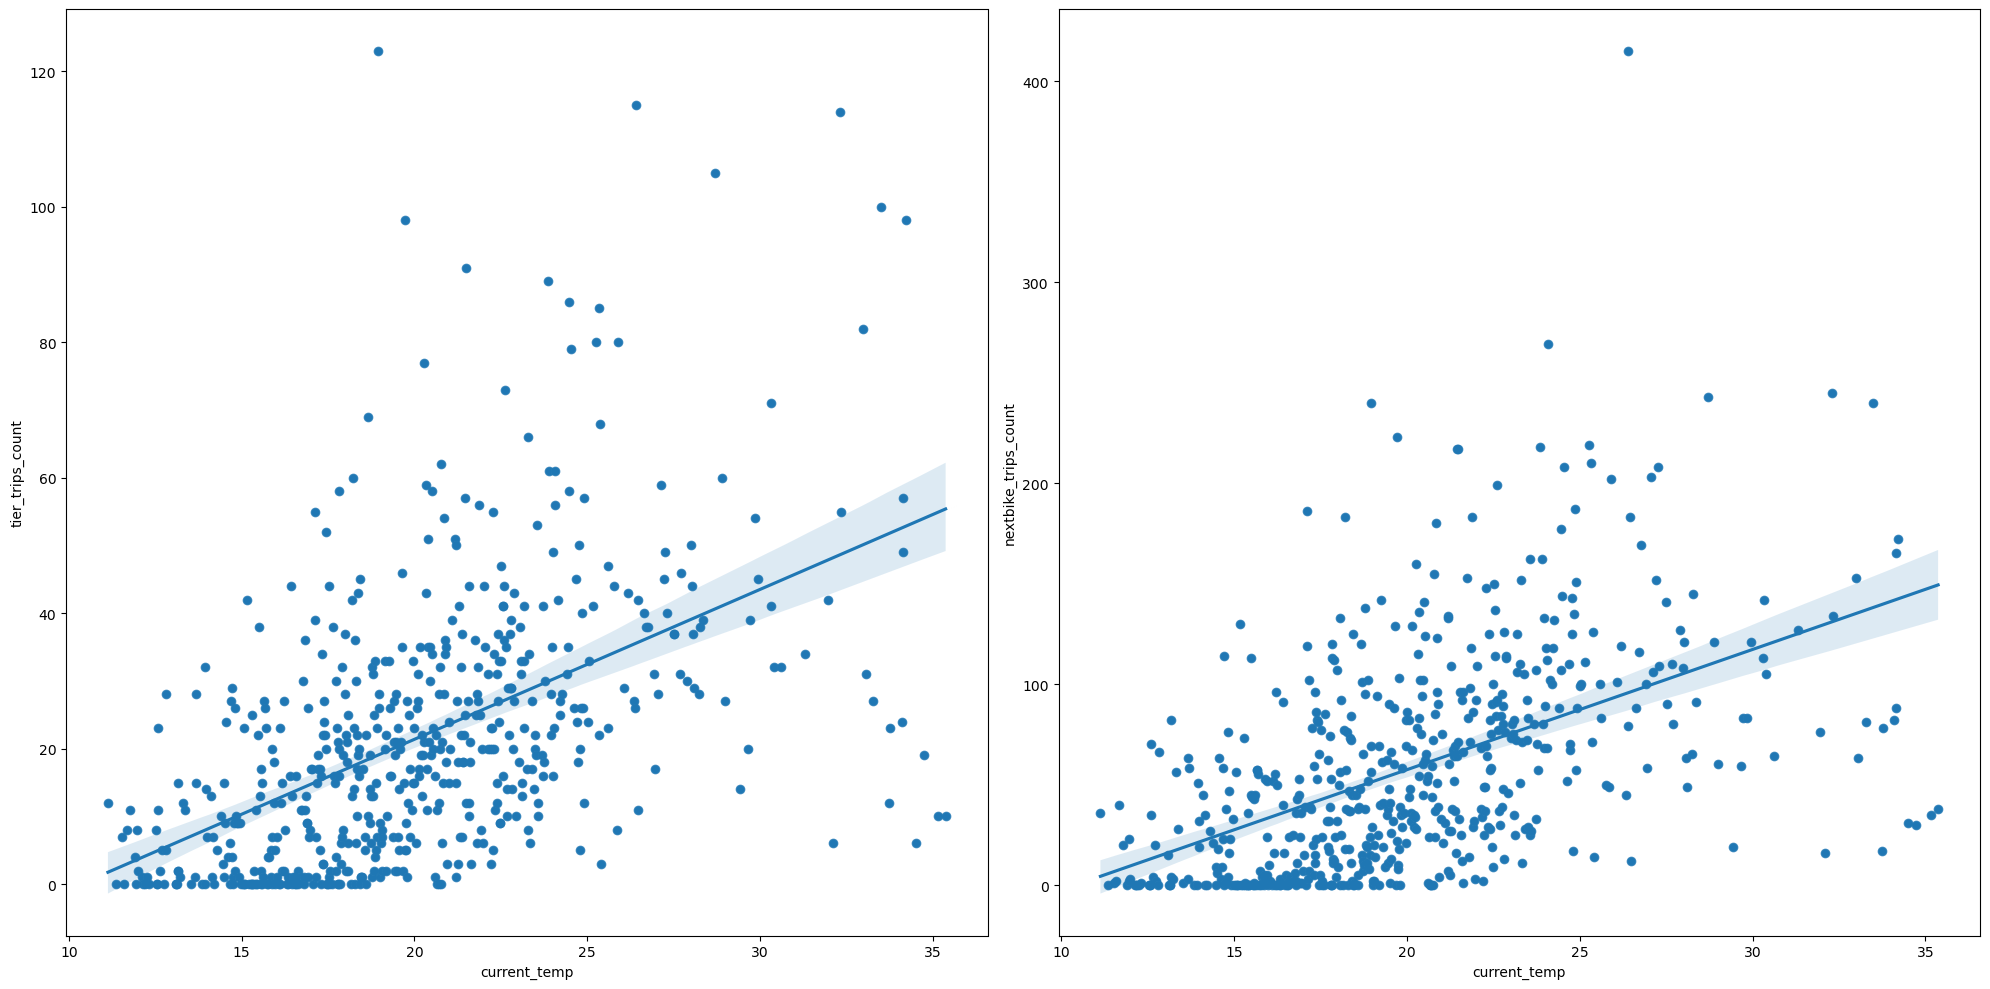

In [178]:
# Zeigt Beziehung zwischen zwei kontinuirlihen Variablen
fig, axes = plt.subplots(ncols=2)
plt.rcParams["figure.figsize"] = [20.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.scatterplot(x=w_desc_delay.index, y='tier_trips_count', data=w_desc_delay, ax = axes[0])
sns.regplot(x =w_desc_delay.index, y='tier_trips_count', data=w_desc_delay, scatter=True, ax = axes[0])

sns.scatterplot(x=w_desc_delay.index, y='nextbike_trips_count', data=w_desc_delay, ax = axes[1])
sns.regplot(x =w_desc_delay.index, y='nextbike_trips_count', data=w_desc_delay, scatter=True, ax = axes[1])
plt

<module 'matplotlib.pyplot' from '/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/matplotlib/pyplot.py'>

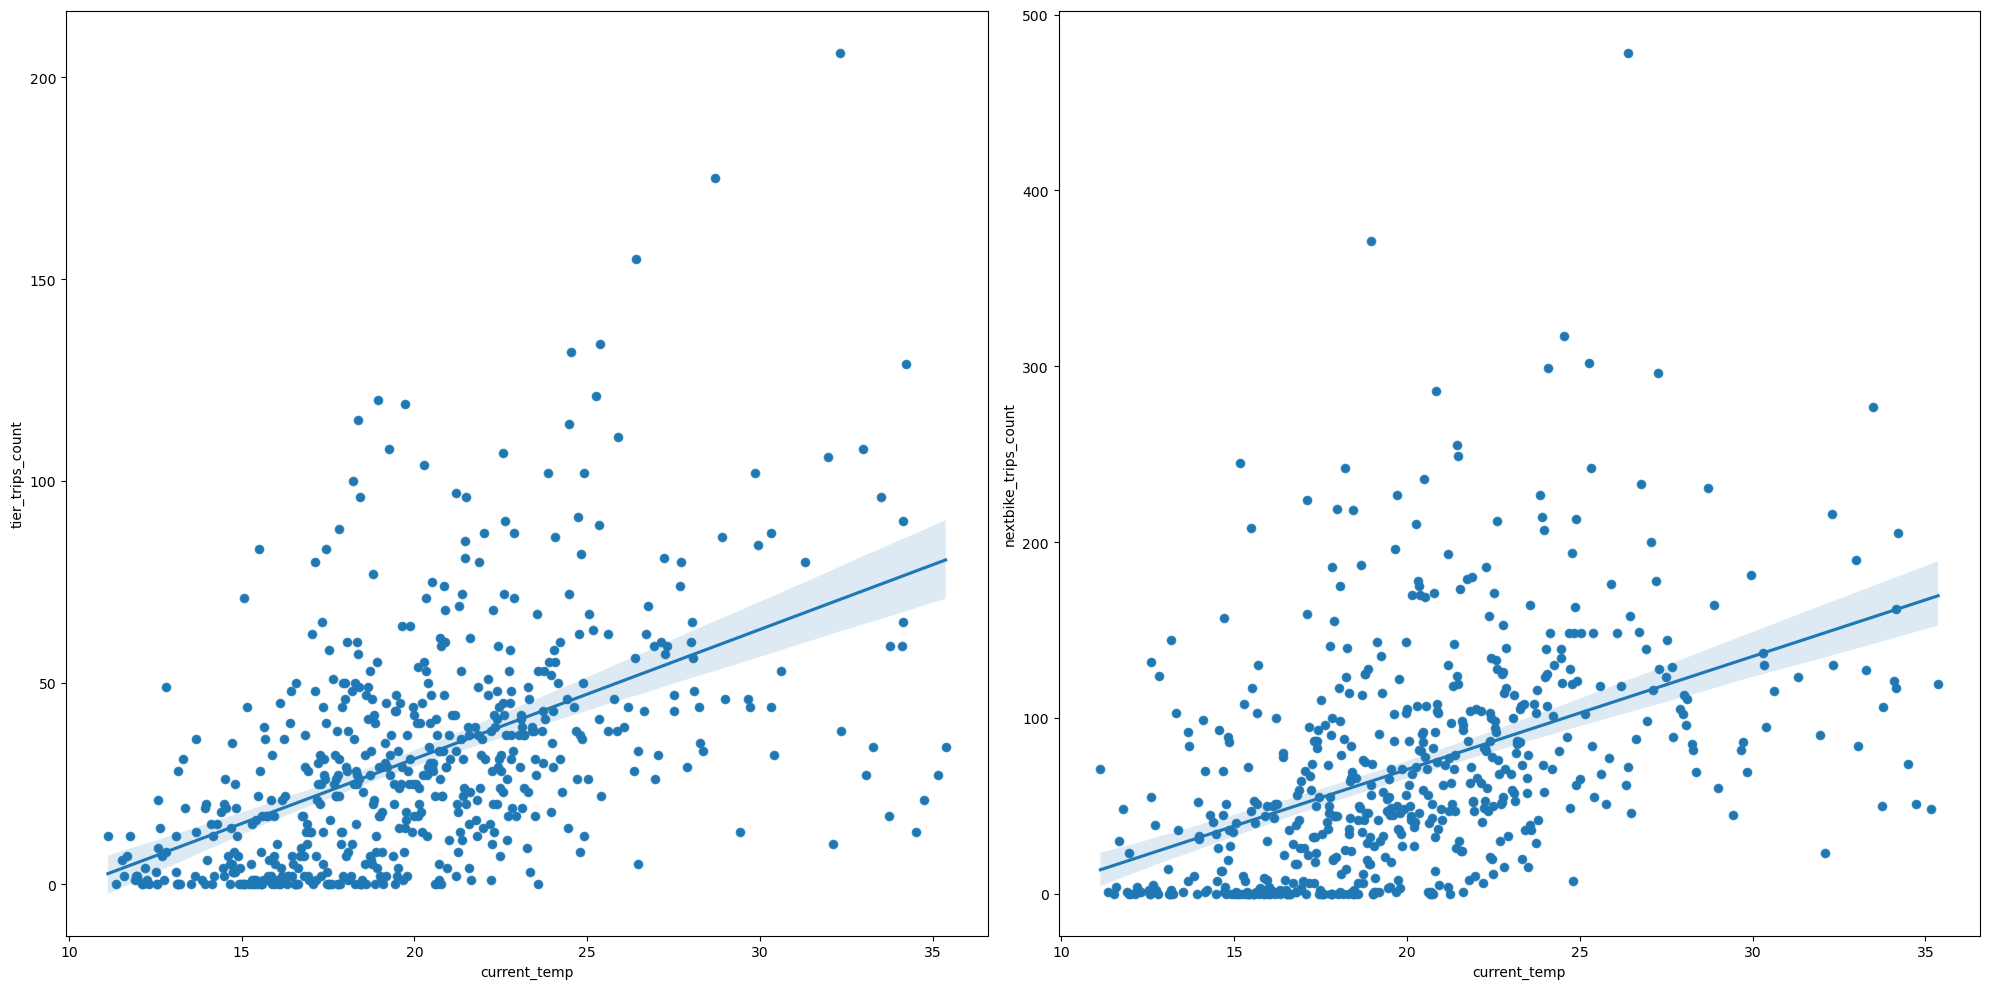

In [179]:
# Zeigt Beziehung zwischen zwei kontinuirlihen Variablen
fig, axes = plt.subplots(ncols=2)
plt.rcParams["figure.figsize"] = [20.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.scatterplot(x=w_desc_no_delay.index, y='tier_trips_count', data=w_desc_no_delay, ax = axes[0])
sns.regplot(x =w_desc_no_delay.index, y='tier_trips_count', data=w_desc_no_delay, scatter=True, ax = axes[0])

sns.scatterplot(x=w_desc_no_delay.index, y='nextbike_trips_count', data=w_desc_no_delay, ax = axes[1])
sns.regplot(x =w_desc_no_delay.index, y='nextbike_trips_count', data=w_desc_no_delay, scatter=True, ax = axes[1])
plt

<module 'matplotlib.pyplot' from '/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/matplotlib/pyplot.py'>

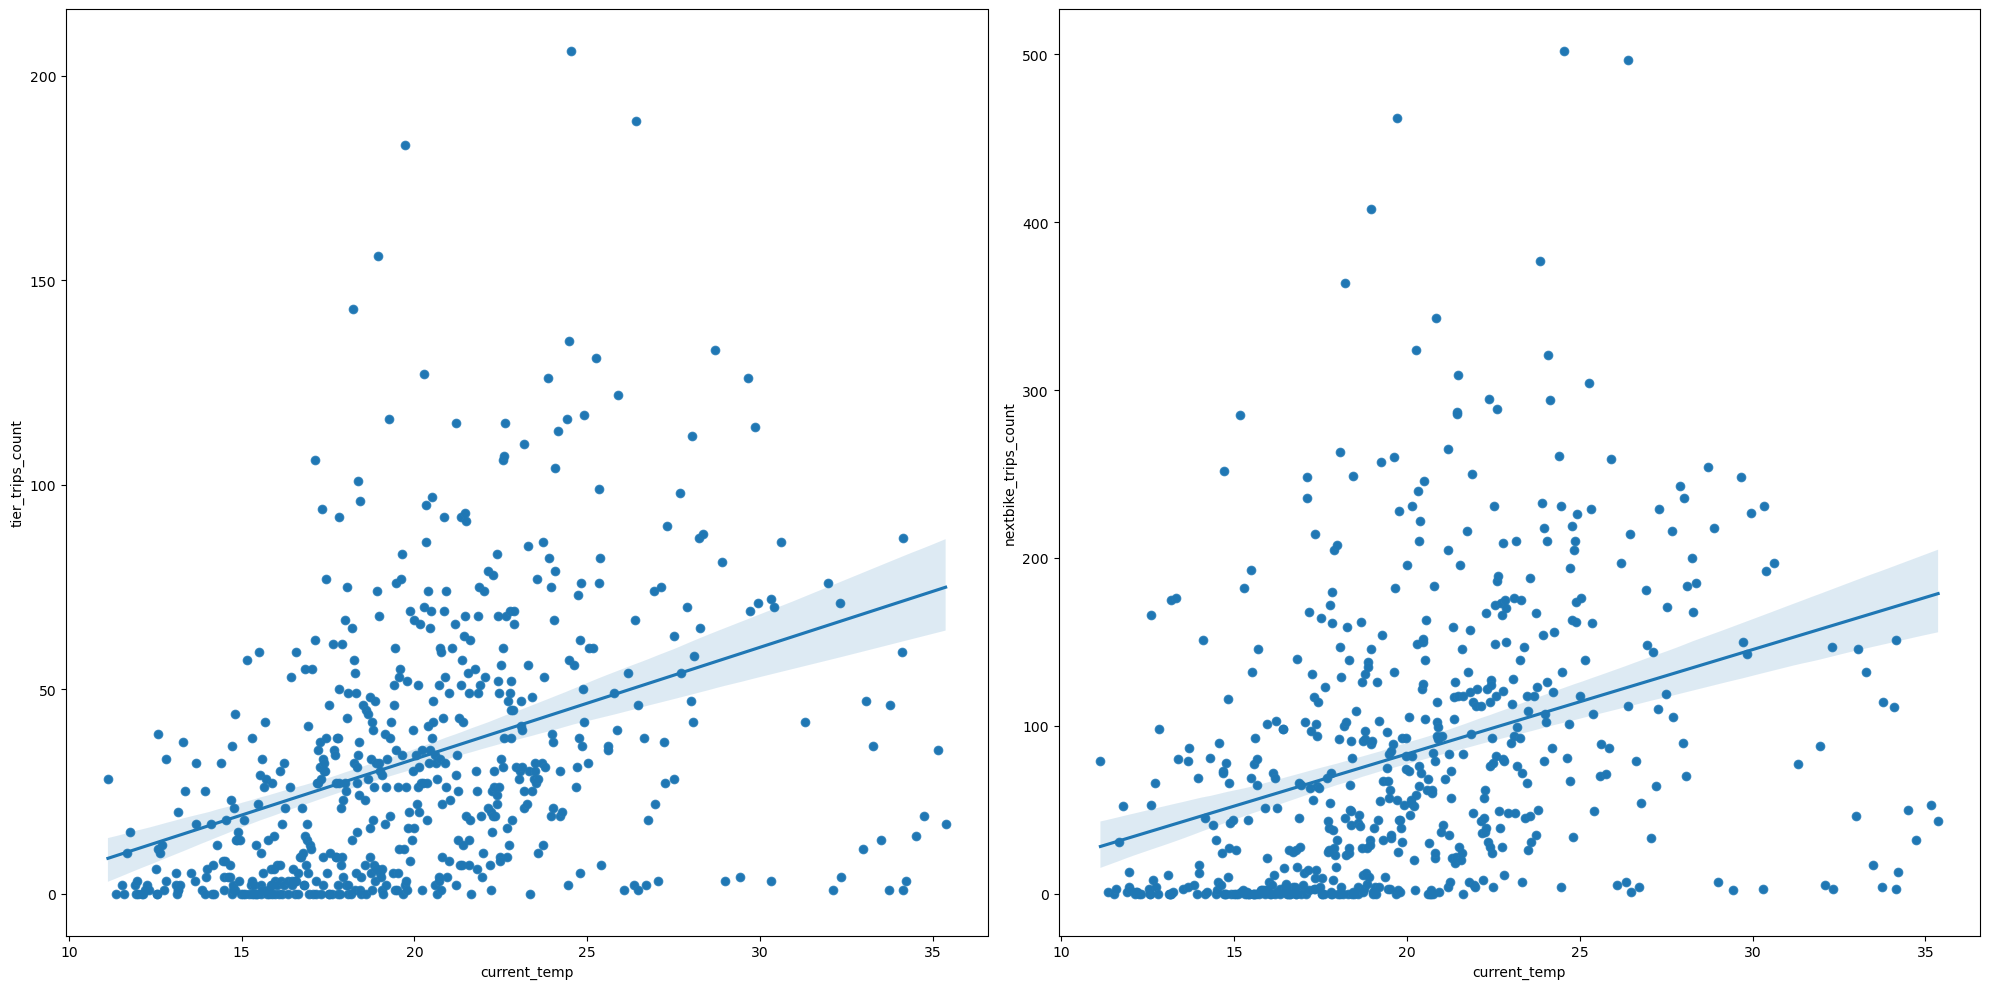

In [180]:
# Zeigt Beziehung zwischen zwei kontinuirlihen Variablen
fig, axes = plt.subplots(ncols=2)
plt.rcParams["figure.figsize"] = [20.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.scatterplot(x=w_desc_nan_delay.index, y='tier_trips_count', data=w_desc_nan_delay, ax = axes[0])
sns.regplot(x =w_desc_nan_delay.index, y='tier_trips_count', data=w_desc_nan_delay, scatter=True, ax = axes[0])

sns.scatterplot(x=w_desc_nan_delay.index, y='nextbike_trips_count', data=w_desc_nan_delay, ax = axes[1])
sns.regplot(x =w_desc_nan_delay.index, y='nextbike_trips_count', data=w_desc_nan_delay, scatter=True, ax = axes[1])
plt

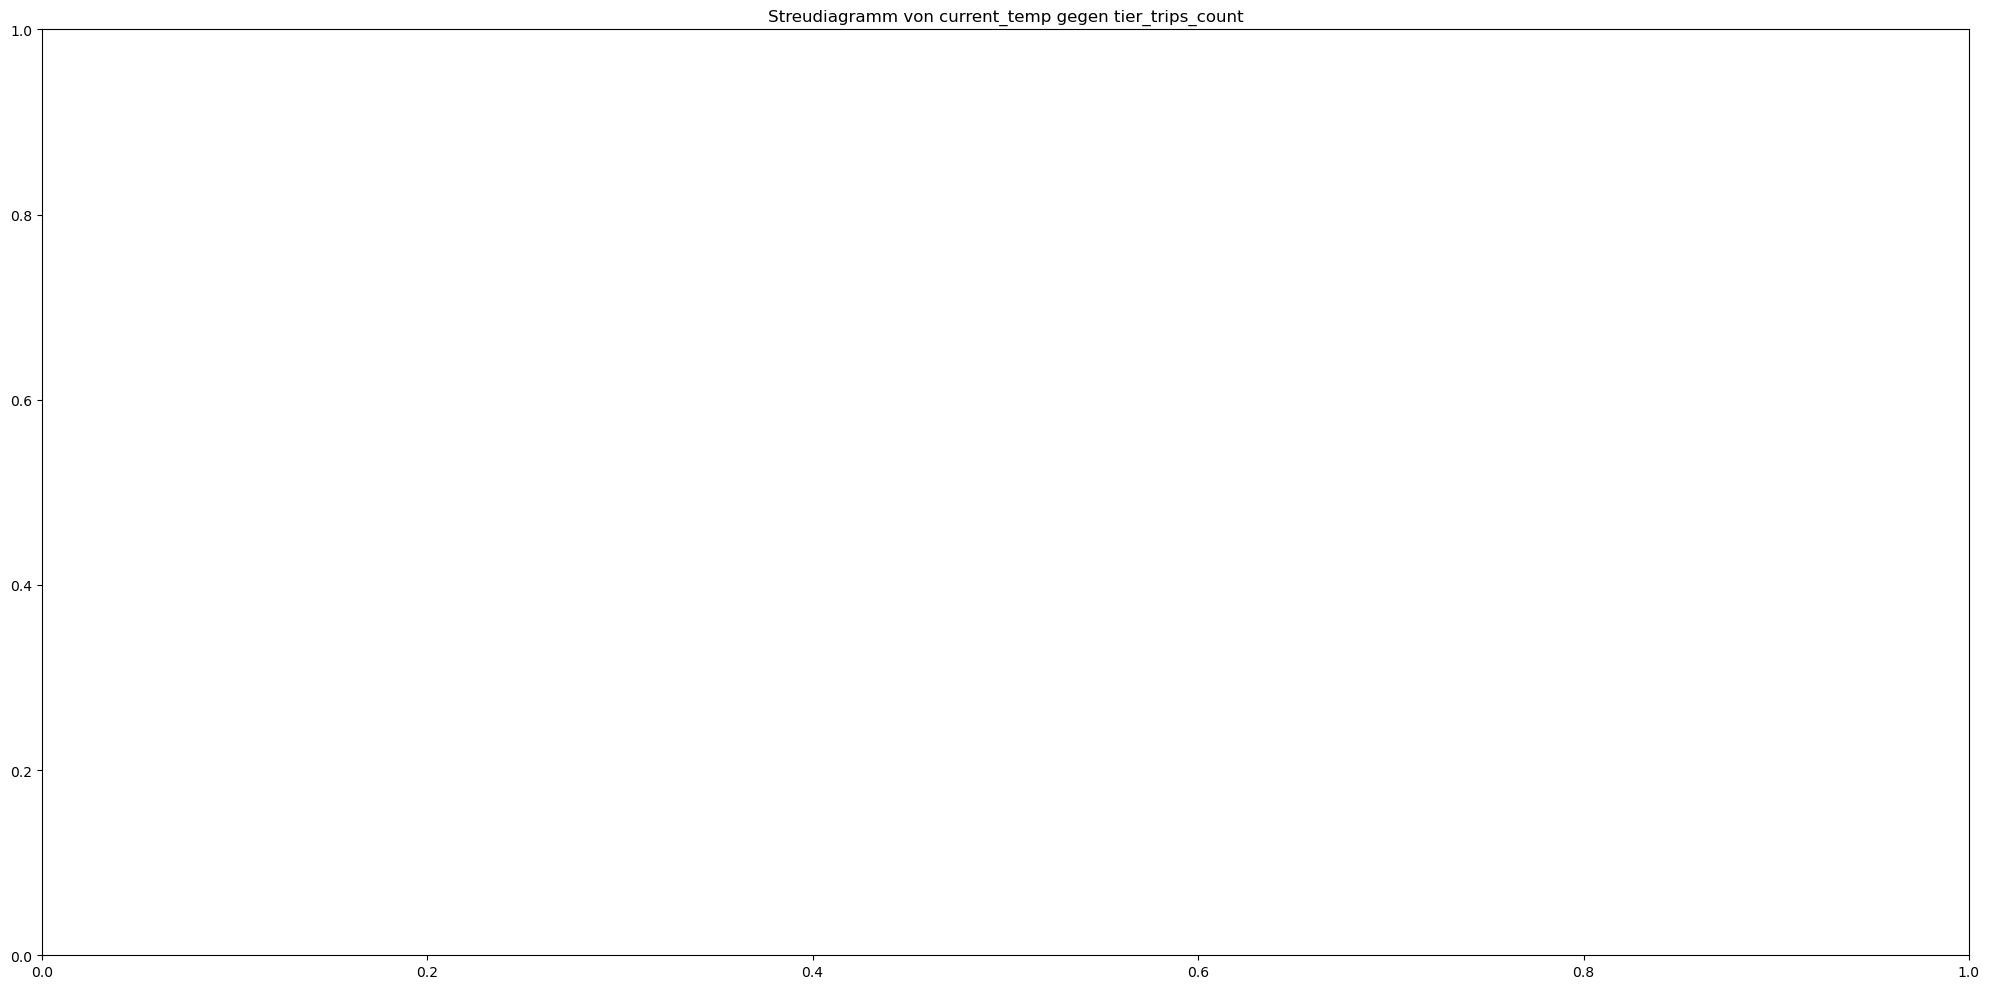

In [181]:
# Zeigt Beziehung zwischen zwei kontinuirlihen Variablen
sns.scatterplot(x='current_temp', y='tier_trips_count', data=data,  ax = axes[0])
sns.regplot(x ='current_temp', y='tier_trips_count', data=data, scatter=True, ax = axes[0])

sns.scatterplot(x='current_temp', y='nextbike_trips_count', data=data,  ax = axes[1])
sns.regplot(x ='current_temp', y='nextbike_trips_count', data=data, scatter=True,  ax = axes[1])

plt.title('Streudiagramm von current_temp gegen tier_trips_count')
plt.show()

<module 'matplotlib.pyplot' from '/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/matplotlib/pyplot.py'>

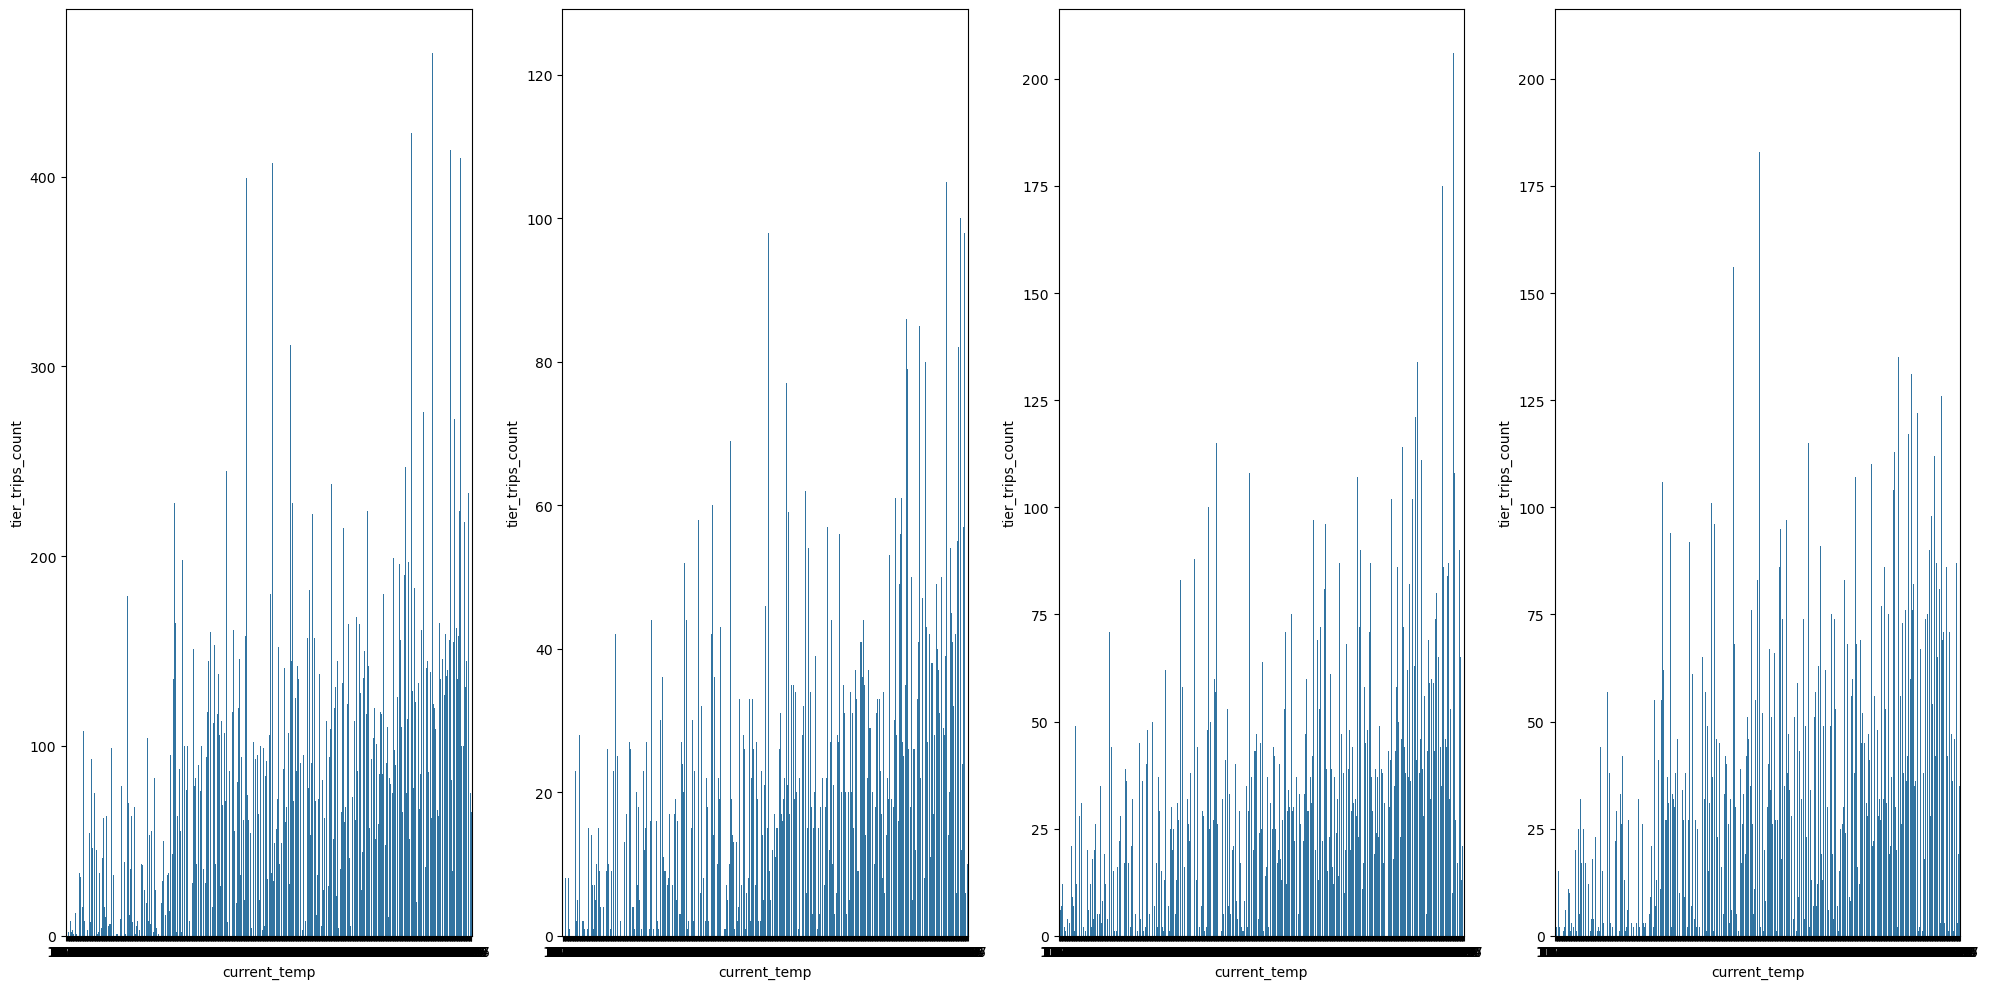

In [182]:
fig, axes = plt.subplots(ncols=4)
plt.rcParams["figure.figsize"] = [20.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(w_desc_data, x="current_temp", y="tier_trips_count", ax = axes[0])
sns.barplot(w_desc_delay, x="current_temp", y="tier_trips_count", ax = axes[1])
sns.barplot(w_desc_no_delay, x="current_temp", y="tier_trips_count", ax = axes[2])
sns.barplot(w_desc_nan_delay, x="current_temp", y="tier_trips_count", ax = axes[3])
#plt.set_xticklabels(plt.get_xticklabels(), rotation=45)
plt

<module 'matplotlib.pyplot' from '/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/matplotlib/pyplot.py'>

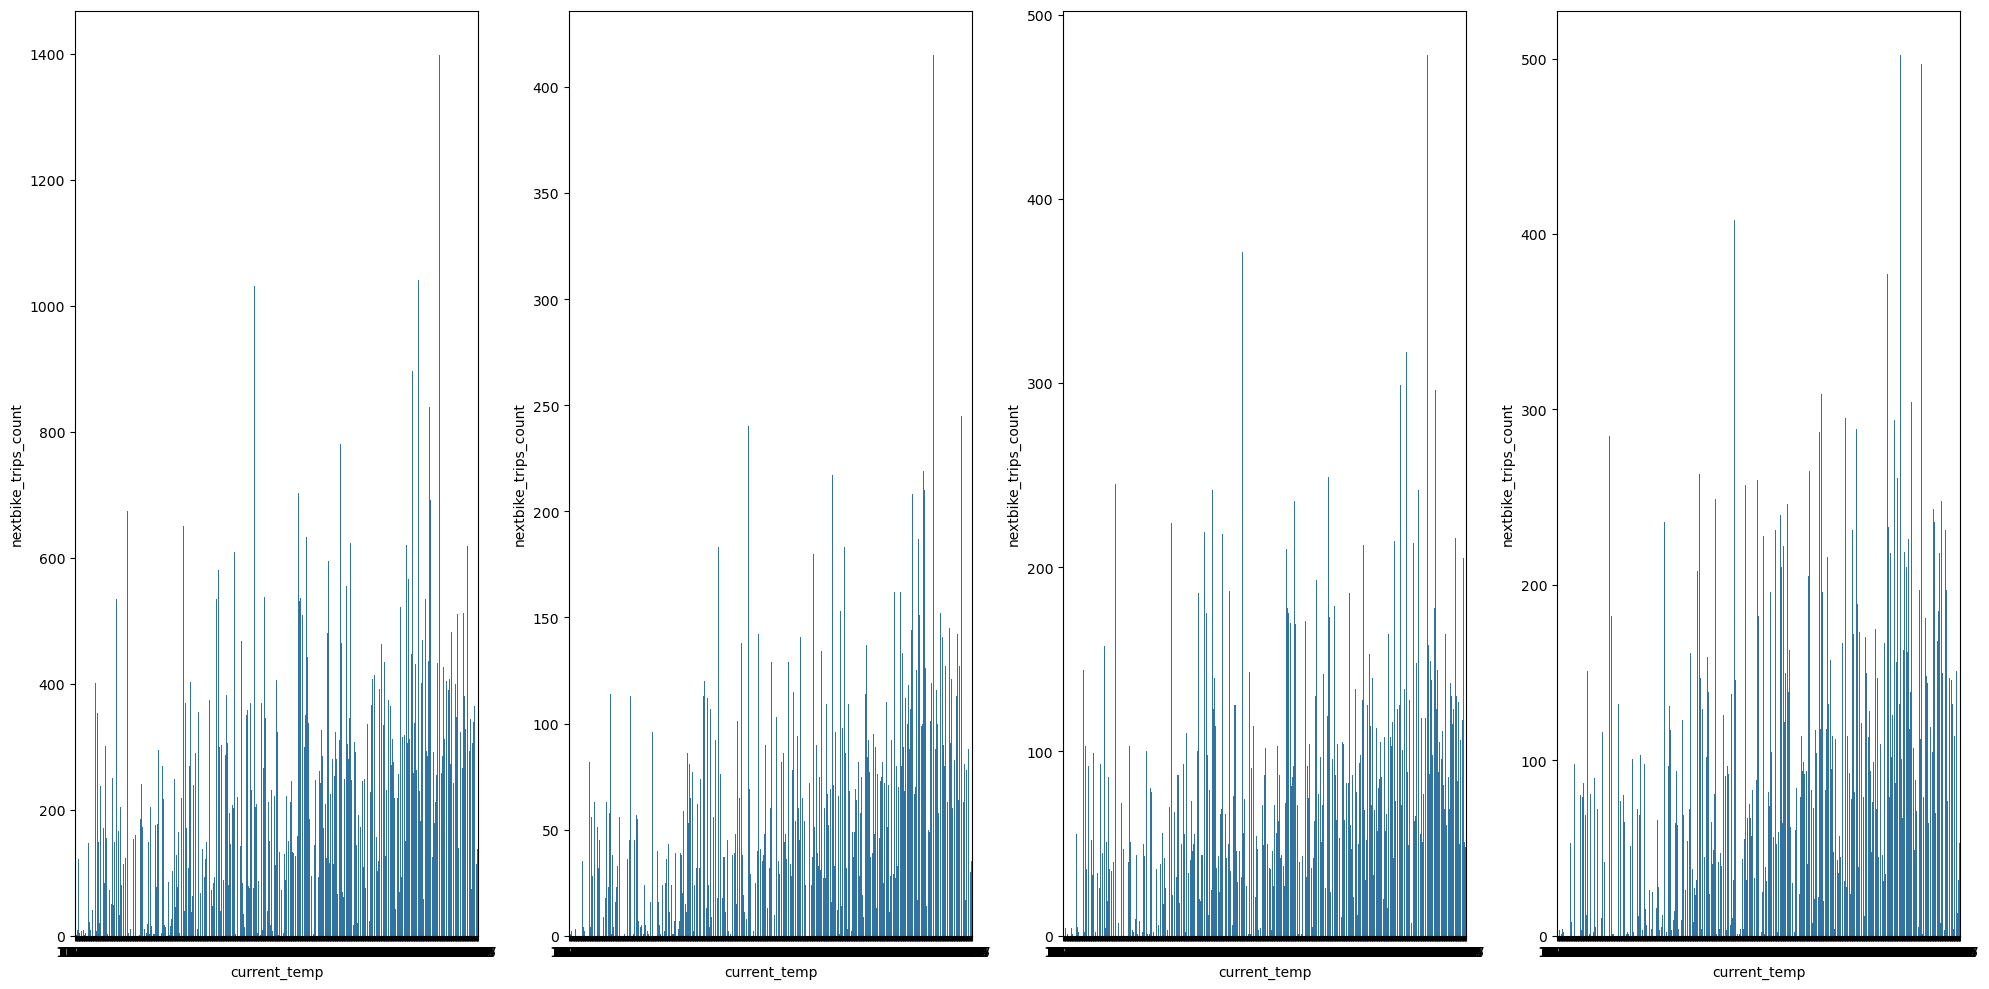

In [183]:
fig, axes = plt.subplots(ncols=4)
plt.rcParams["figure.figsize"] = [20.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(w_desc_data, x="current_temp", y="nextbike_trips_count", ax = axes[0])
sns.barplot(w_desc_delay, x="current_temp", y="nextbike_trips_count", ax = axes[1])
sns.barplot(w_desc_no_delay, x="current_temp", y="nextbike_trips_count", ax = axes[2])
sns.barplot(w_desc_nan_delay, x="current_temp", y="nextbike_trips_count", ax = axes[3])
#plt.set_xticklabels(plt.get_xticklabels(), rotation=45)
plt

<module 'matplotlib.pyplot' from '/home/students/miniconda3/envs/Andrej/lib/python3.12/site-packages/matplotlib/pyplot.py'>

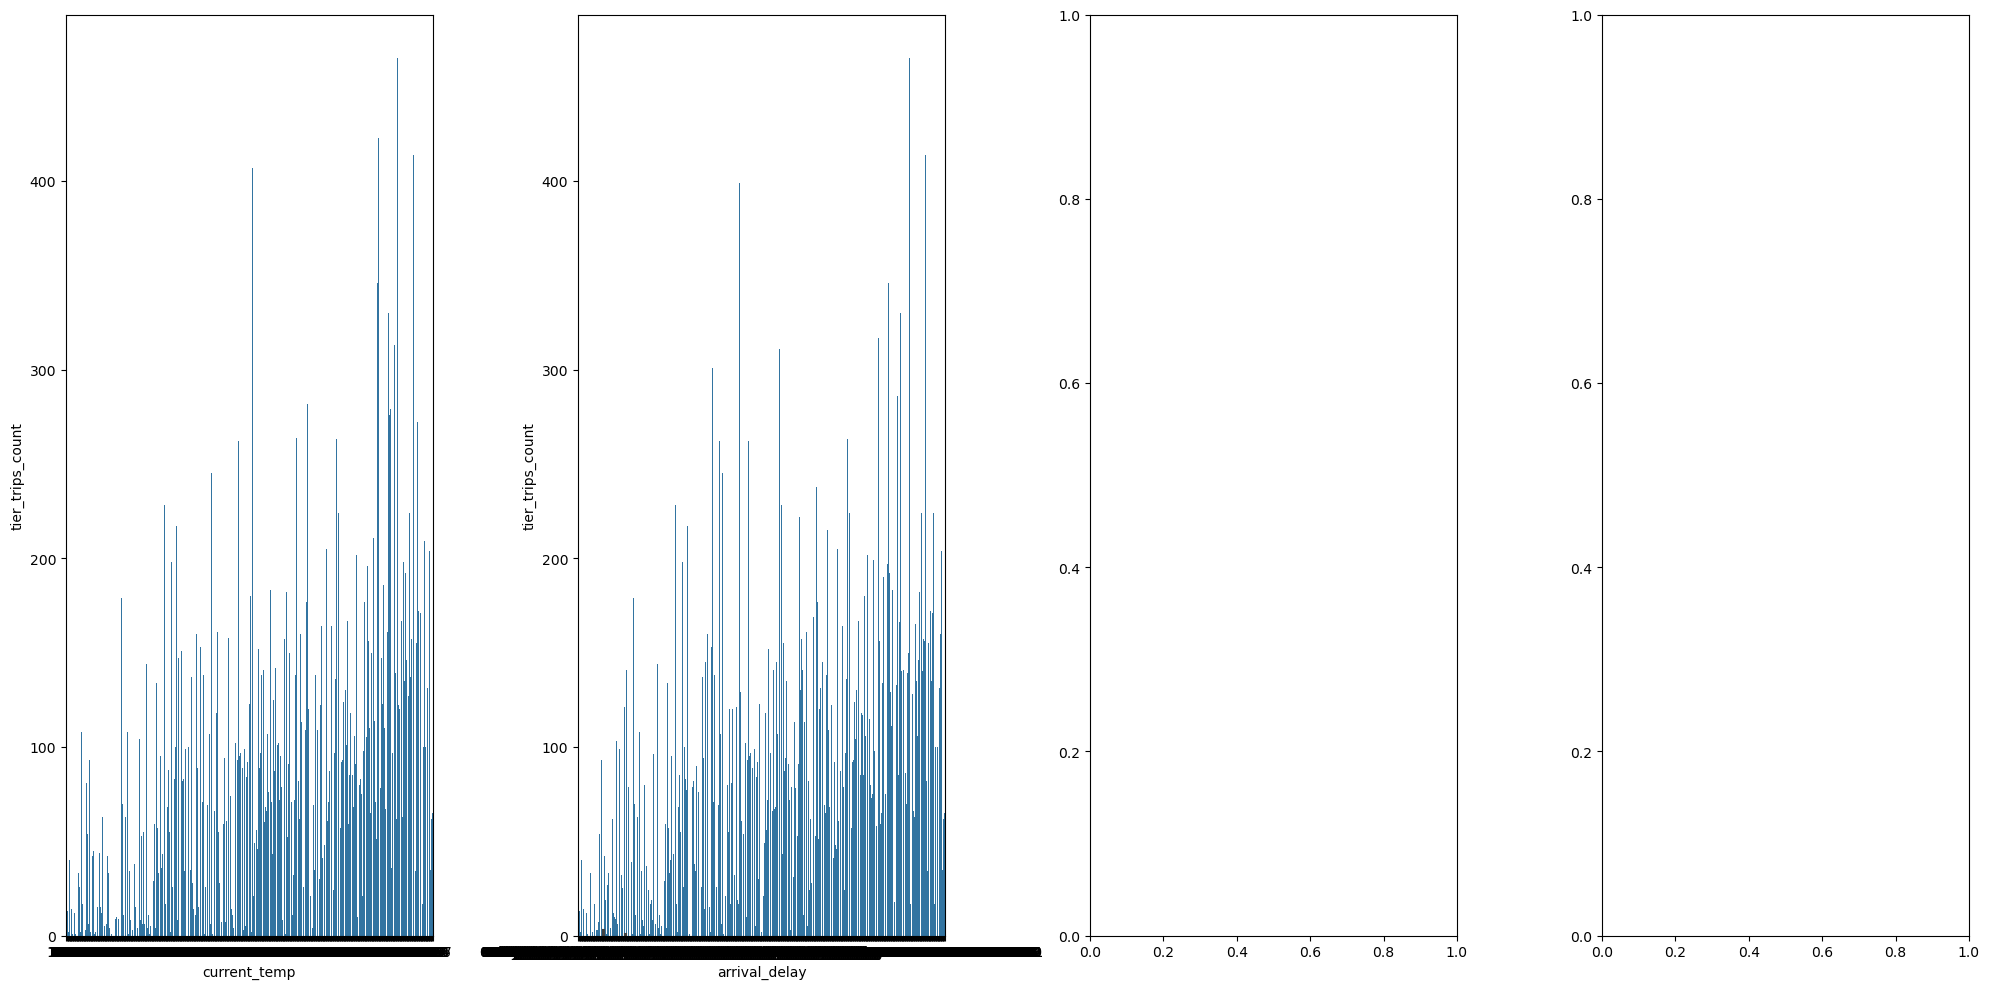

In [184]:
fig, axes = plt.subplots(ncols=4)
plt.rcParams["figure.figsize"] = [20.00, 10.00]
plt.rcParams["figure.autolayout"] = True
sns.barplot(w_desc_data, x="current_temp", y="tier_trips_count", ax = axes[0])
sns.barplot(w_desc_data, x="arrival_delay", y="tier_trips_count", ax = axes[1])

#plt.set_xticklabels(plt.get_xticklabels(), rotation=45)
plt